In [1]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 50.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 80.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 22.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-rzfwbyz4
  Running command git clone --filter=blob:none --quiet https://github.com/p

In [2]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 51.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear, ReLU, CrossEntropyLoss
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import from_smiles
from tqdm import tqdm

from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Prepate data from csv to work
def convert_csv_to_graph(path, smiles, sol):
  df = pd.read_csv(path, sep=',')
  df.head()

  data = []

  for index, row in df.iterrows():
    sample = from_smiles(row[smiles])
    sample.y = torch.tensor([[row[sol]]])
    data.append(sample)
  print("Dataset sample: ", data[0])
  print("Sample  nodes: ", data[0].num_nodes)
  print("Sample  edges: ", data[0].num_edges) 
  return data

In [6]:
# Get datasets from github
!wget https://raw.githubusercontent.com/AngryFennec/drug-gnn/master/data/curated-solubility-dataset.csv #AQSOL
!wget https://raw.githubusercontent.com/AngryFennec/drug-gnn/master/data/delaney-processed.csv 

--2023-02-01 19:17:42--  https://raw.githubusercontent.com/AngryFennec/drug-gnn/master/data/curated-solubility-dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3750208 (3.6M) [text/plain]
Saving to: ‘curated-solubility-dataset.csv’

curated-solubility- 100%[===================>]   3.58M  --.-KB/s    in 0.01s   

2023-02-01 19:17:43 (246 MB/s) - ‘curated-solubility-dataset.csv’ saved [3750208/3750208]

--2023-02-01 19:17:43--  https://raw.githubusercontent.com/AngryFennec/drug-gnn/master/data/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request 

In [7]:
#data = convert_csv_to_graph('delaney-processed.csv', 'smiles', 'ESOL predicted log solubility in mols per litre')
data = convert_csv_to_graph('curated-solubility-dataset.csv', 'SMILES', 'Solubility')

Dataset sample:  Data(x=[23, 9], edge_index=[2, 42], edge_attr=[42, 3], smiles='[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C', y=[1, 1])
Sample  nodes:  23
Sample  edges:  42


In [8]:
hidden_channels = 64
num_features = len(data[0].x[0])
batch_size = 64


class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super().__init__()
        torch.manual_seed(42)

        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels*2, 1)

    def forward(self, x, edge_index, batch_index):
        hidden = F.leaky_relu(self.conv1(x, edge_index))
        hidden = F.leaky_relu(self.conv2(hidden, edge_index))
        hidden = F.leaky_relu(self.conv3(hidden, edge_index))

        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        out = self.out(hidden)
        return out, hidden

In [9]:
from torch_geometric.nn import SAGEConv
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
      super().__init__()
      torch.manual_seed(42)
      self.sage1 = SAGEConv(num_features, hidden_channels)
      self.sage2 = SAGEConv(hidden_channels, hidden_channels)
      self.sage3 = SAGEConv(hidden_channels, hidden_channels)
      self.out = Linear(hidden_channels*2, 1)
    
    def forward(self, x, edge_index, batch_index):
      hidden = self.sage1(x, edge_index)
      hidden = F.leaky_relu(hidden)
      hidden = self.sage2(hidden, edge_index)
      hidden = F.leaky_relu(hidden)
      hidden = self.sage3(hidden, edge_index)
      hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)
      out = self.out(hidden)
      return out, hidden

In [10]:
from torch_geometric.nn import GATConv
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
      super().__init__()
      torch.manual_seed(42)
      self.sage1 = GATConv(num_features, hidden_channels)
      self.sage2 = GATConv(hidden_channels, hidden_channels)
      self.sage3 = GATConv(hidden_channels, hidden_channels)
      self.out = Linear(hidden_channels*2, 1)
    
    def forward(self, x, edge_index, batch_index):
      hidden = self.sage1(x, edge_index)
      hidden = F.leaky_relu(hidden)
      hidden = self.sage2(hidden, edge_index)
      hidden = F.leaky_relu(hidden)
      hidden = self.sage3(hidden, edge_index)
      hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)
      out = self.out(hidden)
      return out, hidden

In [28]:
#model = GCN(num_features=num_features, hidden_channels=hidden_channels)
#model = GraphSAGE(num_features=num_features, hidden_channels=hidden_channels)
model = GAT(num_features=num_features, hidden_channels=hidden_channels)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [29]:
data_size = len(data)
#loader = DataLoader(data[:int(data_size * 0.8)], batch_size=batch_size, shuffle=True)
loader = DataLoader(data, batch_size=batch_size, shuffle=True)
print(data_size)

9982


In [30]:
def train(data):
    for batch in loader:
      batch.to(device)  
      optimizer.zero_grad() 
      prediction, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      loss = torch.sqrt(loss_fn(prediction, batch.y))       
      loss.backward()  
      optimizer.step()   
    return loss, embedding

In [31]:
#5000, SGD, full data, lr=0.05, GCN
epochs = 3000
losses = []
for epoch in tqdm(range(epochs)):
    loss, h = train(data)
    losses.append(loss)
    print(f"Epoch {epoch} | Train Loss {loss}")

  0%|          | 1/3000 [00:01<1:28:59,  1.78s/it]

Epoch 0 | Train Loss 2.306562662124634


  0%|          | 2/3000 [00:03<1:28:22,  1.77s/it]

Epoch 1 | Train Loss 2.2164924144744873


  0%|          | 3/3000 [00:05<1:26:59,  1.74s/it]

Epoch 2 | Train Loss 2.186566114425659


  0%|          | 4/3000 [00:06<1:26:27,  1.73s/it]

Epoch 3 | Train Loss 2.1550772190093994


  0%|          | 5/3000 [00:08<1:25:16,  1.71s/it]

Epoch 4 | Train Loss 1.6468205451965332


  0%|          | 6/3000 [00:10<1:25:36,  1.72s/it]

Epoch 5 | Train Loss 1.4819114208221436


  0%|          | 7/3000 [00:12<1:25:55,  1.72s/it]

Epoch 6 | Train Loss 1.5693329572677612


  0%|          | 8/3000 [00:13<1:25:34,  1.72s/it]

Epoch 7 | Train Loss 1.5608936548233032


  0%|          | 9/3000 [00:15<1:25:27,  1.71s/it]

Epoch 8 | Train Loss 1.7567708492279053


  0%|          | 10/3000 [00:17<1:25:23,  1.71s/it]

Epoch 9 | Train Loss 1.8175393342971802


  0%|          | 11/3000 [00:18<1:25:50,  1.72s/it]

Epoch 10 | Train Loss 1.429640531539917


  0%|          | 12/3000 [00:20<1:26:14,  1.73s/it]

Epoch 11 | Train Loss 1.4062503576278687


  0%|          | 13/3000 [00:22<1:26:09,  1.73s/it]

Epoch 12 | Train Loss 1.8507484197616577


  0%|          | 14/3000 [00:24<1:26:10,  1.73s/it]

Epoch 13 | Train Loss 1.57566499710083


  0%|          | 15/3000 [00:25<1:25:57,  1.73s/it]

Epoch 14 | Train Loss 1.6450085639953613


  1%|          | 16/3000 [00:27<1:25:39,  1.72s/it]

Epoch 15 | Train Loss 1.6381045579910278


  1%|          | 17/3000 [00:29<1:25:32,  1.72s/it]

Epoch 16 | Train Loss 1.741092324256897


  1%|          | 18/3000 [00:31<1:25:35,  1.72s/it]

Epoch 17 | Train Loss 1.6399097442626953


  1%|          | 19/3000 [00:32<1:25:19,  1.72s/it]

Epoch 18 | Train Loss 2.0325019359588623


  1%|          | 20/3000 [00:34<1:25:33,  1.72s/it]

Epoch 19 | Train Loss 1.6271262168884277


  1%|          | 21/3000 [00:36<1:25:46,  1.73s/it]

Epoch 20 | Train Loss 1.8234251737594604


  1%|          | 22/3000 [00:37<1:25:43,  1.73s/it]

Epoch 21 | Train Loss 1.5451287031173706


  1%|          | 23/3000 [00:39<1:25:47,  1.73s/it]

Epoch 22 | Train Loss 1.1960383653640747


  1%|          | 24/3000 [00:41<1:25:55,  1.73s/it]

Epoch 23 | Train Loss 1.3454740047454834


  1%|          | 25/3000 [00:43<1:25:51,  1.73s/it]

Epoch 24 | Train Loss 1.2460073232650757


  1%|          | 26/3000 [00:44<1:25:36,  1.73s/it]

Epoch 25 | Train Loss 1.3991369009017944


  1%|          | 27/3000 [00:46<1:25:30,  1.73s/it]

Epoch 26 | Train Loss 1.172789454460144


  1%|          | 28/3000 [00:48<1:32:42,  1.87s/it]

Epoch 27 | Train Loss 1.3528989553451538


  1%|          | 29/3000 [00:50<1:30:31,  1.83s/it]

Epoch 28 | Train Loss 1.2697588205337524


  1%|          | 30/3000 [00:52<1:28:43,  1.79s/it]

Epoch 29 | Train Loss 1.45328950881958


  1%|          | 31/3000 [00:53<1:27:28,  1.77s/it]

Epoch 30 | Train Loss 1.3979425430297852


  1%|          | 32/3000 [00:55<1:26:59,  1.76s/it]

Epoch 31 | Train Loss 1.5172009468078613


  1%|          | 33/3000 [00:57<1:33:47,  1.90s/it]

Epoch 32 | Train Loss 1.1284931898117065


  1%|          | 34/3000 [01:00<1:38:29,  1.99s/it]

Epoch 33 | Train Loss 1.6750802993774414


  1%|          | 35/3000 [01:01<1:34:17,  1.91s/it]

Epoch 34 | Train Loss 1.6885613203048706


  1%|          | 36/3000 [01:03<1:31:20,  1.85s/it]

Epoch 35 | Train Loss 1.5463052988052368


  1%|          | 37/3000 [01:05<1:28:44,  1.80s/it]

Epoch 36 | Train Loss 1.1315116882324219


  1%|▏         | 38/3000 [01:06<1:27:04,  1.76s/it]

Epoch 37 | Train Loss 1.6252599954605103


  1%|▏         | 39/3000 [01:08<1:25:54,  1.74s/it]

Epoch 38 | Train Loss 1.2419252395629883


  1%|▏         | 40/3000 [01:10<1:24:54,  1.72s/it]

Epoch 39 | Train Loss 1.4412254095077515


  1%|▏         | 41/3000 [01:11<1:23:58,  1.70s/it]

Epoch 40 | Train Loss 1.4779070615768433


  1%|▏         | 42/3000 [01:13<1:23:46,  1.70s/it]

Epoch 41 | Train Loss 1.4054828882217407


  1%|▏         | 43/3000 [01:15<1:23:34,  1.70s/it]

Epoch 42 | Train Loss 1.2774875164031982


  1%|▏         | 44/3000 [01:17<1:23:20,  1.69s/it]

Epoch 43 | Train Loss 1.532755732536316


  2%|▏         | 45/3000 [01:18<1:23:32,  1.70s/it]

Epoch 44 | Train Loss 1.4857925176620483


  2%|▏         | 46/3000 [01:20<1:23:30,  1.70s/it]

Epoch 45 | Train Loss 1.8871798515319824


  2%|▏         | 47/3000 [01:22<1:23:34,  1.70s/it]

Epoch 46 | Train Loss 1.4543997049331665


  2%|▏         | 48/3000 [01:23<1:23:37,  1.70s/it]

Epoch 47 | Train Loss 1.2288572788238525


  2%|▏         | 49/3000 [01:25<1:23:50,  1.70s/it]

Epoch 48 | Train Loss 1.3244558572769165


  2%|▏         | 50/3000 [01:27<1:23:36,  1.70s/it]

Epoch 49 | Train Loss 1.22562837600708


  2%|▏         | 51/3000 [01:28<1:23:55,  1.71s/it]

Epoch 50 | Train Loss 1.1779555082321167


  2%|▏         | 52/3000 [01:30<1:24:14,  1.71s/it]

Epoch 51 | Train Loss 1.651777982711792


  2%|▏         | 53/3000 [01:32<1:24:13,  1.71s/it]

Epoch 52 | Train Loss 1.3410414457321167


  2%|▏         | 54/3000 [01:34<1:24:00,  1.71s/it]

Epoch 53 | Train Loss 1.4102776050567627


  2%|▏         | 55/3000 [01:35<1:23:47,  1.71s/it]

Epoch 54 | Train Loss 1.353289246559143


  2%|▏         | 56/3000 [01:37<1:24:07,  1.71s/it]

Epoch 55 | Train Loss 1.16485595703125


  2%|▏         | 57/3000 [01:39<1:24:00,  1.71s/it]

Epoch 56 | Train Loss 0.9590705037117004


  2%|▏         | 58/3000 [01:40<1:24:20,  1.72s/it]

Epoch 57 | Train Loss 1.1922194957733154


  2%|▏         | 59/3000 [01:42<1:23:56,  1.71s/it]

Epoch 58 | Train Loss 1.3229122161865234


  2%|▏         | 60/3000 [01:44<1:23:55,  1.71s/it]

Epoch 59 | Train Loss 1.1819491386413574


  2%|▏         | 61/3000 [01:46<1:23:46,  1.71s/it]

Epoch 60 | Train Loss 1.1614420413970947


  2%|▏         | 62/3000 [01:47<1:23:43,  1.71s/it]

Epoch 61 | Train Loss 1.5073835849761963


  2%|▏         | 63/3000 [01:49<1:23:57,  1.72s/it]

Epoch 62 | Train Loss 1.3255826234817505


  2%|▏         | 64/3000 [01:51<1:23:59,  1.72s/it]

Epoch 63 | Train Loss 1.1700955629348755


  2%|▏         | 65/3000 [01:52<1:23:59,  1.72s/it]

Epoch 64 | Train Loss 1.4936974048614502


  2%|▏         | 66/3000 [01:54<1:23:58,  1.72s/it]

Epoch 65 | Train Loss 1.396098256111145


  2%|▏         | 67/3000 [01:56<1:24:29,  1.73s/it]

Epoch 66 | Train Loss 1.2777904272079468


  2%|▏         | 68/3000 [01:58<1:24:47,  1.74s/it]

Epoch 67 | Train Loss 1.3225871324539185


  2%|▏         | 69/3000 [01:59<1:24:34,  1.73s/it]

Epoch 68 | Train Loss 1.508811593055725


  2%|▏         | 70/3000 [02:01<1:23:43,  1.71s/it]

Epoch 69 | Train Loss 1.5449862480163574


  2%|▏         | 71/3000 [02:03<1:23:30,  1.71s/it]

Epoch 70 | Train Loss 1.0699272155761719


  2%|▏         | 72/3000 [02:04<1:22:58,  1.70s/it]

Epoch 71 | Train Loss 1.231930136680603


  2%|▏         | 73/3000 [02:06<1:22:48,  1.70s/it]

Epoch 72 | Train Loss 1.0894975662231445


  2%|▏         | 74/3000 [02:08<1:23:17,  1.71s/it]

Epoch 73 | Train Loss 1.1486283540725708


  2%|▎         | 75/3000 [02:10<1:23:21,  1.71s/it]

Epoch 74 | Train Loss 1.397990107536316


  3%|▎         | 76/3000 [02:11<1:23:26,  1.71s/it]

Epoch 75 | Train Loss 1.5744878053665161


  3%|▎         | 77/3000 [02:13<1:23:47,  1.72s/it]

Epoch 76 | Train Loss 1.3346712589263916


  3%|▎         | 78/3000 [02:15<1:23:25,  1.71s/it]

Epoch 77 | Train Loss 1.2912033796310425


  3%|▎         | 79/3000 [02:16<1:23:03,  1.71s/it]

Epoch 78 | Train Loss 1.0120007991790771


  3%|▎         | 80/3000 [02:18<1:22:25,  1.69s/it]

Epoch 79 | Train Loss 1.2408493757247925


  3%|▎         | 81/3000 [02:20<1:21:52,  1.68s/it]

Epoch 80 | Train Loss 1.4447357654571533


  3%|▎         | 82/3000 [02:21<1:21:39,  1.68s/it]

Epoch 81 | Train Loss 1.8452892303466797


  3%|▎         | 83/3000 [02:23<1:21:40,  1.68s/it]

Epoch 82 | Train Loss 1.3624157905578613


  3%|▎         | 84/3000 [02:25<1:21:48,  1.68s/it]

Epoch 83 | Train Loss 1.4211130142211914


  3%|▎         | 85/3000 [02:27<1:22:18,  1.69s/it]

Epoch 84 | Train Loss 0.8974126577377319


  3%|▎         | 86/3000 [02:28<1:22:23,  1.70s/it]

Epoch 85 | Train Loss 1.3262053728103638


  3%|▎         | 87/3000 [02:30<1:22:17,  1.69s/it]

Epoch 86 | Train Loss 1.5279725790023804


  3%|▎         | 88/3000 [02:32<1:22:12,  1.69s/it]

Epoch 87 | Train Loss 1.5448071956634521


  3%|▎         | 89/3000 [02:33<1:22:31,  1.70s/it]

Epoch 88 | Train Loss 1.2413153648376465


  3%|▎         | 90/3000 [02:35<1:22:31,  1.70s/it]

Epoch 89 | Train Loss 0.979706883430481


  3%|▎         | 91/3000 [02:37<1:23:01,  1.71s/it]

Epoch 90 | Train Loss 1.5215901136398315


  3%|▎         | 92/3000 [02:38<1:23:06,  1.71s/it]

Epoch 91 | Train Loss 1.3804265260696411


  3%|▎         | 93/3000 [02:40<1:23:00,  1.71s/it]

Epoch 92 | Train Loss 1.0408469438552856


  3%|▎         | 94/3000 [02:42<1:23:06,  1.72s/it]

Epoch 93 | Train Loss 1.0998473167419434


  3%|▎         | 95/3000 [02:44<1:23:08,  1.72s/it]

Epoch 94 | Train Loss 1.2922877073287964


  3%|▎         | 96/3000 [02:45<1:23:16,  1.72s/it]

Epoch 95 | Train Loss 1.0513213872909546


  3%|▎         | 97/3000 [02:47<1:22:49,  1.71s/it]

Epoch 96 | Train Loss 1.1093168258666992


  3%|▎         | 98/3000 [02:49<1:22:49,  1.71s/it]

Epoch 97 | Train Loss 0.9391398429870605


  3%|▎         | 99/3000 [02:50<1:22:35,  1.71s/it]

Epoch 98 | Train Loss 1.1938884258270264


  3%|▎         | 100/3000 [02:52<1:22:10,  1.70s/it]

Epoch 99 | Train Loss 1.1539956331253052


  3%|▎         | 101/3000 [02:54<1:22:15,  1.70s/it]

Epoch 100 | Train Loss 1.5098501443862915


  3%|▎         | 102/3000 [02:56<1:21:50,  1.69s/it]

Epoch 101 | Train Loss 1.136233925819397


  3%|▎         | 103/3000 [02:57<1:22:02,  1.70s/it]

Epoch 102 | Train Loss 1.1507563591003418


  3%|▎         | 104/3000 [02:59<1:21:32,  1.69s/it]

Epoch 103 | Train Loss 1.3210313320159912


  4%|▎         | 105/3000 [03:01<1:22:23,  1.71s/it]

Epoch 104 | Train Loss 1.079419732093811


  4%|▎         | 106/3000 [03:02<1:22:08,  1.70s/it]

Epoch 105 | Train Loss 1.2079522609710693


  4%|▎         | 107/3000 [03:04<1:21:53,  1.70s/it]

Epoch 106 | Train Loss 1.1494404077529907


  4%|▎         | 108/3000 [03:06<1:21:24,  1.69s/it]

Epoch 107 | Train Loss 1.2370076179504395


  4%|▎         | 109/3000 [03:07<1:21:41,  1.70s/it]

Epoch 108 | Train Loss 1.2494739294052124


  4%|▎         | 110/3000 [03:09<1:21:27,  1.69s/it]

Epoch 109 | Train Loss 1.2058393955230713


  4%|▎         | 111/3000 [03:11<1:21:04,  1.68s/it]

Epoch 110 | Train Loss 0.9670298099517822


  4%|▎         | 112/3000 [03:12<1:21:18,  1.69s/it]

Epoch 111 | Train Loss 1.2588030099868774


  4%|▍         | 113/3000 [03:14<1:21:16,  1.69s/it]

Epoch 112 | Train Loss 1.1121128797531128


  4%|▍         | 114/3000 [03:16<1:21:05,  1.69s/it]

Epoch 113 | Train Loss 1.3729249238967896


  4%|▍         | 115/3000 [03:18<1:21:39,  1.70s/it]

Epoch 114 | Train Loss 1.0472067594528198


  4%|▍         | 116/3000 [03:19<1:21:50,  1.70s/it]

Epoch 115 | Train Loss 1.202670693397522


  4%|▍         | 117/3000 [03:21<1:22:06,  1.71s/it]

Epoch 116 | Train Loss 1.5643881559371948


  4%|▍         | 118/3000 [03:23<1:22:02,  1.71s/it]

Epoch 117 | Train Loss 1.5320333242416382


  4%|▍         | 119/3000 [03:24<1:22:20,  1.71s/it]

Epoch 118 | Train Loss 1.1493713855743408


  4%|▍         | 120/3000 [03:26<1:22:19,  1.72s/it]

Epoch 119 | Train Loss 1.3149164915084839


  4%|▍         | 121/3000 [03:28<1:22:55,  1.73s/it]

Epoch 120 | Train Loss 1.0378978252410889


  4%|▍         | 122/3000 [03:30<1:22:50,  1.73s/it]

Epoch 121 | Train Loss 1.4107297658920288


  4%|▍         | 123/3000 [03:31<1:22:27,  1.72s/it]

Epoch 122 | Train Loss 1.1351741552352905


  4%|▍         | 124/3000 [03:33<1:22:25,  1.72s/it]

Epoch 123 | Train Loss 0.9813056588172913


  4%|▍         | 125/3000 [03:35<1:21:59,  1.71s/it]

Epoch 124 | Train Loss 1.5127111673355103


  4%|▍         | 126/3000 [03:36<1:21:50,  1.71s/it]

Epoch 125 | Train Loss 1.2386531829833984


  4%|▍         | 127/3000 [03:38<1:21:49,  1.71s/it]

Epoch 126 | Train Loss 1.2744332551956177


  4%|▍         | 128/3000 [03:40<1:22:00,  1.71s/it]

Epoch 127 | Train Loss 1.1517002582550049


  4%|▍         | 129/3000 [03:42<1:21:40,  1.71s/it]

Epoch 128 | Train Loss 1.1091547012329102


  4%|▍         | 130/3000 [03:43<1:22:04,  1.72s/it]

Epoch 129 | Train Loss 1.186411738395691


  4%|▍         | 131/3000 [03:45<1:21:44,  1.71s/it]

Epoch 130 | Train Loss 1.0673168897628784


  4%|▍         | 132/3000 [03:47<1:21:18,  1.70s/it]

Epoch 131 | Train Loss 1.558018684387207


  4%|▍         | 133/3000 [03:48<1:21:10,  1.70s/it]

Epoch 132 | Train Loss 0.9459542632102966


  4%|▍         | 134/3000 [03:50<1:21:02,  1.70s/it]

Epoch 133 | Train Loss 1.295747995376587


  4%|▍         | 135/3000 [03:52<1:20:54,  1.69s/it]

Epoch 134 | Train Loss 1.2339463233947754


  5%|▍         | 136/3000 [03:53<1:21:06,  1.70s/it]

Epoch 135 | Train Loss 1.5593599081039429


  5%|▍         | 137/3000 [03:55<1:20:32,  1.69s/it]

Epoch 136 | Train Loss 1.1451606750488281


  5%|▍         | 138/3000 [03:57<1:20:25,  1.69s/it]

Epoch 137 | Train Loss 1.068113088607788


  5%|▍         | 139/3000 [03:58<1:20:17,  1.68s/it]

Epoch 138 | Train Loss 1.1772041320800781


  5%|▍         | 140/3000 [04:00<1:20:12,  1.68s/it]

Epoch 139 | Train Loss 1.0897730588912964


  5%|▍         | 141/3000 [04:02<1:19:59,  1.68s/it]

Epoch 140 | Train Loss 1.1768959760665894


  5%|▍         | 142/3000 [04:04<1:20:48,  1.70s/it]

Epoch 141 | Train Loss 1.1652729511260986


  5%|▍         | 143/3000 [04:05<1:21:00,  1.70s/it]

Epoch 142 | Train Loss 1.0813024044036865


  5%|▍         | 144/3000 [04:07<1:20:53,  1.70s/it]

Epoch 143 | Train Loss 1.0766490697860718


  5%|▍         | 145/3000 [04:09<1:21:24,  1.71s/it]

Epoch 144 | Train Loss 1.113465666770935


  5%|▍         | 146/3000 [04:10<1:21:42,  1.72s/it]

Epoch 145 | Train Loss 1.1964545249938965


  5%|▍         | 147/3000 [04:12<1:21:39,  1.72s/it]

Epoch 146 | Train Loss 1.1841257810592651


  5%|▍         | 148/3000 [04:14<1:21:38,  1.72s/it]

Epoch 147 | Train Loss 0.9862790703773499


  5%|▍         | 149/3000 [04:16<1:21:26,  1.71s/it]

Epoch 148 | Train Loss 1.1452432870864868


  5%|▌         | 150/3000 [04:17<1:21:20,  1.71s/it]

Epoch 149 | Train Loss 0.9927418231964111


  5%|▌         | 151/3000 [04:19<1:20:43,  1.70s/it]

Epoch 150 | Train Loss 1.026478886604309


  5%|▌         | 152/3000 [04:21<1:20:40,  1.70s/it]

Epoch 151 | Train Loss 1.245161771774292


  5%|▌         | 153/3000 [04:22<1:20:44,  1.70s/it]

Epoch 152 | Train Loss 1.0980496406555176


  5%|▌         | 154/3000 [04:24<1:20:38,  1.70s/it]

Epoch 153 | Train Loss 1.3721566200256348


  5%|▌         | 155/3000 [04:26<1:20:33,  1.70s/it]

Epoch 154 | Train Loss 0.9976152777671814


  5%|▌         | 156/3000 [04:27<1:20:49,  1.71s/it]

Epoch 155 | Train Loss 1.4116095304489136


  5%|▌         | 157/3000 [04:29<1:20:14,  1.69s/it]

Epoch 156 | Train Loss 1.3316316604614258


  5%|▌         | 158/3000 [04:31<1:20:29,  1.70s/it]

Epoch 157 | Train Loss 1.094469666481018


  5%|▌         | 159/3000 [04:33<1:20:14,  1.69s/it]

Epoch 158 | Train Loss 1.1635627746582031


  5%|▌         | 160/3000 [04:34<1:20:24,  1.70s/it]

Epoch 159 | Train Loss 1.4229328632354736


  5%|▌         | 161/3000 [04:36<1:20:35,  1.70s/it]

Epoch 160 | Train Loss 1.0759565830230713


  5%|▌         | 162/3000 [04:38<1:19:52,  1.69s/it]

Epoch 161 | Train Loss 1.0833523273468018


  5%|▌         | 163/3000 [04:39<1:19:39,  1.68s/it]

Epoch 162 | Train Loss 1.0986127853393555


  5%|▌         | 164/3000 [04:41<1:19:50,  1.69s/it]

Epoch 163 | Train Loss 0.9941136837005615


  6%|▌         | 165/3000 [04:43<1:19:44,  1.69s/it]

Epoch 164 | Train Loss 0.9085255265235901


  6%|▌         | 166/3000 [04:44<1:19:38,  1.69s/it]

Epoch 165 | Train Loss 1.047631859779358


  6%|▌         | 167/3000 [04:46<1:20:02,  1.70s/it]

Epoch 166 | Train Loss 0.8622653484344482


  6%|▌         | 168/3000 [04:48<1:19:32,  1.69s/it]

Epoch 167 | Train Loss 1.3256169557571411


  6%|▌         | 169/3000 [04:49<1:19:06,  1.68s/it]

Epoch 168 | Train Loss 1.2662670612335205


  6%|▌         | 170/3000 [04:51<1:18:31,  1.66s/it]

Epoch 169 | Train Loss 1.1609163284301758


  6%|▌         | 171/3000 [04:53<1:18:45,  1.67s/it]

Epoch 170 | Train Loss 0.896515965461731


  6%|▌         | 172/3000 [04:54<1:18:36,  1.67s/it]

Epoch 171 | Train Loss 1.1214920282363892


  6%|▌         | 173/3000 [04:56<1:18:53,  1.67s/it]

Epoch 172 | Train Loss 1.1003317832946777


  6%|▌         | 174/3000 [04:58<1:19:19,  1.68s/it]

Epoch 173 | Train Loss 1.0968090295791626


  6%|▌         | 175/3000 [04:59<1:19:38,  1.69s/it]

Epoch 174 | Train Loss 1.0182771682739258


  6%|▌         | 176/3000 [05:01<1:19:36,  1.69s/it]

Epoch 175 | Train Loss 0.9108884334564209


  6%|▌         | 177/3000 [05:03<1:19:33,  1.69s/it]

Epoch 176 | Train Loss 1.090113639831543


  6%|▌         | 178/3000 [05:05<1:18:52,  1.68s/it]

Epoch 177 | Train Loss 1.1915050745010376


  6%|▌         | 179/3000 [05:06<1:18:57,  1.68s/it]

Epoch 178 | Train Loss 0.926390528678894


  6%|▌         | 180/3000 [05:08<1:18:40,  1.67s/it]

Epoch 179 | Train Loss 1.1749823093414307


  6%|▌         | 181/3000 [05:10<1:18:39,  1.67s/it]

Epoch 180 | Train Loss 1.2151374816894531


  6%|▌         | 182/3000 [05:11<1:18:51,  1.68s/it]

Epoch 181 | Train Loss 0.9920794367790222


  6%|▌         | 183/3000 [05:13<1:19:02,  1.68s/it]

Epoch 182 | Train Loss 1.3664488792419434


  6%|▌         | 184/3000 [05:15<1:19:02,  1.68s/it]

Epoch 183 | Train Loss 0.9706159830093384


  6%|▌         | 185/3000 [05:16<1:18:52,  1.68s/it]

Epoch 184 | Train Loss 1.0244300365447998


  6%|▌         | 186/3000 [05:18<1:18:48,  1.68s/it]

Epoch 185 | Train Loss 1.0484660863876343


  6%|▌         | 187/3000 [05:20<1:18:33,  1.68s/it]

Epoch 186 | Train Loss 1.0058964490890503


  6%|▋         | 188/3000 [05:21<1:18:36,  1.68s/it]

Epoch 187 | Train Loss 1.0461667776107788


  6%|▋         | 189/3000 [05:23<1:18:22,  1.67s/it]

Epoch 188 | Train Loss 1.1375881433486938


  6%|▋         | 190/3000 [05:25<1:18:45,  1.68s/it]

Epoch 189 | Train Loss 1.1507066488265991


  6%|▋         | 191/3000 [05:26<1:18:46,  1.68s/it]

Epoch 190 | Train Loss 1.0728838443756104


  6%|▋         | 192/3000 [05:28<1:19:25,  1.70s/it]

Epoch 191 | Train Loss 1.1657687425613403


  6%|▋         | 193/3000 [05:30<1:20:08,  1.71s/it]

Epoch 192 | Train Loss 1.0498396158218384


  6%|▋         | 194/3000 [05:31<1:19:16,  1.69s/it]

Epoch 193 | Train Loss 1.3051435947418213


  6%|▋         | 195/3000 [05:33<1:19:15,  1.70s/it]

Epoch 194 | Train Loss 1.2480430603027344


  7%|▋         | 196/3000 [05:35<1:19:17,  1.70s/it]

Epoch 195 | Train Loss 1.1144593954086304


  7%|▋         | 197/3000 [05:37<1:19:21,  1.70s/it]

Epoch 196 | Train Loss 1.1915696859359741


  7%|▋         | 198/3000 [05:38<1:19:27,  1.70s/it]

Epoch 197 | Train Loss 1.5052800178527832


  7%|▋         | 199/3000 [05:40<1:19:27,  1.70s/it]

Epoch 198 | Train Loss 1.0500293970108032


  7%|▋         | 200/3000 [05:42<1:20:10,  1.72s/it]

Epoch 199 | Train Loss 0.9477787613868713


  7%|▋         | 201/3000 [05:43<1:19:35,  1.71s/it]

Epoch 200 | Train Loss 0.9466491341590881


  7%|▋         | 202/3000 [05:45<1:19:12,  1.70s/it]

Epoch 201 | Train Loss 1.1488338708877563


  7%|▋         | 203/3000 [05:47<1:18:41,  1.69s/it]

Epoch 202 | Train Loss 1.1059964895248413


  7%|▋         | 204/3000 [05:49<1:19:02,  1.70s/it]

Epoch 203 | Train Loss 0.8715935945510864


  7%|▋         | 205/3000 [05:50<1:18:19,  1.68s/it]

Epoch 204 | Train Loss 1.0191898345947266


  7%|▋         | 206/3000 [05:52<1:18:18,  1.68s/it]

Epoch 205 | Train Loss 1.1494001150131226


  7%|▋         | 207/3000 [05:54<1:18:30,  1.69s/it]

Epoch 206 | Train Loss 0.9943928122520447


  7%|▋         | 208/3000 [05:55<1:18:21,  1.68s/it]

Epoch 207 | Train Loss 0.7997947931289673


  7%|▋         | 209/3000 [05:57<1:18:17,  1.68s/it]

Epoch 208 | Train Loss 0.9815582036972046


  7%|▋         | 210/3000 [05:59<1:18:46,  1.69s/it]

Epoch 209 | Train Loss 1.119874119758606


  7%|▋         | 211/3000 [06:00<1:18:16,  1.68s/it]

Epoch 210 | Train Loss 1.105845332145691


  7%|▋         | 212/3000 [06:02<1:18:31,  1.69s/it]

Epoch 211 | Train Loss 1.2660212516784668


  7%|▋         | 213/3000 [06:04<1:18:32,  1.69s/it]

Epoch 212 | Train Loss 1.1460944414138794


  7%|▋         | 214/3000 [06:05<1:18:10,  1.68s/it]

Epoch 213 | Train Loss 1.098130702972412


  7%|▋         | 215/3000 [06:07<1:18:18,  1.69s/it]

Epoch 214 | Train Loss 1.0246622562408447


  7%|▋         | 216/3000 [06:09<1:18:22,  1.69s/it]

Epoch 215 | Train Loss 1.346520185470581


  7%|▋         | 217/3000 [06:10<1:18:38,  1.70s/it]

Epoch 216 | Train Loss 1.0113887786865234


  7%|▋         | 218/3000 [06:12<1:19:02,  1.70s/it]

Epoch 217 | Train Loss 1.1368643045425415


  7%|▋         | 219/3000 [06:14<1:18:52,  1.70s/it]

Epoch 218 | Train Loss 0.8164986371994019


  7%|▋         | 220/3000 [06:16<1:18:57,  1.70s/it]

Epoch 219 | Train Loss 0.9031524062156677


  7%|▋         | 221/3000 [06:17<1:18:39,  1.70s/it]

Epoch 220 | Train Loss 1.1259005069732666


  7%|▋         | 222/3000 [06:19<1:18:20,  1.69s/it]

Epoch 221 | Train Loss 1.0299670696258545


  7%|▋         | 223/3000 [06:21<1:18:19,  1.69s/it]

Epoch 222 | Train Loss 0.9006730914115906


  7%|▋         | 224/3000 [06:22<1:18:11,  1.69s/it]

Epoch 223 | Train Loss 1.0135555267333984


  8%|▊         | 225/3000 [06:24<1:17:43,  1.68s/it]

Epoch 224 | Train Loss 1.282910704612732


  8%|▊         | 226/3000 [06:26<1:17:27,  1.68s/it]

Epoch 225 | Train Loss 0.9290227293968201


  8%|▊         | 227/3000 [06:27<1:17:22,  1.67s/it]

Epoch 226 | Train Loss 1.0302232503890991


  8%|▊         | 228/3000 [06:29<1:17:22,  1.67s/it]

Epoch 227 | Train Loss 1.0136343240737915


  8%|▊         | 229/3000 [06:31<1:17:50,  1.69s/it]

Epoch 228 | Train Loss 1.1137133836746216


  8%|▊         | 230/3000 [06:32<1:17:45,  1.68s/it]

Epoch 229 | Train Loss 0.8884033560752869


  8%|▊         | 231/3000 [06:34<1:17:54,  1.69s/it]

Epoch 230 | Train Loss 0.8842395544052124


  8%|▊         | 232/3000 [06:36<1:18:17,  1.70s/it]

Epoch 231 | Train Loss 1.0405629873275757


  8%|▊         | 233/3000 [06:37<1:18:14,  1.70s/it]

Epoch 232 | Train Loss 1.1046730279922485


  8%|▊         | 234/3000 [06:39<1:18:46,  1.71s/it]

Epoch 233 | Train Loss 0.8780748844146729


  8%|▊         | 235/3000 [06:41<1:18:42,  1.71s/it]

Epoch 234 | Train Loss 1.0408438444137573


  8%|▊         | 236/3000 [06:43<1:18:47,  1.71s/it]

Epoch 235 | Train Loss 1.0540168285369873


  8%|▊         | 237/3000 [06:44<1:18:50,  1.71s/it]

Epoch 236 | Train Loss 0.8689326047897339


  8%|▊         | 238/3000 [06:46<1:18:45,  1.71s/it]

Epoch 237 | Train Loss 0.8206005096435547


  8%|▊         | 239/3000 [06:48<1:18:22,  1.70s/it]

Epoch 238 | Train Loss 1.067694902420044


  8%|▊         | 240/3000 [06:49<1:18:16,  1.70s/it]

Epoch 239 | Train Loss 1.0919370651245117


  8%|▊         | 241/3000 [06:51<1:18:19,  1.70s/it]

Epoch 240 | Train Loss 1.0123467445373535


  8%|▊         | 242/3000 [06:53<1:18:02,  1.70s/it]

Epoch 241 | Train Loss 1.0757980346679688


  8%|▊         | 243/3000 [06:55<1:18:01,  1.70s/it]

Epoch 242 | Train Loss 1.1173251867294312


  8%|▊         | 244/3000 [06:56<1:17:37,  1.69s/it]

Epoch 243 | Train Loss 0.976462185382843


  8%|▊         | 245/3000 [06:58<1:17:21,  1.68s/it]

Epoch 244 | Train Loss 1.4665039777755737


  8%|▊         | 246/3000 [07:00<1:17:36,  1.69s/it]

Epoch 245 | Train Loss 0.9068886637687683


  8%|▊         | 247/3000 [07:01<1:17:44,  1.69s/it]

Epoch 246 | Train Loss 1.0656386613845825


  8%|▊         | 248/3000 [07:03<1:18:29,  1.71s/it]

Epoch 247 | Train Loss 1.13430917263031


  8%|▊         | 249/3000 [07:05<1:17:47,  1.70s/it]

Epoch 248 | Train Loss 1.0917623043060303


  8%|▊         | 250/3000 [07:06<1:17:29,  1.69s/it]

Epoch 249 | Train Loss 1.2445039749145508


  8%|▊         | 251/3000 [07:08<1:17:18,  1.69s/it]

Epoch 250 | Train Loss 0.9491527080535889


  8%|▊         | 252/3000 [07:10<1:17:03,  1.68s/it]

Epoch 251 | Train Loss 0.98611980676651


  8%|▊         | 253/3000 [07:11<1:16:50,  1.68s/it]

Epoch 252 | Train Loss 1.3199868202209473


  8%|▊         | 254/3000 [07:13<1:17:07,  1.69s/it]

Epoch 253 | Train Loss 1.085821270942688


  8%|▊         | 255/3000 [07:15<1:16:59,  1.68s/it]

Epoch 254 | Train Loss 0.9511420130729675


  9%|▊         | 256/3000 [07:16<1:16:48,  1.68s/it]

Epoch 255 | Train Loss 1.078779935836792


  9%|▊         | 257/3000 [07:18<1:16:43,  1.68s/it]

Epoch 256 | Train Loss 0.9171867966651917


  9%|▊         | 258/3000 [07:20<1:16:23,  1.67s/it]

Epoch 257 | Train Loss 0.9567530751228333


  9%|▊         | 259/3000 [07:21<1:16:43,  1.68s/it]

Epoch 258 | Train Loss 1.1109557151794434


  9%|▊         | 260/3000 [07:23<1:16:46,  1.68s/it]

Epoch 259 | Train Loss 1.1134700775146484


  9%|▊         | 261/3000 [07:25<1:16:06,  1.67s/it]

Epoch 260 | Train Loss 1.118744969367981


  9%|▊         | 262/3000 [07:26<1:15:52,  1.66s/it]

Epoch 261 | Train Loss 0.9675596952438354


  9%|▉         | 263/3000 [07:28<1:15:51,  1.66s/it]

Epoch 262 | Train Loss 0.9444031715393066


  9%|▉         | 264/3000 [07:30<1:16:00,  1.67s/it]

Epoch 263 | Train Loss 1.0113203525543213


  9%|▉         | 265/3000 [07:31<1:16:07,  1.67s/it]

Epoch 264 | Train Loss 1.1527717113494873


  9%|▉         | 266/3000 [07:33<1:16:44,  1.68s/it]

Epoch 265 | Train Loss 1.0390958786010742


  9%|▉         | 267/3000 [07:35<1:16:28,  1.68s/it]

Epoch 266 | Train Loss 0.9262251853942871


  9%|▉         | 268/3000 [07:37<1:17:05,  1.69s/it]

Epoch 267 | Train Loss 0.7017059922218323


  9%|▉         | 269/3000 [07:38<1:16:43,  1.69s/it]

Epoch 268 | Train Loss 0.9082484245300293


  9%|▉         | 270/3000 [07:40<1:16:47,  1.69s/it]

Epoch 269 | Train Loss 1.0987670421600342


  9%|▉         | 271/3000 [07:42<1:17:02,  1.69s/it]

Epoch 270 | Train Loss 0.9279378652572632


  9%|▉         | 272/3000 [07:43<1:16:54,  1.69s/it]

Epoch 271 | Train Loss 1.0153735876083374


  9%|▉         | 273/3000 [07:45<1:16:50,  1.69s/it]

Epoch 272 | Train Loss 0.8395490050315857


  9%|▉         | 274/3000 [07:47<1:16:28,  1.68s/it]

Epoch 273 | Train Loss 0.8513808250427246


  9%|▉         | 275/3000 [07:48<1:16:06,  1.68s/it]

Epoch 274 | Train Loss 1.0351570844650269


  9%|▉         | 276/3000 [07:50<1:15:37,  1.67s/it]

Epoch 275 | Train Loss 0.9731724858283997


  9%|▉         | 277/3000 [07:52<1:15:26,  1.66s/it]

Epoch 276 | Train Loss 0.7855592966079712


  9%|▉         | 278/3000 [07:53<1:15:27,  1.66s/it]

Epoch 277 | Train Loss 0.864959180355072


  9%|▉         | 279/3000 [07:55<1:15:50,  1.67s/it]

Epoch 278 | Train Loss 0.9621580243110657


  9%|▉         | 280/3000 [07:57<1:16:13,  1.68s/it]

Epoch 279 | Train Loss 1.2177698612213135


  9%|▉         | 281/3000 [07:58<1:16:04,  1.68s/it]

Epoch 280 | Train Loss 1.0195863246917725


  9%|▉         | 282/3000 [08:00<1:16:20,  1.69s/it]

Epoch 281 | Train Loss 0.9441164135932922


  9%|▉         | 283/3000 [08:02<1:16:26,  1.69s/it]

Epoch 282 | Train Loss 1.0721724033355713


  9%|▉         | 284/3000 [08:03<1:16:19,  1.69s/it]

Epoch 283 | Train Loss 1.162070393562317


 10%|▉         | 285/3000 [08:05<1:16:05,  1.68s/it]

Epoch 284 | Train Loss 0.8773753643035889


 10%|▉         | 286/3000 [08:07<1:15:42,  1.67s/it]

Epoch 285 | Train Loss 0.7533695697784424


 10%|▉         | 287/3000 [08:08<1:15:45,  1.68s/it]

Epoch 286 | Train Loss 0.7757073640823364


 10%|▉         | 288/3000 [08:10<1:15:56,  1.68s/it]

Epoch 287 | Train Loss 0.8194687366485596


 10%|▉         | 289/3000 [08:12<1:15:31,  1.67s/it]

Epoch 288 | Train Loss 0.9800222516059875


 10%|▉         | 290/3000 [08:13<1:15:23,  1.67s/it]

Epoch 289 | Train Loss 1.2285805940628052


 10%|▉         | 291/3000 [08:15<1:15:37,  1.68s/it]

Epoch 290 | Train Loss 0.9429178237915039


 10%|▉         | 292/3000 [08:17<1:15:08,  1.66s/it]

Epoch 291 | Train Loss 1.153715968132019


 10%|▉         | 293/3000 [08:18<1:15:29,  1.67s/it]

Epoch 292 | Train Loss 0.8889345526695251


 10%|▉         | 294/3000 [08:20<1:15:33,  1.68s/it]

Epoch 293 | Train Loss 0.9123245477676392


 10%|▉         | 295/3000 [08:22<1:15:21,  1.67s/it]

Epoch 294 | Train Loss 0.8371680974960327


 10%|▉         | 296/3000 [08:24<1:16:32,  1.70s/it]

Epoch 295 | Train Loss 1.2020751237869263


 10%|▉         | 297/3000 [08:25<1:16:50,  1.71s/it]

Epoch 296 | Train Loss 0.9746114015579224


 10%|▉         | 298/3000 [08:27<1:16:18,  1.69s/it]

Epoch 297 | Train Loss 1.031036138534546


 10%|▉         | 299/3000 [08:29<1:16:08,  1.69s/it]

Epoch 298 | Train Loss 1.3009507656097412


 10%|█         | 300/3000 [08:30<1:15:55,  1.69s/it]

Epoch 299 | Train Loss 0.9338060617446899


 10%|█         | 301/3000 [08:32<1:16:05,  1.69s/it]

Epoch 300 | Train Loss 1.0285214185714722


 10%|█         | 302/3000 [08:34<1:16:39,  1.70s/it]

Epoch 301 | Train Loss 1.1596133708953857


 10%|█         | 303/3000 [08:35<1:16:49,  1.71s/it]

Epoch 302 | Train Loss 0.8242003917694092


 10%|█         | 304/3000 [08:37<1:16:30,  1.70s/it]

Epoch 303 | Train Loss 0.8632199168205261


 10%|█         | 305/3000 [08:39<1:16:26,  1.70s/it]

Epoch 304 | Train Loss 1.1168179512023926


 10%|█         | 306/3000 [08:41<1:16:35,  1.71s/it]

Epoch 305 | Train Loss 1.0338104963302612


 10%|█         | 307/3000 [08:42<1:16:37,  1.71s/it]

Epoch 306 | Train Loss 0.7395424842834473


 10%|█         | 308/3000 [08:44<1:16:52,  1.71s/it]

Epoch 307 | Train Loss 1.0110666751861572


 10%|█         | 309/3000 [08:46<1:16:50,  1.71s/it]

Epoch 308 | Train Loss 0.990476131439209


 10%|█         | 310/3000 [08:47<1:16:12,  1.70s/it]

Epoch 309 | Train Loss 1.0827387571334839


 10%|█         | 311/3000 [08:49<1:15:56,  1.69s/it]

Epoch 310 | Train Loss 1.33296537399292


 10%|█         | 312/3000 [08:51<1:15:41,  1.69s/it]

Epoch 311 | Train Loss 0.8862035870552063


 10%|█         | 313/3000 [08:52<1:15:37,  1.69s/it]

Epoch 312 | Train Loss 1.0968897342681885


 10%|█         | 314/3000 [08:54<1:15:29,  1.69s/it]

Epoch 313 | Train Loss 0.8978093266487122


 10%|█         | 315/3000 [08:56<1:15:22,  1.68s/it]

Epoch 314 | Train Loss 0.9778784513473511


 11%|█         | 316/3000 [08:58<1:15:30,  1.69s/it]

Epoch 315 | Train Loss 0.8165642023086548


 11%|█         | 317/3000 [08:59<1:15:17,  1.68s/it]

Epoch 316 | Train Loss 0.8781882524490356


 11%|█         | 318/3000 [09:01<1:15:42,  1.69s/it]

Epoch 317 | Train Loss 1.2596920728683472


 11%|█         | 319/3000 [09:03<1:15:12,  1.68s/it]

Epoch 318 | Train Loss 0.9105649590492249


 11%|█         | 320/3000 [09:04<1:15:37,  1.69s/it]

Epoch 319 | Train Loss 0.9451816082000732


 11%|█         | 321/3000 [09:06<1:15:36,  1.69s/it]

Epoch 320 | Train Loss 0.9785626530647278


 11%|█         | 322/3000 [09:08<1:15:49,  1.70s/it]

Epoch 321 | Train Loss 1.028281569480896


 11%|█         | 323/3000 [09:09<1:15:49,  1.70s/it]

Epoch 322 | Train Loss 0.8173021078109741


 11%|█         | 324/3000 [09:11<1:15:46,  1.70s/it]

Epoch 323 | Train Loss 0.9871861338615417


 11%|█         | 325/3000 [09:13<1:15:26,  1.69s/it]

Epoch 324 | Train Loss 0.9495158791542053


 11%|█         | 326/3000 [09:14<1:15:04,  1.68s/it]

Epoch 325 | Train Loss 1.0600273609161377


 11%|█         | 327/3000 [09:16<1:15:04,  1.69s/it]

Epoch 326 | Train Loss 0.8257907629013062


 11%|█         | 328/3000 [09:18<1:15:11,  1.69s/it]

Epoch 327 | Train Loss 0.9256347417831421


 11%|█         | 329/3000 [09:19<1:15:03,  1.69s/it]

Epoch 328 | Train Loss 0.9919123649597168


 11%|█         | 330/3000 [09:21<1:14:54,  1.68s/it]

Epoch 329 | Train Loss 0.953776478767395


 11%|█         | 331/3000 [09:23<1:14:47,  1.68s/it]

Epoch 330 | Train Loss 1.1162893772125244


 11%|█         | 332/3000 [09:25<1:14:24,  1.67s/it]

Epoch 331 | Train Loss 0.8812154531478882


 11%|█         | 333/3000 [09:26<1:14:34,  1.68s/it]

Epoch 332 | Train Loss 1.208073377609253


 11%|█         | 334/3000 [09:28<1:15:14,  1.69s/it]

Epoch 333 | Train Loss 0.918146550655365


 11%|█         | 335/3000 [09:30<1:14:56,  1.69s/it]

Epoch 334 | Train Loss 0.8599427342414856


 11%|█         | 336/3000 [09:31<1:14:44,  1.68s/it]

Epoch 335 | Train Loss 0.9806287884712219


 11%|█         | 337/3000 [09:33<1:15:13,  1.69s/it]

Epoch 336 | Train Loss 1.0675148963928223


 11%|█▏        | 338/3000 [09:35<1:15:25,  1.70s/it]

Epoch 337 | Train Loss 0.8974971175193787


 11%|█▏        | 339/3000 [09:36<1:15:12,  1.70s/it]

Epoch 338 | Train Loss 0.8482658267021179


 11%|█▏        | 340/3000 [09:38<1:15:09,  1.70s/it]

Epoch 339 | Train Loss 0.7853161692619324


 11%|█▏        | 341/3000 [09:40<1:15:02,  1.69s/it]

Epoch 340 | Train Loss 1.0982705354690552


 11%|█▏        | 342/3000 [09:41<1:15:16,  1.70s/it]

Epoch 341 | Train Loss 1.120558261871338


 11%|█▏        | 343/3000 [09:43<1:15:12,  1.70s/it]

Epoch 342 | Train Loss 0.7381115555763245


 11%|█▏        | 344/3000 [09:45<1:15:36,  1.71s/it]

Epoch 343 | Train Loss 1.2554138898849487


 12%|█▏        | 345/3000 [09:47<1:15:02,  1.70s/it]

Epoch 344 | Train Loss 1.116004228591919


 12%|█▏        | 346/3000 [09:48<1:15:00,  1.70s/it]

Epoch 345 | Train Loss 0.7905698418617249


 12%|█▏        | 347/3000 [09:50<1:14:58,  1.70s/it]

Epoch 346 | Train Loss 0.8339919447898865


 12%|█▏        | 348/3000 [09:52<1:14:23,  1.68s/it]

Epoch 347 | Train Loss 0.9657920002937317


 12%|█▏        | 349/3000 [09:53<1:14:07,  1.68s/it]

Epoch 348 | Train Loss 0.9319344162940979


 12%|█▏        | 350/3000 [09:55<1:14:05,  1.68s/it]

Epoch 349 | Train Loss 1.0567355155944824


 12%|█▏        | 351/3000 [09:57<1:13:59,  1.68s/it]

Epoch 350 | Train Loss 0.9002654552459717


 12%|█▏        | 352/3000 [09:58<1:14:10,  1.68s/it]

Epoch 351 | Train Loss 0.9277521371841431


 12%|█▏        | 353/3000 [10:00<1:14:34,  1.69s/it]

Epoch 352 | Train Loss 0.8327789306640625


 12%|█▏        | 354/3000 [10:02<1:14:23,  1.69s/it]

Epoch 353 | Train Loss 0.8509331345558167


 12%|█▏        | 355/3000 [10:03<1:14:27,  1.69s/it]

Epoch 354 | Train Loss 0.9262956976890564


 12%|█▏        | 356/3000 [10:05<1:14:31,  1.69s/it]

Epoch 355 | Train Loss 0.8620423078536987


 12%|█▏        | 357/3000 [10:07<1:14:08,  1.68s/it]

Epoch 356 | Train Loss 0.8989211916923523


 12%|█▏        | 358/3000 [10:08<1:14:03,  1.68s/it]

Epoch 357 | Train Loss 0.9410345554351807


 12%|█▏        | 359/3000 [10:10<1:14:10,  1.69s/it]

Epoch 358 | Train Loss 0.8583725094795227


 12%|█▏        | 360/3000 [10:12<1:13:59,  1.68s/it]

Epoch 359 | Train Loss 0.963972270488739


 12%|█▏        | 361/3000 [10:13<1:13:55,  1.68s/it]

Epoch 360 | Train Loss 0.9676679372787476


 12%|█▏        | 362/3000 [10:15<1:14:08,  1.69s/it]

Epoch 361 | Train Loss 1.186716914176941


 12%|█▏        | 363/3000 [10:17<1:14:23,  1.69s/it]

Epoch 362 | Train Loss 0.9692032933235168


 12%|█▏        | 364/3000 [10:19<1:14:30,  1.70s/it]

Epoch 363 | Train Loss 1.1860508918762207


 12%|█▏        | 365/3000 [10:20<1:14:08,  1.69s/it]

Epoch 364 | Train Loss 0.8735250234603882


 12%|█▏        | 366/3000 [10:22<1:13:55,  1.68s/it]

Epoch 365 | Train Loss 0.8676607608795166


 12%|█▏        | 367/3000 [10:24<1:13:47,  1.68s/it]

Epoch 366 | Train Loss 0.867201030254364


 12%|█▏        | 368/3000 [10:25<1:13:37,  1.68s/it]

Epoch 367 | Train Loss 0.7708221673965454


 12%|█▏        | 369/3000 [10:27<1:13:32,  1.68s/it]

Epoch 368 | Train Loss 1.1006557941436768


 12%|█▏        | 370/3000 [10:29<1:13:47,  1.68s/it]

Epoch 369 | Train Loss 0.8005452752113342


 12%|█▏        | 371/3000 [10:30<1:13:37,  1.68s/it]

Epoch 370 | Train Loss 1.1289676427841187


 12%|█▏        | 372/3000 [10:32<1:13:57,  1.69s/it]

Epoch 371 | Train Loss 0.9513155817985535


 12%|█▏        | 373/3000 [10:34<1:14:06,  1.69s/it]

Epoch 372 | Train Loss 1.0406888723373413


 12%|█▏        | 374/3000 [10:35<1:14:34,  1.70s/it]

Epoch 373 | Train Loss 0.926685094833374


 12%|█▎        | 375/3000 [10:37<1:15:10,  1.72s/it]

Epoch 374 | Train Loss 1.0526256561279297


 13%|█▎        | 376/3000 [10:39<1:15:26,  1.73s/it]

Epoch 375 | Train Loss 1.0192294120788574


 13%|█▎        | 377/3000 [10:41<1:15:12,  1.72s/it]

Epoch 376 | Train Loss 0.7946656346321106


 13%|█▎        | 378/3000 [10:42<1:15:01,  1.72s/it]

Epoch 377 | Train Loss 0.9729148149490356


 13%|█▎        | 379/3000 [10:44<1:14:51,  1.71s/it]

Epoch 378 | Train Loss 1.21364164352417


 13%|█▎        | 380/3000 [10:46<1:14:35,  1.71s/it]

Epoch 379 | Train Loss 1.243389368057251


 13%|█▎        | 381/3000 [10:48<1:14:58,  1.72s/it]

Epoch 380 | Train Loss 0.990868330001831


 13%|█▎        | 382/3000 [10:49<1:14:41,  1.71s/it]

Epoch 381 | Train Loss 0.9828913807868958


 13%|█▎        | 383/3000 [10:51<1:14:28,  1.71s/it]

Epoch 382 | Train Loss 1.0466384887695312


 13%|█▎        | 384/3000 [10:53<1:14:01,  1.70s/it]

Epoch 383 | Train Loss 1.057845115661621


 13%|█▎        | 385/3000 [10:54<1:13:37,  1.69s/it]

Epoch 384 | Train Loss 1.0421051979064941


 13%|█▎        | 386/3000 [10:56<1:13:38,  1.69s/it]

Epoch 385 | Train Loss 1.2026355266571045


 13%|█▎        | 387/3000 [10:58<1:13:23,  1.69s/it]

Epoch 386 | Train Loss 0.7704789042472839


 13%|█▎        | 388/3000 [10:59<1:13:22,  1.69s/it]

Epoch 387 | Train Loss 1.1037448644638062


 13%|█▎        | 389/3000 [11:01<1:13:16,  1.68s/it]

Epoch 388 | Train Loss 0.8722513914108276


 13%|█▎        | 390/3000 [11:03<1:13:20,  1.69s/it]

Epoch 389 | Train Loss 0.9947871565818787


 13%|█▎        | 391/3000 [11:04<1:13:26,  1.69s/it]

Epoch 390 | Train Loss 1.3333539962768555


 13%|█▎        | 392/3000 [11:06<1:14:06,  1.70s/it]

Epoch 391 | Train Loss 0.9682886600494385


 13%|█▎        | 393/3000 [11:08<1:13:33,  1.69s/it]

Epoch 392 | Train Loss 1.0111595392227173


 13%|█▎        | 394/3000 [11:10<1:13:52,  1.70s/it]

Epoch 393 | Train Loss 0.9217858910560608


 13%|█▎        | 395/3000 [11:11<1:14:04,  1.71s/it]

Epoch 394 | Train Loss 0.8534292578697205


 13%|█▎        | 396/3000 [11:13<1:14:00,  1.71s/it]

Epoch 395 | Train Loss 0.6663365960121155


 13%|█▎        | 397/3000 [11:15<1:13:37,  1.70s/it]

Epoch 396 | Train Loss 0.9960298538208008


 13%|█▎        | 398/3000 [11:16<1:13:26,  1.69s/it]

Epoch 397 | Train Loss 0.9189850091934204


 13%|█▎        | 399/3000 [11:18<1:13:13,  1.69s/it]

Epoch 398 | Train Loss 0.893032968044281


 13%|█▎        | 400/3000 [11:20<1:12:28,  1.67s/it]

Epoch 399 | Train Loss 0.8551241159439087


 13%|█▎        | 401/3000 [11:21<1:12:19,  1.67s/it]

Epoch 400 | Train Loss 1.1321626901626587


 13%|█▎        | 402/3000 [11:23<1:11:53,  1.66s/it]

Epoch 401 | Train Loss 0.9299888014793396


 13%|█▎        | 403/3000 [11:25<1:12:30,  1.68s/it]

Epoch 402 | Train Loss 0.84601229429245


 13%|█▎        | 404/3000 [11:26<1:12:45,  1.68s/it]

Epoch 403 | Train Loss 1.0883586406707764


 14%|█▎        | 405/3000 [11:28<1:12:48,  1.68s/it]

Epoch 404 | Train Loss 1.2396025657653809


 14%|█▎        | 406/3000 [11:30<1:12:40,  1.68s/it]

Epoch 405 | Train Loss 0.9606255292892456


 14%|█▎        | 407/3000 [11:31<1:12:42,  1.68s/it]

Epoch 406 | Train Loss 1.3678395748138428


 14%|█▎        | 408/3000 [11:33<1:12:49,  1.69s/it]

Epoch 407 | Train Loss 1.3103173971176147


 14%|█▎        | 409/3000 [11:35<1:12:48,  1.69s/it]

Epoch 408 | Train Loss 0.7742680311203003


 14%|█▎        | 410/3000 [11:36<1:13:20,  1.70s/it]

Epoch 409 | Train Loss 0.7369283437728882


 14%|█▎        | 411/3000 [11:38<1:13:07,  1.69s/it]

Epoch 410 | Train Loss 0.7444451451301575


 14%|█▎        | 412/3000 [11:40<1:12:51,  1.69s/it]

Epoch 411 | Train Loss 1.0317898988723755


 14%|█▍        | 413/3000 [11:42<1:12:43,  1.69s/it]

Epoch 412 | Train Loss 0.9033085107803345


 14%|█▍        | 414/3000 [11:43<1:12:44,  1.69s/it]

Epoch 413 | Train Loss 1.130551815032959


 14%|█▍        | 415/3000 [11:45<1:13:06,  1.70s/it]

Epoch 414 | Train Loss 0.7961281538009644


 14%|█▍        | 416/3000 [11:47<1:12:43,  1.69s/it]

Epoch 415 | Train Loss 1.18404221534729


 14%|█▍        | 417/3000 [11:48<1:12:43,  1.69s/it]

Epoch 416 | Train Loss 0.7458691596984863


 14%|█▍        | 418/3000 [11:50<1:12:15,  1.68s/it]

Epoch 417 | Train Loss 0.9930979013442993


 14%|█▍        | 419/3000 [11:52<1:12:11,  1.68s/it]

Epoch 418 | Train Loss 0.6956702470779419


 14%|█▍        | 420/3000 [11:53<1:12:18,  1.68s/it]

Epoch 419 | Train Loss 1.0180919170379639


 14%|█▍        | 421/3000 [11:55<1:12:32,  1.69s/it]

Epoch 420 | Train Loss 0.8445277214050293


 14%|█▍        | 422/3000 [11:57<1:12:27,  1.69s/it]

Epoch 421 | Train Loss 0.6818562150001526


 14%|█▍        | 423/3000 [11:58<1:12:40,  1.69s/it]

Epoch 422 | Train Loss 1.0107581615447998


 14%|█▍        | 424/3000 [12:00<1:12:09,  1.68s/it]

Epoch 423 | Train Loss 1.0463533401489258


 14%|█▍        | 425/3000 [12:02<1:11:41,  1.67s/it]

Epoch 424 | Train Loss 1.0702126026153564


 14%|█▍        | 426/3000 [12:03<1:12:04,  1.68s/it]

Epoch 425 | Train Loss 1.0181920528411865


 14%|█▍        | 427/3000 [12:05<1:12:13,  1.68s/it]

Epoch 426 | Train Loss 1.1143780946731567


 14%|█▍        | 428/3000 [12:07<1:12:34,  1.69s/it]

Epoch 427 | Train Loss 1.0409482717514038


 14%|█▍        | 429/3000 [12:09<1:12:24,  1.69s/it]

Epoch 428 | Train Loss 0.6650552749633789


 14%|█▍        | 430/3000 [12:10<1:12:37,  1.70s/it]

Epoch 429 | Train Loss 1.0577061176300049


 14%|█▍        | 431/3000 [12:12<1:12:35,  1.70s/it]

Epoch 430 | Train Loss 0.7174911499023438


 14%|█▍        | 432/3000 [12:14<1:12:12,  1.69s/it]

Epoch 431 | Train Loss 0.8276091814041138


 14%|█▍        | 433/3000 [12:15<1:11:46,  1.68s/it]

Epoch 432 | Train Loss 1.076012372970581


 14%|█▍        | 434/3000 [12:17<1:12:04,  1.69s/it]

Epoch 433 | Train Loss 0.8743830919265747


 14%|█▍        | 435/3000 [12:19<1:11:39,  1.68s/it]

Epoch 434 | Train Loss 0.887132465839386


 15%|█▍        | 436/3000 [12:20<1:11:34,  1.67s/it]

Epoch 435 | Train Loss 1.041820764541626


 15%|█▍        | 437/3000 [12:22<1:11:15,  1.67s/it]

Epoch 436 | Train Loss 0.8714802861213684


 15%|█▍        | 438/3000 [12:24<1:11:10,  1.67s/it]

Epoch 437 | Train Loss 0.8923034071922302


 15%|█▍        | 439/3000 [12:25<1:11:51,  1.68s/it]

Epoch 438 | Train Loss 1.108548641204834


 15%|█▍        | 440/3000 [12:27<1:12:28,  1.70s/it]

Epoch 439 | Train Loss 0.9706918597221375


 15%|█▍        | 441/3000 [12:29<1:11:36,  1.68s/it]

Epoch 440 | Train Loss 0.7612887024879456


 15%|█▍        | 442/3000 [12:30<1:11:43,  1.68s/it]

Epoch 441 | Train Loss 0.8257002234458923


 15%|█▍        | 443/3000 [12:32<1:11:35,  1.68s/it]

Epoch 442 | Train Loss 0.9261379241943359


 15%|█▍        | 444/3000 [12:34<1:11:02,  1.67s/it]

Epoch 443 | Train Loss 0.9761902093887329


 15%|█▍        | 445/3000 [12:35<1:10:47,  1.66s/it]

Epoch 444 | Train Loss 1.0280113220214844


 15%|█▍        | 446/3000 [12:37<1:11:45,  1.69s/it]

Epoch 445 | Train Loss 0.6965017318725586


 15%|█▍        | 447/3000 [12:39<1:12:09,  1.70s/it]

Epoch 446 | Train Loss 1.0057467222213745


 15%|█▍        | 448/3000 [12:40<1:12:18,  1.70s/it]

Epoch 447 | Train Loss 0.8915882706642151


 15%|█▍        | 449/3000 [12:42<1:12:23,  1.70s/it]

Epoch 448 | Train Loss 0.9217047691345215


 15%|█▌        | 450/3000 [12:44<1:12:04,  1.70s/it]

Epoch 449 | Train Loss 0.9897344708442688


 15%|█▌        | 451/3000 [12:46<1:12:05,  1.70s/it]

Epoch 450 | Train Loss 0.8829822540283203


 15%|█▌        | 452/3000 [12:47<1:12:22,  1.70s/it]

Epoch 451 | Train Loss 1.119178295135498


 15%|█▌        | 453/3000 [12:49<1:12:08,  1.70s/it]

Epoch 452 | Train Loss 0.9440413117408752


 15%|█▌        | 454/3000 [12:51<1:11:50,  1.69s/it]

Epoch 453 | Train Loss 0.946040689945221


 15%|█▌        | 455/3000 [12:52<1:11:29,  1.69s/it]

Epoch 454 | Train Loss 0.8259000778198242


 15%|█▌        | 456/3000 [12:54<1:11:05,  1.68s/it]

Epoch 455 | Train Loss 0.9931976795196533


 15%|█▌        | 457/3000 [12:56<1:10:47,  1.67s/it]

Epoch 456 | Train Loss 0.9723106622695923


 15%|█▌        | 458/3000 [12:57<1:10:52,  1.67s/it]

Epoch 457 | Train Loss 1.0173530578613281


 15%|█▌        | 459/3000 [12:59<1:10:54,  1.67s/it]

Epoch 458 | Train Loss 1.157259225845337


 15%|█▌        | 460/3000 [13:01<1:10:59,  1.68s/it]

Epoch 459 | Train Loss 0.7947420477867126


 15%|█▌        | 461/3000 [13:02<1:10:34,  1.67s/it]

Epoch 460 | Train Loss 0.7728855609893799


 15%|█▌        | 462/3000 [13:04<1:10:31,  1.67s/it]

Epoch 461 | Train Loss 1.303343415260315


 15%|█▌        | 463/3000 [13:06<1:10:22,  1.66s/it]

Epoch 462 | Train Loss 0.8690822720527649


 15%|█▌        | 464/3000 [13:07<1:10:50,  1.68s/it]

Epoch 463 | Train Loss 0.7847446799278259


 16%|█▌        | 465/3000 [13:09<1:11:01,  1.68s/it]

Epoch 464 | Train Loss 0.8312314748764038


 16%|█▌        | 466/3000 [13:11<1:11:06,  1.68s/it]

Epoch 465 | Train Loss 0.885887086391449


 16%|█▌        | 467/3000 [13:12<1:10:53,  1.68s/it]

Epoch 466 | Train Loss 0.9601646661758423


 16%|█▌        | 468/3000 [13:14<1:10:39,  1.67s/it]

Epoch 467 | Train Loss 1.0009955167770386


 16%|█▌        | 469/3000 [13:16<1:10:26,  1.67s/it]

Epoch 468 | Train Loss 0.6890506744384766


 16%|█▌        | 470/3000 [13:17<1:10:27,  1.67s/it]

Epoch 469 | Train Loss 1.2846732139587402


 16%|█▌        | 471/3000 [13:19<1:10:52,  1.68s/it]

Epoch 470 | Train Loss 0.9279882311820984


 16%|█▌        | 472/3000 [13:21<1:10:29,  1.67s/it]

Epoch 471 | Train Loss 0.7804558277130127


 16%|█▌        | 473/3000 [13:22<1:10:12,  1.67s/it]

Epoch 472 | Train Loss 0.9225857853889465


 16%|█▌        | 474/3000 [13:24<1:10:00,  1.66s/it]

Epoch 473 | Train Loss 0.9036293029785156


 16%|█▌        | 475/3000 [13:26<1:09:34,  1.65s/it]

Epoch 474 | Train Loss 0.7922173142433167


 16%|█▌        | 476/3000 [13:27<1:09:44,  1.66s/it]

Epoch 475 | Train Loss 0.9217100143432617


 16%|█▌        | 477/3000 [13:29<1:10:12,  1.67s/it]

Epoch 476 | Train Loss 1.0935711860656738


 16%|█▌        | 478/3000 [13:31<1:09:57,  1.66s/it]

Epoch 477 | Train Loss 0.8250890970230103


 16%|█▌        | 479/3000 [13:32<1:09:53,  1.66s/it]

Epoch 478 | Train Loss 0.7593351006507874


 16%|█▌        | 480/3000 [13:34<1:10:12,  1.67s/it]

Epoch 479 | Train Loss 0.8941689133644104


 16%|█▌        | 481/3000 [13:36<1:10:11,  1.67s/it]

Epoch 480 | Train Loss 0.8839755058288574


 16%|█▌        | 482/3000 [13:37<1:10:46,  1.69s/it]

Epoch 481 | Train Loss 0.8973773121833801


 16%|█▌        | 483/3000 [13:39<1:10:46,  1.69s/it]

Epoch 482 | Train Loss 0.9475626349449158


 16%|█▌        | 484/3000 [13:41<1:10:54,  1.69s/it]

Epoch 483 | Train Loss 0.9508868455886841


 16%|█▌        | 485/3000 [13:43<1:10:49,  1.69s/it]

Epoch 484 | Train Loss 1.0426867008209229


 16%|█▌        | 486/3000 [13:44<1:10:25,  1.68s/it]

Epoch 485 | Train Loss 0.9763014912605286


 16%|█▌        | 487/3000 [13:46<1:10:32,  1.68s/it]

Epoch 486 | Train Loss 0.9591584801673889


 16%|█▋        | 488/3000 [13:48<1:11:17,  1.70s/it]

Epoch 487 | Train Loss 0.9534392952919006


 16%|█▋        | 489/3000 [13:49<1:11:05,  1.70s/it]

Epoch 488 | Train Loss 0.822986900806427


 16%|█▋        | 490/3000 [13:51<1:11:00,  1.70s/it]

Epoch 489 | Train Loss 0.9529395699501038


 16%|█▋        | 491/3000 [13:53<1:10:46,  1.69s/it]

Epoch 490 | Train Loss 0.8108766674995422


 16%|█▋        | 492/3000 [13:54<1:10:24,  1.68s/it]

Epoch 491 | Train Loss 0.7814704775810242


 16%|█▋        | 493/3000 [13:56<1:10:11,  1.68s/it]

Epoch 492 | Train Loss 0.8566460609436035


 16%|█▋        | 494/3000 [13:58<1:10:04,  1.68s/it]

Epoch 493 | Train Loss 0.8550025224685669


 16%|█▋        | 495/3000 [13:59<1:09:53,  1.67s/it]

Epoch 494 | Train Loss 1.0593472719192505


 17%|█▋        | 496/3000 [14:01<1:10:24,  1.69s/it]

Epoch 495 | Train Loss 0.7672367095947266


 17%|█▋        | 497/3000 [14:03<1:09:57,  1.68s/it]

Epoch 496 | Train Loss 0.9299208521842957


 17%|█▋        | 498/3000 [14:04<1:09:58,  1.68s/it]

Epoch 497 | Train Loss 1.2207502126693726


 17%|█▋        | 499/3000 [14:06<1:09:40,  1.67s/it]

Epoch 498 | Train Loss 1.2560206651687622


 17%|█▋        | 500/3000 [14:08<1:09:54,  1.68s/it]

Epoch 499 | Train Loss 0.82499760389328


 17%|█▋        | 501/3000 [14:09<1:10:23,  1.69s/it]

Epoch 500 | Train Loss 1.0891926288604736


 17%|█▋        | 502/3000 [14:11<1:10:35,  1.70s/it]

Epoch 501 | Train Loss 0.7727854251861572


 17%|█▋        | 503/3000 [14:13<1:10:33,  1.70s/it]

Epoch 502 | Train Loss 0.9253270626068115


 17%|█▋        | 504/3000 [14:15<1:10:17,  1.69s/it]

Epoch 503 | Train Loss 1.0359078645706177


 17%|█▋        | 505/3000 [14:16<1:10:18,  1.69s/it]

Epoch 504 | Train Loss 0.7300791144371033


 17%|█▋        | 506/3000 [14:18<1:10:10,  1.69s/it]

Epoch 505 | Train Loss 1.1863130331039429


 17%|█▋        | 507/3000 [14:20<1:09:47,  1.68s/it]

Epoch 506 | Train Loss 0.7814592719078064


 17%|█▋        | 508/3000 [14:21<1:10:09,  1.69s/it]

Epoch 507 | Train Loss 0.9810342788696289


 17%|█▋        | 509/3000 [14:23<1:09:46,  1.68s/it]

Epoch 508 | Train Loss 1.1146985292434692


 17%|█▋        | 510/3000 [14:25<1:09:34,  1.68s/it]

Epoch 509 | Train Loss 0.7840641140937805


 17%|█▋        | 511/3000 [14:26<1:09:34,  1.68s/it]

Epoch 510 | Train Loss 0.8979490399360657


 17%|█▋        | 512/3000 [14:28<1:09:23,  1.67s/it]

Epoch 511 | Train Loss 0.8502709269523621


 17%|█▋        | 513/3000 [14:30<1:09:12,  1.67s/it]

Epoch 512 | Train Loss 0.9129665493965149


 17%|█▋        | 514/3000 [14:31<1:08:58,  1.66s/it]

Epoch 513 | Train Loss 1.2372889518737793


 17%|█▋        | 515/3000 [14:33<1:09:14,  1.67s/it]

Epoch 514 | Train Loss 0.7036194205284119


 17%|█▋        | 516/3000 [14:35<1:09:11,  1.67s/it]

Epoch 515 | Train Loss 1.078495740890503


 17%|█▋        | 517/3000 [14:36<1:09:25,  1.68s/it]

Epoch 516 | Train Loss 0.7449173331260681


 17%|█▋        | 518/3000 [14:38<1:09:50,  1.69s/it]

Epoch 517 | Train Loss 0.6406438946723938


 17%|█▋        | 519/3000 [14:40<1:10:36,  1.71s/it]

Epoch 518 | Train Loss 0.8592647910118103


 17%|█▋        | 520/3000 [14:42<1:10:29,  1.71s/it]

Epoch 519 | Train Loss 0.8483296632766724


 17%|█▋        | 521/3000 [14:43<1:10:43,  1.71s/it]

Epoch 520 | Train Loss 1.0439493656158447


 17%|█▋        | 522/3000 [14:45<1:10:25,  1.71s/it]

Epoch 521 | Train Loss 0.8182323575019836


 17%|█▋        | 523/3000 [14:47<1:09:58,  1.70s/it]

Epoch 522 | Train Loss 1.0190789699554443


 17%|█▋        | 524/3000 [14:48<1:09:29,  1.68s/it]

Epoch 523 | Train Loss 0.7497872710227966


 18%|█▊        | 525/3000 [14:50<1:09:18,  1.68s/it]

Epoch 524 | Train Loss 0.9431864619255066


 18%|█▊        | 526/3000 [14:52<1:09:01,  1.67s/it]

Epoch 525 | Train Loss 1.0676215887069702


 18%|█▊        | 527/3000 [14:53<1:09:11,  1.68s/it]

Epoch 526 | Train Loss 1.0487565994262695


 18%|█▊        | 528/3000 [14:55<1:08:55,  1.67s/it]

Epoch 527 | Train Loss 1.206647276878357


 18%|█▊        | 529/3000 [14:57<1:08:50,  1.67s/it]

Epoch 528 | Train Loss 0.843539834022522


 18%|█▊        | 530/3000 [14:58<1:08:58,  1.68s/it]

Epoch 529 | Train Loss 0.8596673011779785


 18%|█▊        | 531/3000 [15:00<1:09:03,  1.68s/it]

Epoch 530 | Train Loss 0.9016950726509094


 18%|█▊        | 532/3000 [15:02<1:08:35,  1.67s/it]

Epoch 531 | Train Loss 0.9802891612052917


 18%|█▊        | 533/3000 [15:03<1:09:08,  1.68s/it]

Epoch 532 | Train Loss 0.8743588924407959


 18%|█▊        | 534/3000 [15:05<1:09:19,  1.69s/it]

Epoch 533 | Train Loss 0.9211872816085815


 18%|█▊        | 535/3000 [15:07<1:09:03,  1.68s/it]

Epoch 534 | Train Loss 1.1740076541900635


 18%|█▊        | 536/3000 [15:08<1:10:02,  1.71s/it]

Epoch 535 | Train Loss 0.8293315172195435


 18%|█▊        | 537/3000 [15:10<1:10:05,  1.71s/it]

Epoch 536 | Train Loss 0.7868441939353943


 18%|█▊        | 538/3000 [15:12<1:09:31,  1.69s/it]

Epoch 537 | Train Loss 0.8873270153999329


 18%|█▊        | 539/3000 [15:14<1:09:05,  1.68s/it]

Epoch 538 | Train Loss 0.7295404076576233


 18%|█▊        | 540/3000 [15:15<1:08:54,  1.68s/it]

Epoch 539 | Train Loss 1.012735366821289


 18%|█▊        | 541/3000 [15:17<1:08:56,  1.68s/it]

Epoch 540 | Train Loss 0.812666654586792


 18%|█▊        | 542/3000 [15:19<1:09:06,  1.69s/it]

Epoch 541 | Train Loss 0.8290902972221375


 18%|█▊        | 543/3000 [15:20<1:08:56,  1.68s/it]

Epoch 542 | Train Loss 0.9173982739448547


 18%|█▊        | 544/3000 [15:22<1:08:52,  1.68s/it]

Epoch 543 | Train Loss 0.9224079847335815


 18%|█▊        | 545/3000 [15:24<1:08:44,  1.68s/it]

Epoch 544 | Train Loss 1.0697441101074219


 18%|█▊        | 546/3000 [15:25<1:09:01,  1.69s/it]

Epoch 545 | Train Loss 0.8518330454826355


 18%|█▊        | 547/3000 [15:27<1:09:03,  1.69s/it]

Epoch 546 | Train Loss 0.8022410869598389


 18%|█▊        | 548/3000 [15:29<1:09:00,  1.69s/it]

Epoch 547 | Train Loss 0.834567666053772


 18%|█▊        | 549/3000 [15:30<1:08:52,  1.69s/it]

Epoch 548 | Train Loss 0.785398542881012


 18%|█▊        | 550/3000 [15:32<1:08:36,  1.68s/it]

Epoch 549 | Train Loss 0.8346627354621887


 18%|█▊        | 551/3000 [15:34<1:08:45,  1.68s/it]

Epoch 550 | Train Loss 0.7743800282478333


 18%|█▊        | 552/3000 [15:35<1:09:03,  1.69s/it]

Epoch 551 | Train Loss 0.6636687517166138


 18%|█▊        | 553/3000 [15:37<1:09:12,  1.70s/it]

Epoch 552 | Train Loss 0.9052965044975281


 18%|█▊        | 554/3000 [15:39<1:09:03,  1.69s/it]

Epoch 553 | Train Loss 0.9444738626480103


 18%|█▊        | 555/3000 [15:41<1:09:40,  1.71s/it]

Epoch 554 | Train Loss 0.8866676688194275


 19%|█▊        | 556/3000 [15:42<1:09:29,  1.71s/it]

Epoch 555 | Train Loss 0.7646282315254211


 19%|█▊        | 557/3000 [15:44<1:09:23,  1.70s/it]

Epoch 556 | Train Loss 0.8242564797401428


 19%|█▊        | 558/3000 [15:46<1:09:57,  1.72s/it]

Epoch 557 | Train Loss 0.8049005270004272


 19%|█▊        | 559/3000 [15:47<1:09:36,  1.71s/it]

Epoch 558 | Train Loss 1.2237657308578491


 19%|█▊        | 560/3000 [15:49<1:09:12,  1.70s/it]

Epoch 559 | Train Loss 0.879501461982727


 19%|█▊        | 561/3000 [15:51<1:09:25,  1.71s/it]

Epoch 560 | Train Loss 0.9343137145042419


 19%|█▊        | 562/3000 [15:53<1:09:09,  1.70s/it]

Epoch 561 | Train Loss 0.9091938138008118


 19%|█▉        | 563/3000 [15:54<1:08:50,  1.69s/it]

Epoch 562 | Train Loss 1.2382433414459229


 19%|█▉        | 564/3000 [15:56<1:09:21,  1.71s/it]

Epoch 563 | Train Loss 1.1714019775390625


 19%|█▉        | 565/3000 [15:58<1:08:22,  1.68s/it]

Epoch 564 | Train Loss 0.7731509804725647


 19%|█▉        | 566/3000 [15:59<1:07:47,  1.67s/it]

Epoch 565 | Train Loss 0.7610582113265991


 19%|█▉        | 567/3000 [16:01<1:07:56,  1.68s/it]

Epoch 566 | Train Loss 0.9852491021156311


 19%|█▉        | 568/3000 [16:03<1:08:01,  1.68s/it]

Epoch 567 | Train Loss 0.8346406817436218


 19%|█▉        | 569/3000 [16:04<1:08:03,  1.68s/it]

Epoch 568 | Train Loss 0.9867298603057861


 19%|█▉        | 570/3000 [16:06<1:07:58,  1.68s/it]

Epoch 569 | Train Loss 0.9086025357246399


 19%|█▉        | 571/3000 [16:08<1:08:09,  1.68s/it]

Epoch 570 | Train Loss 0.8672449588775635


 19%|█▉        | 572/3000 [16:09<1:08:12,  1.69s/it]

Epoch 571 | Train Loss 1.0903435945510864


 19%|█▉        | 573/3000 [16:11<1:08:16,  1.69s/it]

Epoch 572 | Train Loss 0.9749744534492493


 19%|█▉        | 574/3000 [16:13<1:08:26,  1.69s/it]

Epoch 573 | Train Loss 0.8759254217147827


 19%|█▉        | 575/3000 [16:14<1:08:19,  1.69s/it]

Epoch 574 | Train Loss 0.896130383014679


 19%|█▉        | 576/3000 [16:16<1:08:14,  1.69s/it]

Epoch 575 | Train Loss 0.6491826176643372


 19%|█▉        | 577/3000 [16:18<1:08:31,  1.70s/it]

Epoch 576 | Train Loss 0.6787762641906738


 19%|█▉        | 578/3000 [16:19<1:08:22,  1.69s/it]

Epoch 577 | Train Loss 0.954521119594574


 19%|█▉        | 579/3000 [16:21<1:07:50,  1.68s/it]

Epoch 578 | Train Loss 1.0859965085983276


 19%|█▉        | 580/3000 [16:23<1:07:39,  1.68s/it]

Epoch 579 | Train Loss 1.0435453653335571


 19%|█▉        | 581/3000 [16:24<1:07:35,  1.68s/it]

Epoch 580 | Train Loss 0.8060644865036011


 19%|█▉        | 582/3000 [16:26<1:07:27,  1.67s/it]

Epoch 581 | Train Loss 0.954800546169281


 19%|█▉        | 583/3000 [16:28<1:07:56,  1.69s/it]

Epoch 582 | Train Loss 0.8897386193275452


 19%|█▉        | 584/3000 [16:30<1:08:33,  1.70s/it]

Epoch 583 | Train Loss 0.8491294384002686


 20%|█▉        | 585/3000 [16:31<1:08:13,  1.69s/it]

Epoch 584 | Train Loss 0.9444379806518555


 20%|█▉        | 586/3000 [16:33<1:07:58,  1.69s/it]

Epoch 585 | Train Loss 0.7047016024589539


 20%|█▉        | 587/3000 [16:35<1:07:46,  1.69s/it]

Epoch 586 | Train Loss 0.8782605528831482


 20%|█▉        | 588/3000 [16:36<1:07:35,  1.68s/it]

Epoch 587 | Train Loss 1.0223838090896606


 20%|█▉        | 589/3000 [16:38<1:07:58,  1.69s/it]

Epoch 588 | Train Loss 0.9336866736412048


 20%|█▉        | 590/3000 [16:40<1:07:49,  1.69s/it]

Epoch 589 | Train Loss 0.7808427214622498


 20%|█▉        | 591/3000 [16:41<1:07:50,  1.69s/it]

Epoch 590 | Train Loss 1.0184121131896973


 20%|█▉        | 592/3000 [16:43<1:08:16,  1.70s/it]

Epoch 591 | Train Loss 0.7898044586181641


 20%|█▉        | 593/3000 [16:45<1:08:15,  1.70s/it]

Epoch 592 | Train Loss 1.1153903007507324


 20%|█▉        | 594/3000 [16:47<1:08:09,  1.70s/it]

Epoch 593 | Train Loss 0.8781302571296692


 20%|█▉        | 595/3000 [16:48<1:08:06,  1.70s/it]

Epoch 594 | Train Loss 0.8319980502128601


 20%|█▉        | 596/3000 [16:50<1:07:42,  1.69s/it]

Epoch 595 | Train Loss 0.782764732837677


 20%|█▉        | 597/3000 [16:52<1:07:06,  1.68s/it]

Epoch 596 | Train Loss 0.7122266888618469


 20%|█▉        | 598/3000 [16:53<1:07:11,  1.68s/it]

Epoch 597 | Train Loss 1.0283035039901733


 20%|█▉        | 599/3000 [16:55<1:07:03,  1.68s/it]

Epoch 598 | Train Loss 0.6951354146003723


 20%|██        | 600/3000 [16:57<1:07:09,  1.68s/it]

Epoch 599 | Train Loss 1.1232634782791138


 20%|██        | 601/3000 [16:58<1:07:05,  1.68s/it]

Epoch 600 | Train Loss 0.8754364252090454


 20%|██        | 602/3000 [17:00<1:07:01,  1.68s/it]

Epoch 601 | Train Loss 0.7595871090888977


 20%|██        | 603/3000 [17:02<1:06:58,  1.68s/it]

Epoch 602 | Train Loss 0.8205536007881165


 20%|██        | 604/3000 [17:03<1:07:13,  1.68s/it]

Epoch 603 | Train Loss 0.9415392875671387


 20%|██        | 605/3000 [17:05<1:07:14,  1.68s/it]

Epoch 604 | Train Loss 0.8565985560417175


 20%|██        | 606/3000 [17:07<1:07:09,  1.68s/it]

Epoch 605 | Train Loss 0.8435331583023071


 20%|██        | 607/3000 [17:08<1:07:27,  1.69s/it]

Epoch 606 | Train Loss 0.860115647315979


 20%|██        | 608/3000 [17:10<1:07:24,  1.69s/it]

Epoch 607 | Train Loss 0.7785263061523438


 20%|██        | 609/3000 [17:12<1:07:32,  1.69s/it]

Epoch 608 | Train Loss 0.7565423846244812


 20%|██        | 610/3000 [17:13<1:07:39,  1.70s/it]

Epoch 609 | Train Loss 0.6628948450088501


 20%|██        | 611/3000 [17:15<1:08:08,  1.71s/it]

Epoch 610 | Train Loss 0.9350780248641968


 20%|██        | 612/3000 [17:17<1:07:58,  1.71s/it]

Epoch 611 | Train Loss 0.7734775543212891


 20%|██        | 613/3000 [17:19<1:08:11,  1.71s/it]

Epoch 612 | Train Loss 1.0105229616165161


 20%|██        | 614/3000 [17:20<1:07:48,  1.71s/it]

Epoch 613 | Train Loss 0.9125489592552185


 20%|██        | 615/3000 [17:22<1:07:28,  1.70s/it]

Epoch 614 | Train Loss 0.8850609064102173


 21%|██        | 616/3000 [17:24<1:07:28,  1.70s/it]

Epoch 615 | Train Loss 0.7373765707015991


 21%|██        | 617/3000 [17:25<1:07:19,  1.70s/it]

Epoch 616 | Train Loss 0.668619692325592


 21%|██        | 618/3000 [17:27<1:07:11,  1.69s/it]

Epoch 617 | Train Loss 0.7914397716522217


 21%|██        | 619/3000 [17:29<1:06:53,  1.69s/it]

Epoch 618 | Train Loss 0.9928483963012695


 21%|██        | 620/3000 [17:30<1:07:36,  1.70s/it]

Epoch 619 | Train Loss 1.167497158050537


 21%|██        | 621/3000 [17:32<1:07:41,  1.71s/it]

Epoch 620 | Train Loss 0.8426123261451721


 21%|██        | 622/3000 [17:34<1:07:26,  1.70s/it]

Epoch 621 | Train Loss 0.9543207287788391


 21%|██        | 623/3000 [17:36<1:07:08,  1.69s/it]

Epoch 622 | Train Loss 1.1296840906143188


 21%|██        | 624/3000 [17:37<1:07:05,  1.69s/it]

Epoch 623 | Train Loss 0.7544391751289368


 21%|██        | 625/3000 [17:39<1:07:00,  1.69s/it]

Epoch 624 | Train Loss 0.8852977156639099


 21%|██        | 626/3000 [17:41<1:06:56,  1.69s/it]

Epoch 625 | Train Loss 0.6697811484336853


 21%|██        | 627/3000 [17:42<1:06:20,  1.68s/it]

Epoch 626 | Train Loss 1.0151176452636719


 21%|██        | 628/3000 [17:44<1:06:16,  1.68s/it]

Epoch 627 | Train Loss 1.1017953157424927


 21%|██        | 629/3000 [17:46<1:06:40,  1.69s/it]

Epoch 628 | Train Loss 0.8708111643791199


 21%|██        | 630/3000 [17:47<1:06:46,  1.69s/it]

Epoch 629 | Train Loss 0.9633443355560303


 21%|██        | 631/3000 [17:49<1:07:03,  1.70s/it]

Epoch 630 | Train Loss 0.7040934562683105


 21%|██        | 632/3000 [17:51<1:07:11,  1.70s/it]

Epoch 631 | Train Loss 0.7850373387336731


 21%|██        | 633/3000 [17:53<1:07:09,  1.70s/it]

Epoch 632 | Train Loss 0.8311892151832581


 21%|██        | 634/3000 [17:54<1:06:58,  1.70s/it]

Epoch 633 | Train Loss 0.9236317873001099


 21%|██        | 635/3000 [17:56<1:07:17,  1.71s/it]

Epoch 634 | Train Loss 0.7553241848945618


 21%|██        | 636/3000 [17:58<1:06:43,  1.69s/it]

Epoch 635 | Train Loss 0.6942471265792847


 21%|██        | 637/3000 [17:59<1:06:14,  1.68s/it]

Epoch 636 | Train Loss 0.7478673458099365


 21%|██▏       | 638/3000 [18:01<1:06:16,  1.68s/it]

Epoch 637 | Train Loss 0.8117151260375977


 21%|██▏       | 639/3000 [18:03<1:05:59,  1.68s/it]

Epoch 638 | Train Loss 0.8862218856811523


 21%|██▏       | 640/3000 [18:04<1:05:45,  1.67s/it]

Epoch 639 | Train Loss 1.0920315980911255


 21%|██▏       | 641/3000 [18:06<1:05:56,  1.68s/it]

Epoch 640 | Train Loss 0.9418298006057739


 21%|██▏       | 642/3000 [18:08<1:05:57,  1.68s/it]

Epoch 641 | Train Loss 0.7423154711723328


 21%|██▏       | 643/3000 [18:09<1:05:58,  1.68s/it]

Epoch 642 | Train Loss 0.8179008364677429


 21%|██▏       | 644/3000 [18:11<1:06:07,  1.68s/it]

Epoch 643 | Train Loss 0.9020397663116455


 22%|██▏       | 645/3000 [18:13<1:06:09,  1.69s/it]

Epoch 644 | Train Loss 1.1740880012512207


 22%|██▏       | 646/3000 [18:14<1:05:42,  1.67s/it]

Epoch 645 | Train Loss 0.9933982491493225


 22%|██▏       | 647/3000 [18:16<1:06:20,  1.69s/it]

Epoch 646 | Train Loss 0.7712146043777466


 22%|██▏       | 648/3000 [18:18<1:06:04,  1.69s/it]

Epoch 647 | Train Loss 0.7623092532157898


 22%|██▏       | 649/3000 [18:19<1:05:25,  1.67s/it]

Epoch 648 | Train Loss 0.8013827800750732


 22%|██▏       | 650/3000 [18:21<1:05:18,  1.67s/it]

Epoch 649 | Train Loss 0.8452444076538086


 22%|██▏       | 651/3000 [18:23<1:05:21,  1.67s/it]

Epoch 650 | Train Loss 0.9420800805091858


 22%|██▏       | 652/3000 [18:24<1:05:16,  1.67s/it]

Epoch 651 | Train Loss 0.9418776631355286


 22%|██▏       | 653/3000 [18:26<1:05:12,  1.67s/it]

Epoch 652 | Train Loss 0.8434500694274902


 22%|██▏       | 654/3000 [18:28<1:04:48,  1.66s/it]

Epoch 653 | Train Loss 0.9142152070999146


 22%|██▏       | 655/3000 [18:29<1:04:52,  1.66s/it]

Epoch 654 | Train Loss 0.9493195414543152


 22%|██▏       | 656/3000 [18:31<1:05:10,  1.67s/it]

Epoch 655 | Train Loss 0.6605545282363892


 22%|██▏       | 657/3000 [18:33<1:05:20,  1.67s/it]

Epoch 656 | Train Loss 1.1073921918869019


 22%|██▏       | 658/3000 [18:34<1:05:35,  1.68s/it]

Epoch 657 | Train Loss 0.8729247450828552


 22%|██▏       | 659/3000 [18:36<1:05:43,  1.68s/it]

Epoch 658 | Train Loss 0.8900275230407715


 22%|██▏       | 660/3000 [18:38<1:05:23,  1.68s/it]

Epoch 659 | Train Loss 0.7136369347572327


 22%|██▏       | 661/3000 [18:39<1:05:34,  1.68s/it]

Epoch 660 | Train Loss 0.9948225617408752


 22%|██▏       | 662/3000 [18:41<1:05:26,  1.68s/it]

Epoch 661 | Train Loss 1.2935277223587036


 22%|██▏       | 663/3000 [18:43<1:05:13,  1.67s/it]

Epoch 662 | Train Loss 0.9150901436805725


 22%|██▏       | 664/3000 [18:45<1:05:41,  1.69s/it]

Epoch 663 | Train Loss 0.6388595700263977


 22%|██▏       | 665/3000 [18:46<1:06:07,  1.70s/it]

Epoch 664 | Train Loss 0.7694817781448364


 22%|██▏       | 666/3000 [18:48<1:05:57,  1.70s/it]

Epoch 665 | Train Loss 0.8284432291984558


 22%|██▏       | 667/3000 [18:50<1:05:52,  1.69s/it]

Epoch 666 | Train Loss 0.7889888286590576


 22%|██▏       | 668/3000 [18:51<1:05:23,  1.68s/it]

Epoch 667 | Train Loss 1.009630799293518


 22%|██▏       | 669/3000 [18:53<1:04:59,  1.67s/it]

Epoch 668 | Train Loss 0.8505383133888245


 22%|██▏       | 670/3000 [18:55<1:04:53,  1.67s/it]

Epoch 669 | Train Loss 0.9825328588485718


 22%|██▏       | 671/3000 [18:56<1:04:43,  1.67s/it]

Epoch 670 | Train Loss 0.9371369481086731


 22%|██▏       | 672/3000 [18:58<1:04:43,  1.67s/it]

Epoch 671 | Train Loss 0.973416805267334


 22%|██▏       | 673/3000 [19:00<1:04:42,  1.67s/it]

Epoch 672 | Train Loss 0.8184714317321777


 22%|██▏       | 674/3000 [19:01<1:04:26,  1.66s/it]

Epoch 673 | Train Loss 1.0033246278762817


 22%|██▎       | 675/3000 [19:03<1:04:31,  1.67s/it]

Epoch 674 | Train Loss 0.7508438229560852


 23%|██▎       | 676/3000 [19:05<1:04:35,  1.67s/it]

Epoch 675 | Train Loss 0.7192208766937256


 23%|██▎       | 677/3000 [19:06<1:04:09,  1.66s/it]

Epoch 676 | Train Loss 0.8420122265815735


 23%|██▎       | 678/3000 [19:08<1:04:29,  1.67s/it]

Epoch 677 | Train Loss 0.9133948683738708


 23%|██▎       | 679/3000 [19:10<1:04:20,  1.66s/it]

Epoch 678 | Train Loss 0.7067201137542725


 23%|██▎       | 680/3000 [19:11<1:05:03,  1.68s/it]

Epoch 679 | Train Loss 0.6836439967155457


 23%|██▎       | 681/3000 [19:13<1:05:09,  1.69s/it]

Epoch 680 | Train Loss 0.9261581897735596


 23%|██▎       | 682/3000 [19:15<1:04:33,  1.67s/it]

Epoch 681 | Train Loss 0.977220892906189


 23%|██▎       | 683/3000 [19:16<1:05:20,  1.69s/it]

Epoch 682 | Train Loss 0.8646541833877563


 23%|██▎       | 684/3000 [19:18<1:05:02,  1.68s/it]

Epoch 683 | Train Loss 0.7482339143753052


 23%|██▎       | 685/3000 [19:20<1:04:36,  1.67s/it]

Epoch 684 | Train Loss 0.9282556772232056


 23%|██▎       | 686/3000 [19:21<1:04:29,  1.67s/it]

Epoch 685 | Train Loss 1.0871835947036743


 23%|██▎       | 687/3000 [19:23<1:04:17,  1.67s/it]

Epoch 686 | Train Loss 0.8560566902160645


 23%|██▎       | 688/3000 [19:25<1:03:59,  1.66s/it]

Epoch 687 | Train Loss 0.7559171915054321


 23%|██▎       | 689/3000 [19:26<1:04:27,  1.67s/it]

Epoch 688 | Train Loss 0.8045175075531006


 23%|██▎       | 690/3000 [19:28<1:04:27,  1.67s/it]

Epoch 689 | Train Loss 0.8860716819763184


 23%|██▎       | 691/3000 [19:30<1:04:13,  1.67s/it]

Epoch 690 | Train Loss 0.9271427989006042


 23%|██▎       | 692/3000 [19:31<1:04:29,  1.68s/it]

Epoch 691 | Train Loss 0.8692793846130371


 23%|██▎       | 693/3000 [19:33<1:04:33,  1.68s/it]

Epoch 692 | Train Loss 0.7964640855789185


 23%|██▎       | 694/3000 [19:35<1:04:01,  1.67s/it]

Epoch 693 | Train Loss 1.1712063550949097


 23%|██▎       | 695/3000 [19:36<1:04:14,  1.67s/it]

Epoch 694 | Train Loss 0.9534472227096558


 23%|██▎       | 696/3000 [19:38<1:04:03,  1.67s/it]

Epoch 695 | Train Loss 0.6639766693115234


 23%|██▎       | 697/3000 [19:40<1:03:50,  1.66s/it]

Epoch 696 | Train Loss 1.2263178825378418


 23%|██▎       | 698/3000 [19:41<1:03:52,  1.67s/it]

Epoch 697 | Train Loss 0.7031605839729309


 23%|██▎       | 699/3000 [19:43<1:04:05,  1.67s/it]

Epoch 698 | Train Loss 1.1275020837783813


 23%|██▎       | 700/3000 [19:45<1:04:02,  1.67s/it]

Epoch 699 | Train Loss 1.0078623294830322


 23%|██▎       | 701/3000 [19:46<1:04:47,  1.69s/it]

Epoch 700 | Train Loss 1.1534221172332764


 23%|██▎       | 702/3000 [19:48<1:04:47,  1.69s/it]

Epoch 701 | Train Loss 0.8478411436080933


 23%|██▎       | 703/3000 [19:50<1:04:26,  1.68s/it]

Epoch 702 | Train Loss 0.7831522822380066


 23%|██▎       | 704/3000 [19:51<1:04:05,  1.67s/it]

Epoch 703 | Train Loss 0.8509012460708618


 24%|██▎       | 705/3000 [19:53<1:03:34,  1.66s/it]

Epoch 704 | Train Loss 0.8454446196556091


 24%|██▎       | 706/3000 [19:55<1:03:31,  1.66s/it]

Epoch 705 | Train Loss 0.727081835269928


 24%|██▎       | 707/3000 [19:56<1:03:18,  1.66s/it]

Epoch 706 | Train Loss 0.81439608335495


 24%|██▎       | 708/3000 [19:58<1:03:35,  1.66s/it]

Epoch 707 | Train Loss 1.0350514650344849


 24%|██▎       | 709/3000 [20:00<1:03:44,  1.67s/it]

Epoch 708 | Train Loss 1.0445085763931274


 24%|██▎       | 710/3000 [20:01<1:03:24,  1.66s/it]

Epoch 709 | Train Loss 0.95464688539505


 24%|██▎       | 711/3000 [20:03<1:03:02,  1.65s/it]

Epoch 710 | Train Loss 0.6209753155708313


 24%|██▎       | 712/3000 [20:05<1:02:46,  1.65s/it]

Epoch 711 | Train Loss 0.7880735397338867


 24%|██▍       | 713/3000 [20:06<1:02:39,  1.64s/it]

Epoch 712 | Train Loss 0.6418130397796631


 24%|██▍       | 714/3000 [20:08<1:02:52,  1.65s/it]

Epoch 713 | Train Loss 0.8780097365379333


 24%|██▍       | 715/3000 [20:10<1:02:54,  1.65s/it]

Epoch 714 | Train Loss 0.753635585308075


 24%|██▍       | 716/3000 [20:11<1:03:28,  1.67s/it]

Epoch 715 | Train Loss 0.9341282248497009


 24%|██▍       | 717/3000 [20:13<1:03:48,  1.68s/it]

Epoch 716 | Train Loss 0.6712357401847839


 24%|██▍       | 718/3000 [20:15<1:03:27,  1.67s/it]

Epoch 717 | Train Loss 0.7394230961799622


 24%|██▍       | 719/3000 [20:16<1:03:50,  1.68s/it]

Epoch 718 | Train Loss 0.9966738224029541


 24%|██▍       | 720/3000 [20:18<1:04:10,  1.69s/it]

Epoch 719 | Train Loss 0.8698058724403381


 24%|██▍       | 721/3000 [20:20<1:03:17,  1.67s/it]

Epoch 720 | Train Loss 0.8128951787948608


 24%|██▍       | 722/3000 [20:21<1:03:15,  1.67s/it]

Epoch 721 | Train Loss 0.889594316482544


 24%|██▍       | 723/3000 [20:23<1:02:55,  1.66s/it]

Epoch 722 | Train Loss 0.800139844417572


 24%|██▍       | 724/3000 [20:25<1:02:44,  1.65s/it]

Epoch 723 | Train Loss 1.1787382364273071


 24%|██▍       | 725/3000 [20:26<1:02:33,  1.65s/it]

Epoch 724 | Train Loss 0.7017772197723389


 24%|██▍       | 726/3000 [20:28<1:02:32,  1.65s/it]

Epoch 725 | Train Loss 0.8738505244255066


 24%|██▍       | 727/3000 [20:30<1:02:37,  1.65s/it]

Epoch 726 | Train Loss 1.029396891593933


 24%|██▍       | 728/3000 [20:31<1:02:41,  1.66s/it]

Epoch 727 | Train Loss 0.9753955006599426


 24%|██▍       | 729/3000 [20:33<1:02:55,  1.66s/it]

Epoch 728 | Train Loss 0.8936129212379456


 24%|██▍       | 730/3000 [20:35<1:02:58,  1.66s/it]

Epoch 729 | Train Loss 0.7524272203445435


 24%|██▍       | 731/3000 [20:36<1:03:07,  1.67s/it]

Epoch 730 | Train Loss 0.759935200214386


 24%|██▍       | 732/3000 [20:38<1:03:30,  1.68s/it]

Epoch 731 | Train Loss 0.7277225255966187


 24%|██▍       | 733/3000 [20:40<1:03:43,  1.69s/it]

Epoch 732 | Train Loss 0.8445093035697937


 24%|██▍       | 734/3000 [20:41<1:03:42,  1.69s/it]

Epoch 733 | Train Loss 0.977517306804657


 24%|██▍       | 735/3000 [20:43<1:03:41,  1.69s/it]

Epoch 734 | Train Loss 1.1647634506225586


 25%|██▍       | 736/3000 [20:45<1:03:47,  1.69s/it]

Epoch 735 | Train Loss 0.665026068687439


 25%|██▍       | 737/3000 [20:47<1:04:35,  1.71s/it]

Epoch 736 | Train Loss 0.8464625477790833


 25%|██▍       | 738/3000 [20:48<1:04:42,  1.72s/it]

Epoch 737 | Train Loss 0.9216923117637634


 25%|██▍       | 739/3000 [20:50<1:04:46,  1.72s/it]

Epoch 738 | Train Loss 0.82370525598526


 25%|██▍       | 740/3000 [20:52<1:04:59,  1.73s/it]

Epoch 739 | Train Loss 0.7960070371627808


 25%|██▍       | 741/3000 [20:53<1:04:46,  1.72s/it]

Epoch 740 | Train Loss 1.1210696697235107


 25%|██▍       | 742/3000 [20:55<1:04:23,  1.71s/it]

Epoch 741 | Train Loss 0.8599024415016174


 25%|██▍       | 743/3000 [20:57<1:03:30,  1.69s/it]

Epoch 742 | Train Loss 0.8710016012191772


 25%|██▍       | 744/3000 [20:58<1:03:28,  1.69s/it]

Epoch 743 | Train Loss 0.7008898258209229


 25%|██▍       | 745/3000 [21:00<1:03:44,  1.70s/it]

Epoch 744 | Train Loss 1.2396687269210815


 25%|██▍       | 746/3000 [21:02<1:04:16,  1.71s/it]

Epoch 745 | Train Loss 0.8688491582870483


 25%|██▍       | 747/3000 [21:04<1:03:59,  1.70s/it]

Epoch 746 | Train Loss 1.0444920063018799


 25%|██▍       | 748/3000 [21:05<1:03:28,  1.69s/it]

Epoch 747 | Train Loss 1.175871729850769


 25%|██▍       | 749/3000 [21:07<1:04:05,  1.71s/it]

Epoch 748 | Train Loss 0.8045445084571838


 25%|██▌       | 750/3000 [21:09<1:04:32,  1.72s/it]

Epoch 749 | Train Loss 0.81736820936203


 25%|██▌       | 751/3000 [21:11<1:05:55,  1.76s/it]

Epoch 750 | Train Loss 0.7955030798912048


 25%|██▌       | 752/3000 [21:12<1:05:54,  1.76s/it]

Epoch 751 | Train Loss 0.6860907077789307


 25%|██▌       | 753/3000 [21:14<1:05:16,  1.74s/it]

Epoch 752 | Train Loss 0.8666063547134399


 25%|██▌       | 754/3000 [21:16<1:04:56,  1.73s/it]

Epoch 753 | Train Loss 0.7165387868881226


 25%|██▌       | 755/3000 [21:18<1:05:04,  1.74s/it]

Epoch 754 | Train Loss 0.8383347988128662


 25%|██▌       | 756/3000 [21:19<1:04:35,  1.73s/it]

Epoch 755 | Train Loss 0.6805219650268555


 25%|██▌       | 757/3000 [21:21<1:04:29,  1.73s/it]

Epoch 756 | Train Loss 0.8762980699539185


 25%|██▌       | 758/3000 [21:23<1:04:10,  1.72s/it]

Epoch 757 | Train Loss 1.145249843597412


 25%|██▌       | 759/3000 [21:24<1:04:04,  1.72s/it]

Epoch 758 | Train Loss 0.918022632598877


 25%|██▌       | 760/3000 [21:26<1:03:48,  1.71s/it]

Epoch 759 | Train Loss 0.8877145648002625


 25%|██▌       | 761/3000 [21:28<1:03:37,  1.70s/it]

Epoch 760 | Train Loss 0.7761784791946411


 25%|██▌       | 762/3000 [21:30<1:04:00,  1.72s/it]

Epoch 761 | Train Loss 0.8696852922439575


 25%|██▌       | 763/3000 [21:31<1:04:06,  1.72s/it]

Epoch 762 | Train Loss 0.8882788419723511


 25%|██▌       | 764/3000 [21:33<1:03:47,  1.71s/it]

Epoch 763 | Train Loss 0.720735490322113


 26%|██▌       | 765/3000 [21:35<1:03:31,  1.71s/it]

Epoch 764 | Train Loss 0.7371964454650879


 26%|██▌       | 766/3000 [21:36<1:03:29,  1.71s/it]

Epoch 765 | Train Loss 0.666369616985321


 26%|██▌       | 767/3000 [21:38<1:03:37,  1.71s/it]

Epoch 766 | Train Loss 0.8574244976043701


 26%|██▌       | 768/3000 [21:40<1:03:19,  1.70s/it]

Epoch 767 | Train Loss 0.9810555577278137


 26%|██▌       | 769/3000 [21:41<1:02:58,  1.69s/it]

Epoch 768 | Train Loss 0.7918915152549744


 26%|██▌       | 770/3000 [21:43<1:02:46,  1.69s/it]

Epoch 769 | Train Loss 0.6868937611579895


 26%|██▌       | 771/3000 [21:45<1:02:39,  1.69s/it]

Epoch 770 | Train Loss 0.7684083580970764


 26%|██▌       | 772/3000 [21:46<1:02:22,  1.68s/it]

Epoch 771 | Train Loss 0.7532274127006531


 26%|██▌       | 773/3000 [21:48<1:02:34,  1.69s/it]

Epoch 772 | Train Loss 0.7745013236999512


 26%|██▌       | 774/3000 [21:50<1:02:52,  1.69s/it]

Epoch 773 | Train Loss 0.8230085968971252


 26%|██▌       | 775/3000 [21:52<1:02:57,  1.70s/it]

Epoch 774 | Train Loss 0.7751470804214478


 26%|██▌       | 776/3000 [21:53<1:03:28,  1.71s/it]

Epoch 775 | Train Loss 0.8348617553710938


 26%|██▌       | 777/3000 [21:55<1:03:19,  1.71s/it]

Epoch 776 | Train Loss 0.9623513221740723


 26%|██▌       | 778/3000 [21:57<1:02:51,  1.70s/it]

Epoch 777 | Train Loss 0.7466025948524475


 26%|██▌       | 779/3000 [21:58<1:02:48,  1.70s/it]

Epoch 778 | Train Loss 0.8742302060127258


 26%|██▌       | 780/3000 [22:00<1:02:46,  1.70s/it]

Epoch 779 | Train Loss 0.8688463568687439


 26%|██▌       | 781/3000 [22:02<1:03:00,  1.70s/it]

Epoch 780 | Train Loss 0.8746758699417114


 26%|██▌       | 782/3000 [22:04<1:03:26,  1.72s/it]

Epoch 781 | Train Loss 0.9624868631362915


 26%|██▌       | 783/3000 [22:05<1:03:12,  1.71s/it]

Epoch 782 | Train Loss 0.6619641780853271


 26%|██▌       | 784/3000 [22:07<1:03:03,  1.71s/it]

Epoch 783 | Train Loss 0.7303999066352844


 26%|██▌       | 785/3000 [22:09<1:03:05,  1.71s/it]

Epoch 784 | Train Loss 0.7883997559547424


 26%|██▌       | 786/3000 [22:10<1:03:21,  1.72s/it]

Epoch 785 | Train Loss 0.8522851467132568


 26%|██▌       | 787/3000 [22:12<1:03:12,  1.71s/it]

Epoch 786 | Train Loss 0.9128344058990479


 26%|██▋       | 788/3000 [22:14<1:03:25,  1.72s/it]

Epoch 787 | Train Loss 0.8956053853034973


 26%|██▋       | 789/3000 [22:16<1:03:16,  1.72s/it]

Epoch 788 | Train Loss 0.5998699069023132


 26%|██▋       | 790/3000 [22:17<1:03:18,  1.72s/it]

Epoch 789 | Train Loss 0.8886712789535522


 26%|██▋       | 791/3000 [22:19<1:03:28,  1.72s/it]

Epoch 790 | Train Loss 0.7631087899208069


 26%|██▋       | 792/3000 [22:21<1:03:21,  1.72s/it]

Epoch 791 | Train Loss 0.8312605619430542


 26%|██▋       | 793/3000 [22:22<1:03:19,  1.72s/it]

Epoch 792 | Train Loss 0.7812630534172058


 26%|██▋       | 794/3000 [22:24<1:03:03,  1.71s/it]

Epoch 793 | Train Loss 1.1102205514907837


 26%|██▋       | 795/3000 [22:26<1:03:01,  1.71s/it]

Epoch 794 | Train Loss 0.700177013874054


 27%|██▋       | 796/3000 [22:28<1:02:47,  1.71s/it]

Epoch 795 | Train Loss 0.8181160092353821


 27%|██▋       | 797/3000 [22:29<1:02:24,  1.70s/it]

Epoch 796 | Train Loss 0.9454811215400696


 27%|██▋       | 798/3000 [22:31<1:02:20,  1.70s/it]

Epoch 797 | Train Loss 0.8216291666030884


 27%|██▋       | 799/3000 [22:33<1:02:18,  1.70s/it]

Epoch 798 | Train Loss 0.6142253279685974


 27%|██▋       | 800/3000 [22:34<1:02:52,  1.71s/it]

Epoch 799 | Train Loss 0.9661819338798523


 27%|██▋       | 801/3000 [22:36<1:02:39,  1.71s/it]

Epoch 800 | Train Loss 0.7611780762672424


 27%|██▋       | 802/3000 [22:38<1:02:36,  1.71s/it]

Epoch 801 | Train Loss 0.8049363493919373


 27%|██▋       | 803/3000 [22:39<1:02:29,  1.71s/it]

Epoch 802 | Train Loss 0.7742763757705688


 27%|██▋       | 804/3000 [22:41<1:02:29,  1.71s/it]

Epoch 803 | Train Loss 0.9376574158668518


 27%|██▋       | 805/3000 [22:43<1:02:11,  1.70s/it]

Epoch 804 | Train Loss 1.0057439804077148


 27%|██▋       | 806/3000 [22:45<1:02:35,  1.71s/it]

Epoch 805 | Train Loss 0.8640633821487427


 27%|██▋       | 807/3000 [22:46<1:02:47,  1.72s/it]

Epoch 806 | Train Loss 0.8795565366744995


 27%|██▋       | 808/3000 [22:48<1:02:36,  1.71s/it]

Epoch 807 | Train Loss 0.8432611227035522


 27%|██▋       | 809/3000 [22:50<1:02:51,  1.72s/it]

Epoch 808 | Train Loss 0.7953197360038757


 27%|██▋       | 810/3000 [22:51<1:02:54,  1.72s/it]

Epoch 809 | Train Loss 0.8472472429275513


 27%|██▋       | 811/3000 [22:53<1:03:04,  1.73s/it]

Epoch 810 | Train Loss 1.0398006439208984


 27%|██▋       | 812/3000 [22:55<1:03:07,  1.73s/it]

Epoch 811 | Train Loss 1.1751755475997925


 27%|██▋       | 813/3000 [22:57<1:02:46,  1.72s/it]

Epoch 812 | Train Loss 0.7537153959274292


 27%|██▋       | 814/3000 [22:58<1:02:25,  1.71s/it]

Epoch 813 | Train Loss 0.6178897023200989


 27%|██▋       | 815/3000 [23:00<1:02:11,  1.71s/it]

Epoch 814 | Train Loss 0.7707135677337646


 27%|██▋       | 816/3000 [23:02<1:02:02,  1.70s/it]

Epoch 815 | Train Loss 0.7035158276557922


 27%|██▋       | 817/3000 [23:03<1:01:48,  1.70s/it]

Epoch 816 | Train Loss 0.9478486776351929


 27%|██▋       | 818/3000 [23:05<1:01:53,  1.70s/it]

Epoch 817 | Train Loss 0.8346642255783081


 27%|██▋       | 819/3000 [23:07<1:02:01,  1.71s/it]

Epoch 818 | Train Loss 0.7251521348953247


 27%|██▋       | 820/3000 [23:09<1:01:55,  1.70s/it]

Epoch 819 | Train Loss 0.7867840528488159


 27%|██▋       | 821/3000 [23:10<1:01:45,  1.70s/it]

Epoch 820 | Train Loss 0.7602574229240417


 27%|██▋       | 822/3000 [23:12<1:01:38,  1.70s/it]

Epoch 821 | Train Loss 0.8163881897926331


 27%|██▋       | 823/3000 [23:14<1:01:55,  1.71s/it]

Epoch 822 | Train Loss 0.7219775319099426


 27%|██▋       | 824/3000 [23:15<1:01:48,  1.70s/it]

Epoch 823 | Train Loss 0.9750533699989319


 28%|██▊       | 825/3000 [23:17<1:01:58,  1.71s/it]

Epoch 824 | Train Loss 0.8981091380119324


 28%|██▊       | 826/3000 [23:19<1:01:57,  1.71s/it]

Epoch 825 | Train Loss 0.9137842059135437


 28%|██▊       | 827/3000 [23:21<1:02:17,  1.72s/it]

Epoch 826 | Train Loss 0.8095122575759888


 28%|██▊       | 828/3000 [23:22<1:01:48,  1.71s/it]

Epoch 827 | Train Loss 1.1456125974655151


 28%|██▊       | 829/3000 [23:24<1:02:10,  1.72s/it]

Epoch 828 | Train Loss 0.9915274977684021


 28%|██▊       | 830/3000 [23:26<1:02:06,  1.72s/it]

Epoch 829 | Train Loss 1.0823450088500977


 28%|██▊       | 831/3000 [23:27<1:02:08,  1.72s/it]

Epoch 830 | Train Loss 0.672796368598938


 28%|██▊       | 832/3000 [23:29<1:02:06,  1.72s/it]

Epoch 831 | Train Loss 0.7596635818481445


 28%|██▊       | 833/3000 [23:31<1:02:04,  1.72s/it]

Epoch 832 | Train Loss 0.7731985449790955


 28%|██▊       | 834/3000 [23:33<1:01:45,  1.71s/it]

Epoch 833 | Train Loss 0.7978560328483582


 28%|██▊       | 835/3000 [23:34<1:01:43,  1.71s/it]

Epoch 834 | Train Loss 0.8133984208106995


 28%|██▊       | 836/3000 [23:36<1:01:14,  1.70s/it]

Epoch 835 | Train Loss 0.9774715900421143


 28%|██▊       | 837/3000 [23:38<1:01:36,  1.71s/it]

Epoch 836 | Train Loss 0.8730789422988892


 28%|██▊       | 838/3000 [23:39<1:01:27,  1.71s/it]

Epoch 837 | Train Loss 0.6943917870521545


 28%|██▊       | 839/3000 [23:41<1:01:20,  1.70s/it]

Epoch 838 | Train Loss 0.9865121841430664


 28%|██▊       | 840/3000 [23:43<1:01:12,  1.70s/it]

Epoch 839 | Train Loss 0.7197635173797607


 28%|██▊       | 841/3000 [23:44<1:01:08,  1.70s/it]

Epoch 840 | Train Loss 0.771138072013855


 28%|██▊       | 842/3000 [23:46<1:01:21,  1.71s/it]

Epoch 841 | Train Loss 0.7917978167533875


 28%|██▊       | 843/3000 [23:48<1:01:35,  1.71s/it]

Epoch 842 | Train Loss 0.9258438944816589


 28%|██▊       | 844/3000 [23:50<1:01:36,  1.71s/it]

Epoch 843 | Train Loss 0.7491113543510437


 28%|██▊       | 845/3000 [23:51<1:01:52,  1.72s/it]

Epoch 844 | Train Loss 1.0723435878753662


 28%|██▊       | 846/3000 [23:53<1:01:30,  1.71s/it]

Epoch 845 | Train Loss 0.8091996908187866


 28%|██▊       | 847/3000 [23:55<1:01:30,  1.71s/it]

Epoch 846 | Train Loss 0.8801618814468384


 28%|██▊       | 848/3000 [23:56<1:01:35,  1.72s/it]

Epoch 847 | Train Loss 1.0047444105148315


 28%|██▊       | 849/3000 [23:58<1:01:38,  1.72s/it]

Epoch 848 | Train Loss 0.7516011595726013


 28%|██▊       | 850/3000 [24:00<1:01:04,  1.70s/it]

Epoch 849 | Train Loss 0.7337670922279358


 28%|██▊       | 851/3000 [24:02<1:00:42,  1.70s/it]

Epoch 850 | Train Loss 0.8100106716156006


 28%|██▊       | 852/3000 [24:03<1:00:32,  1.69s/it]

Epoch 851 | Train Loss 0.7617304921150208


 28%|██▊       | 853/3000 [24:05<1:00:24,  1.69s/it]

Epoch 852 | Train Loss 0.87229984998703


 28%|██▊       | 854/3000 [24:07<1:00:30,  1.69s/it]

Epoch 853 | Train Loss 0.8964906334877014


 28%|██▊       | 855/3000 [24:08<1:00:42,  1.70s/it]

Epoch 854 | Train Loss 0.7297117710113525


 29%|██▊       | 856/3000 [24:10<1:00:48,  1.70s/it]

Epoch 855 | Train Loss 0.8945836424827576


 29%|██▊       | 857/3000 [24:12<1:00:36,  1.70s/it]

Epoch 856 | Train Loss 0.8143119812011719


 29%|██▊       | 858/3000 [24:13<1:00:39,  1.70s/it]

Epoch 857 | Train Loss 0.7634349465370178


 29%|██▊       | 859/3000 [24:15<1:00:48,  1.70s/it]

Epoch 858 | Train Loss 0.7576447129249573


 29%|██▊       | 860/3000 [24:17<1:00:27,  1.70s/it]

Epoch 859 | Train Loss 0.6733777523040771


 29%|██▊       | 861/3000 [24:19<1:00:40,  1.70s/it]

Epoch 860 | Train Loss 0.777175784111023


 29%|██▊       | 862/3000 [24:20<1:00:59,  1.71s/it]

Epoch 861 | Train Loss 1.009421706199646


 29%|██▉       | 863/3000 [24:22<1:00:43,  1.71s/it]

Epoch 862 | Train Loss 0.6886537075042725


 29%|██▉       | 864/3000 [24:24<1:00:33,  1.70s/it]

Epoch 863 | Train Loss 0.7340485453605652


 29%|██▉       | 865/3000 [24:25<1:00:24,  1.70s/it]

Epoch 864 | Train Loss 0.9866808652877808


 29%|██▉       | 866/3000 [24:27<1:00:19,  1.70s/it]

Epoch 865 | Train Loss 0.8180376887321472


 29%|██▉       | 867/3000 [24:29<1:00:13,  1.69s/it]

Epoch 866 | Train Loss 0.7016003131866455


 29%|██▉       | 868/3000 [24:30<1:00:26,  1.70s/it]

Epoch 867 | Train Loss 0.8857141733169556


 29%|██▉       | 869/3000 [24:32<1:00:21,  1.70s/it]

Epoch 868 | Train Loss 0.8366459608078003


 29%|██▉       | 870/3000 [24:34<1:00:46,  1.71s/it]

Epoch 869 | Train Loss 0.7885307669639587


 29%|██▉       | 871/3000 [24:36<1:00:39,  1.71s/it]

Epoch 870 | Train Loss 0.8555762767791748


 29%|██▉       | 872/3000 [24:37<1:00:47,  1.71s/it]

Epoch 871 | Train Loss 0.7473191022872925


 29%|██▉       | 873/3000 [24:39<1:01:01,  1.72s/it]

Epoch 872 | Train Loss 0.7114719748497009


 29%|██▉       | 874/3000 [24:41<1:00:54,  1.72s/it]

Epoch 873 | Train Loss 0.8810188174247742


 29%|██▉       | 875/3000 [24:42<1:00:46,  1.72s/it]

Epoch 874 | Train Loss 0.8185908198356628


 29%|██▉       | 876/3000 [24:44<1:00:34,  1.71s/it]

Epoch 875 | Train Loss 0.6366095542907715


 29%|██▉       | 877/3000 [24:46<1:00:49,  1.72s/it]

Epoch 876 | Train Loss 0.9807606935501099


 29%|██▉       | 878/3000 [24:48<1:00:40,  1.72s/it]

Epoch 877 | Train Loss 0.7835711240768433


 29%|██▉       | 879/3000 [24:49<1:00:21,  1.71s/it]

Epoch 878 | Train Loss 0.6470078825950623


 29%|██▉       | 880/3000 [24:51<1:00:51,  1.72s/it]

Epoch 879 | Train Loss 0.8983056545257568


 29%|██▉       | 881/3000 [24:53<1:00:13,  1.71s/it]

Epoch 880 | Train Loss 0.7922365069389343


 29%|██▉       | 882/3000 [24:54<1:00:10,  1.70s/it]

Epoch 881 | Train Loss 0.8345133066177368


 29%|██▉       | 883/3000 [24:56<59:49,  1.70s/it]  

Epoch 882 | Train Loss 0.8368452787399292


 29%|██▉       | 884/3000 [24:58<59:35,  1.69s/it]

Epoch 883 | Train Loss 1.0761468410491943


 30%|██▉       | 885/3000 [24:59<59:25,  1.69s/it]

Epoch 884 | Train Loss 0.6798647046089172


 30%|██▉       | 886/3000 [25:01<1:00:03,  1.70s/it]

Epoch 885 | Train Loss 0.6841673851013184


 30%|██▉       | 887/3000 [25:03<59:53,  1.70s/it]  

Epoch 886 | Train Loss 0.7688027620315552


 30%|██▉       | 888/3000 [25:05<59:31,  1.69s/it]

Epoch 887 | Train Loss 0.9616813659667969


 30%|██▉       | 889/3000 [25:06<59:24,  1.69s/it]

Epoch 888 | Train Loss 0.8399655818939209


 30%|██▉       | 890/3000 [25:08<59:27,  1.69s/it]

Epoch 889 | Train Loss 0.7318817377090454


 30%|██▉       | 891/3000 [25:10<59:51,  1.70s/it]

Epoch 890 | Train Loss 0.7955887317657471


 30%|██▉       | 892/3000 [25:11<1:00:22,  1.72s/it]

Epoch 891 | Train Loss 0.7903944253921509


 30%|██▉       | 893/3000 [25:13<1:00:48,  1.73s/it]

Epoch 892 | Train Loss 0.8173322677612305


 30%|██▉       | 894/3000 [25:15<1:00:31,  1.72s/it]

Epoch 893 | Train Loss 0.836725652217865


 30%|██▉       | 895/3000 [25:17<1:00:31,  1.73s/it]

Epoch 894 | Train Loss 0.8720606565475464


 30%|██▉       | 896/3000 [25:18<1:00:07,  1.71s/it]

Epoch 895 | Train Loss 1.021779179573059


 30%|██▉       | 897/3000 [25:20<1:00:27,  1.72s/it]

Epoch 896 | Train Loss 0.8735769391059875


 30%|██▉       | 898/3000 [25:22<1:00:57,  1.74s/it]

Epoch 897 | Train Loss 0.8316065669059753


 30%|██▉       | 899/3000 [25:24<1:00:41,  1.73s/it]

Epoch 898 | Train Loss 0.8060692548751831


 30%|███       | 900/3000 [25:25<1:00:30,  1.73s/it]

Epoch 899 | Train Loss 1.400355577468872


 30%|███       | 901/3000 [25:27<1:00:17,  1.72s/it]

Epoch 900 | Train Loss 0.8388239145278931


 30%|███       | 902/3000 [25:29<59:56,  1.71s/it]  

Epoch 901 | Train Loss 0.6183383464813232


 30%|███       | 903/3000 [25:30<59:35,  1.70s/it]

Epoch 902 | Train Loss 0.9393078088760376


 30%|███       | 904/3000 [25:32<59:34,  1.71s/it]

Epoch 903 | Train Loss 0.9513260126113892


 30%|███       | 905/3000 [25:34<59:56,  1.72s/it]

Epoch 904 | Train Loss 0.8548455834388733


 30%|███       | 906/3000 [25:36<59:51,  1.72s/it]

Epoch 905 | Train Loss 0.902498722076416


 30%|███       | 907/3000 [25:37<59:53,  1.72s/it]

Epoch 906 | Train Loss 0.797562301158905


 30%|███       | 908/3000 [25:39<59:36,  1.71s/it]

Epoch 907 | Train Loss 1.0646909475326538


 30%|███       | 909/3000 [25:41<59:37,  1.71s/it]

Epoch 908 | Train Loss 0.7536867260932922


 30%|███       | 910/3000 [25:42<59:14,  1.70s/it]

Epoch 909 | Train Loss 0.7481203675270081


 30%|███       | 911/3000 [25:44<59:19,  1.70s/it]

Epoch 910 | Train Loss 0.8368558883666992


 30%|███       | 912/3000 [25:46<59:11,  1.70s/it]

Epoch 911 | Train Loss 1.0647034645080566


 30%|███       | 913/3000 [25:47<59:07,  1.70s/it]

Epoch 912 | Train Loss 0.8635374307632446


 30%|███       | 914/3000 [25:49<59:11,  1.70s/it]

Epoch 913 | Train Loss 0.8612807989120483


 30%|███       | 915/3000 [25:51<59:13,  1.70s/it]

Epoch 914 | Train Loss 0.7999746799468994


 31%|███       | 916/3000 [25:53<59:34,  1.72s/it]

Epoch 915 | Train Loss 0.8591691255569458


 31%|███       | 917/3000 [25:54<1:00:06,  1.73s/it]

Epoch 916 | Train Loss 0.8268672227859497


 31%|███       | 918/3000 [25:56<1:00:06,  1.73s/it]

Epoch 917 | Train Loss 0.915894091129303


 31%|███       | 919/3000 [25:58<59:52,  1.73s/it]  

Epoch 918 | Train Loss 0.8628641366958618


 31%|███       | 920/3000 [26:00<59:40,  1.72s/it]

Epoch 919 | Train Loss 0.8537651896476746


 31%|███       | 921/3000 [26:01<59:40,  1.72s/it]

Epoch 920 | Train Loss 0.7862885594367981


 31%|███       | 922/3000 [26:03<59:48,  1.73s/it]

Epoch 921 | Train Loss 0.940295934677124


 31%|███       | 923/3000 [26:05<59:43,  1.73s/it]

Epoch 922 | Train Loss 1.1137444972991943


 31%|███       | 924/3000 [26:06<59:44,  1.73s/it]

Epoch 923 | Train Loss 0.6969353556632996


 31%|███       | 925/3000 [26:08<59:46,  1.73s/it]

Epoch 924 | Train Loss 0.6762559413909912


 31%|███       | 926/3000 [26:10<59:48,  1.73s/it]

Epoch 925 | Train Loss 0.6690363883972168


 31%|███       | 927/3000 [26:12<1:00:12,  1.74s/it]

Epoch 926 | Train Loss 0.6645990610122681


 31%|███       | 928/3000 [26:13<1:00:11,  1.74s/it]

Epoch 927 | Train Loss 0.7707343697547913


 31%|███       | 929/3000 [26:15<1:00:30,  1.75s/it]

Epoch 928 | Train Loss 0.8635116219520569


 31%|███       | 930/3000 [26:17<1:00:03,  1.74s/it]

Epoch 929 | Train Loss 0.6122543811798096


 31%|███       | 931/3000 [26:19<59:48,  1.73s/it]  

Epoch 930 | Train Loss 1.0682774782180786


 31%|███       | 932/3000 [26:20<59:47,  1.73s/it]

Epoch 931 | Train Loss 0.9498884081840515


 31%|███       | 933/3000 [26:22<59:52,  1.74s/it]

Epoch 932 | Train Loss 1.1578178405761719


 31%|███       | 934/3000 [26:24<59:43,  1.73s/it]

Epoch 933 | Train Loss 0.7707377076148987


 31%|███       | 935/3000 [26:26<59:39,  1.73s/it]

Epoch 934 | Train Loss 0.740187406539917


 31%|███       | 936/3000 [26:27<59:10,  1.72s/it]

Epoch 935 | Train Loss 0.7201292514801025


 31%|███       | 937/3000 [26:29<59:17,  1.72s/it]

Epoch 936 | Train Loss 0.8287783861160278


 31%|███▏      | 938/3000 [26:31<59:12,  1.72s/it]

Epoch 937 | Train Loss 1.038359522819519


 31%|███▏      | 939/3000 [26:32<59:02,  1.72s/it]

Epoch 938 | Train Loss 0.6078821420669556


 31%|███▏      | 940/3000 [26:34<58:43,  1.71s/it]

Epoch 939 | Train Loss 0.937751829624176


 31%|███▏      | 941/3000 [26:36<58:36,  1.71s/it]

Epoch 940 | Train Loss 0.9184533357620239


 31%|███▏      | 942/3000 [26:38<58:46,  1.71s/it]

Epoch 941 | Train Loss 0.7149502038955688


 31%|███▏      | 943/3000 [26:39<58:32,  1.71s/it]

Epoch 942 | Train Loss 0.7644883990287781


 31%|███▏      | 944/3000 [26:41<58:39,  1.71s/it]

Epoch 943 | Train Loss 0.8672114610671997


 32%|███▏      | 945/3000 [26:43<58:21,  1.70s/it]

Epoch 944 | Train Loss 0.646501898765564


 32%|███▏      | 946/3000 [26:44<58:22,  1.71s/it]

Epoch 945 | Train Loss 0.8862457275390625


 32%|███▏      | 947/3000 [26:46<58:58,  1.72s/it]

Epoch 946 | Train Loss 0.787318766117096


 32%|███▏      | 948/3000 [26:48<58:50,  1.72s/it]

Epoch 947 | Train Loss 0.6127123236656189


 32%|███▏      | 949/3000 [26:50<58:41,  1.72s/it]

Epoch 948 | Train Loss 0.8074055910110474


 32%|███▏      | 950/3000 [26:51<58:32,  1.71s/it]

Epoch 949 | Train Loss 0.7762874364852905


 32%|███▏      | 951/3000 [26:53<58:31,  1.71s/it]

Epoch 950 | Train Loss 0.9064990878105164


 32%|███▏      | 952/3000 [26:55<58:36,  1.72s/it]

Epoch 951 | Train Loss 0.699720561504364


 32%|███▏      | 953/3000 [26:56<58:41,  1.72s/it]

Epoch 952 | Train Loss 0.8522135615348816


 32%|███▏      | 954/3000 [26:58<59:06,  1.73s/it]

Epoch 953 | Train Loss 0.7757779359817505


 32%|███▏      | 955/3000 [27:00<59:03,  1.73s/it]

Epoch 954 | Train Loss 1.0433911085128784


 32%|███▏      | 956/3000 [27:02<59:13,  1.74s/it]

Epoch 955 | Train Loss 0.9305079579353333


 32%|███▏      | 957/3000 [27:03<59:17,  1.74s/it]

Epoch 956 | Train Loss 0.8073766827583313


 32%|███▏      | 958/3000 [27:05<59:09,  1.74s/it]

Epoch 957 | Train Loss 1.0527126789093018


 32%|███▏      | 959/3000 [27:07<59:37,  1.75s/it]

Epoch 958 | Train Loss 0.9409536123275757


 32%|███▏      | 960/3000 [27:09<59:33,  1.75s/it]

Epoch 959 | Train Loss 0.8293008804321289


 32%|███▏      | 961/3000 [27:10<59:36,  1.75s/it]

Epoch 960 | Train Loss 0.7603028416633606


 32%|███▏      | 962/3000 [27:12<59:21,  1.75s/it]

Epoch 961 | Train Loss 0.80403071641922


 32%|███▏      | 963/3000 [27:14<59:33,  1.75s/it]

Epoch 962 | Train Loss 0.8658607006072998


 32%|███▏      | 964/3000 [27:16<59:36,  1.76s/it]

Epoch 963 | Train Loss 0.7234275341033936


 32%|███▏      | 965/3000 [27:17<59:32,  1.76s/it]

Epoch 964 | Train Loss 0.7439441084861755


 32%|███▏      | 966/3000 [27:19<59:17,  1.75s/it]

Epoch 965 | Train Loss 0.7861387133598328


 32%|███▏      | 967/3000 [27:21<59:24,  1.75s/it]

Epoch 966 | Train Loss 0.7698097825050354


 32%|███▏      | 968/3000 [27:23<59:19,  1.75s/it]

Epoch 967 | Train Loss 0.595467746257782


 32%|███▏      | 969/3000 [27:24<59:07,  1.75s/it]

Epoch 968 | Train Loss 0.7636104822158813


 32%|███▏      | 970/3000 [27:26<59:23,  1.76s/it]

Epoch 969 | Train Loss 0.7040407061576843


 32%|███▏      | 971/3000 [27:28<59:17,  1.75s/it]

Epoch 970 | Train Loss 0.6393373012542725


 32%|███▏      | 972/3000 [27:30<58:57,  1.74s/it]

Epoch 971 | Train Loss 0.8200926780700684


 32%|███▏      | 973/3000 [27:31<58:40,  1.74s/it]

Epoch 972 | Train Loss 0.8613052368164062


 32%|███▏      | 974/3000 [27:33<58:39,  1.74s/it]

Epoch 973 | Train Loss 0.7925320267677307


 32%|███▎      | 975/3000 [27:35<58:29,  1.73s/it]

Epoch 974 | Train Loss 0.7340640425682068


 33%|███▎      | 976/3000 [27:37<58:32,  1.74s/it]

Epoch 975 | Train Loss 0.6916728615760803


 33%|███▎      | 977/3000 [27:38<58:46,  1.74s/it]

Epoch 976 | Train Loss 0.6751304268836975


 33%|███▎      | 978/3000 [27:40<59:10,  1.76s/it]

Epoch 977 | Train Loss 0.6439884901046753


 33%|███▎      | 979/3000 [27:42<59:09,  1.76s/it]

Epoch 978 | Train Loss 0.7224398851394653


 33%|███▎      | 980/3000 [27:44<59:04,  1.75s/it]

Epoch 979 | Train Loss 0.7774853110313416


 33%|███▎      | 981/3000 [27:45<59:06,  1.76s/it]

Epoch 980 | Train Loss 0.9817909598350525


 33%|███▎      | 982/3000 [27:47<58:42,  1.75s/it]

Epoch 981 | Train Loss 0.8962481617927551


 33%|███▎      | 983/3000 [27:49<58:44,  1.75s/it]

Epoch 982 | Train Loss 0.8232830762863159


 33%|███▎      | 984/3000 [27:51<58:30,  1.74s/it]

Epoch 983 | Train Loss 0.7709015607833862


 33%|███▎      | 985/3000 [27:52<58:25,  1.74s/it]

Epoch 984 | Train Loss 0.5823546648025513


 33%|███▎      | 986/3000 [27:54<58:03,  1.73s/it]

Epoch 985 | Train Loss 0.8646585941314697


 33%|███▎      | 987/3000 [27:56<58:18,  1.74s/it]

Epoch 986 | Train Loss 0.8613806962966919


 33%|███▎      | 988/3000 [27:58<58:23,  1.74s/it]

Epoch 987 | Train Loss 0.8617549538612366


 33%|███▎      | 989/3000 [27:59<58:25,  1.74s/it]

Epoch 988 | Train Loss 0.8746148943901062


 33%|███▎      | 990/3000 [28:01<58:28,  1.75s/it]

Epoch 989 | Train Loss 0.8031291961669922


 33%|███▎      | 991/3000 [28:03<58:32,  1.75s/it]

Epoch 990 | Train Loss 0.791983962059021


 33%|███▎      | 992/3000 [28:05<58:22,  1.74s/it]

Epoch 991 | Train Loss 0.8698866367340088


 33%|███▎      | 993/3000 [28:06<58:03,  1.74s/it]

Epoch 992 | Train Loss 0.7567007541656494


 33%|███▎      | 994/3000 [28:08<57:51,  1.73s/it]

Epoch 993 | Train Loss 0.6371943354606628


 33%|███▎      | 995/3000 [28:10<57:49,  1.73s/it]

Epoch 994 | Train Loss 0.7487930059432983


 33%|███▎      | 996/3000 [28:11<58:04,  1.74s/it]

Epoch 995 | Train Loss 0.7745988368988037


 33%|███▎      | 997/3000 [28:13<58:06,  1.74s/it]

Epoch 996 | Train Loss 0.6331366300582886


 33%|███▎      | 998/3000 [28:15<58:12,  1.74s/it]

Epoch 997 | Train Loss 0.7667730450630188


 33%|███▎      | 999/3000 [28:17<58:12,  1.75s/it]

Epoch 998 | Train Loss 0.7875552177429199


 33%|███▎      | 1000/3000 [28:18<58:08,  1.74s/it]

Epoch 999 | Train Loss 0.883304238319397


 33%|███▎      | 1001/3000 [28:20<58:23,  1.75s/it]

Epoch 1000 | Train Loss 0.7975367307662964


 33%|███▎      | 1002/3000 [28:22<58:06,  1.75s/it]

Epoch 1001 | Train Loss 1.0876635313034058


 33%|███▎      | 1003/3000 [28:24<57:58,  1.74s/it]

Epoch 1002 | Train Loss 0.5879436731338501


 33%|███▎      | 1004/3000 [28:25<57:58,  1.74s/it]

Epoch 1003 | Train Loss 0.8487496972084045


 34%|███▎      | 1005/3000 [28:27<57:53,  1.74s/it]

Epoch 1004 | Train Loss 0.6464513540267944


 34%|███▎      | 1006/3000 [28:29<57:38,  1.73s/it]

Epoch 1005 | Train Loss 0.8203350901603699


 34%|███▎      | 1007/3000 [28:31<57:36,  1.73s/it]

Epoch 1006 | Train Loss 0.8633117079734802


 34%|███▎      | 1008/3000 [28:32<57:43,  1.74s/it]

Epoch 1007 | Train Loss 0.6481145620346069


 34%|███▎      | 1009/3000 [28:34<57:36,  1.74s/it]

Epoch 1008 | Train Loss 1.2975969314575195


 34%|███▎      | 1010/3000 [28:36<57:47,  1.74s/it]

Epoch 1009 | Train Loss 0.6683528423309326


 34%|███▎      | 1011/3000 [28:38<57:47,  1.74s/it]

Epoch 1010 | Train Loss 0.6934933066368103


 34%|███▎      | 1012/3000 [28:39<57:40,  1.74s/it]

Epoch 1011 | Train Loss 0.7247500419616699


 34%|███▍      | 1013/3000 [28:41<58:11,  1.76s/it]

Epoch 1012 | Train Loss 0.6930392980575562


 34%|███▍      | 1014/3000 [28:43<58:01,  1.75s/it]

Epoch 1013 | Train Loss 0.8778682947158813


 34%|███▍      | 1015/3000 [28:45<58:02,  1.75s/it]

Epoch 1014 | Train Loss 0.7220931649208069


 34%|███▍      | 1016/3000 [28:46<57:56,  1.75s/it]

Epoch 1015 | Train Loss 0.8369667530059814


 34%|███▍      | 1017/3000 [28:48<57:56,  1.75s/it]

Epoch 1016 | Train Loss 0.7383022904396057


 34%|███▍      | 1018/3000 [28:50<58:06,  1.76s/it]

Epoch 1017 | Train Loss 0.9008233547210693


 34%|███▍      | 1019/3000 [28:52<58:25,  1.77s/it]

Epoch 1018 | Train Loss 0.5788188576698303


 34%|███▍      | 1020/3000 [28:53<58:20,  1.77s/it]

Epoch 1019 | Train Loss 0.7527351975440979


 34%|███▍      | 1021/3000 [28:55<57:45,  1.75s/it]

Epoch 1020 | Train Loss 0.6596648097038269


 34%|███▍      | 1022/3000 [28:57<57:39,  1.75s/it]

Epoch 1021 | Train Loss 0.6524968147277832


 34%|███▍      | 1023/3000 [28:59<57:28,  1.74s/it]

Epoch 1022 | Train Loss 0.8503494262695312


 34%|███▍      | 1024/3000 [29:00<57:19,  1.74s/it]

Epoch 1023 | Train Loss 0.7809920907020569


 34%|███▍      | 1025/3000 [29:02<57:29,  1.75s/it]

Epoch 1024 | Train Loss 0.7812314033508301


 34%|███▍      | 1026/3000 [29:04<57:17,  1.74s/it]

Epoch 1025 | Train Loss 0.7285167574882507


 34%|███▍      | 1027/3000 [29:06<56:57,  1.73s/it]

Epoch 1026 | Train Loss 0.802941083908081


 34%|███▍      | 1028/3000 [29:07<56:45,  1.73s/it]

Epoch 1027 | Train Loss 0.821664571762085


 34%|███▍      | 1029/3000 [29:09<56:57,  1.73s/it]

Epoch 1028 | Train Loss 0.6501408219337463


 34%|███▍      | 1030/3000 [29:11<57:01,  1.74s/it]

Epoch 1029 | Train Loss 0.8916150331497192


 34%|███▍      | 1031/3000 [29:13<57:04,  1.74s/it]

Epoch 1030 | Train Loss 0.9863073229789734


 34%|███▍      | 1032/3000 [29:14<57:16,  1.75s/it]

Epoch 1031 | Train Loss 0.573441207408905


 34%|███▍      | 1033/3000 [29:16<57:34,  1.76s/it]

Epoch 1032 | Train Loss 0.7441997528076172


 34%|███▍      | 1034/3000 [29:18<57:16,  1.75s/it]

Epoch 1033 | Train Loss 0.6743144989013672


 34%|███▍      | 1035/3000 [29:20<56:56,  1.74s/it]

Epoch 1034 | Train Loss 0.9224092364311218


 35%|███▍      | 1036/3000 [29:21<57:05,  1.74s/it]

Epoch 1035 | Train Loss 0.8690576553344727


 35%|███▍      | 1037/3000 [29:23<57:14,  1.75s/it]

Epoch 1036 | Train Loss 0.7176864147186279


 35%|███▍      | 1038/3000 [29:25<57:07,  1.75s/it]

Epoch 1037 | Train Loss 0.7201201319694519


 35%|███▍      | 1039/3000 [29:27<57:05,  1.75s/it]

Epoch 1038 | Train Loss 0.7351884841918945


 35%|███▍      | 1040/3000 [29:28<57:17,  1.75s/it]

Epoch 1039 | Train Loss 0.7272634506225586


 35%|███▍      | 1041/3000 [29:30<57:19,  1.76s/it]

Epoch 1040 | Train Loss 0.7753819227218628


 35%|███▍      | 1042/3000 [29:32<57:15,  1.75s/it]

Epoch 1041 | Train Loss 0.7307853698730469


 35%|███▍      | 1043/3000 [29:34<57:39,  1.77s/it]

Epoch 1042 | Train Loss 0.650215744972229


 35%|███▍      | 1044/3000 [29:35<57:24,  1.76s/it]

Epoch 1043 | Train Loss 0.7846029996871948


 35%|███▍      | 1045/3000 [29:37<57:29,  1.76s/it]

Epoch 1044 | Train Loss 0.8380562663078308


 35%|███▍      | 1046/3000 [29:39<57:32,  1.77s/it]

Epoch 1045 | Train Loss 0.697172999382019


 35%|███▍      | 1047/3000 [29:41<57:47,  1.78s/it]

Epoch 1046 | Train Loss 0.7901548743247986


 35%|███▍      | 1048/3000 [29:42<57:32,  1.77s/it]

Epoch 1047 | Train Loss 0.8039435744285583


 35%|███▍      | 1049/3000 [29:44<57:37,  1.77s/it]

Epoch 1048 | Train Loss 0.7635080814361572


 35%|███▌      | 1050/3000 [29:46<57:35,  1.77s/it]

Epoch 1049 | Train Loss 1.22549307346344


 35%|███▌      | 1051/3000 [29:48<57:29,  1.77s/it]

Epoch 1050 | Train Loss 0.9901254177093506


 35%|███▌      | 1052/3000 [29:49<57:07,  1.76s/it]

Epoch 1051 | Train Loss 0.7353302240371704


 35%|███▌      | 1053/3000 [29:51<56:53,  1.75s/it]

Epoch 1052 | Train Loss 0.6489506959915161


 35%|███▌      | 1054/3000 [29:53<56:52,  1.75s/it]

Epoch 1053 | Train Loss 0.70199054479599


 35%|███▌      | 1055/3000 [29:55<56:40,  1.75s/it]

Epoch 1054 | Train Loss 0.74331134557724


 35%|███▌      | 1056/3000 [29:56<56:27,  1.74s/it]

Epoch 1055 | Train Loss 0.7122258543968201


 35%|███▌      | 1057/3000 [29:58<56:44,  1.75s/it]

Epoch 1056 | Train Loss 0.6596791744232178


 35%|███▌      | 1058/3000 [30:00<56:36,  1.75s/it]

Epoch 1057 | Train Loss 0.7411333322525024


 35%|███▌      | 1059/3000 [30:02<56:35,  1.75s/it]

Epoch 1058 | Train Loss 0.765927791595459


 35%|███▌      | 1060/3000 [30:03<56:29,  1.75s/it]

Epoch 1059 | Train Loss 0.8088672757148743


 35%|███▌      | 1061/3000 [30:05<56:25,  1.75s/it]

Epoch 1060 | Train Loss 0.9743099212646484


 35%|███▌      | 1062/3000 [30:07<56:13,  1.74s/it]

Epoch 1061 | Train Loss 0.917961597442627


 35%|███▌      | 1063/3000 [30:09<56:20,  1.75s/it]

Epoch 1062 | Train Loss 0.7394300699234009


 35%|███▌      | 1064/3000 [30:10<56:36,  1.75s/it]

Epoch 1063 | Train Loss 0.8100326061248779


 36%|███▌      | 1065/3000 [30:12<56:14,  1.74s/it]

Epoch 1064 | Train Loss 0.8192791938781738


 36%|███▌      | 1066/3000 [30:14<56:27,  1.75s/it]

Epoch 1065 | Train Loss 0.7015160322189331


 36%|███▌      | 1067/3000 [30:16<56:44,  1.76s/it]

Epoch 1066 | Train Loss 0.8370019197463989


 36%|███▌      | 1068/3000 [30:17<56:42,  1.76s/it]

Epoch 1067 | Train Loss 0.7761532664299011


 36%|███▌      | 1069/3000 [30:19<56:38,  1.76s/it]

Epoch 1068 | Train Loss 0.8256778120994568


 36%|███▌      | 1070/3000 [30:21<56:23,  1.75s/it]

Epoch 1069 | Train Loss 0.908218264579773


 36%|███▌      | 1071/3000 [30:23<56:25,  1.75s/it]

Epoch 1070 | Train Loss 0.7893379330635071


 36%|███▌      | 1072/3000 [30:24<56:15,  1.75s/it]

Epoch 1071 | Train Loss 1.128340482711792


 36%|███▌      | 1073/3000 [30:26<56:17,  1.75s/it]

Epoch 1072 | Train Loss 0.8282788991928101


 36%|███▌      | 1074/3000 [30:28<56:08,  1.75s/it]

Epoch 1073 | Train Loss 0.6754442453384399


 36%|███▌      | 1075/3000 [30:30<56:10,  1.75s/it]

Epoch 1074 | Train Loss 0.9424910545349121


 36%|███▌      | 1076/3000 [30:31<55:56,  1.74s/it]

Epoch 1075 | Train Loss 0.7120270133018494


 36%|███▌      | 1077/3000 [30:33<55:55,  1.74s/it]

Epoch 1076 | Train Loss 0.9497971534729004


 36%|███▌      | 1078/3000 [30:35<55:58,  1.75s/it]

Epoch 1077 | Train Loss 0.854464590549469


 36%|███▌      | 1079/3000 [30:37<56:16,  1.76s/it]

Epoch 1078 | Train Loss 0.7354158759117126


 36%|███▌      | 1080/3000 [30:39<56:17,  1.76s/it]

Epoch 1079 | Train Loss 0.81645268201828


 36%|███▌      | 1081/3000 [30:40<55:54,  1.75s/it]

Epoch 1080 | Train Loss 0.7848995327949524


 36%|███▌      | 1082/3000 [30:42<55:43,  1.74s/it]

Epoch 1081 | Train Loss 0.8269853591918945


 36%|███▌      | 1083/3000 [30:44<55:37,  1.74s/it]

Epoch 1082 | Train Loss 0.691925048828125


 36%|███▌      | 1084/3000 [30:45<55:42,  1.74s/it]

Epoch 1083 | Train Loss 0.820937991142273


 36%|███▌      | 1085/3000 [30:47<55:48,  1.75s/it]

Epoch 1084 | Train Loss 0.9834360480308533


 36%|███▌      | 1086/3000 [30:49<55:33,  1.74s/it]

Epoch 1085 | Train Loss 0.8323355913162231


 36%|███▌      | 1087/3000 [30:51<55:32,  1.74s/it]

Epoch 1086 | Train Loss 0.795782208442688


 36%|███▋      | 1088/3000 [30:52<55:26,  1.74s/it]

Epoch 1087 | Train Loss 0.7714972496032715


 36%|███▋      | 1089/3000 [30:54<55:33,  1.74s/it]

Epoch 1088 | Train Loss 0.7001523375511169


 36%|███▋      | 1090/3000 [30:56<55:36,  1.75s/it]

Epoch 1089 | Train Loss 0.7311637997627258


 36%|███▋      | 1091/3000 [30:58<55:50,  1.76s/it]

Epoch 1090 | Train Loss 0.7393249869346619


 36%|███▋      | 1092/3000 [30:59<55:48,  1.76s/it]

Epoch 1091 | Train Loss 0.7318423986434937


 36%|███▋      | 1093/3000 [31:01<55:44,  1.75s/it]

Epoch 1092 | Train Loss 0.8825235366821289


 36%|███▋      | 1094/3000 [31:03<55:35,  1.75s/it]

Epoch 1093 | Train Loss 0.7824788093566895


 36%|███▋      | 1095/3000 [31:05<55:16,  1.74s/it]

Epoch 1094 | Train Loss 0.9951295256614685


 37%|███▋      | 1096/3000 [31:06<55:08,  1.74s/it]

Epoch 1095 | Train Loss 0.7196656465530396


 37%|███▋      | 1097/3000 [31:08<55:30,  1.75s/it]

Epoch 1096 | Train Loss 0.7764787077903748


 37%|███▋      | 1098/3000 [31:10<55:35,  1.75s/it]

Epoch 1097 | Train Loss 1.061344027519226


 37%|███▋      | 1099/3000 [31:12<55:34,  1.75s/it]

Epoch 1098 | Train Loss 0.7803097367286682


 37%|███▋      | 1100/3000 [31:13<55:52,  1.76s/it]

Epoch 1099 | Train Loss 0.6773170232772827


 37%|███▋      | 1101/3000 [31:15<56:01,  1.77s/it]

Epoch 1100 | Train Loss 1.1680200099945068


 37%|███▋      | 1102/3000 [31:17<55:56,  1.77s/it]

Epoch 1101 | Train Loss 0.7417945861816406


 37%|███▋      | 1103/3000 [31:19<56:18,  1.78s/it]

Epoch 1102 | Train Loss 0.8442240357398987


 37%|███▋      | 1104/3000 [31:21<55:58,  1.77s/it]

Epoch 1103 | Train Loss 0.8683156967163086


 37%|███▋      | 1105/3000 [31:22<56:10,  1.78s/it]

Epoch 1104 | Train Loss 0.7032103538513184


 37%|███▋      | 1106/3000 [31:24<55:40,  1.76s/it]

Epoch 1105 | Train Loss 0.9059770703315735


 37%|███▋      | 1107/3000 [31:26<55:22,  1.75s/it]

Epoch 1106 | Train Loss 0.9020293354988098


 37%|███▋      | 1108/3000 [31:28<55:22,  1.76s/it]

Epoch 1107 | Train Loss 0.7514970898628235


 37%|███▋      | 1109/3000 [31:29<55:41,  1.77s/it]

Epoch 1108 | Train Loss 0.7310265898704529


 37%|███▋      | 1110/3000 [31:31<55:18,  1.76s/it]

Epoch 1109 | Train Loss 0.7322480082511902


 37%|███▋      | 1111/3000 [31:33<55:08,  1.75s/it]

Epoch 1110 | Train Loss 0.5568721294403076


 37%|███▋      | 1112/3000 [31:35<54:59,  1.75s/it]

Epoch 1111 | Train Loss 0.6276543736457825


 37%|███▋      | 1113/3000 [31:36<54:56,  1.75s/it]

Epoch 1112 | Train Loss 0.9351385831832886


 37%|███▋      | 1114/3000 [31:38<54:58,  1.75s/it]

Epoch 1113 | Train Loss 0.7300289273262024


 37%|███▋      | 1115/3000 [31:40<55:01,  1.75s/it]

Epoch 1114 | Train Loss 0.6633336544036865


 37%|███▋      | 1116/3000 [31:42<54:37,  1.74s/it]

Epoch 1115 | Train Loss 0.7394545674324036


 37%|███▋      | 1117/3000 [31:43<54:34,  1.74s/it]

Epoch 1116 | Train Loss 0.9591134190559387


 37%|███▋      | 1118/3000 [31:45<54:24,  1.73s/it]

Epoch 1117 | Train Loss 0.8801605701446533


 37%|███▋      | 1119/3000 [31:47<54:14,  1.73s/it]

Epoch 1118 | Train Loss 1.1620174646377563


 37%|███▋      | 1120/3000 [31:49<54:19,  1.73s/it]

Epoch 1119 | Train Loss 0.9518877863883972


 37%|███▋      | 1121/3000 [31:50<54:40,  1.75s/it]

Epoch 1120 | Train Loss 0.6545524597167969


 37%|███▋      | 1122/3000 [31:52<54:36,  1.74s/it]

Epoch 1121 | Train Loss 0.7364105582237244


 37%|███▋      | 1123/3000 [31:54<54:47,  1.75s/it]

Epoch 1122 | Train Loss 1.0195658206939697


 37%|███▋      | 1124/3000 [31:56<54:49,  1.75s/it]

Epoch 1123 | Train Loss 0.7540653944015503


 38%|███▊      | 1125/3000 [31:57<55:01,  1.76s/it]

Epoch 1124 | Train Loss 0.8397521376609802


 38%|███▊      | 1126/3000 [31:59<54:40,  1.75s/it]

Epoch 1125 | Train Loss 0.7599637508392334


 38%|███▊      | 1127/3000 [32:01<55:00,  1.76s/it]

Epoch 1126 | Train Loss 0.697789192199707


 38%|███▊      | 1128/3000 [32:03<54:55,  1.76s/it]

Epoch 1127 | Train Loss 0.8514610528945923


 38%|███▊      | 1129/3000 [32:04<54:41,  1.75s/it]

Epoch 1128 | Train Loss 0.671363115310669


 38%|███▊      | 1130/3000 [32:06<54:36,  1.75s/it]

Epoch 1129 | Train Loss 0.7489453554153442


 38%|███▊      | 1131/3000 [32:08<54:40,  1.76s/it]

Epoch 1130 | Train Loss 0.7926230430603027


 38%|███▊      | 1132/3000 [32:10<54:57,  1.77s/it]

Epoch 1131 | Train Loss 0.6789261698722839


 38%|███▊      | 1133/3000 [32:11<55:05,  1.77s/it]

Epoch 1132 | Train Loss 0.8084672093391418


 38%|███▊      | 1134/3000 [32:13<54:54,  1.77s/it]

Epoch 1133 | Train Loss 0.9104006290435791


 38%|███▊      | 1135/3000 [32:15<54:51,  1.76s/it]

Epoch 1134 | Train Loss 0.8831651210784912


 38%|███▊      | 1136/3000 [32:17<54:46,  1.76s/it]

Epoch 1135 | Train Loss 0.7406176924705505


 38%|███▊      | 1137/3000 [32:18<54:28,  1.75s/it]

Epoch 1136 | Train Loss 0.6620143055915833


 38%|███▊      | 1138/3000 [32:20<54:12,  1.75s/it]

Epoch 1137 | Train Loss 0.6747587323188782


 38%|███▊      | 1139/3000 [32:22<54:22,  1.75s/it]

Epoch 1138 | Train Loss 0.8846444487571716


 38%|███▊      | 1140/3000 [32:24<54:10,  1.75s/it]

Epoch 1139 | Train Loss 0.5675252676010132


 38%|███▊      | 1141/3000 [32:25<54:05,  1.75s/it]

Epoch 1140 | Train Loss 0.830851137638092


 38%|███▊      | 1142/3000 [32:27<53:51,  1.74s/it]

Epoch 1141 | Train Loss 1.0654128789901733


 38%|███▊      | 1143/3000 [32:29<53:29,  1.73s/it]

Epoch 1142 | Train Loss 0.9229539036750793


 38%|███▊      | 1144/3000 [32:31<53:44,  1.74s/it]

Epoch 1143 | Train Loss 0.7668271660804749


 38%|███▊      | 1145/3000 [32:32<53:54,  1.74s/it]

Epoch 1144 | Train Loss 0.832863450050354


 38%|███▊      | 1146/3000 [32:34<53:53,  1.74s/it]

Epoch 1145 | Train Loss 0.87261962890625


 38%|███▊      | 1147/3000 [32:36<53:36,  1.74s/it]

Epoch 1146 | Train Loss 0.7394691705703735


 38%|███▊      | 1148/3000 [32:38<53:14,  1.72s/it]

Epoch 1147 | Train Loss 0.8360084295272827


 38%|███▊      | 1149/3000 [32:39<53:37,  1.74s/it]

Epoch 1148 | Train Loss 0.6847434639930725


 38%|███▊      | 1150/3000 [32:41<53:32,  1.74s/it]

Epoch 1149 | Train Loss 0.833371102809906


 38%|███▊      | 1151/3000 [32:43<53:25,  1.73s/it]

Epoch 1150 | Train Loss 0.6988319754600525


 38%|███▊      | 1152/3000 [32:44<53:12,  1.73s/it]

Epoch 1151 | Train Loss 0.6447228789329529


 38%|███▊      | 1153/3000 [32:46<53:11,  1.73s/it]

Epoch 1152 | Train Loss 0.7646544575691223


 38%|███▊      | 1154/3000 [32:48<53:01,  1.72s/it]

Epoch 1153 | Train Loss 0.7245385646820068


 38%|███▊      | 1155/3000 [32:50<53:10,  1.73s/it]

Epoch 1154 | Train Loss 0.7735682129859924


 39%|███▊      | 1156/3000 [32:51<53:26,  1.74s/it]

Epoch 1155 | Train Loss 0.6884780526161194


 39%|███▊      | 1157/3000 [32:53<53:31,  1.74s/it]

Epoch 1156 | Train Loss 0.8243899345397949


 39%|███▊      | 1158/3000 [32:55<53:32,  1.74s/it]

Epoch 1157 | Train Loss 0.8687955737113953


 39%|███▊      | 1159/3000 [32:57<53:34,  1.75s/it]

Epoch 1158 | Train Loss 0.7933421730995178


 39%|███▊      | 1160/3000 [32:58<53:31,  1.75s/it]

Epoch 1159 | Train Loss 0.743344783782959


 39%|███▊      | 1161/3000 [33:00<53:29,  1.75s/it]

Epoch 1160 | Train Loss 0.5697740316390991


 39%|███▊      | 1162/3000 [33:02<53:47,  1.76s/it]

Epoch 1161 | Train Loss 0.6146823167800903


 39%|███▉      | 1163/3000 [33:04<53:39,  1.75s/it]

Epoch 1162 | Train Loss 0.7685338854789734


 39%|███▉      | 1164/3000 [33:05<53:26,  1.75s/it]

Epoch 1163 | Train Loss 0.717460572719574


 39%|███▉      | 1165/3000 [33:07<53:30,  1.75s/it]

Epoch 1164 | Train Loss 0.7275834083557129


 39%|███▉      | 1166/3000 [33:09<53:26,  1.75s/it]

Epoch 1165 | Train Loss 0.6979928612709045


 39%|███▉      | 1167/3000 [33:11<53:26,  1.75s/it]

Epoch 1166 | Train Loss 0.8768609166145325


 39%|███▉      | 1168/3000 [33:12<53:15,  1.74s/it]

Epoch 1167 | Train Loss 0.681791365146637


 39%|███▉      | 1169/3000 [33:14<53:28,  1.75s/it]

Epoch 1168 | Train Loss 0.9999904632568359


 39%|███▉      | 1170/3000 [33:16<53:39,  1.76s/it]

Epoch 1169 | Train Loss 0.9623361229896545


 39%|███▉      | 1171/3000 [33:18<53:23,  1.75s/it]

Epoch 1170 | Train Loss 1.0690923929214478


 39%|███▉      | 1172/3000 [33:19<53:08,  1.74s/it]

Epoch 1171 | Train Loss 0.7224746346473694


 39%|███▉      | 1173/3000 [33:21<53:16,  1.75s/it]

Epoch 1172 | Train Loss 1.1200588941574097


 39%|███▉      | 1174/3000 [33:23<53:07,  1.75s/it]

Epoch 1173 | Train Loss 0.667616605758667


 39%|███▉      | 1175/3000 [33:25<53:08,  1.75s/it]

Epoch 1174 | Train Loss 0.7077289819717407


 39%|███▉      | 1176/3000 [33:26<52:35,  1.73s/it]

Epoch 1175 | Train Loss 0.7801809906959534


 39%|███▉      | 1177/3000 [33:28<52:33,  1.73s/it]

Epoch 1176 | Train Loss 0.7871928215026855


 39%|███▉      | 1178/3000 [33:30<52:28,  1.73s/it]

Epoch 1177 | Train Loss 0.6583215594291687


 39%|███▉      | 1179/3000 [33:32<52:32,  1.73s/it]

Epoch 1178 | Train Loss 0.6756725311279297


 39%|███▉      | 1180/3000 [33:33<52:22,  1.73s/it]

Epoch 1179 | Train Loss 0.7827827334403992


 39%|███▉      | 1181/3000 [33:35<52:21,  1.73s/it]

Epoch 1180 | Train Loss 0.7035601139068604


 39%|███▉      | 1182/3000 [33:37<52:25,  1.73s/it]

Epoch 1181 | Train Loss 0.9495968222618103


 39%|███▉      | 1183/3000 [33:38<52:35,  1.74s/it]

Epoch 1182 | Train Loss 0.682831883430481


 39%|███▉      | 1184/3000 [33:40<52:33,  1.74s/it]

Epoch 1183 | Train Loss 0.8002503514289856


 40%|███▉      | 1185/3000 [33:42<52:32,  1.74s/it]

Epoch 1184 | Train Loss 0.722445547580719


 40%|███▉      | 1186/3000 [33:44<52:40,  1.74s/it]

Epoch 1185 | Train Loss 0.5970884561538696


 40%|███▉      | 1187/3000 [33:45<53:06,  1.76s/it]

Epoch 1186 | Train Loss 0.7228236794471741


 40%|███▉      | 1188/3000 [33:47<52:39,  1.74s/it]

Epoch 1187 | Train Loss 0.6859340071678162


 40%|███▉      | 1189/3000 [33:49<52:34,  1.74s/it]

Epoch 1188 | Train Loss 0.7854871153831482


 40%|███▉      | 1190/3000 [33:51<52:26,  1.74s/it]

Epoch 1189 | Train Loss 0.8683232069015503


 40%|███▉      | 1191/3000 [33:52<52:25,  1.74s/it]

Epoch 1190 | Train Loss 1.127095341682434


 40%|███▉      | 1192/3000 [33:54<52:31,  1.74s/it]

Epoch 1191 | Train Loss 0.7755724191665649


 40%|███▉      | 1193/3000 [33:56<52:52,  1.76s/it]

Epoch 1192 | Train Loss 0.8245911598205566


 40%|███▉      | 1194/3000 [33:58<52:55,  1.76s/it]

Epoch 1193 | Train Loss 0.7384247183799744


 40%|███▉      | 1195/3000 [33:59<52:40,  1.75s/it]

Epoch 1194 | Train Loss 0.6027106046676636


 40%|███▉      | 1196/3000 [34:01<52:53,  1.76s/it]

Epoch 1195 | Train Loss 0.6923559308052063


 40%|███▉      | 1197/3000 [34:03<52:38,  1.75s/it]

Epoch 1196 | Train Loss 0.8918656706809998


 40%|███▉      | 1198/3000 [34:05<52:34,  1.75s/it]

Epoch 1197 | Train Loss 0.778688371181488


 40%|███▉      | 1199/3000 [34:06<52:37,  1.75s/it]

Epoch 1198 | Train Loss 0.8323078155517578


 40%|████      | 1200/3000 [34:08<52:35,  1.75s/it]

Epoch 1199 | Train Loss 0.5435159802436829


 40%|████      | 1201/3000 [34:10<52:19,  1.75s/it]

Epoch 1200 | Train Loss 0.6682866811752319


 40%|████      | 1202/3000 [34:12<52:04,  1.74s/it]

Epoch 1201 | Train Loss 0.6220091581344604


 40%|████      | 1203/3000 [34:13<52:04,  1.74s/it]

Epoch 1202 | Train Loss 0.7463679909706116


 40%|████      | 1204/3000 [34:15<51:56,  1.74s/it]

Epoch 1203 | Train Loss 0.6528920531272888


 40%|████      | 1205/3000 [34:17<52:10,  1.74s/it]

Epoch 1204 | Train Loss 0.7088329792022705


 40%|████      | 1206/3000 [34:19<52:18,  1.75s/it]

Epoch 1205 | Train Loss 0.6958506107330322


 40%|████      | 1207/3000 [34:20<52:12,  1.75s/it]

Epoch 1206 | Train Loss 0.913169801235199


 40%|████      | 1208/3000 [34:22<52:12,  1.75s/it]

Epoch 1207 | Train Loss 0.7151828408241272


 40%|████      | 1209/3000 [34:24<52:08,  1.75s/it]

Epoch 1208 | Train Loss 0.6266445517539978


 40%|████      | 1210/3000 [34:26<52:04,  1.75s/it]

Epoch 1209 | Train Loss 0.8776695132255554


 40%|████      | 1211/3000 [34:27<52:12,  1.75s/it]

Epoch 1210 | Train Loss 0.8968778252601624


 40%|████      | 1212/3000 [34:29<52:09,  1.75s/it]

Epoch 1211 | Train Loss 0.7371819019317627


 40%|████      | 1213/3000 [34:31<51:49,  1.74s/it]

Epoch 1212 | Train Loss 0.7532079815864563


 40%|████      | 1214/3000 [34:33<51:52,  1.74s/it]

Epoch 1213 | Train Loss 0.9831041097640991


 40%|████      | 1215/3000 [34:34<52:00,  1.75s/it]

Epoch 1214 | Train Loss 0.6600087881088257


 41%|████      | 1216/3000 [34:36<51:46,  1.74s/it]

Epoch 1215 | Train Loss 0.6601660847663879


 41%|████      | 1217/3000 [34:38<51:39,  1.74s/it]

Epoch 1216 | Train Loss 0.6837135553359985


 41%|████      | 1218/3000 [34:40<51:50,  1.75s/it]

Epoch 1217 | Train Loss 0.870928943157196


 41%|████      | 1219/3000 [34:41<51:43,  1.74s/it]

Epoch 1218 | Train Loss 0.8200697898864746


 41%|████      | 1220/3000 [34:43<51:33,  1.74s/it]

Epoch 1219 | Train Loss 0.686383843421936


 41%|████      | 1221/3000 [34:45<51:27,  1.74s/it]

Epoch 1220 | Train Loss 0.8675462007522583


 41%|████      | 1222/3000 [34:47<51:35,  1.74s/it]

Epoch 1221 | Train Loss 0.6578198075294495


 41%|████      | 1223/3000 [34:48<51:50,  1.75s/it]

Epoch 1222 | Train Loss 0.5647939443588257


 41%|████      | 1224/3000 [34:50<51:28,  1.74s/it]

Epoch 1223 | Train Loss 0.6466403007507324


 41%|████      | 1225/3000 [34:52<51:02,  1.73s/it]

Epoch 1224 | Train Loss 0.9859079122543335


 41%|████      | 1226/3000 [34:53<50:58,  1.72s/it]

Epoch 1225 | Train Loss 0.9031223654747009


 41%|████      | 1227/3000 [34:55<50:56,  1.72s/it]

Epoch 1226 | Train Loss 0.7804800271987915


 41%|████      | 1228/3000 [34:57<50:58,  1.73s/it]

Epoch 1227 | Train Loss 1.0937633514404297


 41%|████      | 1229/3000 [34:59<50:32,  1.71s/it]

Epoch 1228 | Train Loss 0.9622639417648315


 41%|████      | 1230/3000 [35:00<50:40,  1.72s/it]

Epoch 1229 | Train Loss 0.6324788331985474


 41%|████      | 1231/3000 [35:02<50:51,  1.72s/it]

Epoch 1230 | Train Loss 0.7511992454528809


 41%|████      | 1232/3000 [35:04<50:38,  1.72s/it]

Epoch 1231 | Train Loss 0.7719082832336426


 41%|████      | 1233/3000 [35:05<50:44,  1.72s/it]

Epoch 1232 | Train Loss 0.6649781465530396


 41%|████      | 1234/3000 [35:07<50:51,  1.73s/it]

Epoch 1233 | Train Loss 0.8145624399185181


 41%|████      | 1235/3000 [35:09<50:58,  1.73s/it]

Epoch 1234 | Train Loss 0.6179369688034058


 41%|████      | 1236/3000 [35:11<51:05,  1.74s/it]

Epoch 1235 | Train Loss 0.6263024806976318


 41%|████      | 1237/3000 [35:12<51:02,  1.74s/it]

Epoch 1236 | Train Loss 0.6344847083091736


 41%|████▏     | 1238/3000 [35:14<51:09,  1.74s/it]

Epoch 1237 | Train Loss 0.7413183450698853


 41%|████▏     | 1239/3000 [35:16<51:01,  1.74s/it]

Epoch 1238 | Train Loss 0.7003257870674133


 41%|████▏     | 1240/3000 [35:18<51:04,  1.74s/it]

Epoch 1239 | Train Loss 0.7797750234603882


 41%|████▏     | 1241/3000 [35:19<50:52,  1.74s/it]

Epoch 1240 | Train Loss 0.9901764988899231


 41%|████▏     | 1242/3000 [35:21<50:55,  1.74s/it]

Epoch 1241 | Train Loss 0.6535813808441162


 41%|████▏     | 1243/3000 [35:23<50:42,  1.73s/it]

Epoch 1242 | Train Loss 1.1971595287322998


 41%|████▏     | 1244/3000 [35:25<50:39,  1.73s/it]

Epoch 1243 | Train Loss 0.9717785120010376


 42%|████▏     | 1245/3000 [35:26<50:38,  1.73s/it]

Epoch 1244 | Train Loss 0.5984827876091003


 42%|████▏     | 1246/3000 [35:28<50:41,  1.73s/it]

Epoch 1245 | Train Loss 0.8117714524269104


 42%|████▏     | 1247/3000 [35:30<50:33,  1.73s/it]

Epoch 1246 | Train Loss 0.7233231067657471


 42%|████▏     | 1248/3000 [35:32<50:51,  1.74s/it]

Epoch 1247 | Train Loss 0.8567225933074951


 42%|████▏     | 1249/3000 [35:33<51:08,  1.75s/it]

Epoch 1248 | Train Loss 0.6338141560554504


 42%|████▏     | 1250/3000 [35:35<51:15,  1.76s/it]

Epoch 1249 | Train Loss 0.7026718854904175


 42%|████▏     | 1251/3000 [35:37<50:53,  1.75s/it]

Epoch 1250 | Train Loss 0.8733018040657043


 42%|████▏     | 1252/3000 [35:39<50:49,  1.74s/it]

Epoch 1251 | Train Loss 0.7257981896400452


 42%|████▏     | 1253/3000 [35:40<50:46,  1.74s/it]

Epoch 1252 | Train Loss 0.8777855038642883


 42%|████▏     | 1254/3000 [35:42<50:54,  1.75s/it]

Epoch 1253 | Train Loss 0.6497132182121277


 42%|████▏     | 1255/3000 [35:44<50:53,  1.75s/it]

Epoch 1254 | Train Loss 0.7355643510818481


 42%|████▏     | 1256/3000 [35:46<50:35,  1.74s/it]

Epoch 1255 | Train Loss 0.6259715557098389


 42%|████▏     | 1257/3000 [35:47<50:27,  1.74s/it]

Epoch 1256 | Train Loss 0.7426508069038391


 42%|████▏     | 1258/3000 [35:49<50:29,  1.74s/it]

Epoch 1257 | Train Loss 0.7554259896278381


 42%|████▏     | 1259/3000 [35:51<50:28,  1.74s/it]

Epoch 1258 | Train Loss 0.8024806380271912


 42%|████▏     | 1260/3000 [35:52<50:34,  1.74s/it]

Epoch 1259 | Train Loss 0.6090737581253052


 42%|████▏     | 1261/3000 [35:54<50:22,  1.74s/it]

Epoch 1260 | Train Loss 1.0329453945159912


 42%|████▏     | 1262/3000 [35:56<50:17,  1.74s/it]

Epoch 1261 | Train Loss 0.8834262490272522


 42%|████▏     | 1263/3000 [35:58<50:17,  1.74s/it]

Epoch 1262 | Train Loss 0.8157452344894409


 42%|████▏     | 1264/3000 [35:59<50:31,  1.75s/it]

Epoch 1263 | Train Loss 0.710536777973175


 42%|████▏     | 1265/3000 [36:01<50:33,  1.75s/it]

Epoch 1264 | Train Loss 0.6680863499641418


 42%|████▏     | 1266/3000 [36:03<50:42,  1.75s/it]

Epoch 1265 | Train Loss 0.497823566198349


 42%|████▏     | 1267/3000 [36:05<50:20,  1.74s/it]

Epoch 1266 | Train Loss 0.7872891426086426


 42%|████▏     | 1268/3000 [36:06<50:14,  1.74s/it]

Epoch 1267 | Train Loss 0.7962556481361389


 42%|████▏     | 1269/3000 [36:08<50:09,  1.74s/it]

Epoch 1268 | Train Loss 0.9104260206222534


 42%|████▏     | 1270/3000 [36:10<50:13,  1.74s/it]

Epoch 1269 | Train Loss 0.6261301040649414


 42%|████▏     | 1271/3000 [36:12<50:01,  1.74s/it]

Epoch 1270 | Train Loss 0.6439804434776306


 42%|████▏     | 1272/3000 [36:13<50:13,  1.74s/it]

Epoch 1271 | Train Loss 0.8373144268989563


 42%|████▏     | 1273/3000 [36:15<50:15,  1.75s/it]

Epoch 1272 | Train Loss 0.6852247714996338


 42%|████▏     | 1274/3000 [36:17<49:55,  1.74s/it]

Epoch 1273 | Train Loss 0.8284502029418945


 42%|████▎     | 1275/3000 [36:19<49:51,  1.73s/it]

Epoch 1274 | Train Loss 0.7414848804473877


 43%|████▎     | 1276/3000 [36:20<49:48,  1.73s/it]

Epoch 1275 | Train Loss 0.8933461308479309


 43%|████▎     | 1277/3000 [36:22<49:55,  1.74s/it]

Epoch 1276 | Train Loss 0.8577357530593872


 43%|████▎     | 1278/3000 [36:24<50:22,  1.76s/it]

Epoch 1277 | Train Loss 0.8191365599632263


 43%|████▎     | 1279/3000 [36:26<50:20,  1.75s/it]

Epoch 1278 | Train Loss 0.7393918633460999


 43%|████▎     | 1280/3000 [36:27<50:06,  1.75s/it]

Epoch 1279 | Train Loss 0.8163009881973267


 43%|████▎     | 1281/3000 [36:29<49:55,  1.74s/it]

Epoch 1280 | Train Loss 0.7024182677268982


 43%|████▎     | 1282/3000 [36:31<49:51,  1.74s/it]

Epoch 1281 | Train Loss 0.7000695466995239


 43%|████▎     | 1283/3000 [36:33<49:58,  1.75s/it]

Epoch 1282 | Train Loss 0.8017387390136719


 43%|████▎     | 1284/3000 [36:34<50:08,  1.75s/it]

Epoch 1283 | Train Loss 0.8486409187316895


 43%|████▎     | 1285/3000 [36:36<50:04,  1.75s/it]

Epoch 1284 | Train Loss 0.8587664365768433


 43%|████▎     | 1286/3000 [36:38<49:52,  1.75s/it]

Epoch 1285 | Train Loss 0.6720978021621704


 43%|████▎     | 1287/3000 [36:40<49:46,  1.74s/it]

Epoch 1286 | Train Loss 0.8609911203384399


 43%|████▎     | 1288/3000 [36:41<49:45,  1.74s/it]

Epoch 1287 | Train Loss 0.8278095722198486


 43%|████▎     | 1289/3000 [36:43<49:46,  1.75s/it]

Epoch 1288 | Train Loss 0.5678942203521729


 43%|████▎     | 1290/3000 [36:45<49:28,  1.74s/it]

Epoch 1289 | Train Loss 0.7566516995429993


 43%|████▎     | 1291/3000 [36:47<49:30,  1.74s/it]

Epoch 1290 | Train Loss 0.8867652416229248


 43%|████▎     | 1292/3000 [36:48<49:32,  1.74s/it]

Epoch 1291 | Train Loss 0.8511564135551453


 43%|████▎     | 1293/3000 [36:50<49:27,  1.74s/it]

Epoch 1292 | Train Loss 0.7107621431350708


 43%|████▎     | 1294/3000 [36:52<49:10,  1.73s/it]

Epoch 1293 | Train Loss 0.997150719165802


 43%|████▎     | 1295/3000 [36:53<48:51,  1.72s/it]

Epoch 1294 | Train Loss 0.6527816653251648


 43%|████▎     | 1296/3000 [36:55<49:05,  1.73s/it]

Epoch 1295 | Train Loss 0.8255313634872437


 43%|████▎     | 1297/3000 [36:57<49:04,  1.73s/it]

Epoch 1296 | Train Loss 1.070676326751709


 43%|████▎     | 1298/3000 [36:59<48:57,  1.73s/it]

Epoch 1297 | Train Loss 0.7469658255577087


 43%|████▎     | 1299/3000 [37:00<48:35,  1.71s/it]

Epoch 1298 | Train Loss 0.5433313846588135


 43%|████▎     | 1300/3000 [37:02<48:33,  1.71s/it]

Epoch 1299 | Train Loss 0.828914225101471


 43%|████▎     | 1301/3000 [37:04<48:26,  1.71s/it]

Epoch 1300 | Train Loss 1.2664566040039062


 43%|████▎     | 1302/3000 [37:05<48:44,  1.72s/it]

Epoch 1301 | Train Loss 0.6509890556335449


 43%|████▎     | 1303/3000 [37:07<48:44,  1.72s/it]

Epoch 1302 | Train Loss 0.9483158588409424


 43%|████▎     | 1304/3000 [37:09<48:58,  1.73s/it]

Epoch 1303 | Train Loss 0.6069760918617249


 44%|████▎     | 1305/3000 [37:11<49:05,  1.74s/it]

Epoch 1304 | Train Loss 0.6383804082870483


 44%|████▎     | 1306/3000 [37:12<48:58,  1.73s/it]

Epoch 1305 | Train Loss 0.7146732211112976


 44%|████▎     | 1307/3000 [37:14<49:13,  1.74s/it]

Epoch 1306 | Train Loss 0.7587202191352844


 44%|████▎     | 1308/3000 [37:16<49:19,  1.75s/it]

Epoch 1307 | Train Loss 0.6565292477607727


 44%|████▎     | 1309/3000 [37:18<49:33,  1.76s/it]

Epoch 1308 | Train Loss 0.6507312059402466


 44%|████▎     | 1310/3000 [37:19<49:13,  1.75s/it]

Epoch 1309 | Train Loss 0.7599408030509949


 44%|████▎     | 1311/3000 [37:21<49:12,  1.75s/it]

Epoch 1310 | Train Loss 0.7383607029914856


 44%|████▎     | 1312/3000 [37:23<49:19,  1.75s/it]

Epoch 1311 | Train Loss 0.7145178914070129


 44%|████▍     | 1313/3000 [37:25<49:02,  1.74s/it]

Epoch 1312 | Train Loss 0.7435160279273987


 44%|████▍     | 1314/3000 [37:26<49:07,  1.75s/it]

Epoch 1313 | Train Loss 0.7169381976127625


 44%|████▍     | 1315/3000 [37:28<49:11,  1.75s/it]

Epoch 1314 | Train Loss 0.7796010971069336


 44%|████▍     | 1316/3000 [37:30<49:10,  1.75s/it]

Epoch 1315 | Train Loss 0.9413967728614807


 44%|████▍     | 1317/3000 [37:32<48:50,  1.74s/it]

Epoch 1316 | Train Loss 0.7046488523483276


 44%|████▍     | 1318/3000 [37:33<48:50,  1.74s/it]

Epoch 1317 | Train Loss 0.7474631667137146


 44%|████▍     | 1319/3000 [37:35<48:30,  1.73s/it]

Epoch 1318 | Train Loss 0.6673455834388733


 44%|████▍     | 1320/3000 [37:37<48:44,  1.74s/it]

Epoch 1319 | Train Loss 0.5907599329948425


 44%|████▍     | 1321/3000 [37:39<48:44,  1.74s/it]

Epoch 1320 | Train Loss 0.9455142021179199


 44%|████▍     | 1322/3000 [37:40<48:59,  1.75s/it]

Epoch 1321 | Train Loss 0.7197191715240479


 44%|████▍     | 1323/3000 [37:42<48:52,  1.75s/it]

Epoch 1322 | Train Loss 0.7467114925384521


 44%|████▍     | 1324/3000 [37:44<48:32,  1.74s/it]

Epoch 1323 | Train Loss 0.6780024766921997


 44%|████▍     | 1325/3000 [37:46<48:27,  1.74s/it]

Epoch 1324 | Train Loss 0.6038309931755066


 44%|████▍     | 1326/3000 [37:47<48:31,  1.74s/it]

Epoch 1325 | Train Loss 0.707223653793335


 44%|████▍     | 1327/3000 [37:49<48:29,  1.74s/it]

Epoch 1326 | Train Loss 0.7276013493537903


 44%|████▍     | 1328/3000 [37:51<48:13,  1.73s/it]

Epoch 1327 | Train Loss 0.7087783813476562


 44%|████▍     | 1329/3000 [37:52<48:06,  1.73s/it]

Epoch 1328 | Train Loss 0.8639867901802063


 44%|████▍     | 1330/3000 [37:54<48:10,  1.73s/it]

Epoch 1329 | Train Loss 0.7053412199020386


 44%|████▍     | 1331/3000 [37:56<48:17,  1.74s/it]

Epoch 1330 | Train Loss 0.7522822618484497


 44%|████▍     | 1332/3000 [37:58<48:21,  1.74s/it]

Epoch 1331 | Train Loss 0.7730674743652344


 44%|████▍     | 1333/3000 [37:59<48:15,  1.74s/it]

Epoch 1332 | Train Loss 0.7496656179428101


 44%|████▍     | 1334/3000 [38:01<48:23,  1.74s/it]

Epoch 1333 | Train Loss 0.6420880556106567


 44%|████▍     | 1335/3000 [38:03<48:26,  1.75s/it]

Epoch 1334 | Train Loss 0.8963146805763245


 45%|████▍     | 1336/3000 [38:05<48:10,  1.74s/it]

Epoch 1335 | Train Loss 1.0289242267608643


 45%|████▍     | 1337/3000 [38:06<48:04,  1.73s/it]

Epoch 1336 | Train Loss 0.7189382910728455


 45%|████▍     | 1338/3000 [38:08<48:29,  1.75s/it]

Epoch 1337 | Train Loss 0.8880870342254639


 45%|████▍     | 1339/3000 [38:10<48:45,  1.76s/it]

Epoch 1338 | Train Loss 0.7087628841400146


 45%|████▍     | 1340/3000 [38:12<48:37,  1.76s/it]

Epoch 1339 | Train Loss 0.7258914113044739


 45%|████▍     | 1341/3000 [38:13<48:28,  1.75s/it]

Epoch 1340 | Train Loss 0.7474043965339661


 45%|████▍     | 1342/3000 [38:15<48:30,  1.76s/it]

Epoch 1341 | Train Loss 0.7904779314994812


 45%|████▍     | 1343/3000 [38:17<48:34,  1.76s/it]

Epoch 1342 | Train Loss 0.7084266543388367


 45%|████▍     | 1344/3000 [38:19<48:40,  1.76s/it]

Epoch 1343 | Train Loss 0.6643247604370117


 45%|████▍     | 1345/3000 [38:21<48:27,  1.76s/it]

Epoch 1344 | Train Loss 0.806279182434082


 45%|████▍     | 1346/3000 [38:22<48:18,  1.75s/it]

Epoch 1345 | Train Loss 0.7418937683105469


 45%|████▍     | 1347/3000 [38:24<48:27,  1.76s/it]

Epoch 1346 | Train Loss 0.8906639218330383


 45%|████▍     | 1348/3000 [38:26<48:16,  1.75s/it]

Epoch 1347 | Train Loss 0.7192724347114563


 45%|████▍     | 1349/3000 [38:28<48:06,  1.75s/it]

Epoch 1348 | Train Loss 0.6087307333946228


 45%|████▌     | 1350/3000 [38:29<48:10,  1.75s/it]

Epoch 1349 | Train Loss 0.7143020629882812


 45%|████▌     | 1351/3000 [38:31<48:12,  1.75s/it]

Epoch 1350 | Train Loss 0.7412108778953552


 45%|████▌     | 1352/3000 [38:33<47:59,  1.75s/it]

Epoch 1351 | Train Loss 0.905620276927948


 45%|████▌     | 1353/3000 [38:34<47:48,  1.74s/it]

Epoch 1352 | Train Loss 0.721490204334259


 45%|████▌     | 1354/3000 [38:36<47:34,  1.73s/it]

Epoch 1353 | Train Loss 0.64344722032547


 45%|████▌     | 1355/3000 [38:38<47:37,  1.74s/it]

Epoch 1354 | Train Loss 0.6669641733169556


 45%|████▌     | 1356/3000 [38:40<47:54,  1.75s/it]

Epoch 1355 | Train Loss 0.8099622130393982


 45%|████▌     | 1357/3000 [38:41<47:56,  1.75s/it]

Epoch 1356 | Train Loss 0.8160940408706665


 45%|████▌     | 1358/3000 [38:43<47:24,  1.73s/it]

Epoch 1357 | Train Loss 0.7028566002845764


 45%|████▌     | 1359/3000 [38:45<47:05,  1.72s/it]

Epoch 1358 | Train Loss 0.7389448881149292


 45%|████▌     | 1360/3000 [38:47<47:01,  1.72s/it]

Epoch 1359 | Train Loss 0.5399832725524902


 45%|████▌     | 1361/3000 [38:48<47:04,  1.72s/it]

Epoch 1360 | Train Loss 0.872001051902771


 45%|████▌     | 1362/3000 [38:50<47:23,  1.74s/it]

Epoch 1361 | Train Loss 0.8129490613937378


 45%|████▌     | 1363/3000 [38:52<47:08,  1.73s/it]

Epoch 1362 | Train Loss 0.8142451047897339


 45%|████▌     | 1364/3000 [38:54<47:03,  1.73s/it]

Epoch 1363 | Train Loss 0.8611804246902466


 46%|████▌     | 1365/3000 [38:55<47:00,  1.73s/it]

Epoch 1364 | Train Loss 0.6771249175071716


 46%|████▌     | 1366/3000 [38:57<47:03,  1.73s/it]

Epoch 1365 | Train Loss 0.9470831155776978


 46%|████▌     | 1367/3000 [38:59<47:06,  1.73s/it]

Epoch 1366 | Train Loss 0.7953726649284363


 46%|████▌     | 1368/3000 [39:00<47:12,  1.74s/it]

Epoch 1367 | Train Loss 0.7739518880844116


 46%|████▌     | 1369/3000 [39:02<47:15,  1.74s/it]

Epoch 1368 | Train Loss 0.7743022441864014


 46%|████▌     | 1370/3000 [39:04<47:14,  1.74s/it]

Epoch 1369 | Train Loss 0.9862006306648254


 46%|████▌     | 1371/3000 [39:06<47:06,  1.73s/it]

Epoch 1370 | Train Loss 0.6404378414154053


 46%|████▌     | 1372/3000 [39:07<47:02,  1.73s/it]

Epoch 1371 | Train Loss 1.0913283824920654


 46%|████▌     | 1373/3000 [39:09<47:12,  1.74s/it]

Epoch 1372 | Train Loss 0.6513738036155701


 46%|████▌     | 1374/3000 [39:11<47:17,  1.74s/it]

Epoch 1373 | Train Loss 0.7525545358657837


 46%|████▌     | 1375/3000 [39:13<47:11,  1.74s/it]

Epoch 1374 | Train Loss 0.7208395600318909


 46%|████▌     | 1376/3000 [39:14<47:13,  1.74s/it]

Epoch 1375 | Train Loss 0.8926992416381836


 46%|████▌     | 1377/3000 [39:16<47:14,  1.75s/it]

Epoch 1376 | Train Loss 0.927652895450592


 46%|████▌     | 1378/3000 [39:18<46:58,  1.74s/it]

Epoch 1377 | Train Loss 0.7366800904273987


 46%|████▌     | 1379/3000 [39:20<46:51,  1.73s/it]

Epoch 1378 | Train Loss 0.6477663516998291


 46%|████▌     | 1380/3000 [39:21<47:08,  1.75s/it]

Epoch 1379 | Train Loss 0.8290749192237854


 46%|████▌     | 1381/3000 [39:23<47:18,  1.75s/it]

Epoch 1380 | Train Loss 0.7008874416351318


 46%|████▌     | 1382/3000 [39:25<47:14,  1.75s/it]

Epoch 1381 | Train Loss 0.6170673966407776


 46%|████▌     | 1383/3000 [39:27<47:12,  1.75s/it]

Epoch 1382 | Train Loss 0.689988374710083


 46%|████▌     | 1384/3000 [39:28<47:01,  1.75s/it]

Epoch 1383 | Train Loss 0.7158381938934326


 46%|████▌     | 1385/3000 [39:30<46:47,  1.74s/it]

Epoch 1384 | Train Loss 0.7681776285171509


 46%|████▌     | 1386/3000 [39:32<46:55,  1.74s/it]

Epoch 1385 | Train Loss 0.5353876352310181


 46%|████▌     | 1387/3000 [39:34<46:47,  1.74s/it]

Epoch 1386 | Train Loss 0.7129913568496704


 46%|████▋     | 1388/3000 [39:35<46:45,  1.74s/it]

Epoch 1387 | Train Loss 0.6549779772758484


 46%|████▋     | 1389/3000 [39:37<46:38,  1.74s/it]

Epoch 1388 | Train Loss 0.6849493980407715


 46%|████▋     | 1390/3000 [39:39<46:55,  1.75s/it]

Epoch 1389 | Train Loss 0.6641567349433899


 46%|████▋     | 1391/3000 [39:41<46:50,  1.75s/it]

Epoch 1390 | Train Loss 0.7857581973075867


 46%|████▋     | 1392/3000 [39:42<46:48,  1.75s/it]

Epoch 1391 | Train Loss 0.7099220752716064


 46%|████▋     | 1393/3000 [39:44<46:37,  1.74s/it]

Epoch 1392 | Train Loss 0.7001133561134338


 46%|████▋     | 1394/3000 [39:46<46:32,  1.74s/it]

Epoch 1393 | Train Loss 0.7155503034591675


 46%|████▋     | 1395/3000 [39:48<46:31,  1.74s/it]

Epoch 1394 | Train Loss 0.6544390320777893


 47%|████▋     | 1396/3000 [39:49<46:26,  1.74s/it]

Epoch 1395 | Train Loss 0.6187286972999573


 47%|████▋     | 1397/3000 [39:51<46:27,  1.74s/it]

Epoch 1396 | Train Loss 0.5817462205886841


 47%|████▋     | 1398/3000 [39:53<46:53,  1.76s/it]

Epoch 1397 | Train Loss 0.9436424970626831


 47%|████▋     | 1399/3000 [39:55<46:45,  1.75s/it]

Epoch 1398 | Train Loss 0.8274389505386353


 47%|████▋     | 1400/3000 [39:56<46:39,  1.75s/it]

Epoch 1399 | Train Loss 0.7588661313056946


 47%|████▋     | 1401/3000 [39:58<46:34,  1.75s/it]

Epoch 1400 | Train Loss 0.9205178022384644


 47%|████▋     | 1402/3000 [40:00<46:26,  1.74s/it]

Epoch 1401 | Train Loss 0.7338440418243408


 47%|████▋     | 1403/3000 [40:02<46:26,  1.74s/it]

Epoch 1402 | Train Loss 0.7315654754638672


 47%|████▋     | 1404/3000 [40:03<46:34,  1.75s/it]

Epoch 1403 | Train Loss 0.6517664790153503


 47%|████▋     | 1405/3000 [40:05<46:26,  1.75s/it]

Epoch 1404 | Train Loss 0.6568405628204346


 47%|████▋     | 1406/3000 [40:07<46:11,  1.74s/it]

Epoch 1405 | Train Loss 0.6949217319488525


 47%|████▋     | 1407/3000 [40:08<46:01,  1.73s/it]

Epoch 1406 | Train Loss 0.690400242805481


 47%|████▋     | 1408/3000 [40:10<46:17,  1.74s/it]

Epoch 1407 | Train Loss 0.7703172564506531


 47%|████▋     | 1409/3000 [40:12<46:07,  1.74s/it]

Epoch 1408 | Train Loss 0.6139965653419495


 47%|████▋     | 1410/3000 [40:14<46:18,  1.75s/it]

Epoch 1409 | Train Loss 0.9407992959022522


 47%|████▋     | 1411/3000 [40:15<46:06,  1.74s/it]

Epoch 1410 | Train Loss 0.9127528667449951


 47%|████▋     | 1412/3000 [40:17<46:06,  1.74s/it]

Epoch 1411 | Train Loss 0.6780404448509216


 47%|████▋     | 1413/3000 [40:19<46:06,  1.74s/it]

Epoch 1412 | Train Loss 0.7894198298454285


 47%|████▋     | 1414/3000 [40:21<46:05,  1.74s/it]

Epoch 1413 | Train Loss 0.7304790019989014


 47%|████▋     | 1415/3000 [40:22<45:55,  1.74s/it]

Epoch 1414 | Train Loss 0.6170958876609802


 47%|████▋     | 1416/3000 [40:24<45:58,  1.74s/it]

Epoch 1415 | Train Loss 0.7187268733978271


 47%|████▋     | 1417/3000 [40:26<45:51,  1.74s/it]

Epoch 1416 | Train Loss 0.7156473398208618


 47%|████▋     | 1418/3000 [40:28<45:41,  1.73s/it]

Epoch 1417 | Train Loss 0.7169743180274963


 47%|████▋     | 1419/3000 [40:29<45:36,  1.73s/it]

Epoch 1418 | Train Loss 0.8655253648757935


 47%|████▋     | 1420/3000 [40:31<45:31,  1.73s/it]

Epoch 1419 | Train Loss 0.7269880771636963


 47%|████▋     | 1421/3000 [40:33<45:32,  1.73s/it]

Epoch 1420 | Train Loss 0.7355941534042358


 47%|████▋     | 1422/3000 [40:35<45:42,  1.74s/it]

Epoch 1421 | Train Loss 0.8529640436172485


 47%|████▋     | 1423/3000 [40:36<45:42,  1.74s/it]

Epoch 1422 | Train Loss 0.8849974870681763


 47%|████▋     | 1424/3000 [40:38<45:26,  1.73s/it]

Epoch 1423 | Train Loss 0.671499490737915


 48%|████▊     | 1425/3000 [40:40<45:48,  1.75s/it]

Epoch 1424 | Train Loss 0.6829455494880676


 48%|████▊     | 1426/3000 [40:41<45:40,  1.74s/it]

Epoch 1425 | Train Loss 0.6626519560813904


 48%|████▊     | 1427/3000 [40:43<45:39,  1.74s/it]

Epoch 1426 | Train Loss 0.5430507063865662


 48%|████▊     | 1428/3000 [40:45<45:50,  1.75s/it]

Epoch 1427 | Train Loss 0.6523749828338623


 48%|████▊     | 1429/3000 [40:47<45:36,  1.74s/it]

Epoch 1428 | Train Loss 0.7611611485481262


 48%|████▊     | 1430/3000 [40:48<45:26,  1.74s/it]

Epoch 1429 | Train Loss 0.63130122423172


 48%|████▊     | 1431/3000 [40:50<45:26,  1.74s/it]

Epoch 1430 | Train Loss 0.8350695371627808


 48%|████▊     | 1432/3000 [40:52<45:36,  1.75s/it]

Epoch 1431 | Train Loss 0.6438095569610596


 48%|████▊     | 1433/3000 [40:54<45:33,  1.74s/it]

Epoch 1432 | Train Loss 0.9223599433898926


 48%|████▊     | 1434/3000 [40:55<45:48,  1.76s/it]

Epoch 1433 | Train Loss 1.13898503780365


 48%|████▊     | 1435/3000 [40:57<45:55,  1.76s/it]

Epoch 1434 | Train Loss 0.6305153369903564


 48%|████▊     | 1436/3000 [40:59<45:44,  1.75s/it]

Epoch 1435 | Train Loss 0.7407458424568176


 48%|████▊     | 1437/3000 [41:01<45:30,  1.75s/it]

Epoch 1436 | Train Loss 0.6701164841651917


 48%|████▊     | 1438/3000 [41:02<45:29,  1.75s/it]

Epoch 1437 | Train Loss 0.6375152468681335


 48%|████▊     | 1439/3000 [41:04<45:18,  1.74s/it]

Epoch 1438 | Train Loss 0.6087102890014648


 48%|████▊     | 1440/3000 [41:06<45:28,  1.75s/it]

Epoch 1439 | Train Loss 0.801255464553833


 48%|████▊     | 1441/3000 [41:08<45:18,  1.74s/it]

Epoch 1440 | Train Loss 0.6564699411392212


 48%|████▊     | 1442/3000 [41:09<45:20,  1.75s/it]

Epoch 1441 | Train Loss 0.7466556429862976


 48%|████▊     | 1443/3000 [41:11<45:13,  1.74s/it]

Epoch 1442 | Train Loss 0.6232966780662537


 48%|████▊     | 1444/3000 [41:13<44:56,  1.73s/it]

Epoch 1443 | Train Loss 0.8752758502960205


 48%|████▊     | 1445/3000 [41:15<44:55,  1.73s/it]

Epoch 1444 | Train Loss 0.6372004151344299


 48%|████▊     | 1446/3000 [41:16<44:50,  1.73s/it]

Epoch 1445 | Train Loss 0.6315556168556213


 48%|████▊     | 1447/3000 [41:18<44:42,  1.73s/it]

Epoch 1446 | Train Loss 0.8826875686645508


 48%|████▊     | 1448/3000 [41:20<44:28,  1.72s/it]

Epoch 1447 | Train Loss 0.9384089112281799


 48%|████▊     | 1449/3000 [41:21<44:23,  1.72s/it]

Epoch 1448 | Train Loss 0.6907187104225159


 48%|████▊     | 1450/3000 [41:23<44:14,  1.71s/it]

Epoch 1449 | Train Loss 0.738694965839386


 48%|████▊     | 1451/3000 [41:25<44:21,  1.72s/it]

Epoch 1450 | Train Loss 0.8749223351478577


 48%|████▊     | 1452/3000 [41:27<44:29,  1.72s/it]

Epoch 1451 | Train Loss 0.9122064709663391


 48%|████▊     | 1453/3000 [41:28<44:25,  1.72s/it]

Epoch 1452 | Train Loss 0.6903316974639893


 48%|████▊     | 1454/3000 [41:30<44:20,  1.72s/it]

Epoch 1453 | Train Loss 0.6506571173667908


 48%|████▊     | 1455/3000 [41:32<44:16,  1.72s/it]

Epoch 1454 | Train Loss 0.7336223125457764


 49%|████▊     | 1456/3000 [41:34<44:30,  1.73s/it]

Epoch 1455 | Train Loss 0.8907014727592468


 49%|████▊     | 1457/3000 [41:35<44:32,  1.73s/it]

Epoch 1456 | Train Loss 0.44043636322021484


 49%|████▊     | 1458/3000 [41:37<44:36,  1.74s/it]

Epoch 1457 | Train Loss 0.6778818964958191


 49%|████▊     | 1459/3000 [41:39<44:49,  1.75s/it]

Epoch 1458 | Train Loss 0.776524007320404


 49%|████▊     | 1460/3000 [41:41<44:49,  1.75s/it]

Epoch 1459 | Train Loss 0.6788293123245239


 49%|████▊     | 1461/3000 [41:42<44:53,  1.75s/it]

Epoch 1460 | Train Loss 0.6434097290039062


 49%|████▊     | 1462/3000 [41:44<44:40,  1.74s/it]

Epoch 1461 | Train Loss 0.7522420883178711


 49%|████▉     | 1463/3000 [41:46<44:25,  1.73s/it]

Epoch 1462 | Train Loss 0.6964739561080933


 49%|████▉     | 1464/3000 [41:48<44:33,  1.74s/it]

Epoch 1463 | Train Loss 0.9204691648483276


 49%|████▉     | 1465/3000 [41:49<44:23,  1.74s/it]

Epoch 1464 | Train Loss 0.5868444442749023


 49%|████▉     | 1466/3000 [41:51<44:18,  1.73s/it]

Epoch 1465 | Train Loss 1.2504303455352783


 49%|████▉     | 1467/3000 [41:53<44:04,  1.73s/it]

Epoch 1466 | Train Loss 0.7546722888946533


 49%|████▉     | 1468/3000 [41:54<44:06,  1.73s/it]

Epoch 1467 | Train Loss 0.6546306014060974


 49%|████▉     | 1469/3000 [41:56<44:10,  1.73s/it]

Epoch 1468 | Train Loss 0.754935085773468


 49%|████▉     | 1470/3000 [41:58<44:29,  1.74s/it]

Epoch 1469 | Train Loss 0.8685198426246643


 49%|████▉     | 1471/3000 [42:00<44:23,  1.74s/it]

Epoch 1470 | Train Loss 0.701444685459137


 49%|████▉     | 1472/3000 [42:01<44:08,  1.73s/it]

Epoch 1471 | Train Loss 0.8261973261833191


 49%|████▉     | 1473/3000 [42:03<44:04,  1.73s/it]

Epoch 1472 | Train Loss 0.7390997409820557


 49%|████▉     | 1474/3000 [42:05<44:13,  1.74s/it]

Epoch 1473 | Train Loss 0.745732307434082


 49%|████▉     | 1475/3000 [42:07<44:24,  1.75s/it]

Epoch 1474 | Train Loss 0.9496493339538574


 49%|████▉     | 1476/3000 [42:08<44:28,  1.75s/it]

Epoch 1475 | Train Loss 0.80377197265625


 49%|████▉     | 1477/3000 [42:10<44:08,  1.74s/it]

Epoch 1476 | Train Loss 0.7199199199676514


 49%|████▉     | 1478/3000 [42:12<44:13,  1.74s/it]

Epoch 1477 | Train Loss 0.5802362561225891


 49%|████▉     | 1479/3000 [42:14<43:55,  1.73s/it]

Epoch 1478 | Train Loss 0.9881300926208496


 49%|████▉     | 1480/3000 [42:15<43:57,  1.74s/it]

Epoch 1479 | Train Loss 0.7913141250610352


 49%|████▉     | 1481/3000 [42:17<43:41,  1.73s/it]

Epoch 1480 | Train Loss 0.6735665202140808


 49%|████▉     | 1482/3000 [42:19<43:58,  1.74s/it]

Epoch 1481 | Train Loss 0.6399682760238647


 49%|████▉     | 1483/3000 [42:21<43:54,  1.74s/it]

Epoch 1482 | Train Loss 0.852267324924469


 49%|████▉     | 1484/3000 [42:22<43:54,  1.74s/it]

Epoch 1483 | Train Loss 0.5770272612571716


 50%|████▉     | 1485/3000 [42:24<43:50,  1.74s/it]

Epoch 1484 | Train Loss 0.6335679292678833


 50%|████▉     | 1486/3000 [42:26<43:58,  1.74s/it]

Epoch 1485 | Train Loss 0.7798169255256653


 50%|████▉     | 1487/3000 [42:27<44:01,  1.75s/it]

Epoch 1486 | Train Loss 0.7791376113891602


 50%|████▉     | 1488/3000 [42:29<44:01,  1.75s/it]

Epoch 1487 | Train Loss 0.6337762475013733


 50%|████▉     | 1489/3000 [42:31<43:46,  1.74s/it]

Epoch 1488 | Train Loss 0.7637916803359985


 50%|████▉     | 1490/3000 [42:33<43:47,  1.74s/it]

Epoch 1489 | Train Loss 0.5496781468391418


 50%|████▉     | 1491/3000 [42:34<43:43,  1.74s/it]

Epoch 1490 | Train Loss 0.6541573405265808


 50%|████▉     | 1492/3000 [42:36<43:27,  1.73s/it]

Epoch 1491 | Train Loss 0.8872076869010925


 50%|████▉     | 1493/3000 [42:38<43:17,  1.72s/it]

Epoch 1492 | Train Loss 0.6289478540420532


 50%|████▉     | 1494/3000 [42:40<43:49,  1.75s/it]

Epoch 1493 | Train Loss 0.7777650356292725


 50%|████▉     | 1495/3000 [42:41<43:50,  1.75s/it]

Epoch 1494 | Train Loss 0.6805922389030457


 50%|████▉     | 1496/3000 [42:43<43:55,  1.75s/it]

Epoch 1495 | Train Loss 0.6433422565460205


 50%|████▉     | 1497/3000 [42:45<43:48,  1.75s/it]

Epoch 1496 | Train Loss 0.6706734895706177


 50%|████▉     | 1498/3000 [42:47<43:57,  1.76s/it]

Epoch 1497 | Train Loss 0.8132899403572083


 50%|████▉     | 1499/3000 [42:48<43:57,  1.76s/it]

Epoch 1498 | Train Loss 0.6287766695022583


 50%|█████     | 1500/3000 [42:50<44:09,  1.77s/it]

Epoch 1499 | Train Loss 0.7745397686958313


 50%|█████     | 1501/3000 [42:52<43:58,  1.76s/it]

Epoch 1500 | Train Loss 0.767243504524231


 50%|█████     | 1502/3000 [42:54<43:52,  1.76s/it]

Epoch 1501 | Train Loss 0.7605308294296265


 50%|█████     | 1503/3000 [42:55<43:42,  1.75s/it]

Epoch 1502 | Train Loss 0.6507880091667175


 50%|█████     | 1504/3000 [42:57<43:28,  1.74s/it]

Epoch 1503 | Train Loss 0.7647911906242371


 50%|█████     | 1505/3000 [42:59<43:21,  1.74s/it]

Epoch 1504 | Train Loss 0.5909898281097412


 50%|█████     | 1506/3000 [43:01<43:21,  1.74s/it]

Epoch 1505 | Train Loss 0.8140363693237305


 50%|█████     | 1507/3000 [43:02<43:14,  1.74s/it]

Epoch 1506 | Train Loss 0.6671440601348877


 50%|█████     | 1508/3000 [43:04<43:20,  1.74s/it]

Epoch 1507 | Train Loss 0.7281099557876587


 50%|█████     | 1509/3000 [43:06<43:26,  1.75s/it]

Epoch 1508 | Train Loss 0.83208829164505


 50%|█████     | 1510/3000 [43:08<43:08,  1.74s/it]

Epoch 1509 | Train Loss 0.8701063394546509


 50%|█████     | 1511/3000 [43:09<43:18,  1.75s/it]

Epoch 1510 | Train Loss 0.705571174621582


 50%|█████     | 1512/3000 [43:11<43:29,  1.75s/it]

Epoch 1511 | Train Loss 0.6022719144821167


 50%|█████     | 1513/3000 [43:13<43:38,  1.76s/it]

Epoch 1512 | Train Loss 0.7564002275466919


 50%|█████     | 1514/3000 [43:15<43:40,  1.76s/it]

Epoch 1513 | Train Loss 0.6740477681159973


 50%|█████     | 1515/3000 [43:16<43:39,  1.76s/it]

Epoch 1514 | Train Loss 0.611036479473114


 51%|█████     | 1516/3000 [43:18<43:36,  1.76s/it]

Epoch 1515 | Train Loss 0.7011889219284058


 51%|█████     | 1517/3000 [43:20<43:25,  1.76s/it]

Epoch 1516 | Train Loss 0.7543817162513733


 51%|█████     | 1518/3000 [43:22<43:24,  1.76s/it]

Epoch 1517 | Train Loss 0.5640726089477539


 51%|█████     | 1519/3000 [43:23<43:13,  1.75s/it]

Epoch 1518 | Train Loss 0.7698103785514832


 51%|█████     | 1520/3000 [43:25<43:05,  1.75s/it]

Epoch 1519 | Train Loss 0.6602011322975159


 51%|█████     | 1521/3000 [43:27<43:10,  1.75s/it]

Epoch 1520 | Train Loss 0.6796121001243591


 51%|█████     | 1522/3000 [43:29<42:37,  1.73s/it]

Epoch 1521 | Train Loss 0.8525353074073792


 51%|█████     | 1523/3000 [43:30<42:11,  1.71s/it]

Epoch 1522 | Train Loss 0.799839437007904


 51%|█████     | 1524/3000 [43:32<41:51,  1.70s/it]

Epoch 1523 | Train Loss 0.6351022124290466


 51%|█████     | 1525/3000 [43:34<41:58,  1.71s/it]

Epoch 1524 | Train Loss 0.8983974456787109


 51%|█████     | 1526/3000 [43:35<42:00,  1.71s/it]

Epoch 1525 | Train Loss 0.8863694667816162


 51%|█████     | 1527/3000 [43:37<42:07,  1.72s/it]

Epoch 1526 | Train Loss 0.6914171576499939


 51%|█████     | 1528/3000 [43:39<42:08,  1.72s/it]

Epoch 1527 | Train Loss 0.8203562498092651


 51%|█████     | 1529/3000 [43:41<42:21,  1.73s/it]

Epoch 1528 | Train Loss 0.6458277106285095


 51%|█████     | 1530/3000 [43:42<42:21,  1.73s/it]

Epoch 1529 | Train Loss 0.7273685336112976


 51%|█████     | 1531/3000 [43:44<42:09,  1.72s/it]

Epoch 1530 | Train Loss 0.6839249134063721


 51%|█████     | 1532/3000 [43:46<41:54,  1.71s/it]

Epoch 1531 | Train Loss 0.8264920115470886


 51%|█████     | 1533/3000 [43:47<41:58,  1.72s/it]

Epoch 1532 | Train Loss 0.7761296629905701


 51%|█████     | 1534/3000 [43:49<41:30,  1.70s/it]

Epoch 1533 | Train Loss 0.7964099645614624


 51%|█████     | 1535/3000 [43:51<41:26,  1.70s/it]

Epoch 1534 | Train Loss 0.922362744808197


 51%|█████     | 1536/3000 [43:53<41:27,  1.70s/it]

Epoch 1535 | Train Loss 0.7354819178581238


 51%|█████     | 1537/3000 [43:54<41:33,  1.70s/it]

Epoch 1536 | Train Loss 0.7842928767204285


 51%|█████▏    | 1538/3000 [43:56<41:20,  1.70s/it]

Epoch 1537 | Train Loss 0.639620840549469


 51%|█████▏    | 1539/3000 [43:58<41:09,  1.69s/it]

Epoch 1538 | Train Loss 0.6795558333396912


 51%|█████▏    | 1540/3000 [43:59<41:06,  1.69s/it]

Epoch 1539 | Train Loss 0.9268280267715454


 51%|█████▏    | 1541/3000 [44:01<41:19,  1.70s/it]

Epoch 1540 | Train Loss 0.7957785725593567


 51%|█████▏    | 1542/3000 [44:03<41:27,  1.71s/it]

Epoch 1541 | Train Loss 0.8165087103843689


 51%|█████▏    | 1543/3000 [44:04<41:40,  1.72s/it]

Epoch 1542 | Train Loss 0.5675258040428162


 51%|█████▏    | 1544/3000 [44:06<41:28,  1.71s/it]

Epoch 1543 | Train Loss 0.821964681148529


 52%|█████▏    | 1545/3000 [44:08<41:33,  1.71s/it]

Epoch 1544 | Train Loss 0.7190154790878296


 52%|█████▏    | 1546/3000 [44:10<41:22,  1.71s/it]

Epoch 1545 | Train Loss 0.6800538301467896


 52%|█████▏    | 1547/3000 [44:11<41:19,  1.71s/it]

Epoch 1546 | Train Loss 0.6979536414146423


 52%|█████▏    | 1548/3000 [44:13<41:37,  1.72s/it]

Epoch 1547 | Train Loss 0.6939142346382141


 52%|█████▏    | 1549/3000 [44:15<41:46,  1.73s/it]

Epoch 1548 | Train Loss 0.7370144724845886


 52%|█████▏    | 1550/3000 [44:17<41:39,  1.72s/it]

Epoch 1549 | Train Loss 0.6357921361923218


 52%|█████▏    | 1551/3000 [44:18<41:26,  1.72s/it]

Epoch 1550 | Train Loss 0.5852885842323303


 52%|█████▏    | 1552/3000 [44:20<41:12,  1.71s/it]

Epoch 1551 | Train Loss 0.8255119919776917


 52%|█████▏    | 1553/3000 [44:22<41:07,  1.71s/it]

Epoch 1552 | Train Loss 0.7113848328590393


 52%|█████▏    | 1554/3000 [44:23<40:56,  1.70s/it]

Epoch 1553 | Train Loss 0.5821797251701355


 52%|█████▏    | 1555/3000 [44:25<40:54,  1.70s/it]

Epoch 1554 | Train Loss 0.6273424029350281


 52%|█████▏    | 1556/3000 [44:27<40:58,  1.70s/it]

Epoch 1555 | Train Loss 0.7951854467391968


 52%|█████▏    | 1557/3000 [44:28<41:00,  1.71s/it]

Epoch 1556 | Train Loss 0.8413680195808411


 52%|█████▏    | 1558/3000 [44:30<40:55,  1.70s/it]

Epoch 1557 | Train Loss 0.7419108748435974


 52%|█████▏    | 1559/3000 [44:32<40:58,  1.71s/it]

Epoch 1558 | Train Loss 0.6666176319122314


 52%|█████▏    | 1560/3000 [44:34<41:10,  1.72s/it]

Epoch 1559 | Train Loss 0.7236636877059937


 52%|█████▏    | 1561/3000 [44:35<41:08,  1.72s/it]

Epoch 1560 | Train Loss 0.6843858957290649


 52%|█████▏    | 1562/3000 [44:37<41:04,  1.71s/it]

Epoch 1561 | Train Loss 0.7414954900741577


 52%|█████▏    | 1563/3000 [44:39<41:18,  1.72s/it]

Epoch 1562 | Train Loss 0.7073690295219421


 52%|█████▏    | 1564/3000 [44:40<41:27,  1.73s/it]

Epoch 1563 | Train Loss 0.7748221755027771


 52%|█████▏    | 1565/3000 [44:42<41:28,  1.73s/it]

Epoch 1564 | Train Loss 0.8524531722068787


 52%|█████▏    | 1566/3000 [44:44<41:28,  1.74s/it]

Epoch 1565 | Train Loss 0.6564645171165466


 52%|█████▏    | 1567/3000 [44:46<41:23,  1.73s/it]

Epoch 1566 | Train Loss 0.7016195058822632


 52%|█████▏    | 1568/3000 [44:47<41:37,  1.74s/it]

Epoch 1567 | Train Loss 0.8610900640487671


 52%|█████▏    | 1569/3000 [44:49<41:26,  1.74s/it]

Epoch 1568 | Train Loss 0.6368042826652527


 52%|█████▏    | 1570/3000 [44:51<41:25,  1.74s/it]

Epoch 1569 | Train Loss 0.7379683256149292


 52%|█████▏    | 1571/3000 [44:53<41:19,  1.74s/it]

Epoch 1570 | Train Loss 0.6905819177627563


 52%|█████▏    | 1572/3000 [44:54<41:18,  1.74s/it]

Epoch 1571 | Train Loss 0.7992991805076599


 52%|█████▏    | 1573/3000 [44:56<41:19,  1.74s/it]

Epoch 1572 | Train Loss 0.7248276472091675


 52%|█████▏    | 1574/3000 [44:58<41:31,  1.75s/it]

Epoch 1573 | Train Loss 0.76944899559021


 52%|█████▎    | 1575/3000 [45:00<41:31,  1.75s/it]

Epoch 1574 | Train Loss 0.6976019144058228


 53%|█████▎    | 1576/3000 [45:01<41:32,  1.75s/it]

Epoch 1575 | Train Loss 0.5180497169494629


 53%|█████▎    | 1577/3000 [45:03<41:16,  1.74s/it]

Epoch 1576 | Train Loss 0.7404611706733704


 53%|█████▎    | 1578/3000 [45:05<40:53,  1.73s/it]

Epoch 1577 | Train Loss 0.9361173510551453


 53%|█████▎    | 1579/3000 [45:07<40:43,  1.72s/it]

Epoch 1578 | Train Loss 1.1723685264587402


 53%|█████▎    | 1580/3000 [45:08<40:57,  1.73s/it]

Epoch 1579 | Train Loss 0.6950401663780212


 53%|█████▎    | 1581/3000 [45:10<40:57,  1.73s/it]

Epoch 1580 | Train Loss 0.6617194414138794


 53%|█████▎    | 1582/3000 [45:12<40:42,  1.72s/it]

Epoch 1581 | Train Loss 0.6144877076148987


 53%|█████▎    | 1583/3000 [45:13<41:01,  1.74s/it]

Epoch 1582 | Train Loss 0.7428830862045288


 53%|█████▎    | 1584/3000 [45:15<41:15,  1.75s/it]

Epoch 1583 | Train Loss 0.8720977306365967


 53%|█████▎    | 1585/3000 [45:17<41:12,  1.75s/it]

Epoch 1584 | Train Loss 0.6485487222671509


 53%|█████▎    | 1586/3000 [45:19<41:08,  1.75s/it]

Epoch 1585 | Train Loss 0.6570903062820435


 53%|█████▎    | 1587/3000 [45:20<40:59,  1.74s/it]

Epoch 1586 | Train Loss 0.7673168182373047


 53%|█████▎    | 1588/3000 [45:22<40:59,  1.74s/it]

Epoch 1587 | Train Loss 0.9059461951255798


 53%|█████▎    | 1589/3000 [45:24<40:56,  1.74s/it]

Epoch 1588 | Train Loss 0.574531078338623


 53%|█████▎    | 1590/3000 [45:26<40:56,  1.74s/it]

Epoch 1589 | Train Loss 0.6671633124351501


 53%|█████▎    | 1591/3000 [45:27<40:46,  1.74s/it]

Epoch 1590 | Train Loss 0.7677313685417175


 53%|█████▎    | 1592/3000 [45:29<40:26,  1.72s/it]

Epoch 1591 | Train Loss 0.6414842009544373


 53%|█████▎    | 1593/3000 [45:31<40:33,  1.73s/it]

Epoch 1592 | Train Loss 0.9470371603965759


 53%|█████▎    | 1594/3000 [45:33<40:33,  1.73s/it]

Epoch 1593 | Train Loss 0.8907397389411926


 53%|█████▎    | 1595/3000 [45:34<40:21,  1.72s/it]

Epoch 1594 | Train Loss 0.6348205208778381


 53%|█████▎    | 1596/3000 [45:36<40:16,  1.72s/it]

Epoch 1595 | Train Loss 0.954749584197998


 53%|█████▎    | 1597/3000 [45:38<40:08,  1.72s/it]

Epoch 1596 | Train Loss 0.6568924784660339


 53%|█████▎    | 1598/3000 [45:39<40:25,  1.73s/it]

Epoch 1597 | Train Loss 0.7048838138580322


 53%|█████▎    | 1599/3000 [45:41<40:14,  1.72s/it]

Epoch 1598 | Train Loss 0.8095377087593079


 53%|█████▎    | 1600/3000 [45:43<40:00,  1.71s/it]

Epoch 1599 | Train Loss 0.7430844902992249


 53%|█████▎    | 1601/3000 [45:45<39:58,  1.71s/it]

Epoch 1600 | Train Loss 0.6572405099868774


 53%|█████▎    | 1602/3000 [45:46<40:03,  1.72s/it]

Epoch 1601 | Train Loss 1.1246689558029175


 53%|█████▎    | 1603/3000 [45:48<40:07,  1.72s/it]

Epoch 1602 | Train Loss 0.6989471912384033


 53%|█████▎    | 1604/3000 [45:50<40:08,  1.73s/it]

Epoch 1603 | Train Loss 0.723446786403656


 54%|█████▎    | 1605/3000 [45:51<40:01,  1.72s/it]

Epoch 1604 | Train Loss 0.8775800466537476


 54%|█████▎    | 1606/3000 [45:53<39:57,  1.72s/it]

Epoch 1605 | Train Loss 0.6517716646194458


 54%|█████▎    | 1607/3000 [45:55<39:49,  1.72s/it]

Epoch 1606 | Train Loss 0.6407725214958191


 54%|█████▎    | 1608/3000 [45:57<39:46,  1.71s/it]

Epoch 1607 | Train Loss 0.8441320657730103


 54%|█████▎    | 1609/3000 [45:58<39:47,  1.72s/it]

Epoch 1608 | Train Loss 0.6303247809410095


 54%|█████▎    | 1610/3000 [46:00<39:53,  1.72s/it]

Epoch 1609 | Train Loss 0.6905899047851562


 54%|█████▎    | 1611/3000 [46:02<39:58,  1.73s/it]

Epoch 1610 | Train Loss 0.8063350319862366


 54%|█████▎    | 1612/3000 [46:04<39:46,  1.72s/it]

Epoch 1611 | Train Loss 0.6186690926551819


 54%|█████▍    | 1613/3000 [46:05<39:45,  1.72s/it]

Epoch 1612 | Train Loss 0.6154216527938843


 54%|█████▍    | 1614/3000 [46:07<39:35,  1.71s/it]

Epoch 1613 | Train Loss 0.7504591941833496


 54%|█████▍    | 1615/3000 [46:09<39:55,  1.73s/it]

Epoch 1614 | Train Loss 0.8123278021812439


 54%|█████▍    | 1616/3000 [46:10<39:39,  1.72s/it]

Epoch 1615 | Train Loss 0.7735201716423035


 54%|█████▍    | 1617/3000 [46:12<39:36,  1.72s/it]

Epoch 1616 | Train Loss 1.2111423015594482


 54%|█████▍    | 1618/3000 [46:14<39:15,  1.70s/it]

Epoch 1617 | Train Loss 0.7546533346176147


 54%|█████▍    | 1619/3000 [46:16<39:42,  1.73s/it]

Epoch 1618 | Train Loss 0.7892445921897888


 54%|█████▍    | 1620/3000 [46:17<39:47,  1.73s/it]

Epoch 1619 | Train Loss 0.7937737703323364


 54%|█████▍    | 1621/3000 [46:19<39:38,  1.72s/it]

Epoch 1620 | Train Loss 0.8636648654937744


 54%|█████▍    | 1622/3000 [46:21<39:29,  1.72s/it]

Epoch 1621 | Train Loss 0.7292660474777222


 54%|█████▍    | 1623/3000 [46:22<39:31,  1.72s/it]

Epoch 1622 | Train Loss 0.7105028033256531


 54%|█████▍    | 1624/3000 [46:24<39:10,  1.71s/it]

Epoch 1623 | Train Loss 0.7712556719779968


 54%|█████▍    | 1625/3000 [46:26<38:58,  1.70s/it]

Epoch 1624 | Train Loss 0.6542221307754517


 54%|█████▍    | 1626/3000 [46:27<38:47,  1.69s/it]

Epoch 1625 | Train Loss 0.5707851052284241


 54%|█████▍    | 1627/3000 [46:29<38:44,  1.69s/it]

Epoch 1626 | Train Loss 0.6557223200798035


 54%|█████▍    | 1628/3000 [46:31<38:30,  1.68s/it]

Epoch 1627 | Train Loss 0.6664870977401733


 54%|█████▍    | 1629/3000 [46:33<38:29,  1.68s/it]

Epoch 1628 | Train Loss 0.7287131547927856


 54%|█████▍    | 1630/3000 [46:34<38:39,  1.69s/it]

Epoch 1629 | Train Loss 0.6237300038337708


 54%|█████▍    | 1631/3000 [46:36<38:34,  1.69s/it]

Epoch 1630 | Train Loss 0.5786290168762207


 54%|█████▍    | 1632/3000 [46:38<38:39,  1.70s/it]

Epoch 1631 | Train Loss 0.6047635078430176


 54%|█████▍    | 1633/3000 [46:39<38:45,  1.70s/it]

Epoch 1632 | Train Loss 0.7229509353637695


 54%|█████▍    | 1634/3000 [46:41<38:44,  1.70s/it]

Epoch 1633 | Train Loss 0.9866726994514465


 55%|█████▍    | 1635/3000 [46:43<38:57,  1.71s/it]

Epoch 1634 | Train Loss 0.6710695028305054


 55%|█████▍    | 1636/3000 [46:45<38:59,  1.72s/it]

Epoch 1635 | Train Loss 0.6472722291946411


 55%|█████▍    | 1637/3000 [46:46<39:05,  1.72s/it]

Epoch 1636 | Train Loss 0.8269717693328857


 55%|█████▍    | 1638/3000 [46:48<39:18,  1.73s/it]

Epoch 1637 | Train Loss 0.7765076160430908


 55%|█████▍    | 1639/3000 [46:50<38:56,  1.72s/it]

Epoch 1638 | Train Loss 0.5776700973510742


 55%|█████▍    | 1640/3000 [46:51<38:53,  1.72s/it]

Epoch 1639 | Train Loss 0.6867009997367859


 55%|█████▍    | 1641/3000 [46:53<38:57,  1.72s/it]

Epoch 1640 | Train Loss 0.7947053909301758


 55%|█████▍    | 1642/3000 [46:55<38:32,  1.70s/it]

Epoch 1641 | Train Loss 0.5967488884925842


 55%|█████▍    | 1643/3000 [46:57<38:41,  1.71s/it]

Epoch 1642 | Train Loss 0.8167755603790283


 55%|█████▍    | 1644/3000 [46:58<38:50,  1.72s/it]

Epoch 1643 | Train Loss 0.722341001033783


 55%|█████▍    | 1645/3000 [47:00<38:45,  1.72s/it]

Epoch 1644 | Train Loss 0.7500331401824951


 55%|█████▍    | 1646/3000 [47:02<38:36,  1.71s/it]

Epoch 1645 | Train Loss 0.9953892230987549


 55%|█████▍    | 1647/3000 [47:03<38:38,  1.71s/it]

Epoch 1646 | Train Loss 0.6922827363014221


 55%|█████▍    | 1648/3000 [47:05<38:29,  1.71s/it]

Epoch 1647 | Train Loss 0.6554040908813477


 55%|█████▍    | 1649/3000 [47:07<38:24,  1.71s/it]

Epoch 1648 | Train Loss 0.5562869310379028


 55%|█████▌    | 1650/3000 [47:08<38:24,  1.71s/it]

Epoch 1649 | Train Loss 0.696601152420044


 55%|█████▌    | 1651/3000 [47:10<38:20,  1.71s/it]

Epoch 1650 | Train Loss 1.041524052619934


 55%|█████▌    | 1652/3000 [47:12<38:12,  1.70s/it]

Epoch 1651 | Train Loss 0.6470359563827515


 55%|█████▌    | 1653/3000 [47:14<38:02,  1.69s/it]

Epoch 1652 | Train Loss 0.7262056469917297


 55%|█████▌    | 1654/3000 [47:15<38:12,  1.70s/it]

Epoch 1653 | Train Loss 0.8704990148544312


 55%|█████▌    | 1655/3000 [47:17<38:19,  1.71s/it]

Epoch 1654 | Train Loss 0.8672917485237122


 55%|█████▌    | 1656/3000 [47:19<38:21,  1.71s/it]

Epoch 1655 | Train Loss 0.7978829145431519


 55%|█████▌    | 1657/3000 [47:20<38:07,  1.70s/it]

Epoch 1656 | Train Loss 0.6684684157371521


 55%|█████▌    | 1658/3000 [47:22<37:54,  1.70s/it]

Epoch 1657 | Train Loss 0.759720504283905


 55%|█████▌    | 1659/3000 [47:24<37:53,  1.70s/it]

Epoch 1658 | Train Loss 1.0458685159683228


 55%|█████▌    | 1660/3000 [47:25<37:56,  1.70s/it]

Epoch 1659 | Train Loss 0.638908863067627


 55%|█████▌    | 1661/3000 [47:27<38:05,  1.71s/it]

Epoch 1660 | Train Loss 0.5473350286483765


 55%|█████▌    | 1662/3000 [47:29<38:21,  1.72s/it]

Epoch 1661 | Train Loss 1.0099809169769287


 55%|█████▌    | 1663/3000 [47:31<38:14,  1.72s/it]

Epoch 1662 | Train Loss 0.7525883913040161


 55%|█████▌    | 1664/3000 [47:32<38:04,  1.71s/it]

Epoch 1663 | Train Loss 0.6607391238212585


 56%|█████▌    | 1665/3000 [47:34<38:04,  1.71s/it]

Epoch 1664 | Train Loss 0.5802656412124634


 56%|█████▌    | 1666/3000 [47:36<37:56,  1.71s/it]

Epoch 1665 | Train Loss 0.7284714579582214


 56%|█████▌    | 1667/3000 [47:37<37:50,  1.70s/it]

Epoch 1666 | Train Loss 0.6735794544219971


 56%|█████▌    | 1668/3000 [47:39<37:54,  1.71s/it]

Epoch 1667 | Train Loss 0.7529006600379944


 56%|█████▌    | 1669/3000 [47:41<37:59,  1.71s/it]

Epoch 1668 | Train Loss 0.6361189484596252


 56%|█████▌    | 1670/3000 [47:43<37:55,  1.71s/it]

Epoch 1669 | Train Loss 0.6177469491958618


 56%|█████▌    | 1671/3000 [47:44<37:48,  1.71s/it]

Epoch 1670 | Train Loss 0.7907364368438721


 56%|█████▌    | 1672/3000 [47:46<37:54,  1.71s/it]

Epoch 1671 | Train Loss 0.7390974164009094


 56%|█████▌    | 1673/3000 [47:48<37:45,  1.71s/it]

Epoch 1672 | Train Loss 0.7637489438056946


 56%|█████▌    | 1674/3000 [47:50<38:03,  1.72s/it]

Epoch 1673 | Train Loss 0.5742390155792236


 56%|█████▌    | 1675/3000 [47:51<37:53,  1.72s/it]

Epoch 1674 | Train Loss 0.68888920545578


 56%|█████▌    | 1676/3000 [47:53<37:46,  1.71s/it]

Epoch 1675 | Train Loss 0.7065625786781311


 56%|█████▌    | 1677/3000 [47:55<37:49,  1.72s/it]

Epoch 1676 | Train Loss 0.7089857459068298


 56%|█████▌    | 1678/3000 [47:56<37:54,  1.72s/it]

Epoch 1677 | Train Loss 0.8597660064697266


 56%|█████▌    | 1679/3000 [47:58<37:45,  1.72s/it]

Epoch 1678 | Train Loss 0.7475759983062744


 56%|█████▌    | 1680/3000 [48:00<37:47,  1.72s/it]

Epoch 1679 | Train Loss 0.653420090675354


 56%|█████▌    | 1681/3000 [48:02<37:52,  1.72s/it]

Epoch 1680 | Train Loss 0.7079925537109375


 56%|█████▌    | 1682/3000 [48:03<37:23,  1.70s/it]

Epoch 1681 | Train Loss 0.5622292757034302


 56%|█████▌    | 1683/3000 [48:05<37:15,  1.70s/it]

Epoch 1682 | Train Loss 0.7238491177558899


 56%|█████▌    | 1684/3000 [48:07<37:07,  1.69s/it]

Epoch 1683 | Train Loss 0.7317797541618347


 56%|█████▌    | 1685/3000 [48:08<37:13,  1.70s/it]

Epoch 1684 | Train Loss 0.6953465938568115


 56%|█████▌    | 1686/3000 [48:10<37:32,  1.71s/it]

Epoch 1685 | Train Loss 1.1074118614196777


 56%|█████▌    | 1687/3000 [48:12<37:23,  1.71s/it]

Epoch 1686 | Train Loss 0.9028018116950989


 56%|█████▋    | 1688/3000 [48:13<37:34,  1.72s/it]

Epoch 1687 | Train Loss 0.5655444860458374


 56%|█████▋    | 1689/3000 [48:15<37:43,  1.73s/it]

Epoch 1688 | Train Loss 0.828493058681488


 56%|█████▋    | 1690/3000 [48:17<37:34,  1.72s/it]

Epoch 1689 | Train Loss 1.1517622470855713


 56%|█████▋    | 1691/3000 [48:19<37:42,  1.73s/it]

Epoch 1690 | Train Loss 0.6415620446205139


 56%|█████▋    | 1692/3000 [48:20<37:40,  1.73s/it]

Epoch 1691 | Train Loss 0.7507092952728271


 56%|█████▋    | 1693/3000 [48:22<37:45,  1.73s/it]

Epoch 1692 | Train Loss 0.7553543448448181


 56%|█████▋    | 1694/3000 [48:24<37:49,  1.74s/it]

Epoch 1693 | Train Loss 0.7414783239364624


 56%|█████▋    | 1695/3000 [48:26<37:31,  1.73s/it]

Epoch 1694 | Train Loss 0.7707515954971313


 57%|█████▋    | 1696/3000 [48:27<37:25,  1.72s/it]

Epoch 1695 | Train Loss 0.731206476688385


 57%|█████▋    | 1697/3000 [48:29<37:26,  1.72s/it]

Epoch 1696 | Train Loss 0.8336577415466309


 57%|█████▋    | 1698/3000 [48:31<37:10,  1.71s/it]

Epoch 1697 | Train Loss 0.7011424899101257


 57%|█████▋    | 1699/3000 [48:32<37:06,  1.71s/it]

Epoch 1698 | Train Loss 0.9461873173713684


 57%|█████▋    | 1700/3000 [48:34<36:54,  1.70s/it]

Epoch 1699 | Train Loss 0.9195156097412109


 57%|█████▋    | 1701/3000 [48:36<36:45,  1.70s/it]

Epoch 1700 | Train Loss 0.9469723105430603


 57%|█████▋    | 1702/3000 [48:37<36:48,  1.70s/it]

Epoch 1701 | Train Loss 0.6786578893661499


 57%|█████▋    | 1703/3000 [48:39<37:02,  1.71s/it]

Epoch 1702 | Train Loss 1.0406904220581055


 57%|█████▋    | 1704/3000 [48:41<37:05,  1.72s/it]

Epoch 1703 | Train Loss 0.7378485798835754


 57%|█████▋    | 1705/3000 [48:43<37:01,  1.72s/it]

Epoch 1704 | Train Loss 0.8524777293205261


 57%|█████▋    | 1706/3000 [48:44<36:55,  1.71s/it]

Epoch 1705 | Train Loss 0.7508305311203003


 57%|█████▋    | 1707/3000 [48:46<36:49,  1.71s/it]

Epoch 1706 | Train Loss 0.6669233441352844


 57%|█████▋    | 1708/3000 [48:48<36:53,  1.71s/it]

Epoch 1707 | Train Loss 0.7670895457267761


 57%|█████▋    | 1709/3000 [48:50<37:09,  1.73s/it]

Epoch 1708 | Train Loss 0.6269726157188416


 57%|█████▋    | 1710/3000 [48:51<37:05,  1.73s/it]

Epoch 1709 | Train Loss 0.8086909055709839


 57%|█████▋    | 1711/3000 [48:53<37:03,  1.73s/it]

Epoch 1710 | Train Loss 0.7223874926567078


 57%|█████▋    | 1712/3000 [48:55<36:48,  1.71s/it]

Epoch 1711 | Train Loss 0.8123558759689331


 57%|█████▋    | 1713/3000 [48:56<36:37,  1.71s/it]

Epoch 1712 | Train Loss 0.8935107588768005


 57%|█████▋    | 1714/3000 [48:58<36:40,  1.71s/it]

Epoch 1713 | Train Loss 0.6285123229026794


 57%|█████▋    | 1715/3000 [49:00<36:38,  1.71s/it]

Epoch 1714 | Train Loss 0.6456698179244995


 57%|█████▋    | 1716/3000 [49:01<36:28,  1.70s/it]

Epoch 1715 | Train Loss 0.85662442445755


 57%|█████▋    | 1717/3000 [49:03<36:29,  1.71s/it]

Epoch 1716 | Train Loss 0.8821958899497986


 57%|█████▋    | 1718/3000 [49:05<36:31,  1.71s/it]

Epoch 1717 | Train Loss 0.8218644261360168


 57%|█████▋    | 1719/3000 [49:07<36:36,  1.71s/it]

Epoch 1718 | Train Loss 0.6906049847602844


 57%|█████▋    | 1720/3000 [49:08<36:39,  1.72s/it]

Epoch 1719 | Train Loss 0.6102908849716187


 57%|█████▋    | 1721/3000 [49:10<36:58,  1.73s/it]

Epoch 1720 | Train Loss 0.6046758890151978


 57%|█████▋    | 1722/3000 [49:12<36:37,  1.72s/it]

Epoch 1721 | Train Loss 0.5970892906188965


 57%|█████▋    | 1723/3000 [49:14<36:22,  1.71s/it]

Epoch 1722 | Train Loss 0.5634551048278809


 57%|█████▋    | 1724/3000 [49:15<36:28,  1.72s/it]

Epoch 1723 | Train Loss 0.7279626131057739


 57%|█████▊    | 1725/3000 [49:17<36:28,  1.72s/it]

Epoch 1724 | Train Loss 0.6723917126655579


 58%|█████▊    | 1726/3000 [49:19<36:26,  1.72s/it]

Epoch 1725 | Train Loss 0.9899714589118958


 58%|█████▊    | 1727/3000 [49:20<36:36,  1.73s/it]

Epoch 1726 | Train Loss 0.7816084027290344


 58%|█████▊    | 1728/3000 [49:22<36:24,  1.72s/it]

Epoch 1727 | Train Loss 0.7449844479560852


 58%|█████▊    | 1729/3000 [49:24<36:08,  1.71s/it]

Epoch 1728 | Train Loss 0.718203604221344


 58%|█████▊    | 1730/3000 [49:25<35:56,  1.70s/it]

Epoch 1729 | Train Loss 0.6982326507568359


 58%|█████▊    | 1731/3000 [49:27<35:41,  1.69s/it]

Epoch 1730 | Train Loss 0.6096551418304443


 58%|█████▊    | 1732/3000 [49:29<35:45,  1.69s/it]

Epoch 1731 | Train Loss 0.6370457410812378


 58%|█████▊    | 1733/3000 [49:31<35:46,  1.69s/it]

Epoch 1732 | Train Loss 0.591590404510498


 58%|█████▊    | 1734/3000 [49:32<35:50,  1.70s/it]

Epoch 1733 | Train Loss 0.7498996257781982


 58%|█████▊    | 1735/3000 [49:34<35:49,  1.70s/it]

Epoch 1734 | Train Loss 0.7102034687995911


 58%|█████▊    | 1736/3000 [49:36<35:46,  1.70s/it]

Epoch 1735 | Train Loss 0.6597790718078613


 58%|█████▊    | 1737/3000 [49:37<35:45,  1.70s/it]

Epoch 1736 | Train Loss 0.9138623476028442


 58%|█████▊    | 1738/3000 [49:39<35:41,  1.70s/it]

Epoch 1737 | Train Loss 0.8078081011772156


 58%|█████▊    | 1739/3000 [49:41<36:01,  1.71s/it]

Epoch 1738 | Train Loss 0.5431653261184692


 58%|█████▊    | 1740/3000 [49:43<35:58,  1.71s/it]

Epoch 1739 | Train Loss 0.6778841614723206


 58%|█████▊    | 1741/3000 [49:44<35:38,  1.70s/it]

Epoch 1740 | Train Loss 0.7402461171150208


 58%|█████▊    | 1742/3000 [49:46<35:47,  1.71s/it]

Epoch 1741 | Train Loss 0.5908469557762146


 58%|█████▊    | 1743/3000 [49:48<35:43,  1.70s/it]

Epoch 1742 | Train Loss 0.5426098704338074


 58%|█████▊    | 1744/3000 [49:49<35:40,  1.70s/it]

Epoch 1743 | Train Loss 0.7273393273353577


 58%|█████▊    | 1745/3000 [49:51<35:39,  1.71s/it]

Epoch 1744 | Train Loss 0.6149650812149048


 58%|█████▊    | 1746/3000 [49:53<35:58,  1.72s/it]

Epoch 1745 | Train Loss 0.7678911685943604


 58%|█████▊    | 1747/3000 [49:54<35:40,  1.71s/it]

Epoch 1746 | Train Loss 0.7374909520149231


 58%|█████▊    | 1748/3000 [49:56<35:30,  1.70s/it]

Epoch 1747 | Train Loss 0.5610893964767456


 58%|█████▊    | 1749/3000 [49:58<35:13,  1.69s/it]

Epoch 1748 | Train Loss 0.6902905702590942


 58%|█████▊    | 1750/3000 [49:59<35:04,  1.68s/it]

Epoch 1749 | Train Loss 0.5803509950637817


 58%|█████▊    | 1751/3000 [50:01<35:12,  1.69s/it]

Epoch 1750 | Train Loss 0.5659507513046265


 58%|█████▊    | 1752/3000 [50:03<35:21,  1.70s/it]

Epoch 1751 | Train Loss 0.6615450382232666


 58%|█████▊    | 1753/3000 [50:05<35:16,  1.70s/it]

Epoch 1752 | Train Loss 0.5116404294967651


 58%|█████▊    | 1754/3000 [50:06<35:16,  1.70s/it]

Epoch 1753 | Train Loss 0.6256208419799805


 58%|█████▊    | 1755/3000 [50:08<35:21,  1.70s/it]

Epoch 1754 | Train Loss 0.9925941228866577


 59%|█████▊    | 1756/3000 [50:10<35:20,  1.70s/it]

Epoch 1755 | Train Loss 0.7927757501602173


 59%|█████▊    | 1757/3000 [50:11<35:39,  1.72s/it]

Epoch 1756 | Train Loss 0.6519551873207092


 59%|█████▊    | 1758/3000 [50:13<35:32,  1.72s/it]

Epoch 1757 | Train Loss 0.8341718912124634


 59%|█████▊    | 1759/3000 [50:15<35:28,  1.72s/it]

Epoch 1758 | Train Loss 1.0469398498535156


 59%|█████▊    | 1760/3000 [50:17<35:16,  1.71s/it]

Epoch 1759 | Train Loss 0.6355862021446228


 59%|█████▊    | 1761/3000 [50:18<35:18,  1.71s/it]

Epoch 1760 | Train Loss 0.6567525863647461


 59%|█████▊    | 1762/3000 [50:20<35:18,  1.71s/it]

Epoch 1761 | Train Loss 0.7015398144721985


 59%|█████▉    | 1763/3000 [50:22<35:16,  1.71s/it]

Epoch 1762 | Train Loss 0.6753973364830017


 59%|█████▉    | 1764/3000 [50:23<35:19,  1.71s/it]

Epoch 1763 | Train Loss 1.1209092140197754


 59%|█████▉    | 1765/3000 [50:25<35:07,  1.71s/it]

Epoch 1764 | Train Loss 0.7545333504676819


 59%|█████▉    | 1766/3000 [50:27<34:53,  1.70s/it]

Epoch 1765 | Train Loss 0.611240029335022


 59%|█████▉    | 1767/3000 [50:29<34:51,  1.70s/it]

Epoch 1766 | Train Loss 1.3892170190811157


 59%|█████▉    | 1768/3000 [50:30<34:47,  1.69s/it]

Epoch 1767 | Train Loss 1.1549832820892334


 59%|█████▉    | 1769/3000 [50:32<34:52,  1.70s/it]

Epoch 1768 | Train Loss 0.5575987696647644


 59%|█████▉    | 1770/3000 [50:34<34:56,  1.70s/it]

Epoch 1769 | Train Loss 0.749014139175415


 59%|█████▉    | 1771/3000 [50:35<34:37,  1.69s/it]

Epoch 1770 | Train Loss 0.7404908537864685


 59%|█████▉    | 1772/3000 [50:37<34:40,  1.69s/it]

Epoch 1771 | Train Loss 0.6346522569656372


 59%|█████▉    | 1773/3000 [50:39<34:43,  1.70s/it]

Epoch 1772 | Train Loss 0.6993080973625183


 59%|█████▉    | 1774/3000 [50:40<34:45,  1.70s/it]

Epoch 1773 | Train Loss 0.6502427458763123


 59%|█████▉    | 1775/3000 [50:42<34:36,  1.69s/it]

Epoch 1774 | Train Loss 0.6809468865394592


 59%|█████▉    | 1776/3000 [50:44<34:49,  1.71s/it]

Epoch 1775 | Train Loss 0.5899477005004883


 59%|█████▉    | 1777/3000 [50:46<34:53,  1.71s/it]

Epoch 1776 | Train Loss 0.678250789642334


 59%|█████▉    | 1778/3000 [50:47<34:49,  1.71s/it]

Epoch 1777 | Train Loss 0.514551043510437


 59%|█████▉    | 1779/3000 [50:49<34:39,  1.70s/it]

Epoch 1778 | Train Loss 0.6897072792053223


 59%|█████▉    | 1780/3000 [50:51<34:31,  1.70s/it]

Epoch 1779 | Train Loss 0.674241840839386


 59%|█████▉    | 1781/3000 [50:52<34:31,  1.70s/it]

Epoch 1780 | Train Loss 0.7649180889129639


 59%|█████▉    | 1782/3000 [50:54<34:34,  1.70s/it]

Epoch 1781 | Train Loss 0.7652398347854614


 59%|█████▉    | 1783/3000 [50:56<34:27,  1.70s/it]

Epoch 1782 | Train Loss 0.7018439769744873


 59%|█████▉    | 1784/3000 [50:57<34:39,  1.71s/it]

Epoch 1783 | Train Loss 0.5604206919670105


 60%|█████▉    | 1785/3000 [50:59<34:20,  1.70s/it]

Epoch 1784 | Train Loss 0.8309757709503174


 60%|█████▉    | 1786/3000 [51:01<34:04,  1.68s/it]

Epoch 1785 | Train Loss 0.6556020975112915


 60%|█████▉    | 1787/3000 [51:02<34:05,  1.69s/it]

Epoch 1786 | Train Loss 0.6913385987281799


 60%|█████▉    | 1788/3000 [51:04<34:11,  1.69s/it]

Epoch 1787 | Train Loss 0.8097836375236511


 60%|█████▉    | 1789/3000 [51:06<34:14,  1.70s/it]

Epoch 1788 | Train Loss 0.7369890809059143


 60%|█████▉    | 1790/3000 [51:08<34:04,  1.69s/it]

Epoch 1789 | Train Loss 0.5188905596733093


 60%|█████▉    | 1791/3000 [51:09<34:04,  1.69s/it]

Epoch 1790 | Train Loss 0.66038978099823


 60%|█████▉    | 1792/3000 [51:11<34:09,  1.70s/it]

Epoch 1791 | Train Loss 0.650518000125885


 60%|█████▉    | 1793/3000 [51:13<34:03,  1.69s/it]

Epoch 1792 | Train Loss 0.7544653415679932


 60%|█████▉    | 1794/3000 [51:14<33:51,  1.68s/it]

Epoch 1793 | Train Loss 0.7111654877662659


 60%|█████▉    | 1795/3000 [51:16<33:56,  1.69s/it]

Epoch 1794 | Train Loss 0.5420517921447754


 60%|█████▉    | 1796/3000 [51:18<33:44,  1.68s/it]

Epoch 1795 | Train Loss 0.5962068438529968


 60%|█████▉    | 1797/3000 [51:19<33:44,  1.68s/it]

Epoch 1796 | Train Loss 0.6750004887580872


 60%|█████▉    | 1798/3000 [51:21<33:49,  1.69s/it]

Epoch 1797 | Train Loss 0.6547936797142029


 60%|█████▉    | 1799/3000 [51:23<33:42,  1.68s/it]

Epoch 1798 | Train Loss 0.6414583325386047


 60%|██████    | 1800/3000 [51:24<33:49,  1.69s/it]

Epoch 1799 | Train Loss 0.6110970973968506


 60%|██████    | 1801/3000 [51:26<33:54,  1.70s/it]

Epoch 1800 | Train Loss 0.7652862668037415


 60%|██████    | 1802/3000 [51:28<33:48,  1.69s/it]

Epoch 1801 | Train Loss 0.7986539602279663


 60%|██████    | 1803/3000 [51:30<33:44,  1.69s/it]

Epoch 1802 | Train Loss 0.7579717040061951


 60%|██████    | 1804/3000 [51:31<33:39,  1.69s/it]

Epoch 1803 | Train Loss 0.5830472707748413


 60%|██████    | 1805/3000 [51:33<33:37,  1.69s/it]

Epoch 1804 | Train Loss 0.7576920986175537


 60%|██████    | 1806/3000 [51:35<33:46,  1.70s/it]

Epoch 1805 | Train Loss 0.9309847950935364


 60%|██████    | 1807/3000 [51:36<33:42,  1.70s/it]

Epoch 1806 | Train Loss 0.6703404784202576


 60%|██████    | 1808/3000 [51:38<33:42,  1.70s/it]

Epoch 1807 | Train Loss 0.6967839002609253


 60%|██████    | 1809/3000 [51:40<33:41,  1.70s/it]

Epoch 1808 | Train Loss 0.8582799434661865


 60%|██████    | 1810/3000 [51:41<34:01,  1.72s/it]

Epoch 1809 | Train Loss 0.570793092250824


 60%|██████    | 1811/3000 [51:43<34:00,  1.72s/it]

Epoch 1810 | Train Loss 0.6218776106834412


 60%|██████    | 1812/3000 [51:45<33:57,  1.72s/it]

Epoch 1811 | Train Loss 0.6353657245635986


 60%|██████    | 1813/3000 [51:47<33:55,  1.71s/it]

Epoch 1812 | Train Loss 0.672745406627655


 60%|██████    | 1814/3000 [51:48<34:01,  1.72s/it]

Epoch 1813 | Train Loss 0.6967601776123047


 60%|██████    | 1815/3000 [51:50<33:54,  1.72s/it]

Epoch 1814 | Train Loss 0.6969608664512634


 61%|██████    | 1816/3000 [51:52<33:58,  1.72s/it]

Epoch 1815 | Train Loss 0.6682341694831848


 61%|██████    | 1817/3000 [51:54<33:58,  1.72s/it]

Epoch 1816 | Train Loss 0.5518753528594971


 61%|██████    | 1818/3000 [51:55<33:53,  1.72s/it]

Epoch 1817 | Train Loss 0.7604304552078247


 61%|██████    | 1819/3000 [51:57<33:58,  1.73s/it]

Epoch 1818 | Train Loss 0.6877415180206299


 61%|██████    | 1820/3000 [51:59<34:04,  1.73s/it]

Epoch 1819 | Train Loss 1.112951636314392


 61%|██████    | 1821/3000 [52:00<33:57,  1.73s/it]

Epoch 1820 | Train Loss 0.6387265920639038


 61%|██████    | 1822/3000 [52:02<33:53,  1.73s/it]

Epoch 1821 | Train Loss 0.7423602342605591


 61%|██████    | 1823/3000 [52:04<33:53,  1.73s/it]

Epoch 1822 | Train Loss 0.7188130021095276


 61%|██████    | 1824/3000 [52:06<33:46,  1.72s/it]

Epoch 1823 | Train Loss 0.7010860443115234


 61%|██████    | 1825/3000 [52:07<33:44,  1.72s/it]

Epoch 1824 | Train Loss 0.6669939756393433


 61%|██████    | 1826/3000 [52:09<33:49,  1.73s/it]

Epoch 1825 | Train Loss 0.5905508995056152


 61%|██████    | 1827/3000 [52:11<33:38,  1.72s/it]

Epoch 1826 | Train Loss 0.8632553219795227


 61%|██████    | 1828/3000 [52:12<33:34,  1.72s/it]

Epoch 1827 | Train Loss 0.7644286751747131


 61%|██████    | 1829/3000 [52:14<33:13,  1.70s/it]

Epoch 1828 | Train Loss 0.7724653482437134


 61%|██████    | 1830/3000 [52:16<33:11,  1.70s/it]

Epoch 1829 | Train Loss 0.7613053321838379


 61%|██████    | 1831/3000 [52:18<33:10,  1.70s/it]

Epoch 1830 | Train Loss 0.5622520446777344


 61%|██████    | 1832/3000 [52:19<33:09,  1.70s/it]

Epoch 1831 | Train Loss 0.9585824608802795


 61%|██████    | 1833/3000 [52:21<33:16,  1.71s/it]

Epoch 1832 | Train Loss 0.7066503167152405


 61%|██████    | 1834/3000 [52:23<33:25,  1.72s/it]

Epoch 1833 | Train Loss 0.6747285723686218


 61%|██████    | 1835/3000 [52:24<33:31,  1.73s/it]

Epoch 1834 | Train Loss 0.943901777267456


 61%|██████    | 1836/3000 [52:26<33:27,  1.72s/it]

Epoch 1835 | Train Loss 0.672277569770813


 61%|██████    | 1837/3000 [52:28<33:25,  1.72s/it]

Epoch 1836 | Train Loss 0.8142552971839905


 61%|██████▏   | 1838/3000 [52:30<33:14,  1.72s/it]

Epoch 1837 | Train Loss 0.6255115866661072


 61%|██████▏   | 1839/3000 [52:31<33:02,  1.71s/it]

Epoch 1838 | Train Loss 0.5807280540466309


 61%|██████▏   | 1840/3000 [52:33<32:49,  1.70s/it]

Epoch 1839 | Train Loss 0.7316796183586121


 61%|██████▏   | 1841/3000 [52:35<32:50,  1.70s/it]

Epoch 1840 | Train Loss 0.7729058265686035


 61%|██████▏   | 1842/3000 [52:36<32:40,  1.69s/it]

Epoch 1841 | Train Loss 0.6758668422698975


 61%|██████▏   | 1843/3000 [52:38<32:37,  1.69s/it]

Epoch 1842 | Train Loss 0.904662013053894


 61%|██████▏   | 1844/3000 [52:40<32:38,  1.69s/it]

Epoch 1843 | Train Loss 0.759748101234436


 62%|██████▏   | 1845/3000 [52:41<32:44,  1.70s/it]

Epoch 1844 | Train Loss 0.6091864109039307


 62%|██████▏   | 1846/3000 [52:43<32:51,  1.71s/it]

Epoch 1845 | Train Loss 0.7720344066619873


 62%|██████▏   | 1847/3000 [52:45<32:48,  1.71s/it]

Epoch 1846 | Train Loss 0.5623607039451599


 62%|██████▏   | 1848/3000 [52:47<32:46,  1.71s/it]

Epoch 1847 | Train Loss 0.746939480304718


 62%|██████▏   | 1849/3000 [52:48<32:43,  1.71s/it]

Epoch 1848 | Train Loss 0.7799125909805298


 62%|██████▏   | 1850/3000 [52:50<32:37,  1.70s/it]

Epoch 1849 | Train Loss 0.6571008563041687


 62%|██████▏   | 1851/3000 [52:52<32:40,  1.71s/it]

Epoch 1850 | Train Loss 1.1350774765014648


 62%|██████▏   | 1852/3000 [52:53<32:51,  1.72s/it]

Epoch 1851 | Train Loss 0.5748656988143921


 62%|██████▏   | 1853/3000 [52:55<32:49,  1.72s/it]

Epoch 1852 | Train Loss 0.6502850651741028


 62%|██████▏   | 1854/3000 [52:57<32:42,  1.71s/it]

Epoch 1853 | Train Loss 0.7880395650863647


 62%|██████▏   | 1855/3000 [52:59<32:36,  1.71s/it]

Epoch 1854 | Train Loss 0.7461678385734558


 62%|██████▏   | 1856/3000 [53:00<32:33,  1.71s/it]

Epoch 1855 | Train Loss 0.5782833695411682


 62%|██████▏   | 1857/3000 [53:02<32:25,  1.70s/it]

Epoch 1856 | Train Loss 0.6517834067344666


 62%|██████▏   | 1858/3000 [53:04<32:33,  1.71s/it]

Epoch 1857 | Train Loss 0.6547966003417969


 62%|██████▏   | 1859/3000 [53:05<32:39,  1.72s/it]

Epoch 1858 | Train Loss 0.6590214371681213


 62%|██████▏   | 1860/3000 [53:07<32:34,  1.71s/it]

Epoch 1859 | Train Loss 0.5945905447006226


 62%|██████▏   | 1861/3000 [53:09<32:36,  1.72s/it]

Epoch 1860 | Train Loss 0.5668689012527466


 62%|██████▏   | 1862/3000 [53:11<32:40,  1.72s/it]

Epoch 1861 | Train Loss 0.7413093447685242


 62%|██████▏   | 1863/3000 [53:12<32:47,  1.73s/it]

Epoch 1862 | Train Loss 0.7327076196670532


 62%|██████▏   | 1864/3000 [53:14<32:34,  1.72s/it]

Epoch 1863 | Train Loss 0.6239020228385925


 62%|██████▏   | 1865/3000 [53:16<32:29,  1.72s/it]

Epoch 1864 | Train Loss 0.5701765418052673


 62%|██████▏   | 1866/3000 [53:17<32:24,  1.71s/it]

Epoch 1865 | Train Loss 0.8678943514823914


 62%|██████▏   | 1867/3000 [53:19<32:28,  1.72s/it]

Epoch 1866 | Train Loss 0.5099837779998779


 62%|██████▏   | 1868/3000 [53:21<32:32,  1.72s/it]

Epoch 1867 | Train Loss 0.6838027834892273


 62%|██████▏   | 1869/3000 [53:23<32:38,  1.73s/it]

Epoch 1868 | Train Loss 0.6838581562042236


 62%|██████▏   | 1870/3000 [53:24<32:40,  1.74s/it]

Epoch 1869 | Train Loss 0.5709409713745117


 62%|██████▏   | 1871/3000 [53:26<32:33,  1.73s/it]

Epoch 1870 | Train Loss 0.6098350882530212


 62%|██████▏   | 1872/3000 [53:28<32:26,  1.73s/it]

Epoch 1871 | Train Loss 0.6833626627922058


 62%|██████▏   | 1873/3000 [53:30<32:14,  1.72s/it]

Epoch 1872 | Train Loss 0.585199236869812


 62%|██████▏   | 1874/3000 [53:31<32:07,  1.71s/it]

Epoch 1873 | Train Loss 0.6485189199447632


 62%|██████▎   | 1875/3000 [53:33<32:13,  1.72s/it]

Epoch 1874 | Train Loss 0.6535005569458008


 63%|██████▎   | 1876/3000 [53:35<32:12,  1.72s/it]

Epoch 1875 | Train Loss 0.6275115609169006


 63%|██████▎   | 1877/3000 [53:36<32:06,  1.72s/it]

Epoch 1876 | Train Loss 0.6709176301956177


 63%|██████▎   | 1878/3000 [53:38<32:07,  1.72s/it]

Epoch 1877 | Train Loss 0.7298915982246399


 63%|██████▎   | 1879/3000 [53:40<32:12,  1.72s/it]

Epoch 1878 | Train Loss 0.6826347708702087


 63%|██████▎   | 1880/3000 [53:42<32:07,  1.72s/it]

Epoch 1879 | Train Loss 0.8702902793884277


 63%|██████▎   | 1881/3000 [53:43<32:12,  1.73s/it]

Epoch 1880 | Train Loss 0.7037392258644104


 63%|██████▎   | 1882/3000 [53:45<32:09,  1.73s/it]

Epoch 1881 | Train Loss 0.584732711315155


 63%|██████▎   | 1883/3000 [53:47<32:02,  1.72s/it]

Epoch 1882 | Train Loss 0.8858534693717957


 63%|██████▎   | 1884/3000 [53:48<32:02,  1.72s/it]

Epoch 1883 | Train Loss 0.6727213263511658


 63%|██████▎   | 1885/3000 [53:50<32:00,  1.72s/it]

Epoch 1884 | Train Loss 0.6021364331245422


 63%|██████▎   | 1886/3000 [53:52<32:03,  1.73s/it]

Epoch 1885 | Train Loss 0.7619222402572632


 63%|██████▎   | 1887/3000 [53:54<32:05,  1.73s/it]

Epoch 1886 | Train Loss 0.5581498742103577


 63%|██████▎   | 1888/3000 [53:55<31:57,  1.72s/it]

Epoch 1887 | Train Loss 0.7258651256561279


 63%|██████▎   | 1889/3000 [53:57<31:45,  1.72s/it]

Epoch 1888 | Train Loss 0.68320232629776


 63%|██████▎   | 1890/3000 [53:59<31:34,  1.71s/it]

Epoch 1889 | Train Loss 0.5510155558586121


 63%|██████▎   | 1891/3000 [54:00<31:26,  1.70s/it]

Epoch 1890 | Train Loss 0.5782914757728577


 63%|██████▎   | 1892/3000 [54:02<31:25,  1.70s/it]

Epoch 1891 | Train Loss 0.6466894149780273


 63%|██████▎   | 1893/3000 [54:04<31:31,  1.71s/it]

Epoch 1892 | Train Loss 0.7314257621765137


 63%|██████▎   | 1894/3000 [54:06<31:25,  1.71s/it]

Epoch 1893 | Train Loss 0.7201806902885437


 63%|██████▎   | 1895/3000 [54:07<31:28,  1.71s/it]

Epoch 1894 | Train Loss 0.8320524096488953


 63%|██████▎   | 1896/3000 [54:09<31:33,  1.71s/it]

Epoch 1895 | Train Loss 0.5811790227890015


 63%|██████▎   | 1897/3000 [54:11<31:28,  1.71s/it]

Epoch 1896 | Train Loss 0.7391340136528015


 63%|██████▎   | 1898/3000 [54:12<31:23,  1.71s/it]

Epoch 1897 | Train Loss 1.202592134475708


 63%|██████▎   | 1899/3000 [54:14<31:29,  1.72s/it]

Epoch 1898 | Train Loss 0.6632106304168701


 63%|██████▎   | 1900/3000 [54:16<31:26,  1.71s/it]

Epoch 1899 | Train Loss 0.6498739123344421


 63%|██████▎   | 1901/3000 [54:18<31:18,  1.71s/it]

Epoch 1900 | Train Loss 0.7195496559143066


 63%|██████▎   | 1902/3000 [54:19<31:18,  1.71s/it]

Epoch 1901 | Train Loss 0.5664315819740295


 63%|██████▎   | 1903/3000 [54:21<31:24,  1.72s/it]

Epoch 1902 | Train Loss 0.7474448680877686


 63%|██████▎   | 1904/3000 [54:23<31:26,  1.72s/it]

Epoch 1903 | Train Loss 0.6423086524009705


 64%|██████▎   | 1905/3000 [54:25<31:42,  1.74s/it]

Epoch 1904 | Train Loss 0.6637318134307861


 64%|██████▎   | 1906/3000 [54:26<31:32,  1.73s/it]

Epoch 1905 | Train Loss 0.7485116124153137


 64%|██████▎   | 1907/3000 [54:28<31:21,  1.72s/it]

Epoch 1906 | Train Loss 1.0189058780670166


 64%|██████▎   | 1908/3000 [54:30<31:10,  1.71s/it]

Epoch 1907 | Train Loss 0.8334149122238159


 64%|██████▎   | 1909/3000 [54:31<31:12,  1.72s/it]

Epoch 1908 | Train Loss 0.8457770943641663


 64%|██████▎   | 1910/3000 [54:33<31:07,  1.71s/it]

Epoch 1909 | Train Loss 0.573421835899353


 64%|██████▎   | 1911/3000 [54:35<31:00,  1.71s/it]

Epoch 1910 | Train Loss 0.662417471408844


 64%|██████▎   | 1912/3000 [54:36<30:59,  1.71s/it]

Epoch 1911 | Train Loss 0.8256028294563293


 64%|██████▍   | 1913/3000 [54:38<30:51,  1.70s/it]

Epoch 1912 | Train Loss 0.701563835144043


 64%|██████▍   | 1914/3000 [54:40<30:50,  1.70s/it]

Epoch 1913 | Train Loss 0.7898684740066528


 64%|██████▍   | 1915/3000 [54:42<31:02,  1.72s/it]

Epoch 1914 | Train Loss 0.6223440766334534


 64%|██████▍   | 1916/3000 [54:43<30:54,  1.71s/it]

Epoch 1915 | Train Loss 0.6642864942550659


 64%|██████▍   | 1917/3000 [54:45<30:46,  1.71s/it]

Epoch 1916 | Train Loss 0.9032718539237976


 64%|██████▍   | 1918/3000 [54:47<30:55,  1.71s/it]

Epoch 1917 | Train Loss 0.7633664608001709


 64%|██████▍   | 1919/3000 [54:48<30:51,  1.71s/it]

Epoch 1918 | Train Loss 0.6719269156455994


 64%|██████▍   | 1920/3000 [54:50<30:45,  1.71s/it]

Epoch 1919 | Train Loss 0.6279171109199524


 64%|██████▍   | 1921/3000 [54:52<30:43,  1.71s/it]

Epoch 1920 | Train Loss 0.6358909606933594


 64%|██████▍   | 1922/3000 [54:54<30:33,  1.70s/it]

Epoch 1921 | Train Loss 0.6734535694122314


 64%|██████▍   | 1923/3000 [54:55<30:33,  1.70s/it]

Epoch 1922 | Train Loss 0.5789946913719177


 64%|██████▍   | 1924/3000 [54:57<30:27,  1.70s/it]

Epoch 1923 | Train Loss 0.8093031048774719


 64%|██████▍   | 1925/3000 [54:59<30:19,  1.69s/it]

Epoch 1924 | Train Loss 0.6413220167160034


 64%|██████▍   | 1926/3000 [55:00<30:27,  1.70s/it]

Epoch 1925 | Train Loss 0.5263371467590332


 64%|██████▍   | 1927/3000 [55:02<30:29,  1.71s/it]

Epoch 1926 | Train Loss 0.6346105337142944


 64%|██████▍   | 1928/3000 [55:04<30:31,  1.71s/it]

Epoch 1927 | Train Loss 0.5847798585891724


 64%|██████▍   | 1929/3000 [55:05<30:33,  1.71s/it]

Epoch 1928 | Train Loss 0.9448590874671936


 64%|██████▍   | 1930/3000 [55:07<30:18,  1.70s/it]

Epoch 1929 | Train Loss 0.6429578065872192


 64%|██████▍   | 1931/3000 [55:09<30:25,  1.71s/it]

Epoch 1930 | Train Loss 0.6092983484268188


 64%|██████▍   | 1932/3000 [55:11<30:18,  1.70s/it]

Epoch 1931 | Train Loss 0.7661497592926025


 64%|██████▍   | 1933/3000 [55:12<30:11,  1.70s/it]

Epoch 1932 | Train Loss 0.9792565703392029


 64%|██████▍   | 1934/3000 [55:14<30:14,  1.70s/it]

Epoch 1933 | Train Loss 1.107114315032959


 64%|██████▍   | 1935/3000 [55:16<30:09,  1.70s/it]

Epoch 1934 | Train Loss 0.6866539120674133


 65%|██████▍   | 1936/3000 [55:17<30:03,  1.70s/it]

Epoch 1935 | Train Loss 0.5323420166969299


 65%|██████▍   | 1937/3000 [55:19<30:00,  1.69s/it]

Epoch 1936 | Train Loss 0.842978835105896


 65%|██████▍   | 1938/3000 [55:21<29:58,  1.69s/it]

Epoch 1937 | Train Loss 0.7320078611373901


 65%|██████▍   | 1939/3000 [55:22<29:57,  1.69s/it]

Epoch 1938 | Train Loss 0.7464547753334045


 65%|██████▍   | 1940/3000 [55:24<30:04,  1.70s/it]

Epoch 1939 | Train Loss 0.7731391191482544


 65%|██████▍   | 1941/3000 [55:26<29:57,  1.70s/it]

Epoch 1940 | Train Loss 0.7411788702011108


 65%|██████▍   | 1942/3000 [55:28<29:49,  1.69s/it]

Epoch 1941 | Train Loss 0.7250657081604004


 65%|██████▍   | 1943/3000 [55:29<29:52,  1.70s/it]

Epoch 1942 | Train Loss 0.6682981848716736


 65%|██████▍   | 1944/3000 [55:31<29:51,  1.70s/it]

Epoch 1943 | Train Loss 0.6790221929550171


 65%|██████▍   | 1945/3000 [55:33<29:52,  1.70s/it]

Epoch 1944 | Train Loss 0.7009040117263794


 65%|██████▍   | 1946/3000 [55:34<30:01,  1.71s/it]

Epoch 1945 | Train Loss 0.8793482184410095


 65%|██████▍   | 1947/3000 [55:36<29:49,  1.70s/it]

Epoch 1946 | Train Loss 0.7041895389556885


 65%|██████▍   | 1948/3000 [55:38<29:40,  1.69s/it]

Epoch 1947 | Train Loss 0.6797371506690979


 65%|██████▍   | 1949/3000 [55:39<29:40,  1.69s/it]

Epoch 1948 | Train Loss 0.8540682792663574


 65%|██████▌   | 1950/3000 [55:41<29:41,  1.70s/it]

Epoch 1949 | Train Loss 0.8166472315788269


 65%|██████▌   | 1951/3000 [55:43<29:37,  1.69s/it]

Epoch 1950 | Train Loss 0.7168117761611938


 65%|██████▌   | 1952/3000 [55:44<29:30,  1.69s/it]

Epoch 1951 | Train Loss 0.7915539145469666


 65%|██████▌   | 1953/3000 [55:46<29:33,  1.69s/it]

Epoch 1952 | Train Loss 0.7541133165359497


 65%|██████▌   | 1954/3000 [55:48<29:23,  1.69s/it]

Epoch 1953 | Train Loss 0.7001261711120605


 65%|██████▌   | 1955/3000 [55:50<29:26,  1.69s/it]

Epoch 1954 | Train Loss 0.5791441202163696


 65%|██████▌   | 1956/3000 [55:51<29:14,  1.68s/it]

Epoch 1955 | Train Loss 0.7565845251083374


 65%|██████▌   | 1957/3000 [55:53<29:11,  1.68s/it]

Epoch 1956 | Train Loss 0.7033882737159729


 65%|██████▌   | 1958/3000 [55:55<29:06,  1.68s/it]

Epoch 1957 | Train Loss 0.7369731664657593


 65%|██████▌   | 1959/3000 [55:56<29:17,  1.69s/it]

Epoch 1958 | Train Loss 0.7641465663909912


 65%|██████▌   | 1960/3000 [55:58<29:12,  1.69s/it]

Epoch 1959 | Train Loss 0.7498372793197632


 65%|██████▌   | 1961/3000 [56:00<29:03,  1.68s/it]

Epoch 1960 | Train Loss 0.7612849473953247


 65%|██████▌   | 1962/3000 [56:01<29:15,  1.69s/it]

Epoch 1961 | Train Loss 0.8113225102424622


 65%|██████▌   | 1963/3000 [56:03<29:12,  1.69s/it]

Epoch 1962 | Train Loss 0.8686286211013794


 65%|██████▌   | 1964/3000 [56:05<29:04,  1.68s/it]

Epoch 1963 | Train Loss 0.6731009483337402


 66%|██████▌   | 1965/3000 [56:06<29:14,  1.70s/it]

Epoch 1964 | Train Loss 0.6339852213859558


 66%|██████▌   | 1966/3000 [56:08<29:06,  1.69s/it]

Epoch 1965 | Train Loss 0.5969007611274719


 66%|██████▌   | 1967/3000 [56:10<29:05,  1.69s/it]

Epoch 1966 | Train Loss 0.8244071006774902


 66%|██████▌   | 1968/3000 [56:12<29:16,  1.70s/it]

Epoch 1967 | Train Loss 0.591677188873291


 66%|██████▌   | 1969/3000 [56:13<29:13,  1.70s/it]

Epoch 1968 | Train Loss 0.6619497537612915


 66%|██████▌   | 1970/3000 [56:15<29:07,  1.70s/it]

Epoch 1969 | Train Loss 0.616276204586029


 66%|██████▌   | 1971/3000 [56:17<28:57,  1.69s/it]

Epoch 1970 | Train Loss 0.6800014972686768


 66%|██████▌   | 1972/3000 [56:18<28:51,  1.68s/it]

Epoch 1971 | Train Loss 0.5493059158325195


 66%|██████▌   | 1973/3000 [56:20<28:48,  1.68s/it]

Epoch 1972 | Train Loss 0.7435078620910645


 66%|██████▌   | 1974/3000 [56:22<28:50,  1.69s/it]

Epoch 1973 | Train Loss 0.8067281246185303


 66%|██████▌   | 1975/3000 [56:23<28:50,  1.69s/it]

Epoch 1974 | Train Loss 0.6879394054412842


 66%|██████▌   | 1976/3000 [56:25<28:49,  1.69s/it]

Epoch 1975 | Train Loss 0.6691631078720093


 66%|██████▌   | 1977/3000 [56:27<28:44,  1.69s/it]

Epoch 1976 | Train Loss 0.5348360538482666


 66%|██████▌   | 1978/3000 [56:28<28:28,  1.67s/it]

Epoch 1977 | Train Loss 0.7845622897148132


 66%|██████▌   | 1979/3000 [56:30<28:27,  1.67s/it]

Epoch 1978 | Train Loss 0.5452294945716858


 66%|██████▌   | 1980/3000 [56:32<28:28,  1.68s/it]

Epoch 1979 | Train Loss 0.7713021039962769


 66%|██████▌   | 1981/3000 [56:33<28:35,  1.68s/it]

Epoch 1980 | Train Loss 0.9320024251937866


 66%|██████▌   | 1982/3000 [56:35<28:33,  1.68s/it]

Epoch 1981 | Train Loss 0.8733311891555786


 66%|██████▌   | 1983/3000 [56:37<28:33,  1.68s/it]

Epoch 1982 | Train Loss 0.8207847476005554


 66%|██████▌   | 1984/3000 [56:38<28:27,  1.68s/it]

Epoch 1983 | Train Loss 0.9751579761505127


 66%|██████▌   | 1985/3000 [56:40<28:23,  1.68s/it]

Epoch 1984 | Train Loss 0.6316680312156677


 66%|██████▌   | 1986/3000 [56:42<28:31,  1.69s/it]

Epoch 1985 | Train Loss 0.6816865801811218


 66%|██████▌   | 1987/3000 [56:43<28:21,  1.68s/it]

Epoch 1986 | Train Loss 0.693493664264679


 66%|██████▋   | 1988/3000 [56:45<28:27,  1.69s/it]

Epoch 1987 | Train Loss 0.8093667030334473


 66%|██████▋   | 1989/3000 [56:47<28:26,  1.69s/it]

Epoch 1988 | Train Loss 0.49109750986099243


 66%|██████▋   | 1990/3000 [56:49<28:18,  1.68s/it]

Epoch 1989 | Train Loss 0.6393671035766602


 66%|██████▋   | 1991/3000 [56:50<28:13,  1.68s/it]

Epoch 1990 | Train Loss 0.5867139101028442


 66%|██████▋   | 1992/3000 [56:52<28:18,  1.68s/it]

Epoch 1991 | Train Loss 0.6572099328041077


 66%|██████▋   | 1993/3000 [56:54<28:31,  1.70s/it]

Epoch 1992 | Train Loss 0.6548485159873962


 66%|██████▋   | 1994/3000 [56:55<28:47,  1.72s/it]

Epoch 1993 | Train Loss 0.7193130254745483


 66%|██████▋   | 1995/3000 [56:57<28:51,  1.72s/it]

Epoch 1994 | Train Loss 0.67817223072052


 67%|██████▋   | 1996/3000 [56:59<28:55,  1.73s/it]

Epoch 1995 | Train Loss 0.8242146372795105


 67%|██████▋   | 1997/3000 [57:01<28:45,  1.72s/it]

Epoch 1996 | Train Loss 0.7236241698265076


 67%|██████▋   | 1998/3000 [57:02<28:41,  1.72s/it]

Epoch 1997 | Train Loss 0.97650545835495


 67%|██████▋   | 1999/3000 [57:04<28:44,  1.72s/it]

Epoch 1998 | Train Loss 0.6563332676887512


 67%|██████▋   | 2000/3000 [57:06<28:42,  1.72s/it]

Epoch 1999 | Train Loss 0.9001146554946899


 67%|██████▋   | 2001/3000 [57:07<28:39,  1.72s/it]

Epoch 2000 | Train Loss 0.7267724871635437


 67%|██████▋   | 2002/3000 [57:09<28:36,  1.72s/it]

Epoch 2001 | Train Loss 0.7056361436843872


 67%|██████▋   | 2003/3000 [57:11<28:37,  1.72s/it]

Epoch 2002 | Train Loss 0.8093119859695435


 67%|██████▋   | 2004/3000 [57:13<28:31,  1.72s/it]

Epoch 2003 | Train Loss 0.7241041660308838


 67%|██████▋   | 2005/3000 [57:14<28:37,  1.73s/it]

Epoch 2004 | Train Loss 0.5733852982521057


 67%|██████▋   | 2006/3000 [57:16<28:34,  1.72s/it]

Epoch 2005 | Train Loss 0.6453000903129578


 67%|██████▋   | 2007/3000 [57:18<28:27,  1.72s/it]

Epoch 2006 | Train Loss 0.7333314418792725


 67%|██████▋   | 2008/3000 [57:19<28:17,  1.71s/it]

Epoch 2007 | Train Loss 0.7344915866851807


 67%|██████▋   | 2009/3000 [57:21<28:08,  1.70s/it]

Epoch 2008 | Train Loss 0.8355283141136169


 67%|██████▋   | 2010/3000 [57:23<28:04,  1.70s/it]

Epoch 2009 | Train Loss 0.6394636631011963


 67%|██████▋   | 2011/3000 [57:25<28:10,  1.71s/it]

Epoch 2010 | Train Loss 0.6418658494949341


 67%|██████▋   | 2012/3000 [57:26<27:59,  1.70s/it]

Epoch 2011 | Train Loss 0.5818277597427368


 67%|██████▋   | 2013/3000 [57:28<27:59,  1.70s/it]

Epoch 2012 | Train Loss 0.7245574593544006


 67%|██████▋   | 2014/3000 [57:30<28:04,  1.71s/it]

Epoch 2013 | Train Loss 0.5427995920181274


 67%|██████▋   | 2015/3000 [57:31<28:01,  1.71s/it]

Epoch 2014 | Train Loss 0.5540763139724731


 67%|██████▋   | 2016/3000 [57:33<27:49,  1.70s/it]

Epoch 2015 | Train Loss 0.6569176912307739


 67%|██████▋   | 2017/3000 [57:35<27:55,  1.70s/it]

Epoch 2016 | Train Loss 0.8197078704833984


 67%|██████▋   | 2018/3000 [57:36<27:41,  1.69s/it]

Epoch 2017 | Train Loss 0.7824845314025879


 67%|██████▋   | 2019/3000 [57:38<27:44,  1.70s/it]

Epoch 2018 | Train Loss 0.8592470288276672


 67%|██████▋   | 2020/3000 [57:40<27:40,  1.69s/it]

Epoch 2019 | Train Loss 0.6522344350814819


 67%|██████▋   | 2021/3000 [57:42<27:44,  1.70s/it]

Epoch 2020 | Train Loss 0.716133177280426


 67%|██████▋   | 2022/3000 [57:43<27:42,  1.70s/it]

Epoch 2021 | Train Loss 0.7944278717041016


 67%|██████▋   | 2023/3000 [57:45<27:48,  1.71s/it]

Epoch 2022 | Train Loss 0.5952579379081726


 67%|██████▋   | 2024/3000 [57:47<27:43,  1.70s/it]

Epoch 2023 | Train Loss 0.5671499967575073


 68%|██████▊   | 2025/3000 [57:48<27:33,  1.70s/it]

Epoch 2024 | Train Loss 0.991328775882721


 68%|██████▊   | 2026/3000 [57:50<27:28,  1.69s/it]

Epoch 2025 | Train Loss 0.6788177490234375


 68%|██████▊   | 2027/3000 [57:52<27:25,  1.69s/it]

Epoch 2026 | Train Loss 0.6103763580322266


 68%|██████▊   | 2028/3000 [57:53<27:28,  1.70s/it]

Epoch 2027 | Train Loss 0.7912895083427429


 68%|██████▊   | 2029/3000 [57:55<27:33,  1.70s/it]

Epoch 2028 | Train Loss 0.6569798588752747


 68%|██████▊   | 2030/3000 [57:57<27:30,  1.70s/it]

Epoch 2029 | Train Loss 0.8775245547294617


 68%|██████▊   | 2031/3000 [57:59<27:31,  1.70s/it]

Epoch 2030 | Train Loss 0.773568868637085


 68%|██████▊   | 2032/3000 [58:00<27:33,  1.71s/it]

Epoch 2031 | Train Loss 0.9224756360054016


 68%|██████▊   | 2033/3000 [58:02<27:23,  1.70s/it]

Epoch 2032 | Train Loss 0.6527501344680786


 68%|██████▊   | 2034/3000 [58:04<27:16,  1.69s/it]

Epoch 2033 | Train Loss 0.797553300857544


 68%|██████▊   | 2035/3000 [58:05<27:05,  1.68s/it]

Epoch 2034 | Train Loss 0.728874683380127


 68%|██████▊   | 2036/3000 [58:07<27:18,  1.70s/it]

Epoch 2035 | Train Loss 0.6312816739082336


 68%|██████▊   | 2037/3000 [58:09<27:30,  1.71s/it]

Epoch 2036 | Train Loss 0.7689387202262878


 68%|██████▊   | 2038/3000 [58:10<27:26,  1.71s/it]

Epoch 2037 | Train Loss 0.8629781603813171


 68%|██████▊   | 2039/3000 [58:12<27:13,  1.70s/it]

Epoch 2038 | Train Loss 0.7237858176231384


 68%|██████▊   | 2040/3000 [58:14<27:07,  1.70s/it]

Epoch 2039 | Train Loss 0.5810794234275818


 68%|██████▊   | 2041/3000 [58:16<27:17,  1.71s/it]

Epoch 2040 | Train Loss 0.6796736717224121


 68%|██████▊   | 2042/3000 [58:17<27:19,  1.71s/it]

Epoch 2041 | Train Loss 0.6624341011047363


 68%|██████▊   | 2043/3000 [58:19<27:13,  1.71s/it]

Epoch 2042 | Train Loss 0.644855260848999


 68%|██████▊   | 2044/3000 [58:21<27:13,  1.71s/it]

Epoch 2043 | Train Loss 0.6155942678451538


 68%|██████▊   | 2045/3000 [58:22<27:10,  1.71s/it]

Epoch 2044 | Train Loss 0.6843911409378052


 68%|██████▊   | 2046/3000 [58:24<27:04,  1.70s/it]

Epoch 2045 | Train Loss 0.6816118359565735


 68%|██████▊   | 2047/3000 [58:26<26:58,  1.70s/it]

Epoch 2046 | Train Loss 0.7098455429077148


 68%|██████▊   | 2048/3000 [58:27<26:48,  1.69s/it]

Epoch 2047 | Train Loss 0.6763235330581665


 68%|██████▊   | 2049/3000 [58:29<26:50,  1.69s/it]

Epoch 2048 | Train Loss 0.7450333833694458


 68%|██████▊   | 2050/3000 [58:31<26:54,  1.70s/it]

Epoch 2049 | Train Loss 0.6683440208435059


 68%|██████▊   | 2051/3000 [58:33<26:43,  1.69s/it]

Epoch 2050 | Train Loss 0.5867837071418762


 68%|██████▊   | 2052/3000 [58:34<26:47,  1.70s/it]

Epoch 2051 | Train Loss 0.5534840226173401


 68%|██████▊   | 2053/3000 [58:36<26:47,  1.70s/it]

Epoch 2052 | Train Loss 0.7536598443984985


 68%|██████▊   | 2054/3000 [58:38<26:41,  1.69s/it]

Epoch 2053 | Train Loss 0.7313327789306641


 68%|██████▊   | 2055/3000 [58:39<26:41,  1.69s/it]

Epoch 2054 | Train Loss 0.5470346212387085


 69%|██████▊   | 2056/3000 [58:41<26:39,  1.69s/it]

Epoch 2055 | Train Loss 0.6575579047203064


 69%|██████▊   | 2057/3000 [58:43<26:37,  1.69s/it]

Epoch 2056 | Train Loss 0.5747722387313843


 69%|██████▊   | 2058/3000 [58:44<26:30,  1.69s/it]

Epoch 2057 | Train Loss 0.7158359885215759


 69%|██████▊   | 2059/3000 [58:46<26:32,  1.69s/it]

Epoch 2058 | Train Loss 0.7419161200523376


 69%|██████▊   | 2060/3000 [58:48<26:19,  1.68s/it]

Epoch 2059 | Train Loss 0.49346476793289185


 69%|██████▊   | 2061/3000 [58:49<26:15,  1.68s/it]

Epoch 2060 | Train Loss 0.5777432918548584


 69%|██████▊   | 2062/3000 [58:51<26:18,  1.68s/it]

Epoch 2061 | Train Loss 0.6144893765449524


 69%|██████▉   | 2063/3000 [58:53<26:10,  1.68s/it]

Epoch 2062 | Train Loss 0.8051397800445557


 69%|██████▉   | 2064/3000 [58:54<26:12,  1.68s/it]

Epoch 2063 | Train Loss 0.698964536190033


 69%|██████▉   | 2065/3000 [58:56<26:00,  1.67s/it]

Epoch 2064 | Train Loss 0.5724252462387085


 69%|██████▉   | 2066/3000 [58:58<25:50,  1.66s/it]

Epoch 2065 | Train Loss 0.6657732129096985


 69%|██████▉   | 2067/3000 [58:59<25:58,  1.67s/it]

Epoch 2066 | Train Loss 0.6580619812011719


 69%|██████▉   | 2068/3000 [59:01<26:09,  1.68s/it]

Epoch 2067 | Train Loss 0.6728005409240723


 69%|██████▉   | 2069/3000 [59:03<26:12,  1.69s/it]

Epoch 2068 | Train Loss 0.5994478464126587


 69%|██████▉   | 2070/3000 [59:05<26:08,  1.69s/it]

Epoch 2069 | Train Loss 0.6316757202148438


 69%|██████▉   | 2071/3000 [59:06<25:59,  1.68s/it]

Epoch 2070 | Train Loss 0.5764092206954956


 69%|██████▉   | 2072/3000 [59:08<26:06,  1.69s/it]

Epoch 2071 | Train Loss 0.8807684183120728


 69%|██████▉   | 2073/3000 [59:10<26:14,  1.70s/it]

Epoch 2072 | Train Loss 0.837443470954895


 69%|██████▉   | 2074/3000 [59:11<26:10,  1.70s/it]

Epoch 2073 | Train Loss 0.7147631645202637


 69%|██████▉   | 2075/3000 [59:13<26:04,  1.69s/it]

Epoch 2074 | Train Loss 0.5860984325408936


 69%|██████▉   | 2076/3000 [59:15<26:01,  1.69s/it]

Epoch 2075 | Train Loss 0.6773615479469299


 69%|██████▉   | 2077/3000 [59:16<25:54,  1.68s/it]

Epoch 2076 | Train Loss 0.6511334776878357


 69%|██████▉   | 2078/3000 [59:18<25:46,  1.68s/it]

Epoch 2077 | Train Loss 0.7836965918540955


 69%|██████▉   | 2079/3000 [59:20<25:48,  1.68s/it]

Epoch 2078 | Train Loss 0.7480384111404419


 69%|██████▉   | 2080/3000 [59:21<26:00,  1.70s/it]

Epoch 2079 | Train Loss 1.1533552408218384


 69%|██████▉   | 2081/3000 [59:23<25:51,  1.69s/it]

Epoch 2080 | Train Loss 0.6929551959037781


 69%|██████▉   | 2082/3000 [59:25<25:52,  1.69s/it]

Epoch 2081 | Train Loss 0.929239809513092


 69%|██████▉   | 2083/3000 [59:27<25:53,  1.69s/it]

Epoch 2082 | Train Loss 0.5958330631256104


 69%|██████▉   | 2084/3000 [59:28<25:49,  1.69s/it]

Epoch 2083 | Train Loss 0.6237200498580933


 70%|██████▉   | 2085/3000 [59:30<25:46,  1.69s/it]

Epoch 2084 | Train Loss 0.6009329557418823


 70%|██████▉   | 2086/3000 [59:32<25:51,  1.70s/it]

Epoch 2085 | Train Loss 0.7306523323059082


 70%|██████▉   | 2087/3000 [59:33<25:46,  1.69s/it]

Epoch 2086 | Train Loss 0.6729245781898499


 70%|██████▉   | 2088/3000 [59:35<25:36,  1.68s/it]

Epoch 2087 | Train Loss 0.5643962621688843


 70%|██████▉   | 2089/3000 [59:37<25:36,  1.69s/it]

Epoch 2088 | Train Loss 0.454561710357666


 70%|██████▉   | 2090/3000 [59:38<25:38,  1.69s/it]

Epoch 2089 | Train Loss 0.7158476114273071


 70%|██████▉   | 2091/3000 [59:40<25:42,  1.70s/it]

Epoch 2090 | Train Loss 0.6125617027282715


 70%|██████▉   | 2092/3000 [59:42<25:40,  1.70s/it]

Epoch 2091 | Train Loss 0.6747039556503296


 70%|██████▉   | 2093/3000 [59:43<25:39,  1.70s/it]

Epoch 2092 | Train Loss 0.81379634141922


 70%|██████▉   | 2094/3000 [59:45<25:34,  1.69s/it]

Epoch 2093 | Train Loss 0.5776128172874451


 70%|██████▉   | 2095/3000 [59:47<25:32,  1.69s/it]

Epoch 2094 | Train Loss 0.8299447894096375


 70%|██████▉   | 2096/3000 [59:49<25:29,  1.69s/it]

Epoch 2095 | Train Loss 0.7106701135635376


 70%|██████▉   | 2097/3000 [59:50<25:24,  1.69s/it]

Epoch 2096 | Train Loss 0.7614907026290894


 70%|██████▉   | 2098/3000 [59:52<25:31,  1.70s/it]

Epoch 2097 | Train Loss 0.8856695890426636


 70%|██████▉   | 2099/3000 [59:54<25:32,  1.70s/it]

Epoch 2098 | Train Loss 0.7695817351341248


 70%|███████   | 2100/3000 [59:55<25:26,  1.70s/it]

Epoch 2099 | Train Loss 0.8977086544036865


 70%|███████   | 2101/3000 [59:57<25:36,  1.71s/it]

Epoch 2100 | Train Loss 0.5786917209625244


 70%|███████   | 2102/3000 [59:59<25:29,  1.70s/it]

Epoch 2101 | Train Loss 1.1282627582550049


 70%|███████   | 2103/3000 [1:00:00<25:18,  1.69s/it]

Epoch 2102 | Train Loss 0.6690227389335632


 70%|███████   | 2104/3000 [1:00:02<25:22,  1.70s/it]

Epoch 2103 | Train Loss 0.8798765540122986


 70%|███████   | 2105/3000 [1:00:04<25:15,  1.69s/it]

Epoch 2104 | Train Loss 0.770427405834198


 70%|███████   | 2106/3000 [1:00:06<25:18,  1.70s/it]

Epoch 2105 | Train Loss 0.6930217146873474


 70%|███████   | 2107/3000 [1:00:07<25:10,  1.69s/it]

Epoch 2106 | Train Loss 0.9736975431442261


 70%|███████   | 2108/3000 [1:00:09<25:07,  1.69s/it]

Epoch 2107 | Train Loss 0.7598851323127747


 70%|███████   | 2109/3000 [1:00:11<25:07,  1.69s/it]

Epoch 2108 | Train Loss 0.7012158632278442


 70%|███████   | 2110/3000 [1:00:12<25:04,  1.69s/it]

Epoch 2109 | Train Loss 0.722896158695221


 70%|███████   | 2111/3000 [1:00:14<25:06,  1.70s/it]

Epoch 2110 | Train Loss 0.8140986561775208


 70%|███████   | 2112/3000 [1:00:16<25:02,  1.69s/it]

Epoch 2111 | Train Loss 0.6067899465560913


 70%|███████   | 2113/3000 [1:00:17<24:57,  1.69s/it]

Epoch 2112 | Train Loss 0.6247546672821045


 70%|███████   | 2114/3000 [1:00:19<24:54,  1.69s/it]

Epoch 2113 | Train Loss 0.5801401138305664


 70%|███████   | 2115/3000 [1:00:21<24:48,  1.68s/it]

Epoch 2114 | Train Loss 0.7310962677001953


 71%|███████   | 2116/3000 [1:00:22<24:51,  1.69s/it]

Epoch 2115 | Train Loss 0.7043115496635437


 71%|███████   | 2117/3000 [1:00:24<24:57,  1.70s/it]

Epoch 2116 | Train Loss 0.5485122799873352


 71%|███████   | 2118/3000 [1:00:26<24:51,  1.69s/it]

Epoch 2117 | Train Loss 0.6333632469177246


 71%|███████   | 2119/3000 [1:00:27<24:45,  1.69s/it]

Epoch 2118 | Train Loss 0.6134715676307678


 71%|███████   | 2120/3000 [1:00:29<24:37,  1.68s/it]

Epoch 2119 | Train Loss 0.9323514103889465


 71%|███████   | 2121/3000 [1:00:31<24:39,  1.68s/it]

Epoch 2120 | Train Loss 0.4693985879421234


 71%|███████   | 2122/3000 [1:00:33<24:48,  1.70s/it]

Epoch 2121 | Train Loss 0.7827544808387756


 71%|███████   | 2123/3000 [1:00:34<24:56,  1.71s/it]

Epoch 2122 | Train Loss 0.5788753032684326


 71%|███████   | 2124/3000 [1:00:36<24:45,  1.70s/it]

Epoch 2123 | Train Loss 0.6399979591369629


 71%|███████   | 2125/3000 [1:00:38<24:38,  1.69s/it]

Epoch 2124 | Train Loss 0.7244594097137451


 71%|███████   | 2126/3000 [1:00:39<24:38,  1.69s/it]

Epoch 2125 | Train Loss 0.5408766865730286


 71%|███████   | 2127/3000 [1:00:41<24:40,  1.70s/it]

Epoch 2126 | Train Loss 0.788863480091095


 71%|███████   | 2128/3000 [1:00:43<24:38,  1.69s/it]

Epoch 2127 | Train Loss 0.658078670501709


 71%|███████   | 2129/3000 [1:00:44<24:38,  1.70s/it]

Epoch 2128 | Train Loss 0.6235965490341187


 71%|███████   | 2130/3000 [1:00:46<24:40,  1.70s/it]

Epoch 2129 | Train Loss 0.7238192558288574


 71%|███████   | 2131/3000 [1:00:48<24:36,  1.70s/it]

Epoch 2130 | Train Loss 0.7933557629585266


 71%|███████   | 2132/3000 [1:00:50<24:37,  1.70s/it]

Epoch 2131 | Train Loss 0.6414240002632141


 71%|███████   | 2133/3000 [1:00:51<24:28,  1.69s/it]

Epoch 2132 | Train Loss 0.506198525428772


 71%|███████   | 2134/3000 [1:00:53<24:29,  1.70s/it]

Epoch 2133 | Train Loss 0.7401202917098999


 71%|███████   | 2135/3000 [1:00:55<24:27,  1.70s/it]

Epoch 2134 | Train Loss 0.8253850340843201


 71%|███████   | 2136/3000 [1:00:56<24:29,  1.70s/it]

Epoch 2135 | Train Loss 0.7900159955024719


 71%|███████   | 2137/3000 [1:00:58<24:38,  1.71s/it]

Epoch 2136 | Train Loss 0.6813582181930542


 71%|███████▏  | 2138/3000 [1:01:00<24:18,  1.69s/it]

Epoch 2137 | Train Loss 0.768294632434845


 71%|███████▏  | 2139/3000 [1:01:01<24:16,  1.69s/it]

Epoch 2138 | Train Loss 0.5302268862724304


 71%|███████▏  | 2140/3000 [1:01:03<24:21,  1.70s/it]

Epoch 2139 | Train Loss 0.6611101627349854


 71%|███████▏  | 2141/3000 [1:01:05<24:14,  1.69s/it]

Epoch 2140 | Train Loss 0.5965105891227722


 71%|███████▏  | 2142/3000 [1:01:06<24:13,  1.69s/it]

Epoch 2141 | Train Loss 0.6076812148094177


 71%|███████▏  | 2143/3000 [1:01:08<24:15,  1.70s/it]

Epoch 2142 | Train Loss 0.7509824633598328


 71%|███████▏  | 2144/3000 [1:01:10<24:14,  1.70s/it]

Epoch 2143 | Train Loss 0.5861337780952454


 72%|███████▏  | 2145/3000 [1:01:12<24:24,  1.71s/it]

Epoch 2144 | Train Loss 0.776214599609375


 72%|███████▏  | 2146/3000 [1:01:13<24:22,  1.71s/it]

Epoch 2145 | Train Loss 0.8823739290237427


 72%|███████▏  | 2147/3000 [1:01:15<24:27,  1.72s/it]

Epoch 2146 | Train Loss 0.8681890368461609


 72%|███████▏  | 2148/3000 [1:01:17<24:27,  1.72s/it]

Epoch 2147 | Train Loss 0.8072822093963623


 72%|███████▏  | 2149/3000 [1:01:18<24:16,  1.71s/it]

Epoch 2148 | Train Loss 0.6815938353538513


 72%|███████▏  | 2150/3000 [1:01:20<24:13,  1.71s/it]

Epoch 2149 | Train Loss 0.6878461837768555


 72%|███████▏  | 2151/3000 [1:01:22<24:03,  1.70s/it]

Epoch 2150 | Train Loss 0.8115592002868652


 72%|███████▏  | 2152/3000 [1:01:24<23:56,  1.69s/it]

Epoch 2151 | Train Loss 0.7910783290863037


 72%|███████▏  | 2153/3000 [1:01:25<23:47,  1.69s/it]

Epoch 2152 | Train Loss 0.7628164291381836


 72%|███████▏  | 2154/3000 [1:01:27<23:46,  1.69s/it]

Epoch 2153 | Train Loss 0.8186744451522827


 72%|███████▏  | 2155/3000 [1:01:29<23:43,  1.68s/it]

Epoch 2154 | Train Loss 0.6605192422866821


 72%|███████▏  | 2156/3000 [1:01:30<23:39,  1.68s/it]

Epoch 2155 | Train Loss 0.5896086692810059


 72%|███████▏  | 2157/3000 [1:01:32<23:37,  1.68s/it]

Epoch 2156 | Train Loss 0.7570732831954956


 72%|███████▏  | 2158/3000 [1:01:34<23:39,  1.69s/it]

Epoch 2157 | Train Loss 0.82447350025177


 72%|███████▏  | 2159/3000 [1:01:35<23:32,  1.68s/it]

Epoch 2158 | Train Loss 0.7647507190704346


 72%|███████▏  | 2160/3000 [1:01:37<23:37,  1.69s/it]

Epoch 2159 | Train Loss 0.7310684323310852


 72%|███████▏  | 2161/3000 [1:01:39<23:29,  1.68s/it]

Epoch 2160 | Train Loss 0.6653205752372742


 72%|███████▏  | 2162/3000 [1:01:40<23:30,  1.68s/it]

Epoch 2161 | Train Loss 0.6913989186286926


 72%|███████▏  | 2163/3000 [1:01:42<23:32,  1.69s/it]

Epoch 2162 | Train Loss 0.6491609811782837


 72%|███████▏  | 2164/3000 [1:01:44<23:29,  1.69s/it]

Epoch 2163 | Train Loss 0.5653826594352722


 72%|███████▏  | 2165/3000 [1:01:45<23:29,  1.69s/it]

Epoch 2164 | Train Loss 0.6328367590904236


 72%|███████▏  | 2166/3000 [1:01:47<23:25,  1.69s/it]

Epoch 2165 | Train Loss 0.7072023749351501


 72%|███████▏  | 2167/3000 [1:01:49<23:29,  1.69s/it]

Epoch 2166 | Train Loss 0.7347154021263123


 72%|███████▏  | 2168/3000 [1:01:50<23:21,  1.68s/it]

Epoch 2167 | Train Loss 0.5676221251487732


 72%|███████▏  | 2169/3000 [1:01:52<23:20,  1.69s/it]

Epoch 2168 | Train Loss 0.5606640577316284


 72%|███████▏  | 2170/3000 [1:01:54<23:24,  1.69s/it]

Epoch 2169 | Train Loss 0.6380742192268372


 72%|███████▏  | 2171/3000 [1:01:56<23:29,  1.70s/it]

Epoch 2170 | Train Loss 0.6233116984367371


 72%|███████▏  | 2172/3000 [1:01:57<23:27,  1.70s/it]

Epoch 2171 | Train Loss 0.71518474817276


 72%|███████▏  | 2173/3000 [1:01:59<23:27,  1.70s/it]

Epoch 2172 | Train Loss 0.520237922668457


 72%|███████▏  | 2174/3000 [1:02:01<23:18,  1.69s/it]

Epoch 2173 | Train Loss 0.6191015839576721


 72%|███████▎  | 2175/3000 [1:02:02<23:20,  1.70s/it]

Epoch 2174 | Train Loss 0.7252044677734375


 73%|███████▎  | 2176/3000 [1:02:04<23:26,  1.71s/it]

Epoch 2175 | Train Loss 0.6619277596473694


 73%|███████▎  | 2177/3000 [1:02:06<23:19,  1.70s/it]

Epoch 2176 | Train Loss 0.8505690693855286


 73%|███████▎  | 2178/3000 [1:02:07<23:15,  1.70s/it]

Epoch 2177 | Train Loss 0.5787363052368164


 73%|███████▎  | 2179/3000 [1:02:09<23:16,  1.70s/it]

Epoch 2178 | Train Loss 0.8287800550460815


 73%|███████▎  | 2180/3000 [1:02:11<23:12,  1.70s/it]

Epoch 2179 | Train Loss 0.8055115342140198


 73%|███████▎  | 2181/3000 [1:02:13<23:15,  1.70s/it]

Epoch 2180 | Train Loss 0.5496512651443481


 73%|███████▎  | 2182/3000 [1:02:14<23:14,  1.71s/it]

Epoch 2181 | Train Loss 0.5666095614433289


 73%|███████▎  | 2183/3000 [1:02:16<23:19,  1.71s/it]

Epoch 2182 | Train Loss 0.8226835131645203


 73%|███████▎  | 2184/3000 [1:02:18<23:15,  1.71s/it]

Epoch 2183 | Train Loss 0.6045248508453369


 73%|███████▎  | 2185/3000 [1:02:19<23:18,  1.72s/it]

Epoch 2184 | Train Loss 0.8513216972351074


 73%|███████▎  | 2186/3000 [1:02:21<23:16,  1.72s/it]

Epoch 2185 | Train Loss 0.6180307865142822


 73%|███████▎  | 2187/3000 [1:02:23<23:12,  1.71s/it]

Epoch 2186 | Train Loss 0.7278091907501221


 73%|███████▎  | 2188/3000 [1:02:25<23:21,  1.73s/it]

Epoch 2187 | Train Loss 0.7020638585090637


 73%|███████▎  | 2189/3000 [1:02:26<23:09,  1.71s/it]

Epoch 2188 | Train Loss 0.9733158946037292


 73%|███████▎  | 2190/3000 [1:02:28<23:14,  1.72s/it]

Epoch 2189 | Train Loss 1.3316093683242798


 73%|███████▎  | 2191/3000 [1:02:30<23:19,  1.73s/it]

Epoch 2190 | Train Loss 0.6123743057250977


 73%|███████▎  | 2192/3000 [1:02:32<23:11,  1.72s/it]

Epoch 2191 | Train Loss 0.6192124485969543


 73%|███████▎  | 2193/3000 [1:02:33<23:10,  1.72s/it]

Epoch 2192 | Train Loss 0.6273669600486755


 73%|███████▎  | 2194/3000 [1:02:35<23:06,  1.72s/it]

Epoch 2193 | Train Loss 0.6624432802200317


 73%|███████▎  | 2195/3000 [1:02:37<23:01,  1.72s/it]

Epoch 2194 | Train Loss 0.6545150876045227


 73%|███████▎  | 2196/3000 [1:02:38<22:52,  1.71s/it]

Epoch 2195 | Train Loss 0.6615497469902039


 73%|███████▎  | 2197/3000 [1:02:40<22:59,  1.72s/it]

Epoch 2196 | Train Loss 0.5465107560157776


 73%|███████▎  | 2198/3000 [1:02:42<22:56,  1.72s/it]

Epoch 2197 | Train Loss 0.7866569757461548


 73%|███████▎  | 2199/3000 [1:02:44<22:54,  1.72s/it]

Epoch 2198 | Train Loss 0.6573252081871033


 73%|███████▎  | 2200/3000 [1:02:45<22:50,  1.71s/it]

Epoch 2199 | Train Loss 0.677545964717865


 73%|███████▎  | 2201/3000 [1:02:47<22:43,  1.71s/it]

Epoch 2200 | Train Loss 0.756899893283844


 73%|███████▎  | 2202/3000 [1:02:49<22:36,  1.70s/it]

Epoch 2201 | Train Loss 0.6850942373275757


 73%|███████▎  | 2203/3000 [1:02:50<22:33,  1.70s/it]

Epoch 2202 | Train Loss 0.7402213215827942


 73%|███████▎  | 2204/3000 [1:02:52<22:38,  1.71s/it]

Epoch 2203 | Train Loss 0.745461106300354


 74%|███████▎  | 2205/3000 [1:02:54<22:33,  1.70s/it]

Epoch 2204 | Train Loss 0.7597270607948303


 74%|███████▎  | 2206/3000 [1:02:55<22:30,  1.70s/it]

Epoch 2205 | Train Loss 0.9039596915245056


 74%|███████▎  | 2207/3000 [1:02:57<22:26,  1.70s/it]

Epoch 2206 | Train Loss 0.6200295686721802


 74%|███████▎  | 2208/3000 [1:02:59<22:23,  1.70s/it]

Epoch 2207 | Train Loss 0.6611408591270447


 74%|███████▎  | 2209/3000 [1:03:01<22:19,  1.69s/it]

Epoch 2208 | Train Loss 0.5457633137702942


 74%|███████▎  | 2210/3000 [1:03:02<22:22,  1.70s/it]

Epoch 2209 | Train Loss 1.1684719324111938


 74%|███████▎  | 2211/3000 [1:03:04<22:27,  1.71s/it]

Epoch 2210 | Train Loss 0.7959348559379578


 74%|███████▎  | 2212/3000 [1:03:06<22:21,  1.70s/it]

Epoch 2211 | Train Loss 0.5766693353652954


 74%|███████▍  | 2213/3000 [1:03:07<22:17,  1.70s/it]

Epoch 2212 | Train Loss 0.7075313925743103


 74%|███████▍  | 2214/3000 [1:03:09<22:09,  1.69s/it]

Epoch 2213 | Train Loss 0.5952813625335693


 74%|███████▍  | 2215/3000 [1:03:11<22:07,  1.69s/it]

Epoch 2214 | Train Loss 0.6187480092048645


 74%|███████▍  | 2216/3000 [1:03:12<22:11,  1.70s/it]

Epoch 2215 | Train Loss 0.67331862449646


 74%|███████▍  | 2217/3000 [1:03:14<22:00,  1.69s/it]

Epoch 2216 | Train Loss 0.8581956624984741


 74%|███████▍  | 2218/3000 [1:03:16<22:07,  1.70s/it]

Epoch 2217 | Train Loss 0.6673182249069214


 74%|███████▍  | 2219/3000 [1:03:18<22:13,  1.71s/it]

Epoch 2218 | Train Loss 0.5954500436782837


 74%|███████▍  | 2220/3000 [1:03:19<22:03,  1.70s/it]

Epoch 2219 | Train Loss 0.8258206248283386


 74%|███████▍  | 2221/3000 [1:03:21<21:58,  1.69s/it]

Epoch 2220 | Train Loss 0.7371485233306885


 74%|███████▍  | 2222/3000 [1:03:23<22:04,  1.70s/it]

Epoch 2221 | Train Loss 0.693719744682312


 74%|███████▍  | 2223/3000 [1:03:24<21:59,  1.70s/it]

Epoch 2222 | Train Loss 0.7535725235939026


 74%|███████▍  | 2224/3000 [1:03:26<22:00,  1.70s/it]

Epoch 2223 | Train Loss 0.6369695067405701


 74%|███████▍  | 2225/3000 [1:03:28<22:01,  1.70s/it]

Epoch 2224 | Train Loss 0.5828590989112854


 74%|███████▍  | 2226/3000 [1:03:29<21:47,  1.69s/it]

Epoch 2225 | Train Loss 0.548327624797821


 74%|███████▍  | 2227/3000 [1:03:31<21:42,  1.69s/it]

Epoch 2226 | Train Loss 0.689529299736023


 74%|███████▍  | 2228/3000 [1:03:33<21:41,  1.69s/it]

Epoch 2227 | Train Loss 0.615576446056366


 74%|███████▍  | 2229/3000 [1:03:34<21:54,  1.70s/it]

Epoch 2228 | Train Loss 0.8696309924125671


 74%|███████▍  | 2230/3000 [1:03:36<21:50,  1.70s/it]

Epoch 2229 | Train Loss 0.6919307112693787


 74%|███████▍  | 2231/3000 [1:03:38<21:46,  1.70s/it]

Epoch 2230 | Train Loss 0.8219700455665588


 74%|███████▍  | 2232/3000 [1:03:40<21:41,  1.69s/it]

Epoch 2231 | Train Loss 1.1279793977737427


 74%|███████▍  | 2233/3000 [1:03:41<21:42,  1.70s/it]

Epoch 2232 | Train Loss 0.5810519456863403


 74%|███████▍  | 2234/3000 [1:03:43<21:37,  1.69s/it]

Epoch 2233 | Train Loss 0.516936182975769


 74%|███████▍  | 2235/3000 [1:03:45<21:44,  1.71s/it]

Epoch 2234 | Train Loss 0.685253381729126


 75%|███████▍  | 2236/3000 [1:03:46<21:42,  1.70s/it]

Epoch 2235 | Train Loss 0.6482996344566345


 75%|███████▍  | 2237/3000 [1:03:48<21:44,  1.71s/it]

Epoch 2236 | Train Loss 0.6213334798812866


 75%|███████▍  | 2238/3000 [1:03:50<21:42,  1.71s/it]

Epoch 2237 | Train Loss 0.5659216046333313


 75%|███████▍  | 2239/3000 [1:03:51<21:36,  1.70s/it]

Epoch 2238 | Train Loss 0.6062376499176025


 75%|███████▍  | 2240/3000 [1:03:53<21:37,  1.71s/it]

Epoch 2239 | Train Loss 0.5227256417274475


 75%|███████▍  | 2241/3000 [1:03:55<21:35,  1.71s/it]

Epoch 2240 | Train Loss 0.7554708123207092


 75%|███████▍  | 2242/3000 [1:03:57<21:32,  1.71s/it]

Epoch 2241 | Train Loss 0.6737886071205139


 75%|███████▍  | 2243/3000 [1:03:58<21:29,  1.70s/it]

Epoch 2242 | Train Loss 0.7448202967643738


 75%|███████▍  | 2244/3000 [1:04:00<21:31,  1.71s/it]

Epoch 2243 | Train Loss 0.9940018057823181


 75%|███████▍  | 2245/3000 [1:04:02<21:27,  1.71s/it]

Epoch 2244 | Train Loss 1.130178451538086


 75%|███████▍  | 2246/3000 [1:04:03<21:29,  1.71s/it]

Epoch 2245 | Train Loss 0.7193633913993835


 75%|███████▍  | 2247/3000 [1:04:05<21:35,  1.72s/it]

Epoch 2246 | Train Loss 0.9962218999862671


 75%|███████▍  | 2248/3000 [1:04:07<21:26,  1.71s/it]

Epoch 2247 | Train Loss 0.5608728528022766


 75%|███████▍  | 2249/3000 [1:04:09<21:27,  1.71s/it]

Epoch 2248 | Train Loss 0.6205548048019409


 75%|███████▌  | 2250/3000 [1:04:10<21:28,  1.72s/it]

Epoch 2249 | Train Loss 0.6235673427581787


 75%|███████▌  | 2251/3000 [1:04:12<21:23,  1.71s/it]

Epoch 2250 | Train Loss 0.8718248009681702


 75%|███████▌  | 2252/3000 [1:04:14<21:10,  1.70s/it]

Epoch 2251 | Train Loss 0.5560608506202698


 75%|███████▌  | 2253/3000 [1:04:15<21:07,  1.70s/it]

Epoch 2252 | Train Loss 0.7921488881111145


 75%|███████▌  | 2254/3000 [1:04:17<20:58,  1.69s/it]

Epoch 2253 | Train Loss 0.9355718493461609


 75%|███████▌  | 2255/3000 [1:04:19<20:57,  1.69s/it]

Epoch 2254 | Train Loss 0.6064028739929199


 75%|███████▌  | 2256/3000 [1:04:20<20:56,  1.69s/it]

Epoch 2255 | Train Loss 0.597072422504425


 75%|███████▌  | 2257/3000 [1:04:22<20:59,  1.69s/it]

Epoch 2256 | Train Loss 0.8723818063735962


 75%|███████▌  | 2258/3000 [1:04:24<21:04,  1.70s/it]

Epoch 2257 | Train Loss 0.7027344107627869


 75%|███████▌  | 2259/3000 [1:04:26<21:06,  1.71s/it]

Epoch 2258 | Train Loss 0.6737293601036072


 75%|███████▌  | 2260/3000 [1:04:27<21:01,  1.71s/it]

Epoch 2259 | Train Loss 0.8702316284179688


 75%|███████▌  | 2261/3000 [1:04:29<20:51,  1.69s/it]

Epoch 2260 | Train Loss 0.7157863974571228


 75%|███████▌  | 2262/3000 [1:04:31<20:47,  1.69s/it]

Epoch 2261 | Train Loss 0.665618896484375


 75%|███████▌  | 2263/3000 [1:04:32<20:50,  1.70s/it]

Epoch 2262 | Train Loss 0.665795624256134


 75%|███████▌  | 2264/3000 [1:04:34<20:55,  1.71s/it]

Epoch 2263 | Train Loss 0.801063060760498


 76%|███████▌  | 2265/3000 [1:04:36<21:04,  1.72s/it]

Epoch 2264 | Train Loss 0.6779475808143616


 76%|███████▌  | 2266/3000 [1:04:38<21:02,  1.72s/it]

Epoch 2265 | Train Loss 0.7657421827316284


 76%|███████▌  | 2267/3000 [1:04:39<20:59,  1.72s/it]

Epoch 2266 | Train Loss 0.8993620872497559


 76%|███████▌  | 2268/3000 [1:04:41<20:55,  1.72s/it]

Epoch 2267 | Train Loss 0.639126718044281


 76%|███████▌  | 2269/3000 [1:04:43<20:57,  1.72s/it]

Epoch 2268 | Train Loss 0.6949752569198608


 76%|███████▌  | 2270/3000 [1:04:44<20:50,  1.71s/it]

Epoch 2269 | Train Loss 0.7254154682159424


 76%|███████▌  | 2271/3000 [1:04:46<20:50,  1.72s/it]

Epoch 2270 | Train Loss 0.7000662684440613


 76%|███████▌  | 2272/3000 [1:04:48<20:44,  1.71s/it]

Epoch 2271 | Train Loss 0.6655078530311584


 76%|███████▌  | 2273/3000 [1:04:50<20:45,  1.71s/it]

Epoch 2272 | Train Loss 0.7824298143386841


 76%|███████▌  | 2274/3000 [1:04:51<20:38,  1.71s/it]

Epoch 2273 | Train Loss 0.7527084350585938


 76%|███████▌  | 2275/3000 [1:04:53<20:38,  1.71s/it]

Epoch 2274 | Train Loss 0.623435378074646


 76%|███████▌  | 2276/3000 [1:04:55<20:32,  1.70s/it]

Epoch 2275 | Train Loss 0.5254604816436768


 76%|███████▌  | 2277/3000 [1:04:56<20:31,  1.70s/it]

Epoch 2276 | Train Loss 0.770768940448761


 76%|███████▌  | 2278/3000 [1:04:58<20:32,  1.71s/it]

Epoch 2277 | Train Loss 0.6886564493179321


 76%|███████▌  | 2279/3000 [1:05:00<20:30,  1.71s/it]

Epoch 2278 | Train Loss 0.617474377155304


 76%|███████▌  | 2280/3000 [1:05:02<20:38,  1.72s/it]

Epoch 2279 | Train Loss 0.49015289545059204


 76%|███████▌  | 2281/3000 [1:05:03<20:25,  1.70s/it]

Epoch 2280 | Train Loss 0.7476797103881836


 76%|███████▌  | 2282/3000 [1:05:05<20:28,  1.71s/it]

Epoch 2281 | Train Loss 0.9292574524879456


 76%|███████▌  | 2283/3000 [1:05:07<20:29,  1.71s/it]

Epoch 2282 | Train Loss 0.7040826082229614


 76%|███████▌  | 2284/3000 [1:05:08<20:31,  1.72s/it]

Epoch 2283 | Train Loss 0.805976927280426


 76%|███████▌  | 2285/3000 [1:05:10<20:32,  1.72s/it]

Epoch 2284 | Train Loss 0.6053469181060791


 76%|███████▌  | 2286/3000 [1:05:12<20:32,  1.73s/it]

Epoch 2285 | Train Loss 0.7120423316955566


 76%|███████▌  | 2287/3000 [1:05:14<20:28,  1.72s/it]

Epoch 2286 | Train Loss 0.5376133322715759


 76%|███████▋  | 2288/3000 [1:05:15<20:35,  1.73s/it]

Epoch 2287 | Train Loss 0.7083885669708252


 76%|███████▋  | 2289/3000 [1:05:17<20:35,  1.74s/it]

Epoch 2288 | Train Loss 0.6459894776344299


 76%|███████▋  | 2290/3000 [1:05:19<20:34,  1.74s/it]

Epoch 2289 | Train Loss 1.0302741527557373


 76%|███████▋  | 2291/3000 [1:05:20<20:21,  1.72s/it]

Epoch 2290 | Train Loss 0.6395439505577087


 76%|███████▋  | 2292/3000 [1:05:22<20:20,  1.72s/it]

Epoch 2291 | Train Loss 0.68556809425354


 76%|███████▋  | 2293/3000 [1:05:24<20:13,  1.72s/it]

Epoch 2292 | Train Loss 0.6934611797332764


 76%|███████▋  | 2294/3000 [1:05:26<20:10,  1.71s/it]

Epoch 2293 | Train Loss 0.6830622553825378


 76%|███████▋  | 2295/3000 [1:05:27<20:10,  1.72s/it]

Epoch 2294 | Train Loss 0.5079964995384216


 77%|███████▋  | 2296/3000 [1:05:29<20:13,  1.72s/it]

Epoch 2295 | Train Loss 0.5483644604682922


 77%|███████▋  | 2297/3000 [1:05:31<20:06,  1.72s/it]

Epoch 2296 | Train Loss 0.5601728558540344


 77%|███████▋  | 2298/3000 [1:05:32<20:04,  1.72s/it]

Epoch 2297 | Train Loss 0.8198888301849365


 77%|███████▋  | 2299/3000 [1:05:34<20:02,  1.71s/it]

Epoch 2298 | Train Loss 1.1867706775665283


 77%|███████▋  | 2300/3000 [1:05:36<20:06,  1.72s/it]

Epoch 2299 | Train Loss 0.5917176008224487


 77%|███████▋  | 2301/3000 [1:05:38<19:58,  1.71s/it]

Epoch 2300 | Train Loss 0.6020219922065735


 77%|███████▋  | 2302/3000 [1:05:39<20:04,  1.73s/it]

Epoch 2301 | Train Loss 0.8161211013793945


 77%|███████▋  | 2303/3000 [1:05:41<19:53,  1.71s/it]

Epoch 2302 | Train Loss 0.665071427822113


 77%|███████▋  | 2304/3000 [1:05:43<19:55,  1.72s/it]

Epoch 2303 | Train Loss 0.6241971850395203


 77%|███████▋  | 2305/3000 [1:05:44<19:50,  1.71s/it]

Epoch 2304 | Train Loss 0.5917055606842041


 77%|███████▋  | 2306/3000 [1:05:46<19:46,  1.71s/it]

Epoch 2305 | Train Loss 0.6413435339927673


 77%|███████▋  | 2307/3000 [1:05:48<19:43,  1.71s/it]

Epoch 2306 | Train Loss 0.7418500781059265


 77%|███████▋  | 2308/3000 [1:05:50<19:38,  1.70s/it]

Epoch 2307 | Train Loss 0.8260168433189392


 77%|███████▋  | 2309/3000 [1:05:51<19:32,  1.70s/it]

Epoch 2308 | Train Loss 0.661979615688324


 77%|███████▋  | 2310/3000 [1:05:53<19:28,  1.69s/it]

Epoch 2309 | Train Loss 0.6071105003356934


 77%|███████▋  | 2311/3000 [1:05:55<19:28,  1.70s/it]

Epoch 2310 | Train Loss 0.87980055809021


 77%|███████▋  | 2312/3000 [1:05:56<19:28,  1.70s/it]

Epoch 2311 | Train Loss 0.5033173561096191


 77%|███████▋  | 2313/3000 [1:05:58<19:24,  1.69s/it]

Epoch 2312 | Train Loss 0.6579762697219849


 77%|███████▋  | 2314/3000 [1:06:00<19:25,  1.70s/it]

Epoch 2313 | Train Loss 0.6695560812950134


 77%|███████▋  | 2315/3000 [1:06:01<19:25,  1.70s/it]

Epoch 2314 | Train Loss 0.8011423349380493


 77%|███████▋  | 2316/3000 [1:06:03<19:26,  1.70s/it]

Epoch 2315 | Train Loss 0.8383334875106812


 77%|███████▋  | 2317/3000 [1:06:05<19:23,  1.70s/it]

Epoch 2316 | Train Loss 0.7858633995056152


 77%|███████▋  | 2318/3000 [1:06:07<19:24,  1.71s/it]

Epoch 2317 | Train Loss 0.7124321460723877


 77%|███████▋  | 2319/3000 [1:06:08<19:22,  1.71s/it]

Epoch 2318 | Train Loss 0.5644449591636658


 77%|███████▋  | 2320/3000 [1:06:10<19:30,  1.72s/it]

Epoch 2319 | Train Loss 0.5767075419425964


 77%|███████▋  | 2321/3000 [1:06:12<19:30,  1.72s/it]

Epoch 2320 | Train Loss 0.5288889408111572


 77%|███████▋  | 2322/3000 [1:06:14<19:33,  1.73s/it]

Epoch 2321 | Train Loss 0.6967194080352783


 77%|███████▋  | 2323/3000 [1:06:15<19:29,  1.73s/it]

Epoch 2322 | Train Loss 0.7358670830726624


 77%|███████▋  | 2324/3000 [1:06:17<19:24,  1.72s/it]

Epoch 2323 | Train Loss 0.9895533323287964


 78%|███████▊  | 2325/3000 [1:06:19<19:19,  1.72s/it]

Epoch 2324 | Train Loss 0.49088242650032043


 78%|███████▊  | 2326/3000 [1:06:20<19:23,  1.73s/it]

Epoch 2325 | Train Loss 0.610649824142456


 78%|███████▊  | 2327/3000 [1:06:22<19:21,  1.73s/it]

Epoch 2326 | Train Loss 0.635595977306366


 78%|███████▊  | 2328/3000 [1:06:24<19:15,  1.72s/it]

Epoch 2327 | Train Loss 0.6742236614227295


 78%|███████▊  | 2329/3000 [1:06:26<19:12,  1.72s/it]

Epoch 2328 | Train Loss 0.8032079339027405


 78%|███████▊  | 2330/3000 [1:06:27<19:11,  1.72s/it]

Epoch 2329 | Train Loss 0.6600329875946045


 78%|███████▊  | 2331/3000 [1:06:29<19:10,  1.72s/it]

Epoch 2330 | Train Loss 0.6784036159515381


 78%|███████▊  | 2332/3000 [1:06:31<19:08,  1.72s/it]

Epoch 2331 | Train Loss 0.6235172152519226


 78%|███████▊  | 2333/3000 [1:06:32<19:09,  1.72s/it]

Epoch 2332 | Train Loss 0.872997522354126


 78%|███████▊  | 2334/3000 [1:06:34<19:03,  1.72s/it]

Epoch 2333 | Train Loss 0.6499108672142029


 78%|███████▊  | 2335/3000 [1:06:36<19:00,  1.72s/it]

Epoch 2334 | Train Loss 0.5477738380432129


 78%|███████▊  | 2336/3000 [1:06:38<18:56,  1.71s/it]

Epoch 2335 | Train Loss 0.5862909555435181


 78%|███████▊  | 2337/3000 [1:06:39<19:02,  1.72s/it]

Epoch 2336 | Train Loss 0.7197595238685608


 78%|███████▊  | 2338/3000 [1:06:41<18:58,  1.72s/it]

Epoch 2337 | Train Loss 0.6619148254394531


 78%|███████▊  | 2339/3000 [1:06:43<19:01,  1.73s/it]

Epoch 2338 | Train Loss 1.0056428909301758


 78%|███████▊  | 2340/3000 [1:06:44<18:54,  1.72s/it]

Epoch 2339 | Train Loss 0.6643819212913513


 78%|███████▊  | 2341/3000 [1:06:46<18:55,  1.72s/it]

Epoch 2340 | Train Loss 0.6046880483627319


 78%|███████▊  | 2342/3000 [1:06:48<18:52,  1.72s/it]

Epoch 2341 | Train Loss 0.6910340189933777


 78%|███████▊  | 2343/3000 [1:06:50<18:41,  1.71s/it]

Epoch 2342 | Train Loss 0.5249063372612


 78%|███████▊  | 2344/3000 [1:06:51<18:38,  1.71s/it]

Epoch 2343 | Train Loss 0.5569375157356262


 78%|███████▊  | 2345/3000 [1:06:53<18:39,  1.71s/it]

Epoch 2344 | Train Loss 0.6174664497375488


 78%|███████▊  | 2346/3000 [1:06:55<18:30,  1.70s/it]

Epoch 2345 | Train Loss 0.8677951693534851


 78%|███████▊  | 2347/3000 [1:06:56<18:24,  1.69s/it]

Epoch 2346 | Train Loss 0.6015461683273315


 78%|███████▊  | 2348/3000 [1:06:58<18:29,  1.70s/it]

Epoch 2347 | Train Loss 0.6558983325958252


 78%|███████▊  | 2349/3000 [1:07:00<18:27,  1.70s/it]

Epoch 2348 | Train Loss 0.6627563238143921


 78%|███████▊  | 2350/3000 [1:07:01<18:24,  1.70s/it]

Epoch 2349 | Train Loss 0.7436259984970093


 78%|███████▊  | 2351/3000 [1:07:03<18:30,  1.71s/it]

Epoch 2350 | Train Loss 0.5911140441894531


 78%|███████▊  | 2352/3000 [1:07:05<18:23,  1.70s/it]

Epoch 2351 | Train Loss 0.5615954399108887


 78%|███████▊  | 2353/3000 [1:07:07<18:24,  1.71s/it]

Epoch 2352 | Train Loss 0.6592791080474854


 78%|███████▊  | 2354/3000 [1:07:08<18:26,  1.71s/it]

Epoch 2353 | Train Loss 0.8431444764137268


 78%|███████▊  | 2355/3000 [1:07:10<18:33,  1.73s/it]

Epoch 2354 | Train Loss 0.5646646022796631


 79%|███████▊  | 2356/3000 [1:07:12<18:30,  1.72s/it]

Epoch 2355 | Train Loss 0.7486518621444702


 79%|███████▊  | 2357/3000 [1:07:14<18:30,  1.73s/it]

Epoch 2356 | Train Loss 0.6160672307014465


 79%|███████▊  | 2358/3000 [1:07:15<18:28,  1.73s/it]

Epoch 2357 | Train Loss 0.6836895942687988


 79%|███████▊  | 2359/3000 [1:07:17<18:19,  1.71s/it]

Epoch 2358 | Train Loss 0.552031397819519


 79%|███████▊  | 2360/3000 [1:07:19<18:16,  1.71s/it]

Epoch 2359 | Train Loss 0.5976678133010864


 79%|███████▊  | 2361/3000 [1:07:20<18:12,  1.71s/it]

Epoch 2360 | Train Loss 0.7141832709312439


 79%|███████▊  | 2362/3000 [1:07:22<18:12,  1.71s/it]

Epoch 2361 | Train Loss 0.5838977694511414


 79%|███████▉  | 2363/3000 [1:07:24<18:16,  1.72s/it]

Epoch 2362 | Train Loss 1.1852291822433472


 79%|███████▉  | 2364/3000 [1:07:26<18:14,  1.72s/it]

Epoch 2363 | Train Loss 0.556419849395752


 79%|███████▉  | 2365/3000 [1:07:27<18:07,  1.71s/it]

Epoch 2364 | Train Loss 0.9372526407241821


 79%|███████▉  | 2366/3000 [1:07:29<18:05,  1.71s/it]

Epoch 2365 | Train Loss 0.6044855117797852


 79%|███████▉  | 2367/3000 [1:07:31<18:09,  1.72s/it]

Epoch 2366 | Train Loss 0.985289454460144


 79%|███████▉  | 2368/3000 [1:07:32<18:05,  1.72s/it]

Epoch 2367 | Train Loss 0.7550976872444153


 79%|███████▉  | 2369/3000 [1:07:34<18:11,  1.73s/it]

Epoch 2368 | Train Loss 0.6106679439544678


 79%|███████▉  | 2370/3000 [1:07:36<18:09,  1.73s/it]

Epoch 2369 | Train Loss 0.6474940776824951


 79%|███████▉  | 2371/3000 [1:07:38<18:07,  1.73s/it]

Epoch 2370 | Train Loss 0.5811121463775635


 79%|███████▉  | 2372/3000 [1:07:39<18:00,  1.72s/it]

Epoch 2371 | Train Loss 0.66195148229599


 79%|███████▉  | 2373/3000 [1:07:41<17:59,  1.72s/it]

Epoch 2372 | Train Loss 0.7316729426383972


 79%|███████▉  | 2374/3000 [1:07:43<18:04,  1.73s/it]

Epoch 2373 | Train Loss 0.7538310885429382


 79%|███████▉  | 2375/3000 [1:07:45<18:04,  1.74s/it]

Epoch 2374 | Train Loss 0.5790796875953674


 79%|███████▉  | 2376/3000 [1:07:46<18:00,  1.73s/it]

Epoch 2375 | Train Loss 0.7880217432975769


 79%|███████▉  | 2377/3000 [1:07:48<17:54,  1.72s/it]

Epoch 2376 | Train Loss 0.5902106761932373


 79%|███████▉  | 2378/3000 [1:07:50<17:50,  1.72s/it]

Epoch 2377 | Train Loss 0.8031575083732605


 79%|███████▉  | 2379/3000 [1:07:51<17:46,  1.72s/it]

Epoch 2378 | Train Loss 0.6282014846801758


 79%|███████▉  | 2380/3000 [1:07:53<17:40,  1.71s/it]

Epoch 2379 | Train Loss 0.6771465539932251


 79%|███████▉  | 2381/3000 [1:07:55<17:40,  1.71s/it]

Epoch 2380 | Train Loss 0.6999008655548096


 79%|███████▉  | 2382/3000 [1:07:57<17:46,  1.73s/it]

Epoch 2381 | Train Loss 0.6376933455467224


 79%|███████▉  | 2383/3000 [1:07:58<17:39,  1.72s/it]

Epoch 2382 | Train Loss 0.7552348375320435


 79%|███████▉  | 2384/3000 [1:08:00<17:34,  1.71s/it]

Epoch 2383 | Train Loss 0.8657646775245667


 80%|███████▉  | 2385/3000 [1:08:02<17:34,  1.71s/it]

Epoch 2384 | Train Loss 0.7348233461380005


 80%|███████▉  | 2386/3000 [1:08:03<17:40,  1.73s/it]

Epoch 2385 | Train Loss 0.6858248710632324


 80%|███████▉  | 2387/3000 [1:08:05<17:33,  1.72s/it]

Epoch 2386 | Train Loss 0.6515927314758301


 80%|███████▉  | 2388/3000 [1:08:07<17:34,  1.72s/it]

Epoch 2387 | Train Loss 0.65996915102005


 80%|███████▉  | 2389/3000 [1:08:09<17:29,  1.72s/it]

Epoch 2388 | Train Loss 0.6070380210876465


 80%|███████▉  | 2390/3000 [1:08:10<17:35,  1.73s/it]

Epoch 2389 | Train Loss 0.49063840508461


 80%|███████▉  | 2391/3000 [1:08:12<17:37,  1.74s/it]

Epoch 2390 | Train Loss 0.5536169409751892


 80%|███████▉  | 2392/3000 [1:08:14<17:31,  1.73s/it]

Epoch 2391 | Train Loss 0.5832210183143616


 80%|███████▉  | 2393/3000 [1:08:16<17:29,  1.73s/it]

Epoch 2392 | Train Loss 0.5856931805610657


 80%|███████▉  | 2394/3000 [1:08:17<17:25,  1.72s/it]

Epoch 2393 | Train Loss 0.7308531999588013


 80%|███████▉  | 2395/3000 [1:08:19<17:20,  1.72s/it]

Epoch 2394 | Train Loss 0.6674103736877441


 80%|███████▉  | 2396/3000 [1:08:21<17:15,  1.71s/it]

Epoch 2395 | Train Loss 0.6132359504699707


 80%|███████▉  | 2397/3000 [1:08:22<17:15,  1.72s/it]

Epoch 2396 | Train Loss 0.660531222820282


 80%|███████▉  | 2398/3000 [1:08:24<17:11,  1.71s/it]

Epoch 2397 | Train Loss 0.5179513692855835


 80%|███████▉  | 2399/3000 [1:08:26<17:09,  1.71s/it]

Epoch 2398 | Train Loss 0.6834482550621033


 80%|████████  | 2400/3000 [1:08:28<17:05,  1.71s/it]

Epoch 2399 | Train Loss 0.9075937867164612


 80%|████████  | 2401/3000 [1:08:29<17:06,  1.71s/it]

Epoch 2400 | Train Loss 0.6059989333152771


 80%|████████  | 2402/3000 [1:08:31<17:02,  1.71s/it]

Epoch 2401 | Train Loss 0.6453513503074646


 80%|████████  | 2403/3000 [1:08:33<17:02,  1.71s/it]

Epoch 2402 | Train Loss 0.6155778169631958


 80%|████████  | 2404/3000 [1:08:34<16:58,  1.71s/it]

Epoch 2403 | Train Loss 0.6078640818595886


 80%|████████  | 2405/3000 [1:08:36<16:50,  1.70s/it]

Epoch 2404 | Train Loss 0.6985480189323425


 80%|████████  | 2406/3000 [1:08:38<16:52,  1.71s/it]

Epoch 2405 | Train Loss 0.6843043565750122


 80%|████████  | 2407/3000 [1:08:39<16:53,  1.71s/it]

Epoch 2406 | Train Loss 0.6996691226959229


 80%|████████  | 2408/3000 [1:08:41<16:59,  1.72s/it]

Epoch 2407 | Train Loss 0.8468878865242004


 80%|████████  | 2409/3000 [1:08:43<16:51,  1.71s/it]

Epoch 2408 | Train Loss 0.7620218396186829


 80%|████████  | 2410/3000 [1:08:45<16:51,  1.71s/it]

Epoch 2409 | Train Loss 0.5568769574165344


 80%|████████  | 2411/3000 [1:08:46<16:49,  1.71s/it]

Epoch 2410 | Train Loss 0.5961409211158752


 80%|████████  | 2412/3000 [1:08:48<16:49,  1.72s/it]

Epoch 2411 | Train Loss 0.6749201416969299


 80%|████████  | 2413/3000 [1:08:50<16:40,  1.70s/it]

Epoch 2412 | Train Loss 0.8039215207099915


 80%|████████  | 2414/3000 [1:08:51<16:37,  1.70s/it]

Epoch 2413 | Train Loss 0.6013486385345459


 80%|████████  | 2415/3000 [1:08:53<16:31,  1.69s/it]

Epoch 2414 | Train Loss 0.6302171349525452


 81%|████████  | 2416/3000 [1:08:55<16:27,  1.69s/it]

Epoch 2415 | Train Loss 0.6463732719421387


 81%|████████  | 2417/3000 [1:08:57<16:31,  1.70s/it]

Epoch 2416 | Train Loss 0.6959649920463562


 81%|████████  | 2418/3000 [1:08:58<16:33,  1.71s/it]

Epoch 2417 | Train Loss 0.7146175503730774


 81%|████████  | 2419/3000 [1:09:00<16:29,  1.70s/it]

Epoch 2418 | Train Loss 0.6067524552345276


 81%|████████  | 2420/3000 [1:09:02<16:30,  1.71s/it]

Epoch 2419 | Train Loss 0.570618748664856


 81%|████████  | 2421/3000 [1:09:03<16:25,  1.70s/it]

Epoch 2420 | Train Loss 0.5432041883468628


 81%|████████  | 2422/3000 [1:09:05<16:23,  1.70s/it]

Epoch 2421 | Train Loss 0.6142906546592712


 81%|████████  | 2423/3000 [1:09:07<16:18,  1.70s/it]

Epoch 2422 | Train Loss 0.5935868620872498


 81%|████████  | 2424/3000 [1:09:08<16:26,  1.71s/it]

Epoch 2423 | Train Loss 0.6774269938468933


 81%|████████  | 2425/3000 [1:09:10<16:25,  1.71s/it]

Epoch 2424 | Train Loss 0.6718319058418274


 81%|████████  | 2426/3000 [1:09:12<16:30,  1.73s/it]

Epoch 2425 | Train Loss 0.9799250364303589


 81%|████████  | 2427/3000 [1:09:14<16:26,  1.72s/it]

Epoch 2426 | Train Loss 0.7374734282493591


 81%|████████  | 2428/3000 [1:09:15<16:28,  1.73s/it]

Epoch 2427 | Train Loss 0.6534700989723206


 81%|████████  | 2429/3000 [1:09:17<16:21,  1.72s/it]

Epoch 2428 | Train Loss 0.5338006615638733


 81%|████████  | 2430/3000 [1:09:19<16:21,  1.72s/it]

Epoch 2429 | Train Loss 0.7783988118171692


 81%|████████  | 2431/3000 [1:09:21<16:12,  1.71s/it]

Epoch 2430 | Train Loss 0.842697024345398


 81%|████████  | 2432/3000 [1:09:22<16:07,  1.70s/it]

Epoch 2431 | Train Loss 0.6016926765441895


 81%|████████  | 2433/3000 [1:09:24<16:05,  1.70s/it]

Epoch 2432 | Train Loss 0.6851617693901062


 81%|████████  | 2434/3000 [1:09:26<15:58,  1.69s/it]

Epoch 2433 | Train Loss 0.7247280478477478


 81%|████████  | 2435/3000 [1:09:27<15:58,  1.70s/it]

Epoch 2434 | Train Loss 0.7777464389801025


 81%|████████  | 2436/3000 [1:09:29<16:00,  1.70s/it]

Epoch 2435 | Train Loss 0.7922700047492981


 81%|████████  | 2437/3000 [1:09:31<16:00,  1.71s/it]

Epoch 2436 | Train Loss 0.8053208589553833


 81%|████████▏ | 2438/3000 [1:09:32<16:01,  1.71s/it]

Epoch 2437 | Train Loss 0.5849092602729797


 81%|████████▏ | 2439/3000 [1:09:34<16:00,  1.71s/it]

Epoch 2438 | Train Loss 0.6819075345993042


 81%|████████▏ | 2440/3000 [1:09:36<15:55,  1.71s/it]

Epoch 2439 | Train Loss 0.5856920480728149


 81%|████████▏ | 2441/3000 [1:09:38<15:55,  1.71s/it]

Epoch 2440 | Train Loss 0.8684290647506714


 81%|████████▏ | 2442/3000 [1:09:39<15:49,  1.70s/it]

Epoch 2441 | Train Loss 0.6380599141120911


 81%|████████▏ | 2443/3000 [1:09:41<15:50,  1.71s/it]

Epoch 2442 | Train Loss 0.5883045792579651


 81%|████████▏ | 2444/3000 [1:09:43<15:53,  1.71s/it]

Epoch 2443 | Train Loss 0.7008233666419983


 82%|████████▏ | 2445/3000 [1:09:44<15:49,  1.71s/it]

Epoch 2444 | Train Loss 0.6688815951347351


 82%|████████▏ | 2446/3000 [1:09:46<15:50,  1.72s/it]

Epoch 2445 | Train Loss 0.9337005615234375


 82%|████████▏ | 2447/3000 [1:09:48<15:47,  1.71s/it]

Epoch 2446 | Train Loss 0.6167023181915283


 82%|████████▏ | 2448/3000 [1:09:50<15:47,  1.72s/it]

Epoch 2447 | Train Loss 0.6023483872413635


 82%|████████▏ | 2449/3000 [1:09:51<15:45,  1.72s/it]

Epoch 2448 | Train Loss 0.6837793588638306


 82%|████████▏ | 2450/3000 [1:09:53<15:41,  1.71s/it]

Epoch 2449 | Train Loss 0.7316478490829468


 82%|████████▏ | 2451/3000 [1:09:55<15:37,  1.71s/it]

Epoch 2450 | Train Loss 0.552609384059906


 82%|████████▏ | 2452/3000 [1:09:56<15:35,  1.71s/it]

Epoch 2451 | Train Loss 0.5343255400657654


 82%|████████▏ | 2453/3000 [1:09:58<15:32,  1.70s/it]

Epoch 2452 | Train Loss 0.7568707466125488


 82%|████████▏ | 2454/3000 [1:10:00<15:28,  1.70s/it]

Epoch 2453 | Train Loss 0.617404580116272


 82%|████████▏ | 2455/3000 [1:10:02<15:35,  1.72s/it]

Epoch 2454 | Train Loss 0.527552604675293


 82%|████████▏ | 2456/3000 [1:10:03<15:36,  1.72s/it]

Epoch 2455 | Train Loss 0.5158495903015137


 82%|████████▏ | 2457/3000 [1:10:05<15:36,  1.73s/it]

Epoch 2456 | Train Loss 0.6658468246459961


 82%|████████▏ | 2458/3000 [1:10:07<15:31,  1.72s/it]

Epoch 2457 | Train Loss 0.7094363570213318


 82%|████████▏ | 2459/3000 [1:10:08<15:26,  1.71s/it]

Epoch 2458 | Train Loss 0.8638671040534973


 82%|████████▏ | 2460/3000 [1:10:10<15:23,  1.71s/it]

Epoch 2459 | Train Loss 0.5113121867179871


 82%|████████▏ | 2461/3000 [1:10:12<15:25,  1.72s/it]

Epoch 2460 | Train Loss 0.6225097179412842


 82%|████████▏ | 2462/3000 [1:10:14<15:28,  1.73s/it]

Epoch 2461 | Train Loss 0.6711207032203674


 82%|████████▏ | 2463/3000 [1:10:15<15:25,  1.72s/it]

Epoch 2462 | Train Loss 0.6895129084587097


 82%|████████▏ | 2464/3000 [1:10:17<15:18,  1.71s/it]

Epoch 2463 | Train Loss 0.7902792692184448


 82%|████████▏ | 2465/3000 [1:10:19<15:10,  1.70s/it]

Epoch 2464 | Train Loss 0.7296163439750671


 82%|████████▏ | 2466/3000 [1:10:20<15:05,  1.70s/it]

Epoch 2465 | Train Loss 0.6094652414321899


 82%|████████▏ | 2467/3000 [1:10:22<15:06,  1.70s/it]

Epoch 2466 | Train Loss 0.7162469625473022


 82%|████████▏ | 2468/3000 [1:10:24<15:06,  1.70s/it]

Epoch 2467 | Train Loss 0.5299899578094482


 82%|████████▏ | 2469/3000 [1:10:25<15:07,  1.71s/it]

Epoch 2468 | Train Loss 0.5621315240859985


 82%|████████▏ | 2470/3000 [1:10:27<15:05,  1.71s/it]

Epoch 2469 | Train Loss 0.6644744873046875


 82%|████████▏ | 2471/3000 [1:10:29<15:04,  1.71s/it]

Epoch 2470 | Train Loss 0.5734001398086548


 82%|████████▏ | 2472/3000 [1:10:31<15:03,  1.71s/it]

Epoch 2471 | Train Loss 0.5512358546257019


 82%|████████▏ | 2473/3000 [1:10:32<15:03,  1.71s/it]

Epoch 2472 | Train Loss 0.6439365744590759


 82%|████████▏ | 2474/3000 [1:10:34<15:02,  1.71s/it]

Epoch 2473 | Train Loss 0.8457607626914978


 82%|████████▎ | 2475/3000 [1:10:36<15:01,  1.72s/it]

Epoch 2474 | Train Loss 0.7772015929222107


 83%|████████▎ | 2476/3000 [1:10:37<15:00,  1.72s/it]

Epoch 2475 | Train Loss 0.660343587398529


 83%|████████▎ | 2477/3000 [1:10:39<15:02,  1.73s/it]

Epoch 2476 | Train Loss 0.5355136394500732


 83%|████████▎ | 2478/3000 [1:10:41<15:01,  1.73s/it]

Epoch 2477 | Train Loss 0.527313232421875


 83%|████████▎ | 2479/3000 [1:10:43<15:03,  1.73s/it]

Epoch 2478 | Train Loss 0.6635980606079102


 83%|████████▎ | 2480/3000 [1:10:44<14:58,  1.73s/it]

Epoch 2479 | Train Loss 0.6645444631576538


 83%|████████▎ | 2481/3000 [1:10:46<14:53,  1.72s/it]

Epoch 2480 | Train Loss 0.7682282328605652


 83%|████████▎ | 2482/3000 [1:10:48<14:48,  1.72s/it]

Epoch 2481 | Train Loss 0.6456573605537415


 83%|████████▎ | 2483/3000 [1:10:50<14:45,  1.71s/it]

Epoch 2482 | Train Loss 0.5070015788078308


 83%|████████▎ | 2484/3000 [1:10:51<14:38,  1.70s/it]

Epoch 2483 | Train Loss 0.6573125720024109


 83%|████████▎ | 2485/3000 [1:10:53<14:40,  1.71s/it]

Epoch 2484 | Train Loss 0.8600287437438965


 83%|████████▎ | 2486/3000 [1:10:55<14:34,  1.70s/it]

Epoch 2485 | Train Loss 0.5752657055854797


 83%|████████▎ | 2487/3000 [1:10:56<14:30,  1.70s/it]

Epoch 2486 | Train Loss 0.7782834768295288


 83%|████████▎ | 2488/3000 [1:10:58<14:32,  1.70s/it]

Epoch 2487 | Train Loss 0.7080206871032715


 83%|████████▎ | 2489/3000 [1:11:00<14:27,  1.70s/it]

Epoch 2488 | Train Loss 0.8806892037391663


 83%|████████▎ | 2490/3000 [1:11:01<14:23,  1.69s/it]

Epoch 2489 | Train Loss 0.728097677230835


 83%|████████▎ | 2491/3000 [1:11:03<14:26,  1.70s/it]

Epoch 2490 | Train Loss 0.6794028878211975


 83%|████████▎ | 2492/3000 [1:11:05<14:28,  1.71s/it]

Epoch 2491 | Train Loss 0.5672159194946289


 83%|████████▎ | 2493/3000 [1:11:07<14:29,  1.71s/it]

Epoch 2492 | Train Loss 0.7634496092796326


 83%|████████▎ | 2494/3000 [1:11:08<14:28,  1.72s/it]

Epoch 2493 | Train Loss 0.8655208349227905


 83%|████████▎ | 2495/3000 [1:11:10<14:26,  1.72s/it]

Epoch 2494 | Train Loss 0.5627607107162476


 83%|████████▎ | 2496/3000 [1:11:12<14:20,  1.71s/it]

Epoch 2495 | Train Loss 0.7625285983085632


 83%|████████▎ | 2497/3000 [1:11:13<14:26,  1.72s/it]

Epoch 2496 | Train Loss 0.9493600130081177


 83%|████████▎ | 2498/3000 [1:11:15<14:28,  1.73s/it]

Epoch 2497 | Train Loss 0.5664539337158203


 83%|████████▎ | 2499/3000 [1:11:17<14:20,  1.72s/it]

Epoch 2498 | Train Loss 0.5500953197479248


 83%|████████▎ | 2500/3000 [1:11:19<14:18,  1.72s/it]

Epoch 2499 | Train Loss 0.6861612796783447


 83%|████████▎ | 2501/3000 [1:11:20<14:12,  1.71s/it]

Epoch 2500 | Train Loss 0.7736261487007141


 83%|████████▎ | 2502/3000 [1:11:22<14:09,  1.71s/it]

Epoch 2501 | Train Loss 1.1022193431854248


 83%|████████▎ | 2503/3000 [1:11:24<14:08,  1.71s/it]

Epoch 2502 | Train Loss 0.6564845442771912


 83%|████████▎ | 2504/3000 [1:11:25<14:10,  1.71s/it]

Epoch 2503 | Train Loss 0.7395445108413696


 84%|████████▎ | 2505/3000 [1:11:27<14:05,  1.71s/it]

Epoch 2504 | Train Loss 0.6076350212097168


 84%|████████▎ | 2506/3000 [1:11:29<14:03,  1.71s/it]

Epoch 2505 | Train Loss 0.7084988951683044


 84%|████████▎ | 2507/3000 [1:11:31<14:02,  1.71s/it]

Epoch 2506 | Train Loss 0.6871423125267029


 84%|████████▎ | 2508/3000 [1:11:32<13:57,  1.70s/it]

Epoch 2507 | Train Loss 0.6600102186203003


 84%|████████▎ | 2509/3000 [1:11:34<13:57,  1.71s/it]

Epoch 2508 | Train Loss 0.629643976688385


 84%|████████▎ | 2510/3000 [1:11:36<13:59,  1.71s/it]

Epoch 2509 | Train Loss 0.8526613116264343


 84%|████████▎ | 2511/3000 [1:11:37<13:54,  1.71s/it]

Epoch 2510 | Train Loss 0.6144943833351135


 84%|████████▎ | 2512/3000 [1:11:39<13:50,  1.70s/it]

Epoch 2511 | Train Loss 0.7031890153884888


 84%|████████▍ | 2513/3000 [1:11:41<13:51,  1.71s/it]

Epoch 2512 | Train Loss 0.5446847081184387


 84%|████████▍ | 2514/3000 [1:11:43<13:52,  1.71s/it]

Epoch 2513 | Train Loss 0.7222955822944641


 84%|████████▍ | 2515/3000 [1:11:44<13:52,  1.72s/it]

Epoch 2514 | Train Loss 0.8166979551315308


 84%|████████▍ | 2516/3000 [1:11:46<14:01,  1.74s/it]

Epoch 2515 | Train Loss 0.5736081004142761


 84%|████████▍ | 2517/3000 [1:11:48<13:52,  1.72s/it]

Epoch 2516 | Train Loss 0.6268474459648132


 84%|████████▍ | 2518/3000 [1:11:49<13:48,  1.72s/it]

Epoch 2517 | Train Loss 0.6977911591529846


 84%|████████▍ | 2519/3000 [1:11:51<13:47,  1.72s/it]

Epoch 2518 | Train Loss 0.5324337482452393


 84%|████████▍ | 2520/3000 [1:11:53<13:41,  1.71s/it]

Epoch 2519 | Train Loss 0.7513840794563293


 84%|████████▍ | 2521/3000 [1:11:55<13:36,  1.70s/it]

Epoch 2520 | Train Loss 0.6236119866371155


 84%|████████▍ | 2522/3000 [1:11:56<13:40,  1.72s/it]

Epoch 2521 | Train Loss 0.6510517597198486


 84%|████████▍ | 2523/3000 [1:11:58<13:44,  1.73s/it]

Epoch 2522 | Train Loss 0.7267060875892639


 84%|████████▍ | 2524/3000 [1:12:00<13:39,  1.72s/it]

Epoch 2523 | Train Loss 0.5791696310043335


 84%|████████▍ | 2525/3000 [1:12:01<13:39,  1.73s/it]

Epoch 2524 | Train Loss 0.5559217929840088


 84%|████████▍ | 2526/3000 [1:12:03<13:40,  1.73s/it]

Epoch 2525 | Train Loss 0.6670728325843811


 84%|████████▍ | 2527/3000 [1:12:05<13:38,  1.73s/it]

Epoch 2526 | Train Loss 0.8460704684257507


 84%|████████▍ | 2528/3000 [1:12:07<13:35,  1.73s/it]

Epoch 2527 | Train Loss 0.6873154640197754


 84%|████████▍ | 2529/3000 [1:12:08<13:32,  1.72s/it]

Epoch 2528 | Train Loss 0.9677192568778992


 84%|████████▍ | 2530/3000 [1:12:10<13:31,  1.73s/it]

Epoch 2529 | Train Loss 0.7042599320411682


 84%|████████▍ | 2531/3000 [1:12:12<13:25,  1.72s/it]

Epoch 2530 | Train Loss 0.5393631458282471


 84%|████████▍ | 2532/3000 [1:12:14<13:25,  1.72s/it]

Epoch 2531 | Train Loss 0.7466219067573547


 84%|████████▍ | 2533/3000 [1:12:15<13:28,  1.73s/it]

Epoch 2532 | Train Loss 0.7470677495002747


 84%|████████▍ | 2534/3000 [1:12:17<13:27,  1.73s/it]

Epoch 2533 | Train Loss 0.5726396441459656


 84%|████████▍ | 2535/3000 [1:12:19<13:22,  1.73s/it]

Epoch 2534 | Train Loss 0.7724446058273315


 85%|████████▍ | 2536/3000 [1:12:20<13:17,  1.72s/it]

Epoch 2535 | Train Loss 0.6280626058578491


 85%|████████▍ | 2537/3000 [1:12:22<13:14,  1.72s/it]

Epoch 2536 | Train Loss 0.5758002400398254


 85%|████████▍ | 2538/3000 [1:12:24<13:10,  1.71s/it]

Epoch 2537 | Train Loss 0.6371656060218811


 85%|████████▍ | 2539/3000 [1:12:26<13:07,  1.71s/it]

Epoch 2538 | Train Loss 0.6913213133811951


 85%|████████▍ | 2540/3000 [1:12:27<13:06,  1.71s/it]

Epoch 2539 | Train Loss 0.6812877058982849


 85%|████████▍ | 2541/3000 [1:12:29<13:00,  1.70s/it]

Epoch 2540 | Train Loss 0.520108163356781


 85%|████████▍ | 2542/3000 [1:12:31<12:59,  1.70s/it]

Epoch 2541 | Train Loss 0.6006534695625305


 85%|████████▍ | 2543/3000 [1:12:32<12:58,  1.70s/it]

Epoch 2542 | Train Loss 0.7207202315330505


 85%|████████▍ | 2544/3000 [1:12:34<12:56,  1.70s/it]

Epoch 2543 | Train Loss 0.7267777919769287


 85%|████████▍ | 2545/3000 [1:12:36<12:57,  1.71s/it]

Epoch 2544 | Train Loss 0.9862675070762634


 85%|████████▍ | 2546/3000 [1:12:38<12:59,  1.72s/it]

Epoch 2545 | Train Loss 0.9487457275390625


 85%|████████▍ | 2547/3000 [1:12:39<12:59,  1.72s/it]

Epoch 2546 | Train Loss 0.6452825665473938


 85%|████████▍ | 2548/3000 [1:12:41<12:58,  1.72s/it]

Epoch 2547 | Train Loss 0.839927077293396


 85%|████████▍ | 2549/3000 [1:12:43<12:57,  1.72s/it]

Epoch 2548 | Train Loss 0.754960834980011


 85%|████████▌ | 2550/3000 [1:12:44<12:58,  1.73s/it]

Epoch 2549 | Train Loss 0.5368508696556091


 85%|████████▌ | 2551/3000 [1:12:46<12:56,  1.73s/it]

Epoch 2550 | Train Loss 0.6431127190589905


 85%|████████▌ | 2552/3000 [1:12:48<12:51,  1.72s/it]

Epoch 2551 | Train Loss 0.6496931314468384


 85%|████████▌ | 2553/3000 [1:12:50<12:50,  1.72s/it]

Epoch 2552 | Train Loss 0.5737230777740479


 85%|████████▌ | 2554/3000 [1:12:51<12:49,  1.73s/it]

Epoch 2553 | Train Loss 0.7020251154899597


 85%|████████▌ | 2555/3000 [1:12:53<12:45,  1.72s/it]

Epoch 2554 | Train Loss 0.6181467771530151


 85%|████████▌ | 2556/3000 [1:12:55<12:44,  1.72s/it]

Epoch 2555 | Train Loss 0.6679782867431641


 85%|████████▌ | 2557/3000 [1:12:56<12:40,  1.72s/it]

Epoch 2556 | Train Loss 0.6857811212539673


 85%|████████▌ | 2558/3000 [1:12:58<12:37,  1.71s/it]

Epoch 2557 | Train Loss 0.761671781539917


 85%|████████▌ | 2559/3000 [1:13:00<12:39,  1.72s/it]

Epoch 2558 | Train Loss 0.7081218957901001


 85%|████████▌ | 2560/3000 [1:13:02<12:35,  1.72s/it]

Epoch 2559 | Train Loss 0.6463229060173035


 85%|████████▌ | 2561/3000 [1:13:03<12:27,  1.70s/it]

Epoch 2560 | Train Loss 0.5884116291999817


 85%|████████▌ | 2562/3000 [1:13:05<12:22,  1.70s/it]

Epoch 2561 | Train Loss 0.6393646597862244


 85%|████████▌ | 2563/3000 [1:13:07<12:26,  1.71s/it]

Epoch 2562 | Train Loss 0.5482698678970337


 85%|████████▌ | 2564/3000 [1:13:08<12:23,  1.71s/it]

Epoch 2563 | Train Loss 0.7071385383605957


 86%|████████▌ | 2565/3000 [1:13:10<12:26,  1.72s/it]

Epoch 2564 | Train Loss 0.8655455112457275


 86%|████████▌ | 2566/3000 [1:13:12<12:26,  1.72s/it]

Epoch 2565 | Train Loss 0.8882442116737366


 86%|████████▌ | 2567/3000 [1:13:14<12:26,  1.72s/it]

Epoch 2566 | Train Loss 0.6894823312759399


 86%|████████▌ | 2568/3000 [1:13:15<12:31,  1.74s/it]

Epoch 2567 | Train Loss 0.5935044884681702


 86%|████████▌ | 2569/3000 [1:13:17<12:27,  1.73s/it]

Epoch 2568 | Train Loss 0.7273508310317993


 86%|████████▌ | 2570/3000 [1:13:19<12:20,  1.72s/it]

Epoch 2569 | Train Loss 0.5849390625953674


 86%|████████▌ | 2571/3000 [1:13:21<12:21,  1.73s/it]

Epoch 2570 | Train Loss 0.7528196573257446


 86%|████████▌ | 2572/3000 [1:13:22<12:21,  1.73s/it]

Epoch 2571 | Train Loss 0.6717849969863892


 86%|████████▌ | 2573/3000 [1:13:24<12:18,  1.73s/it]

Epoch 2572 | Train Loss 0.7673138380050659


 86%|████████▌ | 2574/3000 [1:13:26<12:15,  1.73s/it]

Epoch 2573 | Train Loss 0.6031234264373779


 86%|████████▌ | 2575/3000 [1:13:27<12:08,  1.72s/it]

Epoch 2574 | Train Loss 0.6620821356773376


 86%|████████▌ | 2576/3000 [1:13:29<12:05,  1.71s/it]

Epoch 2575 | Train Loss 0.5952869653701782


 86%|████████▌ | 2577/3000 [1:13:31<12:06,  1.72s/it]

Epoch 2576 | Train Loss 0.6855039000511169


 86%|████████▌ | 2578/3000 [1:13:33<12:04,  1.72s/it]

Epoch 2577 | Train Loss 0.9682203531265259


 86%|████████▌ | 2579/3000 [1:13:34<12:04,  1.72s/it]

Epoch 2578 | Train Loss 0.6061074137687683


 86%|████████▌ | 2580/3000 [1:13:36<11:58,  1.71s/it]

Epoch 2579 | Train Loss 0.577860951423645


 86%|████████▌ | 2581/3000 [1:13:38<11:53,  1.70s/it]

Epoch 2580 | Train Loss 0.7111060619354248


 86%|████████▌ | 2582/3000 [1:13:39<11:50,  1.70s/it]

Epoch 2581 | Train Loss 0.6470156311988831


 86%|████████▌ | 2583/3000 [1:13:41<11:49,  1.70s/it]

Epoch 2582 | Train Loss 0.7942728996276855


 86%|████████▌ | 2584/3000 [1:13:43<11:48,  1.70s/it]

Epoch 2583 | Train Loss 0.7295973896980286


 86%|████████▌ | 2585/3000 [1:13:44<11:47,  1.71s/it]

Epoch 2584 | Train Loss 0.6217095255851746


 86%|████████▌ | 2586/3000 [1:13:46<11:52,  1.72s/it]

Epoch 2585 | Train Loss 0.9054821133613586


 86%|████████▌ | 2587/3000 [1:13:48<11:52,  1.73s/it]

Epoch 2586 | Train Loss 0.667896568775177


 86%|████████▋ | 2588/3000 [1:13:50<11:47,  1.72s/it]

Epoch 2587 | Train Loss 0.6978795528411865


 86%|████████▋ | 2589/3000 [1:13:51<11:40,  1.71s/it]

Epoch 2588 | Train Loss 0.7163684964179993


 86%|████████▋ | 2590/3000 [1:13:53<11:41,  1.71s/it]

Epoch 2589 | Train Loss 0.616410493850708


 86%|████████▋ | 2591/3000 [1:13:55<11:38,  1.71s/it]

Epoch 2590 | Train Loss 0.6097099184989929


 86%|████████▋ | 2592/3000 [1:13:57<11:40,  1.72s/it]

Epoch 2591 | Train Loss 0.633334755897522


 86%|████████▋ | 2593/3000 [1:13:58<11:38,  1.72s/it]

Epoch 2592 | Train Loss 0.7067055702209473


 86%|████████▋ | 2594/3000 [1:14:00<11:35,  1.71s/it]

Epoch 2593 | Train Loss 0.6637621521949768


 86%|████████▋ | 2595/3000 [1:14:02<11:34,  1.72s/it]

Epoch 2594 | Train Loss 0.8419319987297058


 87%|████████▋ | 2596/3000 [1:14:03<11:35,  1.72s/it]

Epoch 2595 | Train Loss 0.5858986377716064


 87%|████████▋ | 2597/3000 [1:14:05<11:31,  1.72s/it]

Epoch 2596 | Train Loss 0.7534477710723877


 87%|████████▋ | 2598/3000 [1:14:07<11:28,  1.71s/it]

Epoch 2597 | Train Loss 0.507363498210907


 87%|████████▋ | 2599/3000 [1:14:09<11:29,  1.72s/it]

Epoch 2598 | Train Loss 0.5670951008796692


 87%|████████▋ | 2600/3000 [1:14:10<11:30,  1.73s/it]

Epoch 2599 | Train Loss 0.7184164524078369


 87%|████████▋ | 2601/3000 [1:14:12<11:29,  1.73s/it]

Epoch 2600 | Train Loss 0.6934269666671753


 87%|████████▋ | 2602/3000 [1:14:14<11:29,  1.73s/it]

Epoch 2601 | Train Loss 0.7854768633842468


 87%|████████▋ | 2603/3000 [1:14:16<11:29,  1.74s/it]

Epoch 2602 | Train Loss 0.722319483757019


 87%|████████▋ | 2604/3000 [1:14:17<11:28,  1.74s/it]

Epoch 2603 | Train Loss 0.6082884073257446


 87%|████████▋ | 2605/3000 [1:14:19<11:23,  1.73s/it]

Epoch 2604 | Train Loss 0.8431886434555054


 87%|████████▋ | 2606/3000 [1:14:21<11:19,  1.72s/it]

Epoch 2605 | Train Loss 0.6719225645065308


 87%|████████▋ | 2607/3000 [1:14:22<11:13,  1.71s/it]

Epoch 2606 | Train Loss 0.540691077709198


 87%|████████▋ | 2608/3000 [1:14:24<11:16,  1.73s/it]

Epoch 2607 | Train Loss 0.6048439145088196


 87%|████████▋ | 2609/3000 [1:14:26<11:17,  1.73s/it]

Epoch 2608 | Train Loss 0.6281281113624573


 87%|████████▋ | 2610/3000 [1:14:28<11:15,  1.73s/it]

Epoch 2609 | Train Loss 0.6385636329650879


 87%|████████▋ | 2611/3000 [1:14:29<11:11,  1.73s/it]

Epoch 2610 | Train Loss 0.5908143520355225


 87%|████████▋ | 2612/3000 [1:14:31<11:08,  1.72s/it]

Epoch 2611 | Train Loss 0.6058785319328308


 87%|████████▋ | 2613/3000 [1:14:33<11:06,  1.72s/it]

Epoch 2612 | Train Loss 0.6038483381271362


 87%|████████▋ | 2614/3000 [1:14:34<11:05,  1.72s/it]

Epoch 2613 | Train Loss 0.62826007604599


 87%|████████▋ | 2615/3000 [1:14:36<11:03,  1.72s/it]

Epoch 2614 | Train Loss 0.5121878385543823


 87%|████████▋ | 2616/3000 [1:14:38<10:56,  1.71s/it]

Epoch 2615 | Train Loss 0.654723584651947


 87%|████████▋ | 2617/3000 [1:14:40<10:53,  1.71s/it]

Epoch 2616 | Train Loss 0.7770777344703674


 87%|████████▋ | 2618/3000 [1:14:41<10:52,  1.71s/it]

Epoch 2617 | Train Loss 0.5938120484352112


 87%|████████▋ | 2619/3000 [1:14:43<10:51,  1.71s/it]

Epoch 2618 | Train Loss 0.6612383723258972


 87%|████████▋ | 2620/3000 [1:14:45<10:52,  1.72s/it]

Epoch 2619 | Train Loss 0.8453766703605652


 87%|████████▋ | 2621/3000 [1:14:46<10:53,  1.72s/it]

Epoch 2620 | Train Loss 0.7577996850013733


 87%|████████▋ | 2622/3000 [1:14:48<10:52,  1.73s/it]

Epoch 2621 | Train Loss 0.8430845737457275


 87%|████████▋ | 2623/3000 [1:14:50<10:46,  1.72s/it]

Epoch 2622 | Train Loss 0.6623028516769409


 87%|████████▋ | 2624/3000 [1:14:52<10:42,  1.71s/it]

Epoch 2623 | Train Loss 0.624616265296936


 88%|████████▊ | 2625/3000 [1:14:53<10:39,  1.71s/it]

Epoch 2624 | Train Loss 0.8067973256111145


 88%|████████▊ | 2626/3000 [1:14:55<10:37,  1.71s/it]

Epoch 2625 | Train Loss 0.7703161835670471


 88%|████████▊ | 2627/3000 [1:14:57<10:32,  1.70s/it]

Epoch 2626 | Train Loss 0.9293317198753357


 88%|████████▊ | 2628/3000 [1:14:58<10:29,  1.69s/it]

Epoch 2627 | Train Loss 0.6167389750480652


 88%|████████▊ | 2629/3000 [1:15:00<10:27,  1.69s/it]

Epoch 2628 | Train Loss 0.710003674030304


 88%|████████▊ | 2630/3000 [1:15:02<10:29,  1.70s/it]

Epoch 2629 | Train Loss 0.604025661945343


 88%|████████▊ | 2631/3000 [1:15:04<10:31,  1.71s/it]

Epoch 2630 | Train Loss 0.5983783602714539


 88%|████████▊ | 2632/3000 [1:15:05<10:29,  1.71s/it]

Epoch 2631 | Train Loss 0.6646815538406372


 88%|████████▊ | 2633/3000 [1:15:07<10:28,  1.71s/it]

Epoch 2632 | Train Loss 0.5768606066703796


 88%|████████▊ | 2634/3000 [1:15:09<10:27,  1.71s/it]

Epoch 2633 | Train Loss 0.5510951280593872


 88%|████████▊ | 2635/3000 [1:15:10<10:27,  1.72s/it]

Epoch 2634 | Train Loss 1.1266710758209229


 88%|████████▊ | 2636/3000 [1:15:12<10:23,  1.71s/it]

Epoch 2635 | Train Loss 0.8144635558128357


 88%|████████▊ | 2637/3000 [1:15:14<10:18,  1.70s/it]

Epoch 2636 | Train Loss 0.7130826711654663


 88%|████████▊ | 2638/3000 [1:15:15<10:20,  1.71s/it]

Epoch 2637 | Train Loss 0.6535040140151978


 88%|████████▊ | 2639/3000 [1:15:17<10:24,  1.73s/it]

Epoch 2638 | Train Loss 0.981280505657196


 88%|████████▊ | 2640/3000 [1:15:19<10:15,  1.71s/it]

Epoch 2639 | Train Loss 0.5878705382347107


 88%|████████▊ | 2641/3000 [1:15:21<10:12,  1.71s/it]

Epoch 2640 | Train Loss 0.545060932636261


 88%|████████▊ | 2642/3000 [1:15:22<10:08,  1.70s/it]

Epoch 2641 | Train Loss 0.773223340511322


 88%|████████▊ | 2643/3000 [1:15:24<10:05,  1.70s/it]

Epoch 2642 | Train Loss 0.681884765625


 88%|████████▊ | 2644/3000 [1:15:26<10:06,  1.70s/it]

Epoch 2643 | Train Loss 0.6257644295692444


 88%|████████▊ | 2645/3000 [1:15:27<10:09,  1.72s/it]

Epoch 2644 | Train Loss 0.6539779305458069


 88%|████████▊ | 2646/3000 [1:15:29<10:07,  1.72s/it]

Epoch 2645 | Train Loss 0.7139671444892883


 88%|████████▊ | 2647/3000 [1:15:31<10:06,  1.72s/it]

Epoch 2646 | Train Loss 0.6689643859863281


 88%|████████▊ | 2648/3000 [1:15:33<10:06,  1.72s/it]

Epoch 2647 | Train Loss 0.6479693055152893


 88%|████████▊ | 2649/3000 [1:15:34<10:03,  1.72s/it]

Epoch 2648 | Train Loss 0.6176335215568542


 88%|████████▊ | 2650/3000 [1:15:36<09:57,  1.71s/it]

Epoch 2649 | Train Loss 0.5675114393234253


 88%|████████▊ | 2651/3000 [1:15:38<09:58,  1.71s/it]

Epoch 2650 | Train Loss 0.5718450546264648


 88%|████████▊ | 2652/3000 [1:15:39<09:57,  1.72s/it]

Epoch 2651 | Train Loss 0.6974766850471497


 88%|████████▊ | 2653/3000 [1:15:41<09:52,  1.71s/it]

Epoch 2652 | Train Loss 0.6941888928413391


 88%|████████▊ | 2654/3000 [1:15:43<09:51,  1.71s/it]

Epoch 2653 | Train Loss 0.6420106291770935


 88%|████████▊ | 2655/3000 [1:15:45<09:49,  1.71s/it]

Epoch 2654 | Train Loss 0.5917742252349854


 89%|████████▊ | 2656/3000 [1:15:46<09:47,  1.71s/it]

Epoch 2655 | Train Loss 0.5827316641807556


 89%|████████▊ | 2657/3000 [1:15:48<09:58,  1.75s/it]

Epoch 2656 | Train Loss 0.6068398952484131


 89%|████████▊ | 2658/3000 [1:15:50<09:52,  1.73s/it]

Epoch 2657 | Train Loss 0.6156985759735107


 89%|████████▊ | 2659/3000 [1:15:52<09:47,  1.72s/it]

Epoch 2658 | Train Loss 0.5763084292411804


 89%|████████▊ | 2660/3000 [1:15:53<09:41,  1.71s/it]

Epoch 2659 | Train Loss 0.4854459762573242


 89%|████████▊ | 2661/3000 [1:15:55<09:38,  1.71s/it]

Epoch 2660 | Train Loss 0.676341712474823


 89%|████████▊ | 2662/3000 [1:15:57<09:38,  1.71s/it]

Epoch 2661 | Train Loss 0.6634089946746826


 89%|████████▉ | 2663/3000 [1:15:58<09:39,  1.72s/it]

Epoch 2662 | Train Loss 0.967310905456543


 89%|████████▉ | 2664/3000 [1:16:00<09:39,  1.72s/it]

Epoch 2663 | Train Loss 0.6838502883911133


 89%|████████▉ | 2665/3000 [1:16:02<09:36,  1.72s/it]

Epoch 2664 | Train Loss 0.705600380897522


 89%|████████▉ | 2666/3000 [1:16:04<09:32,  1.71s/it]

Epoch 2665 | Train Loss 0.6018570065498352


 89%|████████▉ | 2667/3000 [1:16:05<09:30,  1.71s/it]

Epoch 2666 | Train Loss 0.6466851830482483


 89%|████████▉ | 2668/3000 [1:16:07<09:29,  1.71s/it]

Epoch 2667 | Train Loss 0.7362076044082642


 89%|████████▉ | 2669/3000 [1:16:09<09:33,  1.73s/it]

Epoch 2668 | Train Loss 0.6785188317298889


 89%|████████▉ | 2670/3000 [1:16:10<09:30,  1.73s/it]

Epoch 2669 | Train Loss 0.690273106098175


 89%|████████▉ | 2671/3000 [1:16:12<09:25,  1.72s/it]

Epoch 2670 | Train Loss 0.5541009306907654


 89%|████████▉ | 2672/3000 [1:16:14<09:22,  1.72s/it]

Epoch 2671 | Train Loss 0.614218533039093


 89%|████████▉ | 2673/3000 [1:16:16<09:24,  1.73s/it]

Epoch 2672 | Train Loss 0.9219160079956055


 89%|████████▉ | 2674/3000 [1:16:17<09:20,  1.72s/it]

Epoch 2673 | Train Loss 0.6207500696182251


 89%|████████▉ | 2675/3000 [1:16:19<09:23,  1.73s/it]

Epoch 2674 | Train Loss 0.5695928931236267


 89%|████████▉ | 2676/3000 [1:16:21<09:17,  1.72s/it]

Epoch 2675 | Train Loss 0.8644651770591736


 89%|████████▉ | 2677/3000 [1:16:22<09:14,  1.72s/it]

Epoch 2676 | Train Loss 0.5302131175994873


 89%|████████▉ | 2678/3000 [1:16:24<09:08,  1.70s/it]

Epoch 2677 | Train Loss 0.5590514540672302


 89%|████████▉ | 2679/3000 [1:16:26<09:07,  1.70s/it]

Epoch 2678 | Train Loss 0.7486222982406616


 89%|████████▉ | 2680/3000 [1:16:28<09:06,  1.71s/it]

Epoch 2679 | Train Loss 0.8352332711219788


 89%|████████▉ | 2681/3000 [1:16:29<09:04,  1.71s/it]

Epoch 2680 | Train Loss 0.5807721018791199


 89%|████████▉ | 2682/3000 [1:16:31<08:59,  1.70s/it]

Epoch 2681 | Train Loss 0.6805209517478943


 89%|████████▉ | 2683/3000 [1:16:33<08:58,  1.70s/it]

Epoch 2682 | Train Loss 0.5139352679252625


 89%|████████▉ | 2684/3000 [1:16:34<08:58,  1.70s/it]

Epoch 2683 | Train Loss 0.5853821039199829


 90%|████████▉ | 2685/3000 [1:16:36<08:54,  1.70s/it]

Epoch 2684 | Train Loss 0.7141895294189453


 90%|████████▉ | 2686/3000 [1:16:38<08:54,  1.70s/it]

Epoch 2685 | Train Loss 0.550728976726532


 90%|████████▉ | 2687/3000 [1:16:39<08:54,  1.71s/it]

Epoch 2686 | Train Loss 0.8768435120582581


 90%|████████▉ | 2688/3000 [1:16:41<08:50,  1.70s/it]

Epoch 2687 | Train Loss 0.6191530227661133


 90%|████████▉ | 2689/3000 [1:16:43<08:48,  1.70s/it]

Epoch 2688 | Train Loss 0.8844506144523621


 90%|████████▉ | 2690/3000 [1:16:45<08:46,  1.70s/it]

Epoch 2689 | Train Loss 0.6371245384216309


 90%|████████▉ | 2691/3000 [1:16:46<08:44,  1.70s/it]

Epoch 2690 | Train Loss 0.8828993439674377


 90%|████████▉ | 2692/3000 [1:16:48<08:45,  1.71s/it]

Epoch 2691 | Train Loss 0.8763552904129028


 90%|████████▉ | 2693/3000 [1:16:50<08:43,  1.71s/it]

Epoch 2692 | Train Loss 0.6251339912414551


 90%|████████▉ | 2694/3000 [1:16:51<08:41,  1.71s/it]

Epoch 2693 | Train Loss 0.6026239395141602


 90%|████████▉ | 2695/3000 [1:16:53<08:39,  1.70s/it]

Epoch 2694 | Train Loss 0.6226511001586914


 90%|████████▉ | 2696/3000 [1:16:55<08:35,  1.70s/it]

Epoch 2695 | Train Loss 0.6511780619621277


 90%|████████▉ | 2697/3000 [1:16:56<08:34,  1.70s/it]

Epoch 2696 | Train Loss 0.7034216523170471


 90%|████████▉ | 2698/3000 [1:16:58<08:36,  1.71s/it]

Epoch 2697 | Train Loss 0.7084608674049377


 90%|████████▉ | 2699/3000 [1:17:00<08:34,  1.71s/it]

Epoch 2698 | Train Loss 0.7299902439117432


 90%|█████████ | 2700/3000 [1:17:02<08:33,  1.71s/it]

Epoch 2699 | Train Loss 0.5903943777084351


 90%|█████████ | 2701/3000 [1:17:03<08:32,  1.71s/it]

Epoch 2700 | Train Loss 0.5836944580078125


 90%|█████████ | 2702/3000 [1:17:05<08:28,  1.71s/it]

Epoch 2701 | Train Loss 0.8855030536651611


 90%|█████████ | 2703/3000 [1:17:07<08:25,  1.70s/it]

Epoch 2702 | Train Loss 0.669111430644989


 90%|█████████ | 2704/3000 [1:17:08<08:28,  1.72s/it]

Epoch 2703 | Train Loss 0.8358247876167297


 90%|█████████ | 2705/3000 [1:17:10<08:25,  1.72s/it]

Epoch 2704 | Train Loss 0.7458343505859375


 90%|█████████ | 2706/3000 [1:17:12<08:29,  1.73s/it]

Epoch 2705 | Train Loss 0.648027777671814


 90%|█████████ | 2707/3000 [1:17:14<08:26,  1.73s/it]

Epoch 2706 | Train Loss 0.6151533126831055


 90%|█████████ | 2708/3000 [1:17:15<08:23,  1.72s/it]

Epoch 2707 | Train Loss 0.6414170861244202


 90%|█████████ | 2709/3000 [1:17:17<08:21,  1.72s/it]

Epoch 2708 | Train Loss 0.7499991655349731


 90%|█████████ | 2710/3000 [1:17:19<08:20,  1.72s/it]

Epoch 2709 | Train Loss 0.8759069442749023


 90%|█████████ | 2711/3000 [1:17:21<08:16,  1.72s/it]

Epoch 2710 | Train Loss 0.6734600067138672


 90%|█████████ | 2712/3000 [1:17:22<08:18,  1.73s/it]

Epoch 2711 | Train Loss 0.5568600296974182


 90%|█████████ | 2713/3000 [1:17:24<08:15,  1.73s/it]

Epoch 2712 | Train Loss 0.5646834969520569


 90%|█████████ | 2714/3000 [1:17:26<08:13,  1.73s/it]

Epoch 2713 | Train Loss 0.6612237691879272


 90%|█████████ | 2715/3000 [1:17:27<08:12,  1.73s/it]

Epoch 2714 | Train Loss 0.7612945437431335


 91%|█████████ | 2716/3000 [1:17:29<08:08,  1.72s/it]

Epoch 2715 | Train Loss 0.5912525057792664


 91%|█████████ | 2717/3000 [1:17:31<08:06,  1.72s/it]

Epoch 2716 | Train Loss 0.5969032645225525


 91%|█████████ | 2718/3000 [1:17:33<08:05,  1.72s/it]

Epoch 2717 | Train Loss 0.6950332522392273


 91%|█████████ | 2719/3000 [1:17:34<08:01,  1.72s/it]

Epoch 2718 | Train Loss 0.6726174354553223


 91%|█████████ | 2720/3000 [1:17:36<08:00,  1.72s/it]

Epoch 2719 | Train Loss 0.6187232732772827


 91%|█████████ | 2721/3000 [1:17:38<07:59,  1.72s/it]

Epoch 2720 | Train Loss 0.6653732657432556


 91%|█████████ | 2722/3000 [1:17:40<07:59,  1.73s/it]

Epoch 2721 | Train Loss 0.5870014429092407


 91%|█████████ | 2723/3000 [1:17:41<07:56,  1.72s/it]

Epoch 2722 | Train Loss 0.8439640402793884


 91%|█████████ | 2724/3000 [1:17:43<07:57,  1.73s/it]

Epoch 2723 | Train Loss 0.7085281610488892


 91%|█████████ | 2725/3000 [1:17:45<07:55,  1.73s/it]

Epoch 2724 | Train Loss 0.6232958436012268


 91%|█████████ | 2726/3000 [1:17:46<07:54,  1.73s/it]

Epoch 2725 | Train Loss 0.6582989692687988


 91%|█████████ | 2727/3000 [1:17:48<07:51,  1.73s/it]

Epoch 2726 | Train Loss 0.6264238953590393


 91%|█████████ | 2728/3000 [1:17:50<07:49,  1.72s/it]

Epoch 2727 | Train Loss 0.5560451149940491


 91%|█████████ | 2729/3000 [1:17:52<07:48,  1.73s/it]

Epoch 2728 | Train Loss 0.4963040053844452


 91%|█████████ | 2730/3000 [1:17:53<07:49,  1.74s/it]

Epoch 2729 | Train Loss 0.80768221616745


 91%|█████████ | 2731/3000 [1:17:55<07:48,  1.74s/it]

Epoch 2730 | Train Loss 0.9411460757255554


 91%|█████████ | 2732/3000 [1:17:57<07:43,  1.73s/it]

Epoch 2731 | Train Loss 0.6146847605705261


 91%|█████████ | 2733/3000 [1:17:59<07:41,  1.73s/it]

Epoch 2732 | Train Loss 0.7499220967292786


 91%|█████████ | 2734/3000 [1:18:00<07:39,  1.73s/it]

Epoch 2733 | Train Loss 0.605219841003418


 91%|█████████ | 2735/3000 [1:18:02<07:35,  1.72s/it]

Epoch 2734 | Train Loss 0.598034679889679


 91%|█████████ | 2736/3000 [1:18:04<07:36,  1.73s/it]

Epoch 2735 | Train Loss 0.7459658980369568


 91%|█████████ | 2737/3000 [1:18:05<07:31,  1.72s/it]

Epoch 2736 | Train Loss 0.5615738034248352


 91%|█████████▏| 2738/3000 [1:18:07<07:26,  1.70s/it]

Epoch 2737 | Train Loss 0.6297754049301147


 91%|█████████▏| 2739/3000 [1:18:09<07:25,  1.71s/it]

Epoch 2738 | Train Loss 0.5312414765357971


 91%|█████████▏| 2740/3000 [1:18:11<07:23,  1.71s/it]

Epoch 2739 | Train Loss 0.5968325734138489


 91%|█████████▏| 2741/3000 [1:18:12<07:20,  1.70s/it]

Epoch 2740 | Train Loss 0.6102892160415649


 91%|█████████▏| 2742/3000 [1:18:14<07:19,  1.70s/it]

Epoch 2741 | Train Loss 0.7285448908805847


 91%|█████████▏| 2743/3000 [1:18:16<07:18,  1.71s/it]

Epoch 2742 | Train Loss 0.6979091167449951


 91%|█████████▏| 2744/3000 [1:18:17<07:18,  1.71s/it]

Epoch 2743 | Train Loss 0.6043654680252075


 92%|█████████▏| 2745/3000 [1:18:19<07:16,  1.71s/it]

Epoch 2744 | Train Loss 0.8851020336151123


 92%|█████████▏| 2746/3000 [1:18:21<07:14,  1.71s/it]

Epoch 2745 | Train Loss 0.666903018951416


 92%|█████████▏| 2747/3000 [1:18:23<07:15,  1.72s/it]

Epoch 2746 | Train Loss 0.5280845165252686


 92%|█████████▏| 2748/3000 [1:18:24<07:15,  1.73s/it]

Epoch 2747 | Train Loss 0.581913411617279


 92%|█████████▏| 2749/3000 [1:18:26<07:12,  1.72s/it]

Epoch 2748 | Train Loss 0.7143110036849976


 92%|█████████▏| 2750/3000 [1:18:28<07:09,  1.72s/it]

Epoch 2749 | Train Loss 0.7133920192718506


 92%|█████████▏| 2751/3000 [1:18:29<07:11,  1.73s/it]

Epoch 2750 | Train Loss 0.7306650280952454


 92%|█████████▏| 2752/3000 [1:18:31<07:06,  1.72s/it]

Epoch 2751 | Train Loss 0.600892961025238


 92%|█████████▏| 2753/3000 [1:18:33<07:02,  1.71s/it]

Epoch 2752 | Train Loss 0.6702329516410828


 92%|█████████▏| 2754/3000 [1:18:35<07:00,  1.71s/it]

Epoch 2753 | Train Loss 0.7241380214691162


 92%|█████████▏| 2755/3000 [1:18:36<06:58,  1.71s/it]

Epoch 2754 | Train Loss 0.5617779493331909


 92%|█████████▏| 2756/3000 [1:18:38<06:54,  1.70s/it]

Epoch 2755 | Train Loss 0.586329996585846


 92%|█████████▏| 2757/3000 [1:18:40<06:53,  1.70s/it]

Epoch 2756 | Train Loss 0.5550590753555298


 92%|█████████▏| 2758/3000 [1:18:41<06:52,  1.70s/it]

Epoch 2757 | Train Loss 0.6361300945281982


 92%|█████████▏| 2759/3000 [1:18:43<07:08,  1.78s/it]

Epoch 2758 | Train Loss 0.8799816370010376


 92%|█████████▏| 2760/3000 [1:18:45<07:01,  1.76s/it]

Epoch 2759 | Train Loss 0.8976207971572876


 92%|█████████▏| 2761/3000 [1:18:47<06:57,  1.75s/it]

Epoch 2760 | Train Loss 0.6453202962875366


 92%|█████████▏| 2762/3000 [1:18:48<06:55,  1.75s/it]

Epoch 2761 | Train Loss 1.4244968891143799


 92%|█████████▏| 2763/3000 [1:18:50<06:53,  1.74s/it]

Epoch 2762 | Train Loss 0.6354931592941284


 92%|█████████▏| 2764/3000 [1:18:52<06:49,  1.73s/it]

Epoch 2763 | Train Loss 0.7181224226951599


 92%|█████████▏| 2765/3000 [1:18:54<06:48,  1.74s/it]

Epoch 2764 | Train Loss 0.6558288335800171


 92%|█████████▏| 2766/3000 [1:18:55<06:45,  1.73s/it]

Epoch 2765 | Train Loss 0.8299952745437622


 92%|█████████▏| 2767/3000 [1:18:57<06:43,  1.73s/it]

Epoch 2766 | Train Loss 0.7296653389930725


 92%|█████████▏| 2768/3000 [1:18:59<06:38,  1.72s/it]

Epoch 2767 | Train Loss 0.7753750085830688


 92%|█████████▏| 2769/3000 [1:19:01<06:37,  1.72s/it]

Epoch 2768 | Train Loss 1.0210016965866089


 92%|█████████▏| 2770/3000 [1:19:02<06:36,  1.72s/it]

Epoch 2769 | Train Loss 0.693991482257843


 92%|█████████▏| 2771/3000 [1:19:04<06:34,  1.72s/it]

Epoch 2770 | Train Loss 0.6755550503730774


 92%|█████████▏| 2772/3000 [1:19:06<06:31,  1.72s/it]

Epoch 2771 | Train Loss 0.6650413870811462


 92%|█████████▏| 2773/3000 [1:19:07<06:31,  1.73s/it]

Epoch 2772 | Train Loss 1.0619890689849854


 92%|█████████▏| 2774/3000 [1:19:09<06:30,  1.73s/it]

Epoch 2773 | Train Loss 0.5678423047065735


 92%|█████████▎| 2775/3000 [1:19:11<06:29,  1.73s/it]

Epoch 2774 | Train Loss 0.63592529296875


 93%|█████████▎| 2776/3000 [1:19:13<06:27,  1.73s/it]

Epoch 2775 | Train Loss 0.9396899342536926


 93%|█████████▎| 2777/3000 [1:19:14<06:25,  1.73s/it]

Epoch 2776 | Train Loss 0.5211360454559326


 93%|█████████▎| 2778/3000 [1:19:16<06:24,  1.73s/it]

Epoch 2777 | Train Loss 0.702081024646759


 93%|█████████▎| 2779/3000 [1:19:18<06:23,  1.73s/it]

Epoch 2778 | Train Loss 0.5787712931632996


 93%|█████████▎| 2780/3000 [1:19:20<06:20,  1.73s/it]

Epoch 2779 | Train Loss 0.5828791856765747


 93%|█████████▎| 2781/3000 [1:19:21<06:16,  1.72s/it]

Epoch 2780 | Train Loss 0.8815239667892456


 93%|█████████▎| 2782/3000 [1:19:23<06:15,  1.72s/it]

Epoch 2781 | Train Loss 0.5564746260643005


 93%|█████████▎| 2783/3000 [1:19:25<06:13,  1.72s/it]

Epoch 2782 | Train Loss 0.5999227166175842


 93%|█████████▎| 2784/3000 [1:19:26<06:10,  1.72s/it]

Epoch 2783 | Train Loss 0.639119029045105


 93%|█████████▎| 2785/3000 [1:19:28<06:09,  1.72s/it]

Epoch 2784 | Train Loss 0.5595795512199402


 93%|█████████▎| 2786/3000 [1:19:30<06:04,  1.70s/it]

Epoch 2785 | Train Loss 0.8443169593811035


 93%|█████████▎| 2787/3000 [1:19:31<06:03,  1.71s/it]

Epoch 2786 | Train Loss 0.7081484198570251


 93%|█████████▎| 2788/3000 [1:19:33<06:02,  1.71s/it]

Epoch 2787 | Train Loss 0.5169715881347656


 93%|█████████▎| 2789/3000 [1:19:35<06:00,  1.71s/it]

Epoch 2788 | Train Loss 0.5687204599380493


 93%|█████████▎| 2790/3000 [1:19:37<05:58,  1.71s/it]

Epoch 2789 | Train Loss 0.5828624367713928


 93%|█████████▎| 2791/3000 [1:19:38<05:58,  1.72s/it]

Epoch 2790 | Train Loss 0.6392655968666077


 93%|█████████▎| 2792/3000 [1:19:40<05:56,  1.72s/it]

Epoch 2791 | Train Loss 0.5618762969970703


 93%|█████████▎| 2793/3000 [1:19:42<05:53,  1.71s/it]

Epoch 2792 | Train Loss 0.7131578922271729


 93%|█████████▎| 2794/3000 [1:19:43<05:52,  1.71s/it]

Epoch 2793 | Train Loss 0.6248283982276917


 93%|█████████▎| 2795/3000 [1:19:45<05:51,  1.71s/it]

Epoch 2794 | Train Loss 0.6563488841056824


 93%|█████████▎| 2796/3000 [1:19:47<05:50,  1.72s/it]

Epoch 2795 | Train Loss 0.6423851251602173


 93%|█████████▎| 2797/3000 [1:19:49<05:52,  1.74s/it]

Epoch 2796 | Train Loss 0.5171163082122803


 93%|█████████▎| 2798/3000 [1:19:50<05:51,  1.74s/it]

Epoch 2797 | Train Loss 0.5682227611541748


 93%|█████████▎| 2799/3000 [1:19:52<05:46,  1.72s/it]

Epoch 2798 | Train Loss 0.6284133195877075


 93%|█████████▎| 2800/3000 [1:19:54<05:47,  1.74s/it]

Epoch 2799 | Train Loss 0.6574714183807373


 93%|█████████▎| 2801/3000 [1:19:56<05:44,  1.73s/it]

Epoch 2800 | Train Loss 0.6416634917259216


 93%|█████████▎| 2802/3000 [1:19:57<05:40,  1.72s/it]

Epoch 2801 | Train Loss 0.8558105826377869


 93%|█████████▎| 2803/3000 [1:19:59<05:39,  1.72s/it]

Epoch 2802 | Train Loss 0.5470478534698486


 93%|█████████▎| 2804/3000 [1:20:01<05:37,  1.72s/it]

Epoch 2803 | Train Loss 0.6682206988334656


 94%|█████████▎| 2805/3000 [1:20:03<05:37,  1.73s/it]

Epoch 2804 | Train Loss 0.6994132995605469


 94%|█████████▎| 2806/3000 [1:20:04<05:34,  1.72s/it]

Epoch 2805 | Train Loss 0.6039361953735352


 94%|█████████▎| 2807/3000 [1:20:06<05:31,  1.72s/it]

Epoch 2806 | Train Loss 0.5990166068077087


 94%|█████████▎| 2808/3000 [1:20:08<05:29,  1.72s/it]

Epoch 2807 | Train Loss 0.6618027091026306


 94%|█████████▎| 2809/3000 [1:20:09<05:30,  1.73s/it]

Epoch 2808 | Train Loss 0.5744143724441528


 94%|█████████▎| 2810/3000 [1:20:11<05:29,  1.73s/it]

Epoch 2809 | Train Loss 0.6858208179473877


 94%|█████████▎| 2811/3000 [1:20:13<05:28,  1.74s/it]

Epoch 2810 | Train Loss 0.5521458983421326


 94%|█████████▎| 2812/3000 [1:20:15<05:25,  1.73s/it]

Epoch 2811 | Train Loss 0.650354266166687


 94%|█████████▍| 2813/3000 [1:20:16<05:24,  1.73s/it]

Epoch 2812 | Train Loss 0.5145787596702576


 94%|█████████▍| 2814/3000 [1:20:18<05:22,  1.73s/it]

Epoch 2813 | Train Loss 0.5336776971817017


 94%|█████████▍| 2815/3000 [1:20:20<05:21,  1.74s/it]

Epoch 2814 | Train Loss 0.49466609954833984


 94%|█████████▍| 2816/3000 [1:20:22<05:19,  1.73s/it]

Epoch 2815 | Train Loss 0.551778256893158


 94%|█████████▍| 2817/3000 [1:20:23<05:16,  1.73s/it]

Epoch 2816 | Train Loss 0.6875643730163574


 94%|█████████▍| 2818/3000 [1:20:25<05:14,  1.73s/it]

Epoch 2817 | Train Loss 0.8006564378738403


 94%|█████████▍| 2819/3000 [1:20:27<05:09,  1.71s/it]

Epoch 2818 | Train Loss 0.6854405403137207


 94%|█████████▍| 2820/3000 [1:20:28<05:08,  1.71s/it]

Epoch 2819 | Train Loss 0.4887068569660187


 94%|█████████▍| 2821/3000 [1:20:30<05:06,  1.71s/it]

Epoch 2820 | Train Loss 0.6117050647735596


 94%|█████████▍| 2822/3000 [1:20:32<05:06,  1.72s/it]

Epoch 2821 | Train Loss 0.6141708493232727


 94%|█████████▍| 2823/3000 [1:20:34<05:04,  1.72s/it]

Epoch 2822 | Train Loss 0.5289266705513


 94%|█████████▍| 2824/3000 [1:20:35<05:03,  1.73s/it]

Epoch 2823 | Train Loss 0.7578439116477966


 94%|█████████▍| 2825/3000 [1:20:37<05:01,  1.72s/it]

Epoch 2824 | Train Loss 0.6605125069618225


 94%|█████████▍| 2826/3000 [1:20:39<04:58,  1.72s/it]

Epoch 2825 | Train Loss 0.6165461540222168


 94%|█████████▍| 2827/3000 [1:20:40<04:55,  1.71s/it]

Epoch 2826 | Train Loss 0.7777984142303467


 94%|█████████▍| 2828/3000 [1:20:42<04:54,  1.71s/it]

Epoch 2827 | Train Loss 0.6302669644355774


 94%|█████████▍| 2829/3000 [1:20:44<04:50,  1.70s/it]

Epoch 2828 | Train Loss 0.5728392601013184


 94%|█████████▍| 2830/3000 [1:20:46<04:49,  1.70s/it]

Epoch 2829 | Train Loss 0.5688561797142029


 94%|█████████▍| 2831/3000 [1:20:47<04:46,  1.69s/it]

Epoch 2830 | Train Loss 0.7882445454597473


 94%|█████████▍| 2832/3000 [1:20:49<04:43,  1.69s/it]

Epoch 2831 | Train Loss 0.6308549046516418


 94%|█████████▍| 2833/3000 [1:20:51<04:43,  1.70s/it]

Epoch 2832 | Train Loss 0.5963325500488281


 94%|█████████▍| 2834/3000 [1:20:52<04:42,  1.70s/it]

Epoch 2833 | Train Loss 0.5179550051689148


 94%|█████████▍| 2835/3000 [1:20:54<04:41,  1.70s/it]

Epoch 2834 | Train Loss 0.6199530959129333


 95%|█████████▍| 2836/3000 [1:20:56<04:40,  1.71s/it]

Epoch 2835 | Train Loss 0.7293908596038818


 95%|█████████▍| 2837/3000 [1:20:57<04:38,  1.71s/it]

Epoch 2836 | Train Loss 0.5999151468276978


 95%|█████████▍| 2838/3000 [1:20:59<04:36,  1.70s/it]

Epoch 2837 | Train Loss 0.6721788048744202


 95%|█████████▍| 2839/3000 [1:21:01<04:35,  1.71s/it]

Epoch 2838 | Train Loss 0.6646132469177246


 95%|█████████▍| 2840/3000 [1:21:03<04:35,  1.72s/it]

Epoch 2839 | Train Loss 0.6847886443138123


 95%|█████████▍| 2841/3000 [1:21:04<04:33,  1.72s/it]

Epoch 2840 | Train Loss 0.7698787450790405


 95%|█████████▍| 2842/3000 [1:21:06<04:30,  1.71s/it]

Epoch 2841 | Train Loss 0.7590764760971069


 95%|█████████▍| 2843/3000 [1:21:08<04:27,  1.70s/it]

Epoch 2842 | Train Loss 0.6572396755218506


 95%|█████████▍| 2844/3000 [1:21:09<04:27,  1.71s/it]

Epoch 2843 | Train Loss 0.5685156583786011


 95%|█████████▍| 2845/3000 [1:21:11<04:27,  1.73s/it]

Epoch 2844 | Train Loss 1.074847936630249


 95%|█████████▍| 2846/3000 [1:21:13<04:26,  1.73s/it]

Epoch 2845 | Train Loss 0.8774162530899048


 95%|█████████▍| 2847/3000 [1:21:15<04:23,  1.72s/it]

Epoch 2846 | Train Loss 0.6867043972015381


 95%|█████████▍| 2848/3000 [1:21:16<04:21,  1.72s/it]

Epoch 2847 | Train Loss 0.6864150166511536


 95%|█████████▍| 2849/3000 [1:21:18<04:19,  1.72s/it]

Epoch 2848 | Train Loss 0.719389021396637


 95%|█████████▌| 2850/3000 [1:21:20<04:16,  1.71s/it]

Epoch 2849 | Train Loss 0.7101321816444397


 95%|█████████▌| 2851/3000 [1:21:21<04:14,  1.71s/it]

Epoch 2850 | Train Loss 0.646515965461731


 95%|█████████▌| 2852/3000 [1:21:23<04:13,  1.72s/it]

Epoch 2851 | Train Loss 0.550865650177002


 95%|█████████▌| 2853/3000 [1:21:25<04:11,  1.71s/it]

Epoch 2852 | Train Loss 0.6566614508628845


 95%|█████████▌| 2854/3000 [1:21:27<04:10,  1.72s/it]

Epoch 2853 | Train Loss 0.9227830171585083


 95%|█████████▌| 2855/3000 [1:21:28<04:09,  1.72s/it]

Epoch 2854 | Train Loss 0.5658878087997437


 95%|█████████▌| 2856/3000 [1:21:30<04:07,  1.72s/it]

Epoch 2855 | Train Loss 0.514310896396637


 95%|█████████▌| 2857/3000 [1:21:32<04:05,  1.72s/it]

Epoch 2856 | Train Loss 0.5753986239433289


 95%|█████████▌| 2858/3000 [1:21:33<04:04,  1.72s/it]

Epoch 2857 | Train Loss 0.6619746685028076


 95%|█████████▌| 2859/3000 [1:21:35<04:00,  1.71s/it]

Epoch 2858 | Train Loss 0.6731109023094177


 95%|█████████▌| 2860/3000 [1:21:37<03:58,  1.70s/it]

Epoch 2859 | Train Loss 0.6714010238647461


 95%|█████████▌| 2861/3000 [1:21:39<03:55,  1.70s/it]

Epoch 2860 | Train Loss 0.5579977631568909


 95%|█████████▌| 2862/3000 [1:21:40<03:52,  1.69s/it]

Epoch 2861 | Train Loss 0.5666298270225525


 95%|█████████▌| 2863/3000 [1:21:42<03:50,  1.68s/it]

Epoch 2862 | Train Loss 0.5817159414291382


 95%|█████████▌| 2864/3000 [1:21:44<03:48,  1.68s/it]

Epoch 2863 | Train Loss 0.6831176280975342


 96%|█████████▌| 2865/3000 [1:21:45<03:47,  1.68s/it]

Epoch 2864 | Train Loss 0.5812269449234009


 96%|█████████▌| 2866/3000 [1:21:47<03:45,  1.68s/it]

Epoch 2865 | Train Loss 0.7902912497520447


 96%|█████████▌| 2867/3000 [1:21:49<03:43,  1.68s/it]

Epoch 2866 | Train Loss 0.8496397733688354


 96%|█████████▌| 2868/3000 [1:21:50<03:42,  1.68s/it]

Epoch 2867 | Train Loss 1.1005687713623047


 96%|█████████▌| 2869/3000 [1:21:52<03:42,  1.70s/it]

Epoch 2868 | Train Loss 0.8017796874046326


 96%|█████████▌| 2870/3000 [1:21:54<03:40,  1.69s/it]

Epoch 2869 | Train Loss 0.5566582679748535


 96%|█████████▌| 2871/3000 [1:21:55<03:41,  1.72s/it]

Epoch 2870 | Train Loss 0.7421894669532776


 96%|█████████▌| 2872/3000 [1:21:57<03:41,  1.73s/it]

Epoch 2871 | Train Loss 0.5884483456611633


 96%|█████████▌| 2873/3000 [1:21:59<03:38,  1.72s/it]

Epoch 2872 | Train Loss 0.7623868584632874


 96%|█████████▌| 2874/3000 [1:22:01<03:35,  1.71s/it]

Epoch 2873 | Train Loss 0.6119493246078491


 96%|█████████▌| 2875/3000 [1:22:02<03:34,  1.72s/it]

Epoch 2874 | Train Loss 0.5372300148010254


 96%|█████████▌| 2876/3000 [1:22:04<03:32,  1.71s/it]

Epoch 2875 | Train Loss 0.6355130672454834


 96%|█████████▌| 2877/3000 [1:22:06<03:30,  1.71s/it]

Epoch 2876 | Train Loss 0.6216753125190735


 96%|█████████▌| 2878/3000 [1:22:07<03:28,  1.71s/it]

Epoch 2877 | Train Loss 0.7175034880638123


 96%|█████████▌| 2879/3000 [1:22:09<03:27,  1.71s/it]

Epoch 2878 | Train Loss 0.6905108690261841


 96%|█████████▌| 2880/3000 [1:22:11<03:25,  1.71s/it]

Epoch 2879 | Train Loss 0.6872883439064026


 96%|█████████▌| 2881/3000 [1:22:13<03:23,  1.71s/it]

Epoch 2880 | Train Loss 0.6034839749336243


 96%|█████████▌| 2882/3000 [1:22:14<03:21,  1.71s/it]

Epoch 2881 | Train Loss 0.6911844611167908


 96%|█████████▌| 2883/3000 [1:22:16<03:21,  1.72s/it]

Epoch 2882 | Train Loss 0.5857006907463074


 96%|█████████▌| 2884/3000 [1:22:18<03:19,  1.72s/it]

Epoch 2883 | Train Loss 0.6647948622703552


 96%|█████████▌| 2885/3000 [1:22:20<03:18,  1.72s/it]

Epoch 2884 | Train Loss 0.6375935077667236


 96%|█████████▌| 2886/3000 [1:22:21<03:16,  1.73s/it]

Epoch 2885 | Train Loss 0.5070867538452148


 96%|█████████▌| 2887/3000 [1:22:23<03:13,  1.71s/it]

Epoch 2886 | Train Loss 0.709967315196991


 96%|█████████▋| 2888/3000 [1:22:25<03:11,  1.71s/it]

Epoch 2887 | Train Loss 0.6481248736381531


 96%|█████████▋| 2889/3000 [1:22:26<03:10,  1.72s/it]

Epoch 2888 | Train Loss 0.5557910799980164


 96%|█████████▋| 2890/3000 [1:22:28<03:08,  1.71s/it]

Epoch 2889 | Train Loss 0.881088376045227


 96%|█████████▋| 2891/3000 [1:22:30<03:06,  1.71s/it]

Epoch 2890 | Train Loss 0.6385661959648132


 96%|█████████▋| 2892/3000 [1:22:32<03:06,  1.72s/it]

Epoch 2891 | Train Loss 0.576646089553833


 96%|█████████▋| 2893/3000 [1:22:33<03:04,  1.72s/it]

Epoch 2892 | Train Loss 0.7179752588272095


 96%|█████████▋| 2894/3000 [1:22:35<03:01,  1.72s/it]

Epoch 2893 | Train Loss 0.772582471370697


 96%|█████████▋| 2895/3000 [1:22:37<03:01,  1.72s/it]

Epoch 2894 | Train Loss 0.9013027548789978


 97%|█████████▋| 2896/3000 [1:22:38<02:59,  1.72s/it]

Epoch 2895 | Train Loss 0.7833800315856934


 97%|█████████▋| 2897/3000 [1:22:40<02:56,  1.71s/it]

Epoch 2896 | Train Loss 0.6338055729866028


 97%|█████████▋| 2898/3000 [1:22:42<02:54,  1.71s/it]

Epoch 2897 | Train Loss 0.7055079340934753


 97%|█████████▋| 2899/3000 [1:22:44<02:52,  1.71s/it]

Epoch 2898 | Train Loss 0.7413709163665771


 97%|█████████▋| 2900/3000 [1:22:45<02:51,  1.72s/it]

Epoch 2899 | Train Loss 0.5470407009124756


 97%|█████████▋| 2901/3000 [1:22:47<02:50,  1.72s/it]

Epoch 2900 | Train Loss 0.601884126663208


 97%|█████████▋| 2902/3000 [1:22:49<02:48,  1.72s/it]

Epoch 2901 | Train Loss 0.7967424988746643


 97%|█████████▋| 2903/3000 [1:22:50<02:46,  1.72s/it]

Epoch 2902 | Train Loss 0.815873384475708


 97%|█████████▋| 2904/3000 [1:22:52<02:46,  1.73s/it]

Epoch 2903 | Train Loss 0.6025208830833435


 97%|█████████▋| 2905/3000 [1:22:54<02:43,  1.72s/it]

Epoch 2904 | Train Loss 0.5738884210586548


 97%|█████████▋| 2906/3000 [1:22:56<02:41,  1.72s/it]

Epoch 2905 | Train Loss 0.5982818007469177


 97%|█████████▋| 2907/3000 [1:22:57<02:41,  1.74s/it]

Epoch 2906 | Train Loss 1.1031023263931274


 97%|█████████▋| 2908/3000 [1:22:59<02:39,  1.73s/it]

Epoch 2907 | Train Loss 0.735085129737854


 97%|█████████▋| 2909/3000 [1:23:01<02:37,  1.73s/it]

Epoch 2908 | Train Loss 0.5517703890800476


 97%|█████████▋| 2910/3000 [1:23:03<02:35,  1.73s/it]

Epoch 2909 | Train Loss 0.576084315776825


 97%|█████████▋| 2911/3000 [1:23:04<02:33,  1.73s/it]

Epoch 2910 | Train Loss 0.6345860362052917


 97%|█████████▋| 2912/3000 [1:23:06<02:32,  1.73s/it]

Epoch 2911 | Train Loss 0.753607988357544


 97%|█████████▋| 2913/3000 [1:23:08<02:30,  1.73s/it]

Epoch 2912 | Train Loss 0.7770282626152039


 97%|█████████▋| 2914/3000 [1:23:09<02:29,  1.73s/it]

Epoch 2913 | Train Loss 0.6887034177780151


 97%|█████████▋| 2915/3000 [1:23:11<02:27,  1.74s/it]

Epoch 2914 | Train Loss 0.718231737613678


 97%|█████████▋| 2916/3000 [1:23:13<02:25,  1.73s/it]

Epoch 2915 | Train Loss 0.5262473225593567


 97%|█████████▋| 2917/3000 [1:23:15<02:23,  1.73s/it]

Epoch 2916 | Train Loss 0.7276012897491455


 97%|█████████▋| 2918/3000 [1:23:16<02:22,  1.74s/it]

Epoch 2917 | Train Loss 0.6869999170303345


 97%|█████████▋| 2919/3000 [1:23:18<02:20,  1.73s/it]

Epoch 2918 | Train Loss 0.46839988231658936


 97%|█████████▋| 2920/3000 [1:23:20<02:19,  1.74s/it]

Epoch 2919 | Train Loss 0.6524601578712463


 97%|█████████▋| 2921/3000 [1:23:22<02:17,  1.74s/it]

Epoch 2920 | Train Loss 0.5425828695297241


 97%|█████████▋| 2922/3000 [1:23:23<02:15,  1.73s/it]

Epoch 2921 | Train Loss 0.6207038760185242


 97%|█████████▋| 2923/3000 [1:23:25<02:13,  1.73s/it]

Epoch 2922 | Train Loss 0.5932403206825256


 97%|█████████▋| 2924/3000 [1:23:27<02:11,  1.74s/it]

Epoch 2923 | Train Loss 0.7478182911872864


 98%|█████████▊| 2925/3000 [1:23:29<02:10,  1.74s/it]

Epoch 2924 | Train Loss 0.8414523601531982


 98%|█████████▊| 2926/3000 [1:23:30<02:08,  1.74s/it]

Epoch 2925 | Train Loss 0.6581935286521912


 98%|█████████▊| 2927/3000 [1:23:32<02:06,  1.73s/it]

Epoch 2926 | Train Loss 0.775512158870697


 98%|█████████▊| 2928/3000 [1:23:34<02:04,  1.73s/it]

Epoch 2927 | Train Loss 1.1832536458969116


 98%|█████████▊| 2929/3000 [1:23:35<02:02,  1.72s/it]

Epoch 2928 | Train Loss 0.6017630696296692


 98%|█████████▊| 2930/3000 [1:23:37<01:59,  1.71s/it]

Epoch 2929 | Train Loss 0.5347737073898315


 98%|█████████▊| 2931/3000 [1:23:39<01:58,  1.71s/it]

Epoch 2930 | Train Loss 0.6029367446899414


 98%|█████████▊| 2932/3000 [1:23:41<01:57,  1.72s/it]

Epoch 2931 | Train Loss 0.7674553990364075


 98%|█████████▊| 2933/3000 [1:23:42<01:54,  1.71s/it]

Epoch 2932 | Train Loss 0.7707804441452026


 98%|█████████▊| 2934/3000 [1:23:44<01:52,  1.71s/it]

Epoch 2933 | Train Loss 0.9231882095336914


 98%|█████████▊| 2935/3000 [1:23:46<01:50,  1.70s/it]

Epoch 2934 | Train Loss 0.6189728379249573


 98%|█████████▊| 2936/3000 [1:23:47<01:48,  1.70s/it]

Epoch 2935 | Train Loss 0.6371157765388489


 98%|█████████▊| 2937/3000 [1:23:49<01:47,  1.70s/it]

Epoch 2936 | Train Loss 0.8913456201553345


 98%|█████████▊| 2938/3000 [1:23:51<01:46,  1.71s/it]

Epoch 2937 | Train Loss 0.6061316728591919


 98%|█████████▊| 2939/3000 [1:23:53<01:45,  1.73s/it]

Epoch 2938 | Train Loss 0.8229514956474304


 98%|█████████▊| 2940/3000 [1:23:54<01:43,  1.72s/it]

Epoch 2939 | Train Loss 0.9438698887825012


 98%|█████████▊| 2941/3000 [1:23:56<01:41,  1.71s/it]

Epoch 2940 | Train Loss 0.5281438827514648


 98%|█████████▊| 2942/3000 [1:23:58<01:39,  1.72s/it]

Epoch 2941 | Train Loss 0.6560150980949402


 98%|█████████▊| 2943/3000 [1:23:59<01:37,  1.71s/it]

Epoch 2942 | Train Loss 0.6167483925819397


 98%|█████████▊| 2944/3000 [1:24:01<01:35,  1.71s/it]

Epoch 2943 | Train Loss 0.5567604303359985


 98%|█████████▊| 2945/3000 [1:24:03<01:33,  1.70s/it]

Epoch 2944 | Train Loss 0.8787887692451477


 98%|█████████▊| 2946/3000 [1:24:04<01:31,  1.70s/it]

Epoch 2945 | Train Loss 0.6252220273017883


 98%|█████████▊| 2947/3000 [1:24:06<01:30,  1.70s/it]

Epoch 2946 | Train Loss 0.6638748645782471


 98%|█████████▊| 2948/3000 [1:24:08<01:29,  1.71s/it]

Epoch 2947 | Train Loss 0.5453839302062988


 98%|█████████▊| 2949/3000 [1:24:10<01:27,  1.71s/it]

Epoch 2948 | Train Loss 0.6576516032218933


 98%|█████████▊| 2950/3000 [1:24:11<01:26,  1.72s/it]

Epoch 2949 | Train Loss 0.5855085849761963


 98%|█████████▊| 2951/3000 [1:24:13<01:24,  1.72s/it]

Epoch 2950 | Train Loss 0.5805643796920776


 98%|█████████▊| 2952/3000 [1:24:15<01:21,  1.71s/it]

Epoch 2951 | Train Loss 0.6896111369132996


 98%|█████████▊| 2953/3000 [1:24:16<01:20,  1.71s/it]

Epoch 2952 | Train Loss 0.6434381008148193


 98%|█████████▊| 2954/3000 [1:24:18<01:18,  1.70s/it]

Epoch 2953 | Train Loss 0.5304580330848694


 98%|█████████▊| 2955/3000 [1:24:20<01:16,  1.70s/it]

Epoch 2954 | Train Loss 0.5285505652427673


 99%|█████████▊| 2956/3000 [1:24:22<01:15,  1.71s/it]

Epoch 2955 | Train Loss 0.6959804892539978


 99%|█████████▊| 2957/3000 [1:24:23<01:13,  1.72s/it]

Epoch 2956 | Train Loss 0.6459972262382507


 99%|█████████▊| 2958/3000 [1:24:25<01:11,  1.70s/it]

Epoch 2957 | Train Loss 0.6499649286270142


 99%|█████████▊| 2959/3000 [1:24:27<01:09,  1.70s/it]

Epoch 2958 | Train Loss 1.0075122117996216


 99%|█████████▊| 2960/3000 [1:24:28<01:08,  1.71s/it]

Epoch 2959 | Train Loss 0.5749966502189636


 99%|█████████▊| 2961/3000 [1:24:30<01:06,  1.71s/it]

Epoch 2960 | Train Loss 0.6405171155929565


 99%|█████████▊| 2962/3000 [1:24:32<01:04,  1.71s/it]

Epoch 2961 | Train Loss 0.5519316792488098


 99%|█████████▉| 2963/3000 [1:24:34<01:03,  1.71s/it]

Epoch 2962 | Train Loss 0.4949571490287781


 99%|█████████▉| 2964/3000 [1:24:35<01:01,  1.71s/it]

Epoch 2963 | Train Loss 0.508601188659668


 99%|█████████▉| 2965/3000 [1:24:37<00:59,  1.70s/it]

Epoch 2964 | Train Loss 0.4591502249240875


 99%|█████████▉| 2966/3000 [1:24:39<00:57,  1.70s/it]

Epoch 2965 | Train Loss 0.5635795593261719


 99%|█████████▉| 2967/3000 [1:24:40<00:56,  1.70s/it]

Epoch 2966 | Train Loss 0.612395167350769


 99%|█████████▉| 2968/3000 [1:24:42<00:54,  1.70s/it]

Epoch 2967 | Train Loss 0.7749950885772705


 99%|█████████▉| 2969/3000 [1:24:44<00:52,  1.70s/it]

Epoch 2968 | Train Loss 0.8170602321624756


 99%|█████████▉| 2970/3000 [1:24:45<00:50,  1.69s/it]

Epoch 2969 | Train Loss 0.586021363735199


 99%|█████████▉| 2971/3000 [1:24:47<00:49,  1.69s/it]

Epoch 2970 | Train Loss 0.7810541391372681


 99%|█████████▉| 2972/3000 [1:24:49<00:47,  1.69s/it]

Epoch 2971 | Train Loss 0.5503391623497009


 99%|█████████▉| 2973/3000 [1:24:50<00:45,  1.69s/it]

Epoch 2972 | Train Loss 0.6644834280014038


 99%|█████████▉| 2974/3000 [1:24:52<00:44,  1.70s/it]

Epoch 2973 | Train Loss 0.5590410232543945


 99%|█████████▉| 2975/3000 [1:24:54<00:42,  1.71s/it]

Epoch 2974 | Train Loss 0.5098031163215637


 99%|█████████▉| 2976/3000 [1:24:56<00:41,  1.71s/it]

Epoch 2975 | Train Loss 0.8915500640869141


 99%|█████████▉| 2977/3000 [1:24:57<00:39,  1.71s/it]

Epoch 2976 | Train Loss 0.5624890327453613


 99%|█████████▉| 2978/3000 [1:24:59<00:37,  1.73s/it]

Epoch 2977 | Train Loss 0.6287423372268677


 99%|█████████▉| 2979/3000 [1:25:01<00:36,  1.73s/it]

Epoch 2978 | Train Loss 0.8250830173492432


 99%|█████████▉| 2980/3000 [1:25:03<00:34,  1.73s/it]

Epoch 2979 | Train Loss 0.5997917056083679


 99%|█████████▉| 2981/3000 [1:25:04<00:33,  1.74s/it]

Epoch 2980 | Train Loss 0.6456968784332275


 99%|█████████▉| 2982/3000 [1:25:06<00:31,  1.73s/it]

Epoch 2981 | Train Loss 0.6351556777954102


 99%|█████████▉| 2983/3000 [1:25:08<00:29,  1.73s/it]

Epoch 2982 | Train Loss 0.6158828735351562


 99%|█████████▉| 2984/3000 [1:25:10<00:27,  1.73s/it]

Epoch 2983 | Train Loss 0.6373969316482544


100%|█████████▉| 2985/3000 [1:25:11<00:25,  1.73s/it]

Epoch 2984 | Train Loss 0.5454777479171753


100%|█████████▉| 2986/3000 [1:25:13<00:24,  1.73s/it]

Epoch 2985 | Train Loss 0.621270477771759


100%|█████████▉| 2987/3000 [1:25:15<00:22,  1.74s/it]

Epoch 2986 | Train Loss 0.4994182288646698


100%|█████████▉| 2988/3000 [1:25:16<00:20,  1.73s/it]

Epoch 2987 | Train Loss 0.547773540019989


100%|█████████▉| 2989/3000 [1:25:18<00:19,  1.73s/it]

Epoch 2988 | Train Loss 0.5318835973739624


100%|█████████▉| 2990/3000 [1:25:20<00:17,  1.73s/it]

Epoch 2989 | Train Loss 0.6671018600463867


100%|█████████▉| 2991/3000 [1:25:22<00:15,  1.72s/it]

Epoch 2990 | Train Loss 1.096312165260315


100%|█████████▉| 2992/3000 [1:25:23<00:13,  1.72s/it]

Epoch 2991 | Train Loss 0.6481515765190125


100%|█████████▉| 2993/3000 [1:25:25<00:12,  1.73s/it]

Epoch 2992 | Train Loss 0.5854418873786926


100%|█████████▉| 2994/3000 [1:25:27<00:10,  1.72s/it]

Epoch 2993 | Train Loss 0.5523667335510254


100%|█████████▉| 2995/3000 [1:25:29<00:08,  1.73s/it]

Epoch 2994 | Train Loss 0.5332287549972534


100%|█████████▉| 2996/3000 [1:25:30<00:06,  1.73s/it]

Epoch 2995 | Train Loss 0.6972706913948059


100%|█████████▉| 2997/3000 [1:25:32<00:05,  1.72s/it]

Epoch 2996 | Train Loss 0.5275452136993408


100%|█████████▉| 2998/3000 [1:25:34<00:03,  1.72s/it]

Epoch 2997 | Train Loss 0.480675607919693


100%|█████████▉| 2999/3000 [1:25:35<00:01,  1.73s/it]

Epoch 2998 | Train Loss 0.6009109020233154


100%|██████████| 3000/3000 [1:25:37<00:00,  1.71s/it]

Epoch 2999 | Train Loss 0.6075990200042725


0.44043636322021484
0.80436810323596


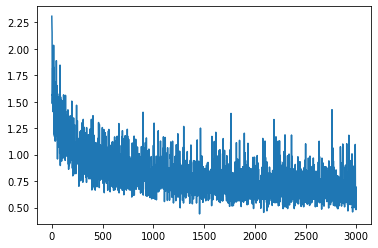

In [32]:
loss_items = []
for l in losses:
  loss_items.append(l.item())
plt.plot(loss_items)
print(min(loss_items))
print(np.mean(loss_items))

1128
0.46974530816078186
0.5996795114543703


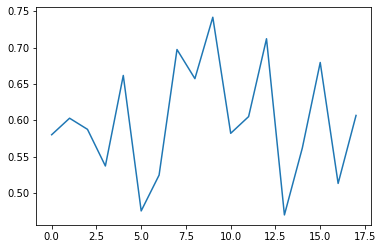

In [33]:
bench_data = MoleculeNet(root=".", name="ESOL")
bench_preds = []
bench_embs = []
bench_losses = []
bench_loader = DataLoader(bench_data, batch_size=64, shuffle=False)
print(len(bench_loader.dataset))
for batch in bench_loader:
  batch.to(device)  
  pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
  bench_preds.append(pred)
  bench_embs.append(embedding)
  bench_losses.append(torch.sqrt(loss_fn(pred, batch.y)))

bench_pred_loss_items = []
for l in bench_losses:
  bench_pred_loss_items.append(l.item())
print(min(bench_pred_loss_items)) 
print(np.mean(bench_pred_loss_items))  
plt.plot(bench_pred_loss_items)

## Generate molecules with Deepchem

In [17]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 KB 34.6 MB/s eta 0:00:00


In [18]:
import deepchem as dc
from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
from tensorflow import one_hot
from tensorflow.keras.layers import Input, Lambda, Layer, Softmax, Reshape, Multiply
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

smiles = ['CCC', 'C1=CC=CC=C1', 'CNC' ]
# create featurizer
feat = dc.feat.MolGanFeaturizer()
# featurize molecules
features = feat.featurize(smiles)
# Remove empty objects
features = list(filter(lambda x: x is not None, features))
# create model
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}

gan.fit_gan(iterbatches(5000), generator_steps=0.2, checkpoint_interval=5000)
generated_data = gan.predict_gan_generator(10000)
# convert graphs to RDKitmolecules
nmols = feat.defeaturize(generated_data)
print("{} molecules generated".format(len(nmols)))
# remove invalid moles
nmols = list(filter(lambda x: x is not None, nmols))
# currently training is unstable so 0 is a common outcome
print ("{} valid molecules".format(len(nmols)))

Ending global_step 4999: generator average loss -80.2422, discriminator average loss -6.91662
TIMING: model fitting took 114.966 s
Generating 10000 samples
10000 molecules generated
4767 valid molecules


In [19]:
from collections import OrderedDict
nmols_smiles = [Chem.MolToSmiles(m) for m in nmols]
nmols_smiles_unique = list(OrderedDict.fromkeys(nmols_smiles))
nmols_viz = [Chem.MolFromSmiles(x) for x in nmols_smiles_unique]
print ("{} unique valid molecules".format(len(nmols_viz)))

27 unique valid molecules


In [20]:
print(nmols_viz)

[<rdkit.Chem.rdchem.Mol object at 0x7f067bc0b900>, <rdkit.Chem.rdchem.Mol object at 0x7f058b899350>, <rdkit.Chem.rdchem.Mol object at 0x7f058b8993c0>, <rdkit.Chem.rdchem.Mol object at 0x7f058b899430>, <rdkit.Chem.rdchem.Mol object at 0x7f058b899580>, <rdkit.Chem.rdchem.Mol object at 0x7f058b8995f0>, <rdkit.Chem.rdchem.Mol object at 0x7f058b899660>, <rdkit.Chem.rdchem.Mol object at 0x7f058b8996d0>, <rdkit.Chem.rdchem.Mol object at 0x7f058b899740>, <rdkit.Chem.rdchem.Mol object at 0x7f058b8997b0>, <rdkit.Chem.rdchem.Mol object at 0x7f058b899820>, <rdkit.Chem.rdchem.Mol object at 0x7f058b899890>, <rdkit.Chem.rdchem.Mol object at 0x7f058b899900>, <rdkit.Chem.rdchem.Mol object at 0x7f058b899970>, <rdkit.Chem.rdchem.Mol object at 0x7f058b8999e0>, <rdkit.Chem.rdchem.Mol object at 0x7f058b899a50>, <rdkit.Chem.rdchem.Mol object at 0x7f058b899ac0>, <rdkit.Chem.rdchem.Mol object at 0x7f058b899b30>, <rdkit.Chem.rdchem.Mol object at 0x7f058b899ba0>, <rdkit.Chem.rdchem.Mol object at 0x7f058b899c10>,

In [21]:
#sample = from_smiles('CC12CCC3C(CCC4=CC(=O)CCC34C)C2CCC1C(=O)CO')
#print(sample)

#loader = DataLoader([sample], batch_size=batch_size, shuffle=False)